In [1]:
options(warn=-1)

#home 
#setwd("C://Users//Cherch//DataScience//project")

#work 
setwd("C://bb//DataScience//project")


require("caret")
require("openxlsx")
require("tidyverse")
require(devtools)
library(dplyr)
library(car)
library(naniar)


protocol<-read.xlsx("../project/BoxOffice - Data Retrieval Protocol.xlsx", sheet = "protocol")

head(protocol)

rownames(protocol) <- str_trim(protocol$Feature.name)

load("../data/BoxOffice_ff.RData")

load("../data/BoxOffice_ff_with_ouliers.RData")

Loading required package: caret

Loading required package: lattice

Loading required package: ggplot2

Loading required package: openxlsx

Loading required package: tidyverse

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

v tibble  2.1.3     v purrr   0.3.2
v tidyr   0.8.3     v dplyr   0.8.3
v readr   1.3.1     v stringr 1.4.0
v tibble  2.1.3     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()

Loading required package: devtools

Loading required package: usethis

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




Feature.name                       Source                              
1 movie_id                           movies                              
2 depart_Lighting_female             movie_crew LEFT OUTER JOIN crew_dim 
3 original_language                  movies                              
4 sw_collection                      movie_collection                    
5 depart_Visual_Effects_female       movie_crew LEFT OUTER JOIN crew_dim 
6 runtime_cat                        movies                              
  Value.type  Scale   Data.type Unique.count Measure.unit Conversion.factor Min
1 Categorical Nominal Decimal   NA           NA           NA                 1 
2 Categorical Ratio   Decimal    2           NA           NA                 0 
3 Categorical Nominal Text      44           NA           NA                NA 
4 Categorical Ratio   Decimal    3           NA           NA                 0 
5 Categorical Ratio   Decimal    3           NA           NA                 0 
6 Categorical Ordinal Text       3           NA           NA                 1 
  Max  Outlier.treatment Null
1 7398 NA                NA  
2    1 Categorize        NA  
3   NA Leave             NA  
4    2 Leave             NA  
5    2 Categorize        NA  
6    3 Leave             NA  
  Outlier.Notes                                                                   
1 NA                                                                              
2 due to low variability                                                          
3 NA                                                                              
4 Movies belongin to multiple collections look like an error (check movie_id= 555)
5 due to low variability                                                          
6 NA                                                                              
  Categories.num Categories.names
1 NA             NA              
2 0,1,2          None, Exist     
3 NA             NA              
4 NA             NA              
5 0,1,2          None, Exist     
6 NA             NA

##########################################################################################
# Missing Values heatmap
##########################################################################################


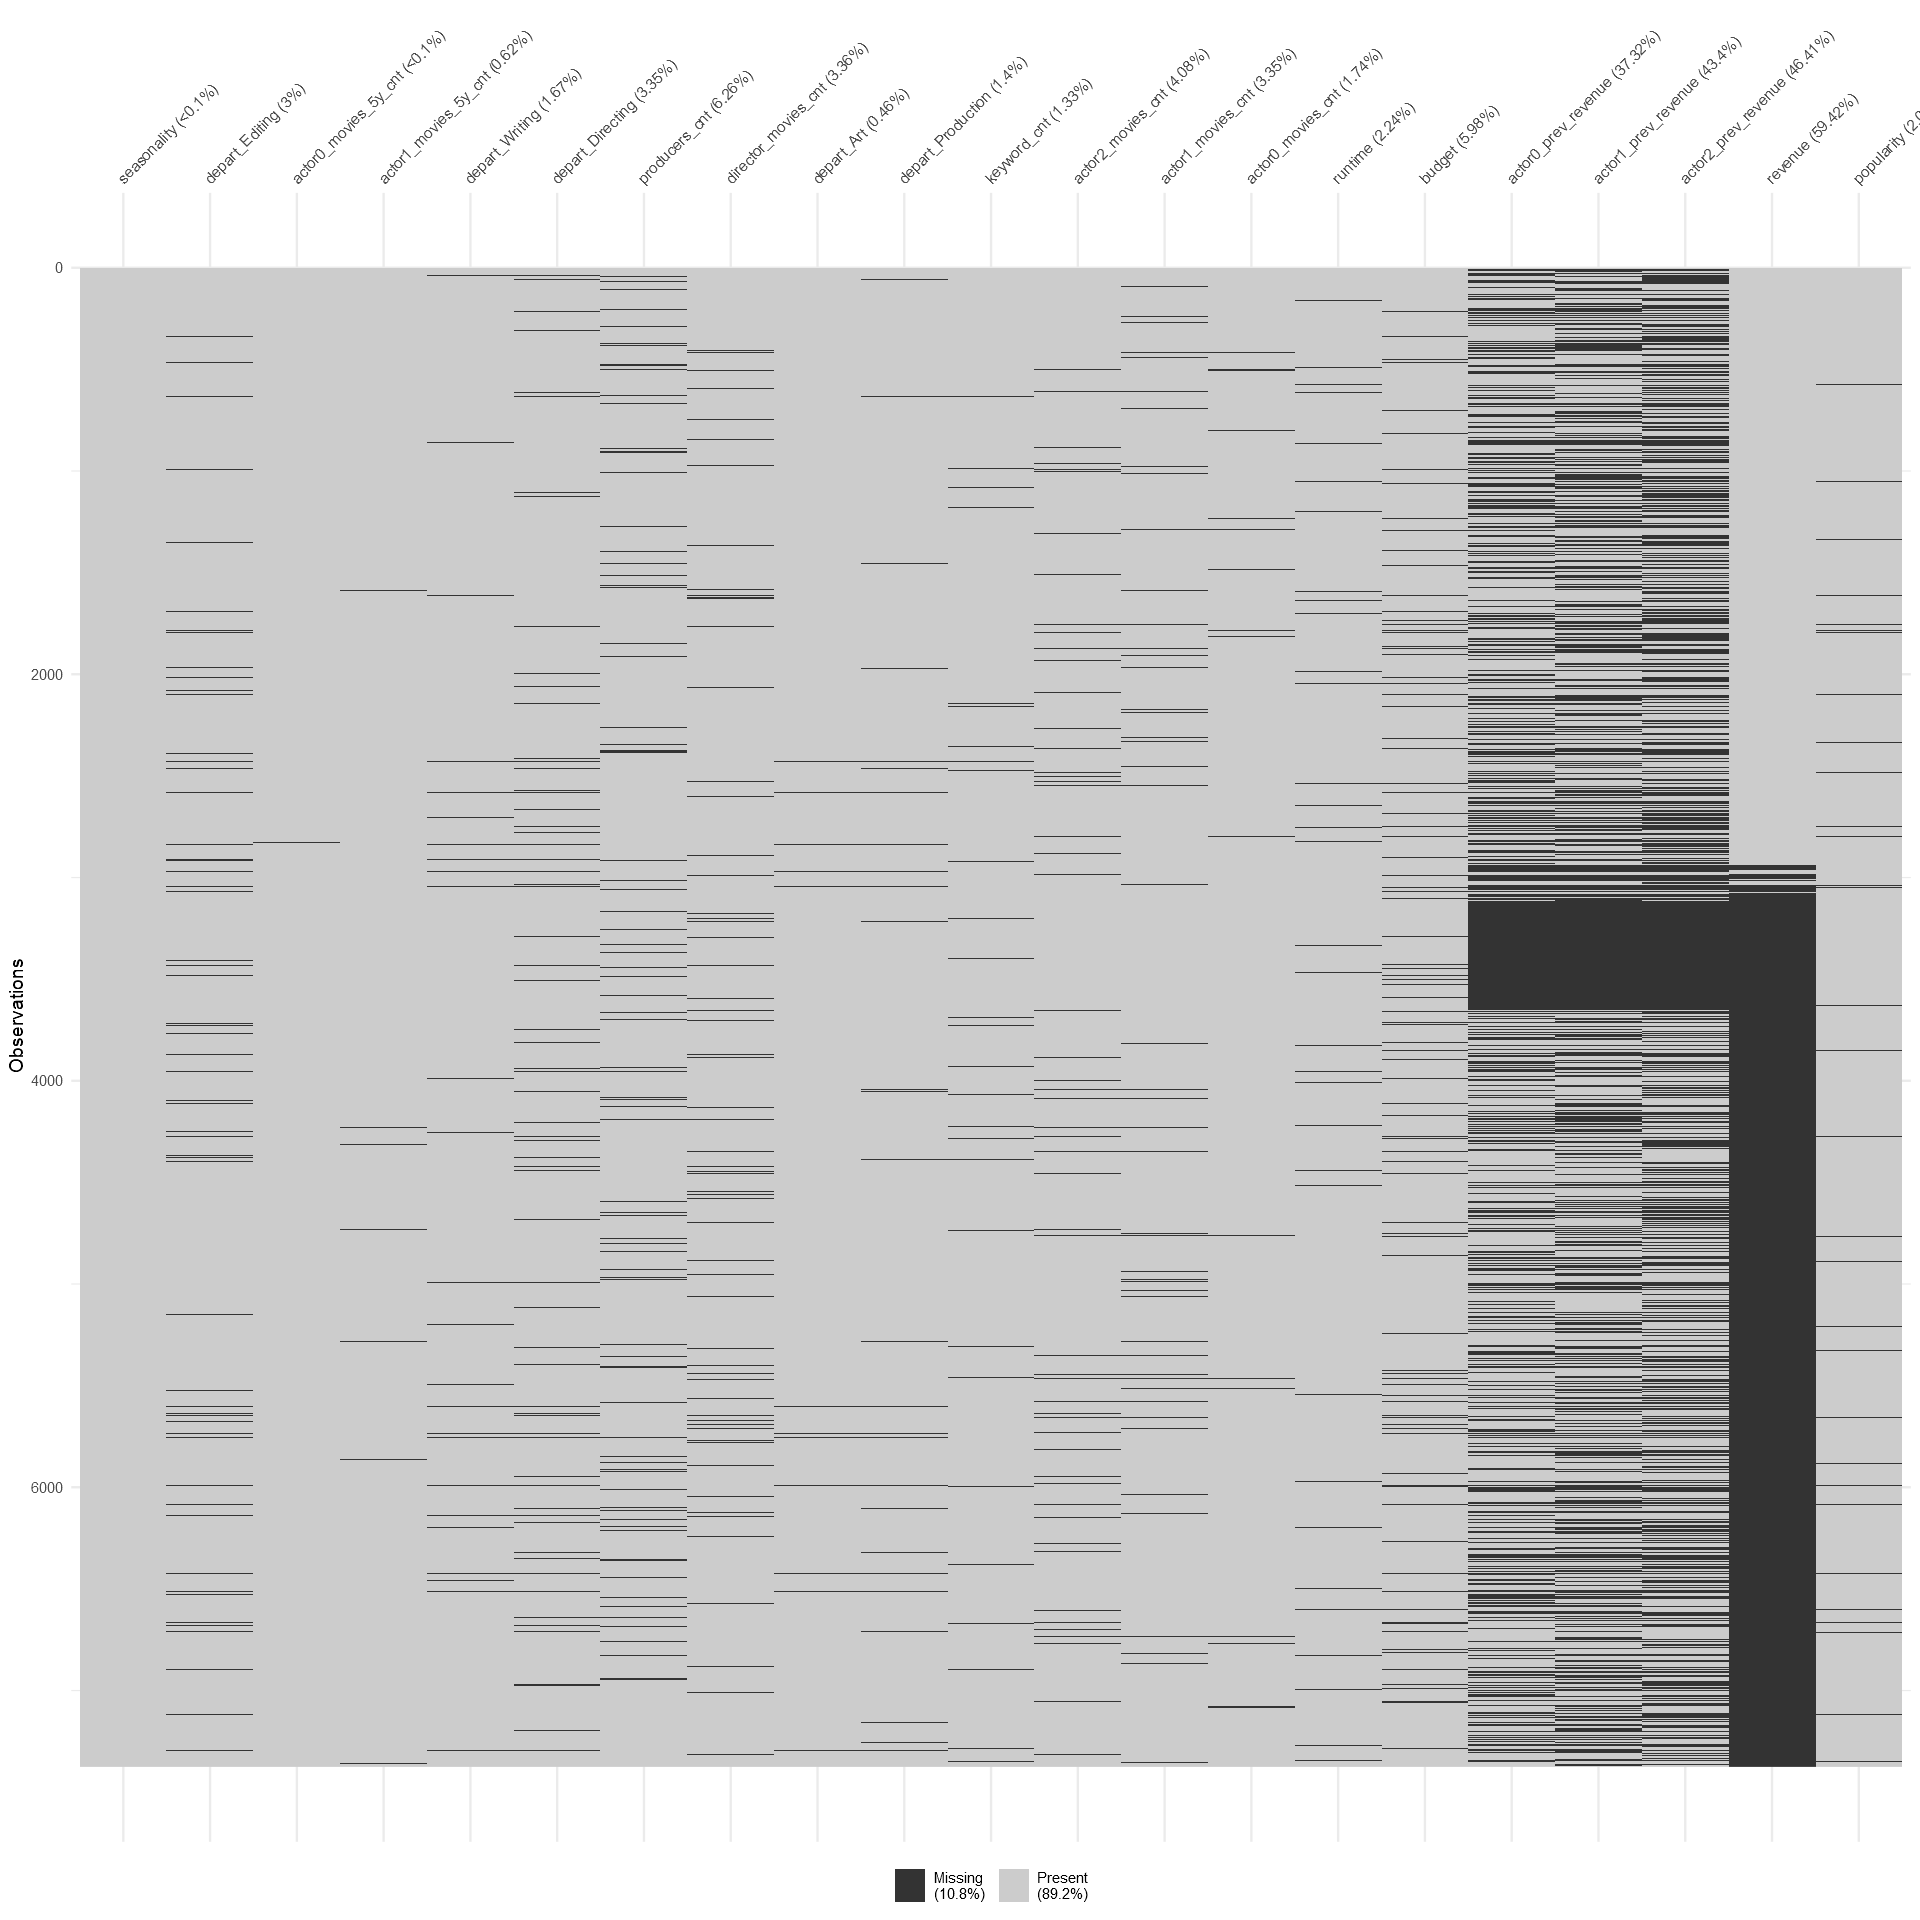

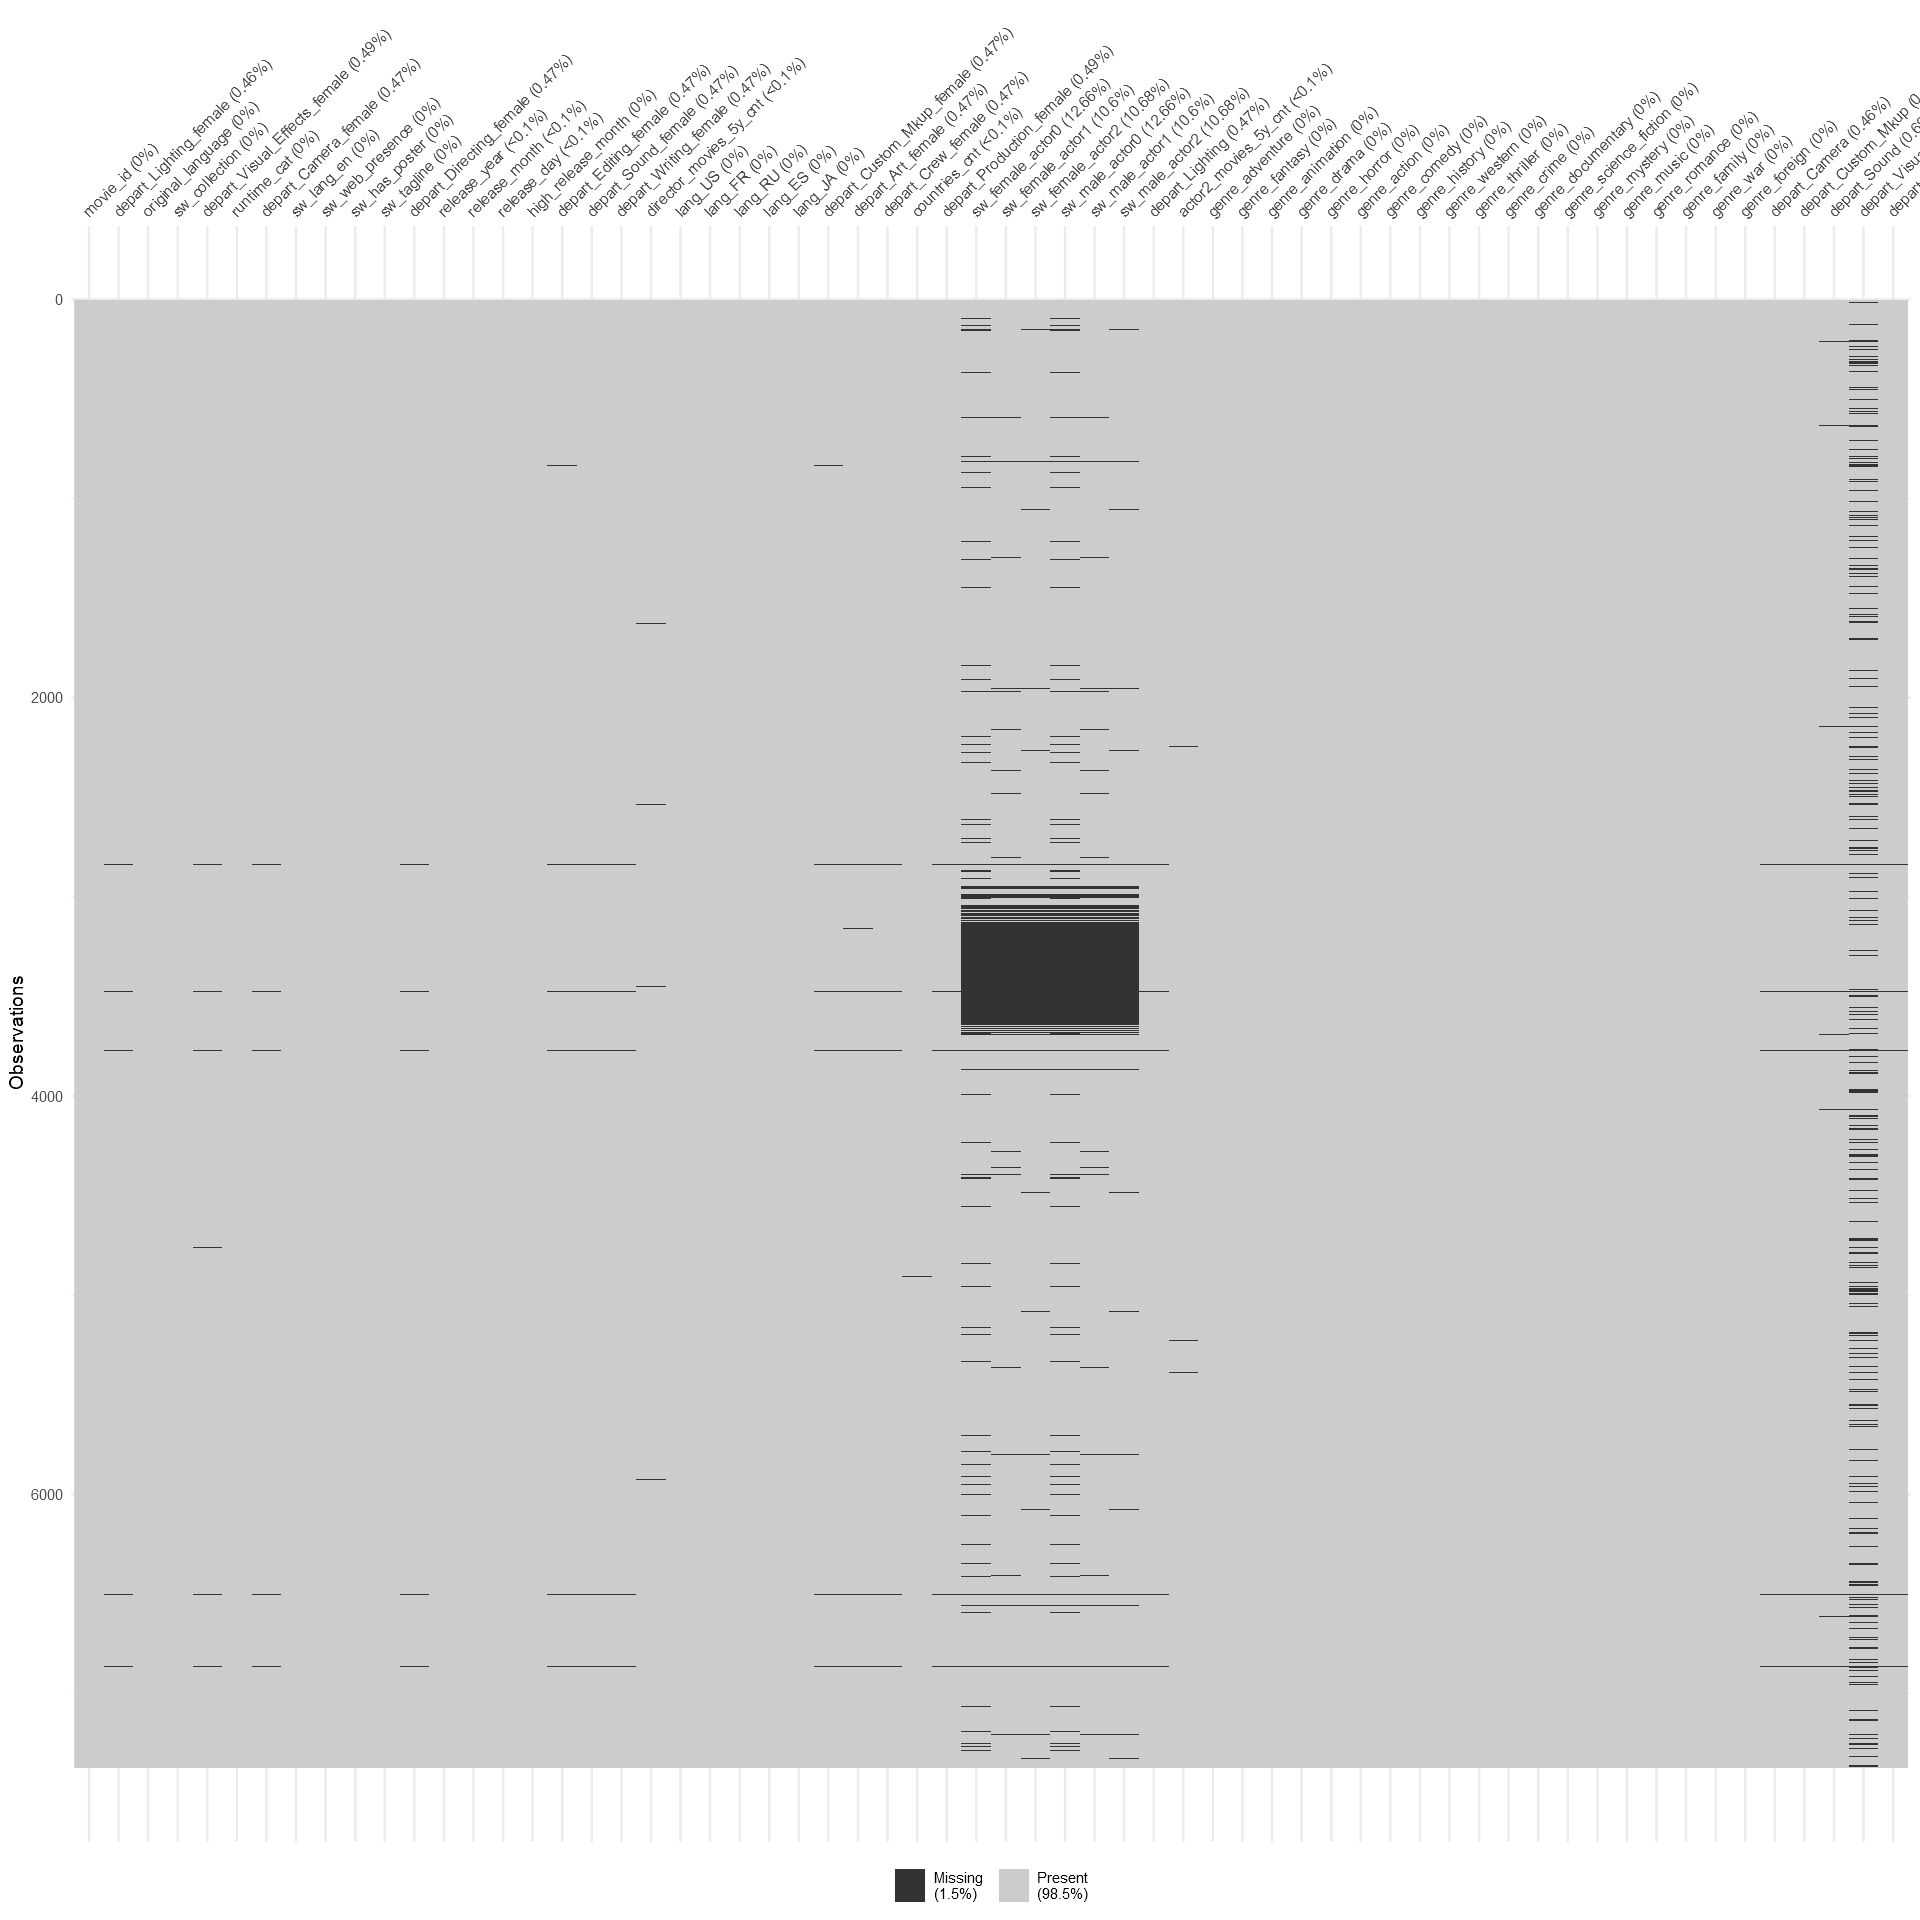

In [2]:
# list all the numeric variables
numerics<-str_trim(protocol$Feature.name[protocol$Value.type == "Numeric"])

# list all the numeric variables
categorics<-str_trim(protocol$Feature.name[protocol$Value.type == "Categorical"])

missingMatrix <- function(data) {
  vn <- names(data)
  missdata <- data.frame(row1=1:nrow(data))
  for(v in vn) {
    mv <- ifelse(is.na(data[[v]]),1,0)
    missdata[v] <- mv
  }
  missdata$row1 <- NULL
  return(missdata)
}

miss<-missingMatrix(ocmovies)

par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 16)

vis_miss(ocmovies[numerics])

vis_miss(ocmovies[categorics])


In [3]:
getMissingness <- function (data, getRows = FALSE, print_rows = 10) {
  require(dplyr)
  l <- nrow(data)
  vn <- names(data)
  nadf <- data
  cnt <- NULL
  miss <- function(x) return(sum(is.na(x)))
  for (n in vn) {
    nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
    cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
  }
  names(cnt) <- c("var", "na.count")
  cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
  nadf$na.cnt <- 0
  nadf$na.cnt <- rowSums(nadf)
  cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count >
                                                                    0)
  totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
  idx <- NULL
  msg <- (paste("This dataset has ", as.character(totmiss),
                " (", as.character(round(totmiss/nrow(data) * 100, 1)),
                "%)", " complete rows. Original data has ", nrow(data),
                " rows.", sep = ""))
  if (getRows == TRUE & totmiss != 0) {
    nadf$rn <- seq_len(nrow(data))
    idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
  }
  print(list(head(cnt, n = print_rows), msg))
  return(list(missingness = cnt, message = msg, rows = idx$rn))
}


[[1]]
                     var na.count rate
1                revenue     4382 59.4
2    actor2_prev_revenue     3423 46.4
3    actor1_prev_revenue     3201 43.4
4    actor0_prev_revenue     2752 37.3
5  depart_Visual_Effects     1306 17.7
6       sw_female_actor0      934 12.7
7         sw_male_actor0      934 12.7
8       sw_female_actor2      788 10.7
9         sw_male_actor2      788 10.7
10      sw_female_actor1      782 10.6

[[2]]
[1] "This dataset has 625 (8.5%) complete rows. Original data has 7375 rows."



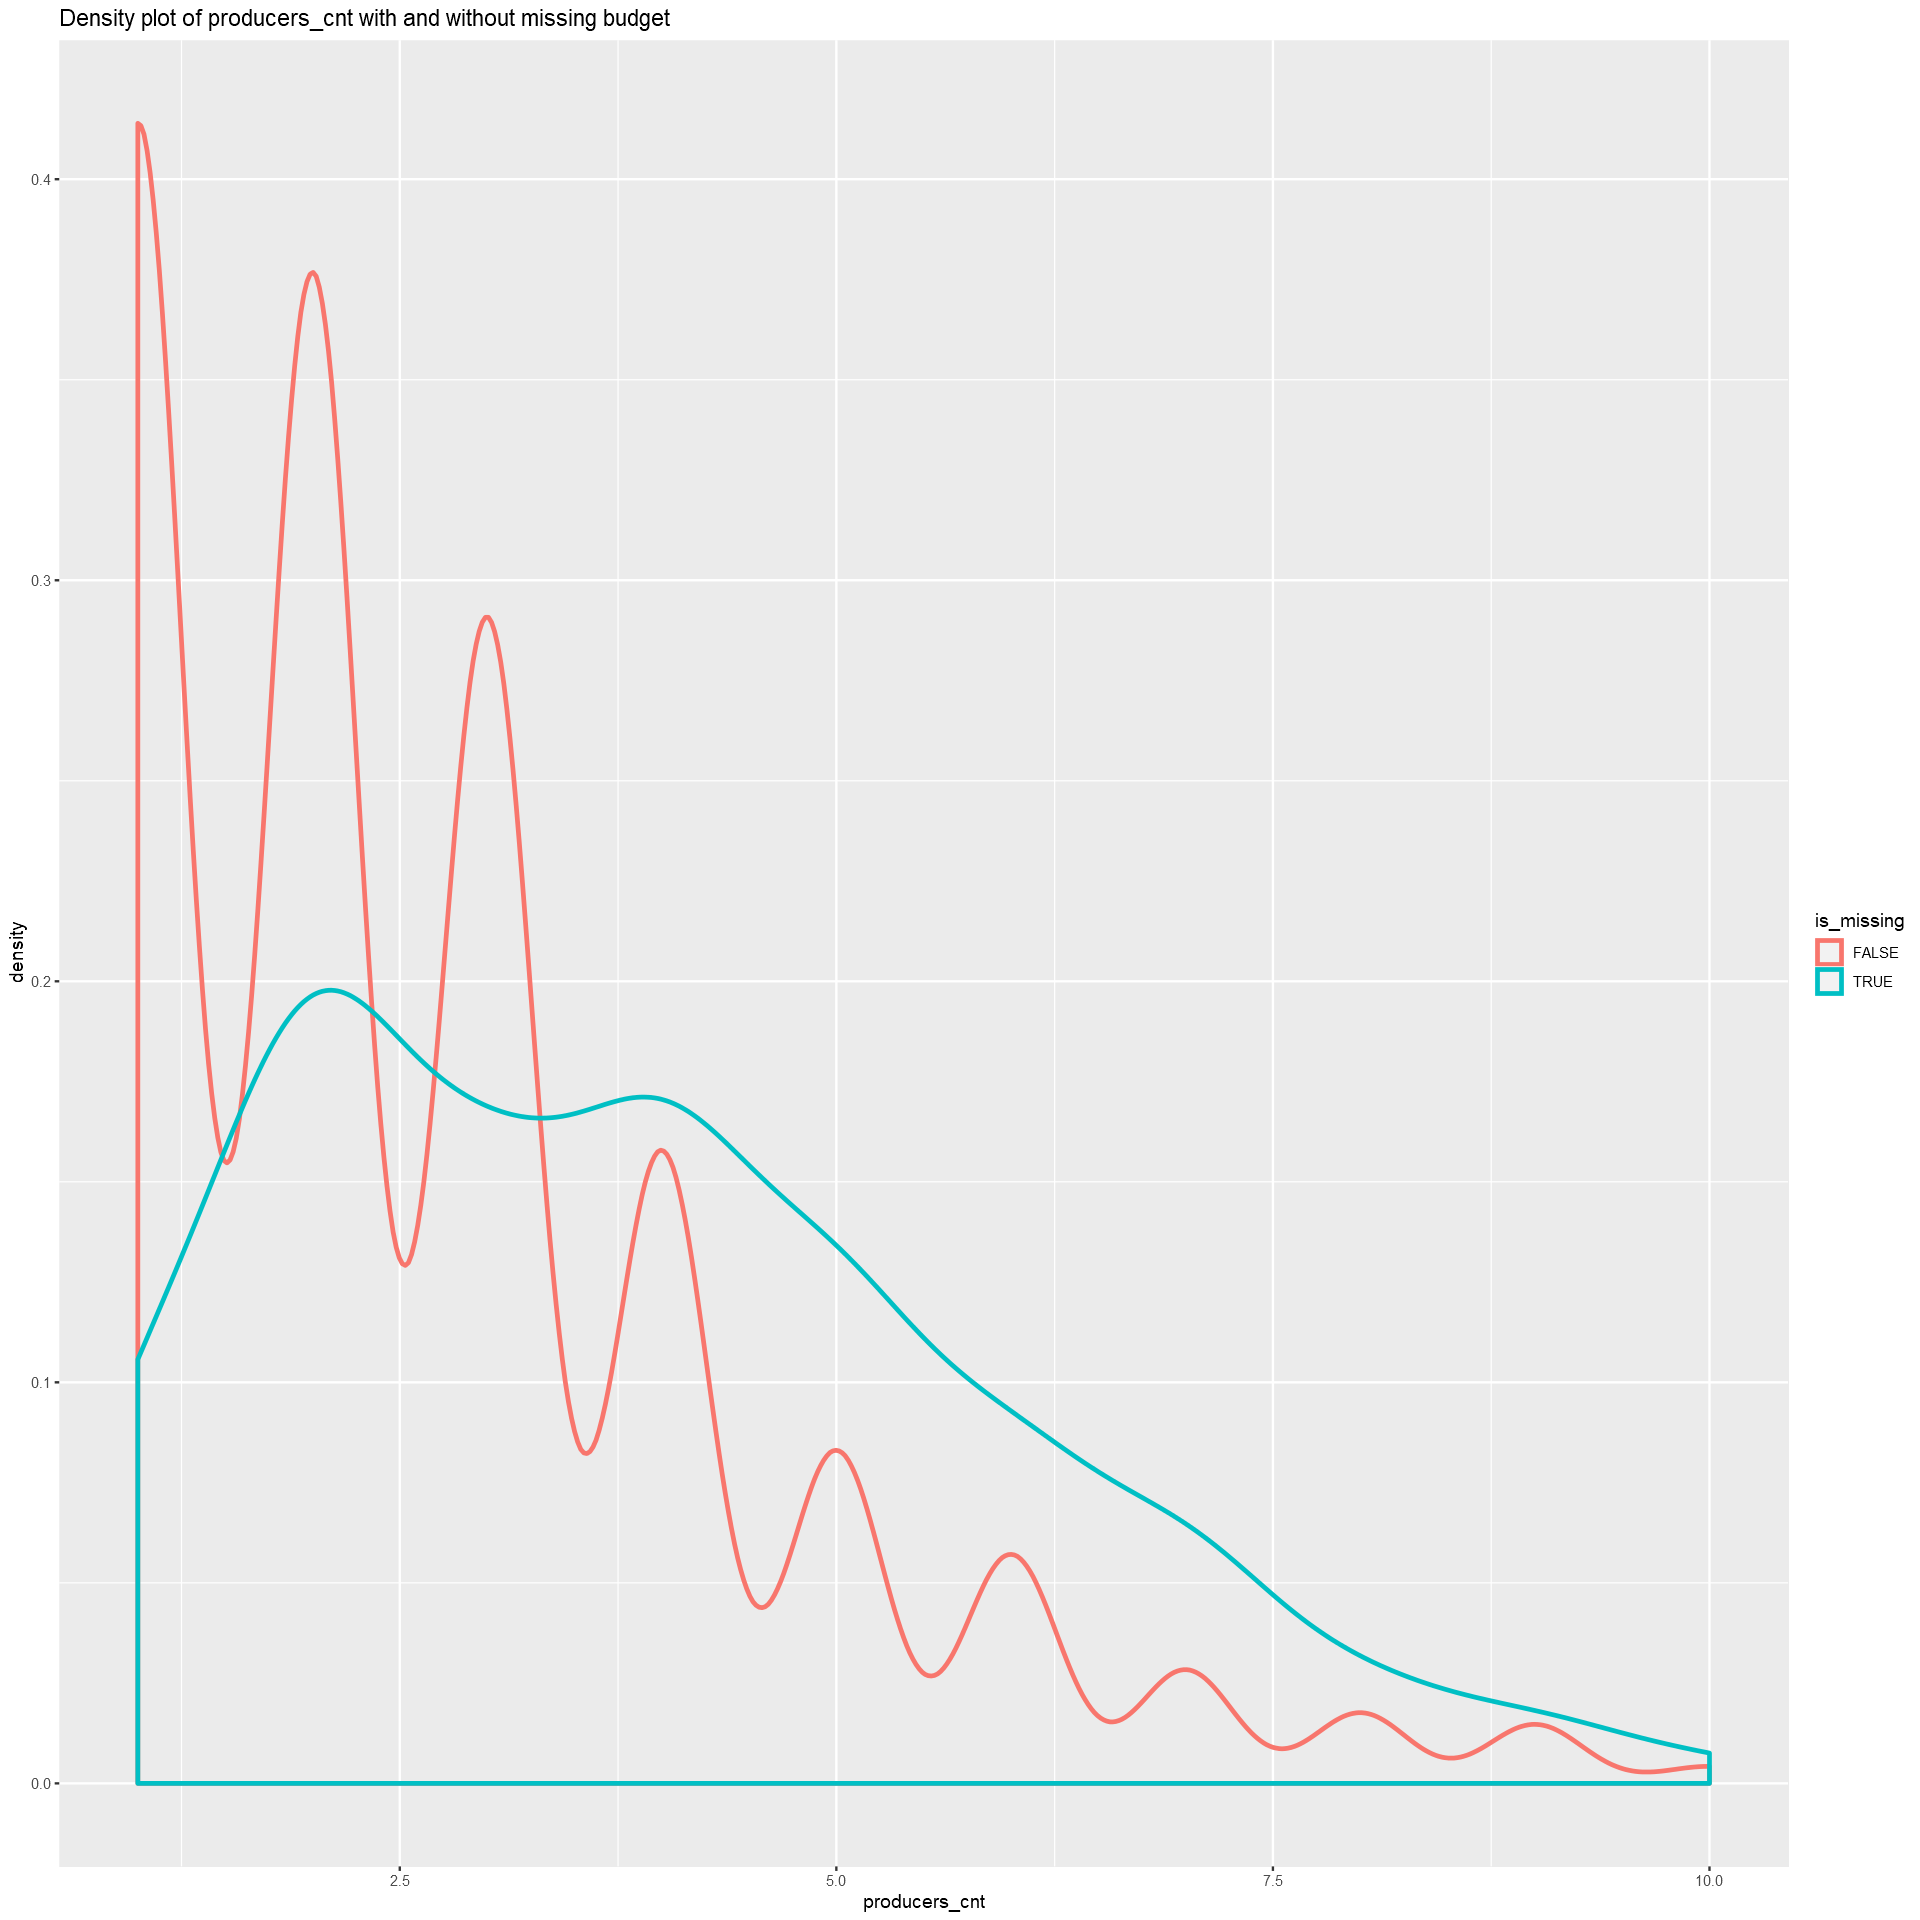

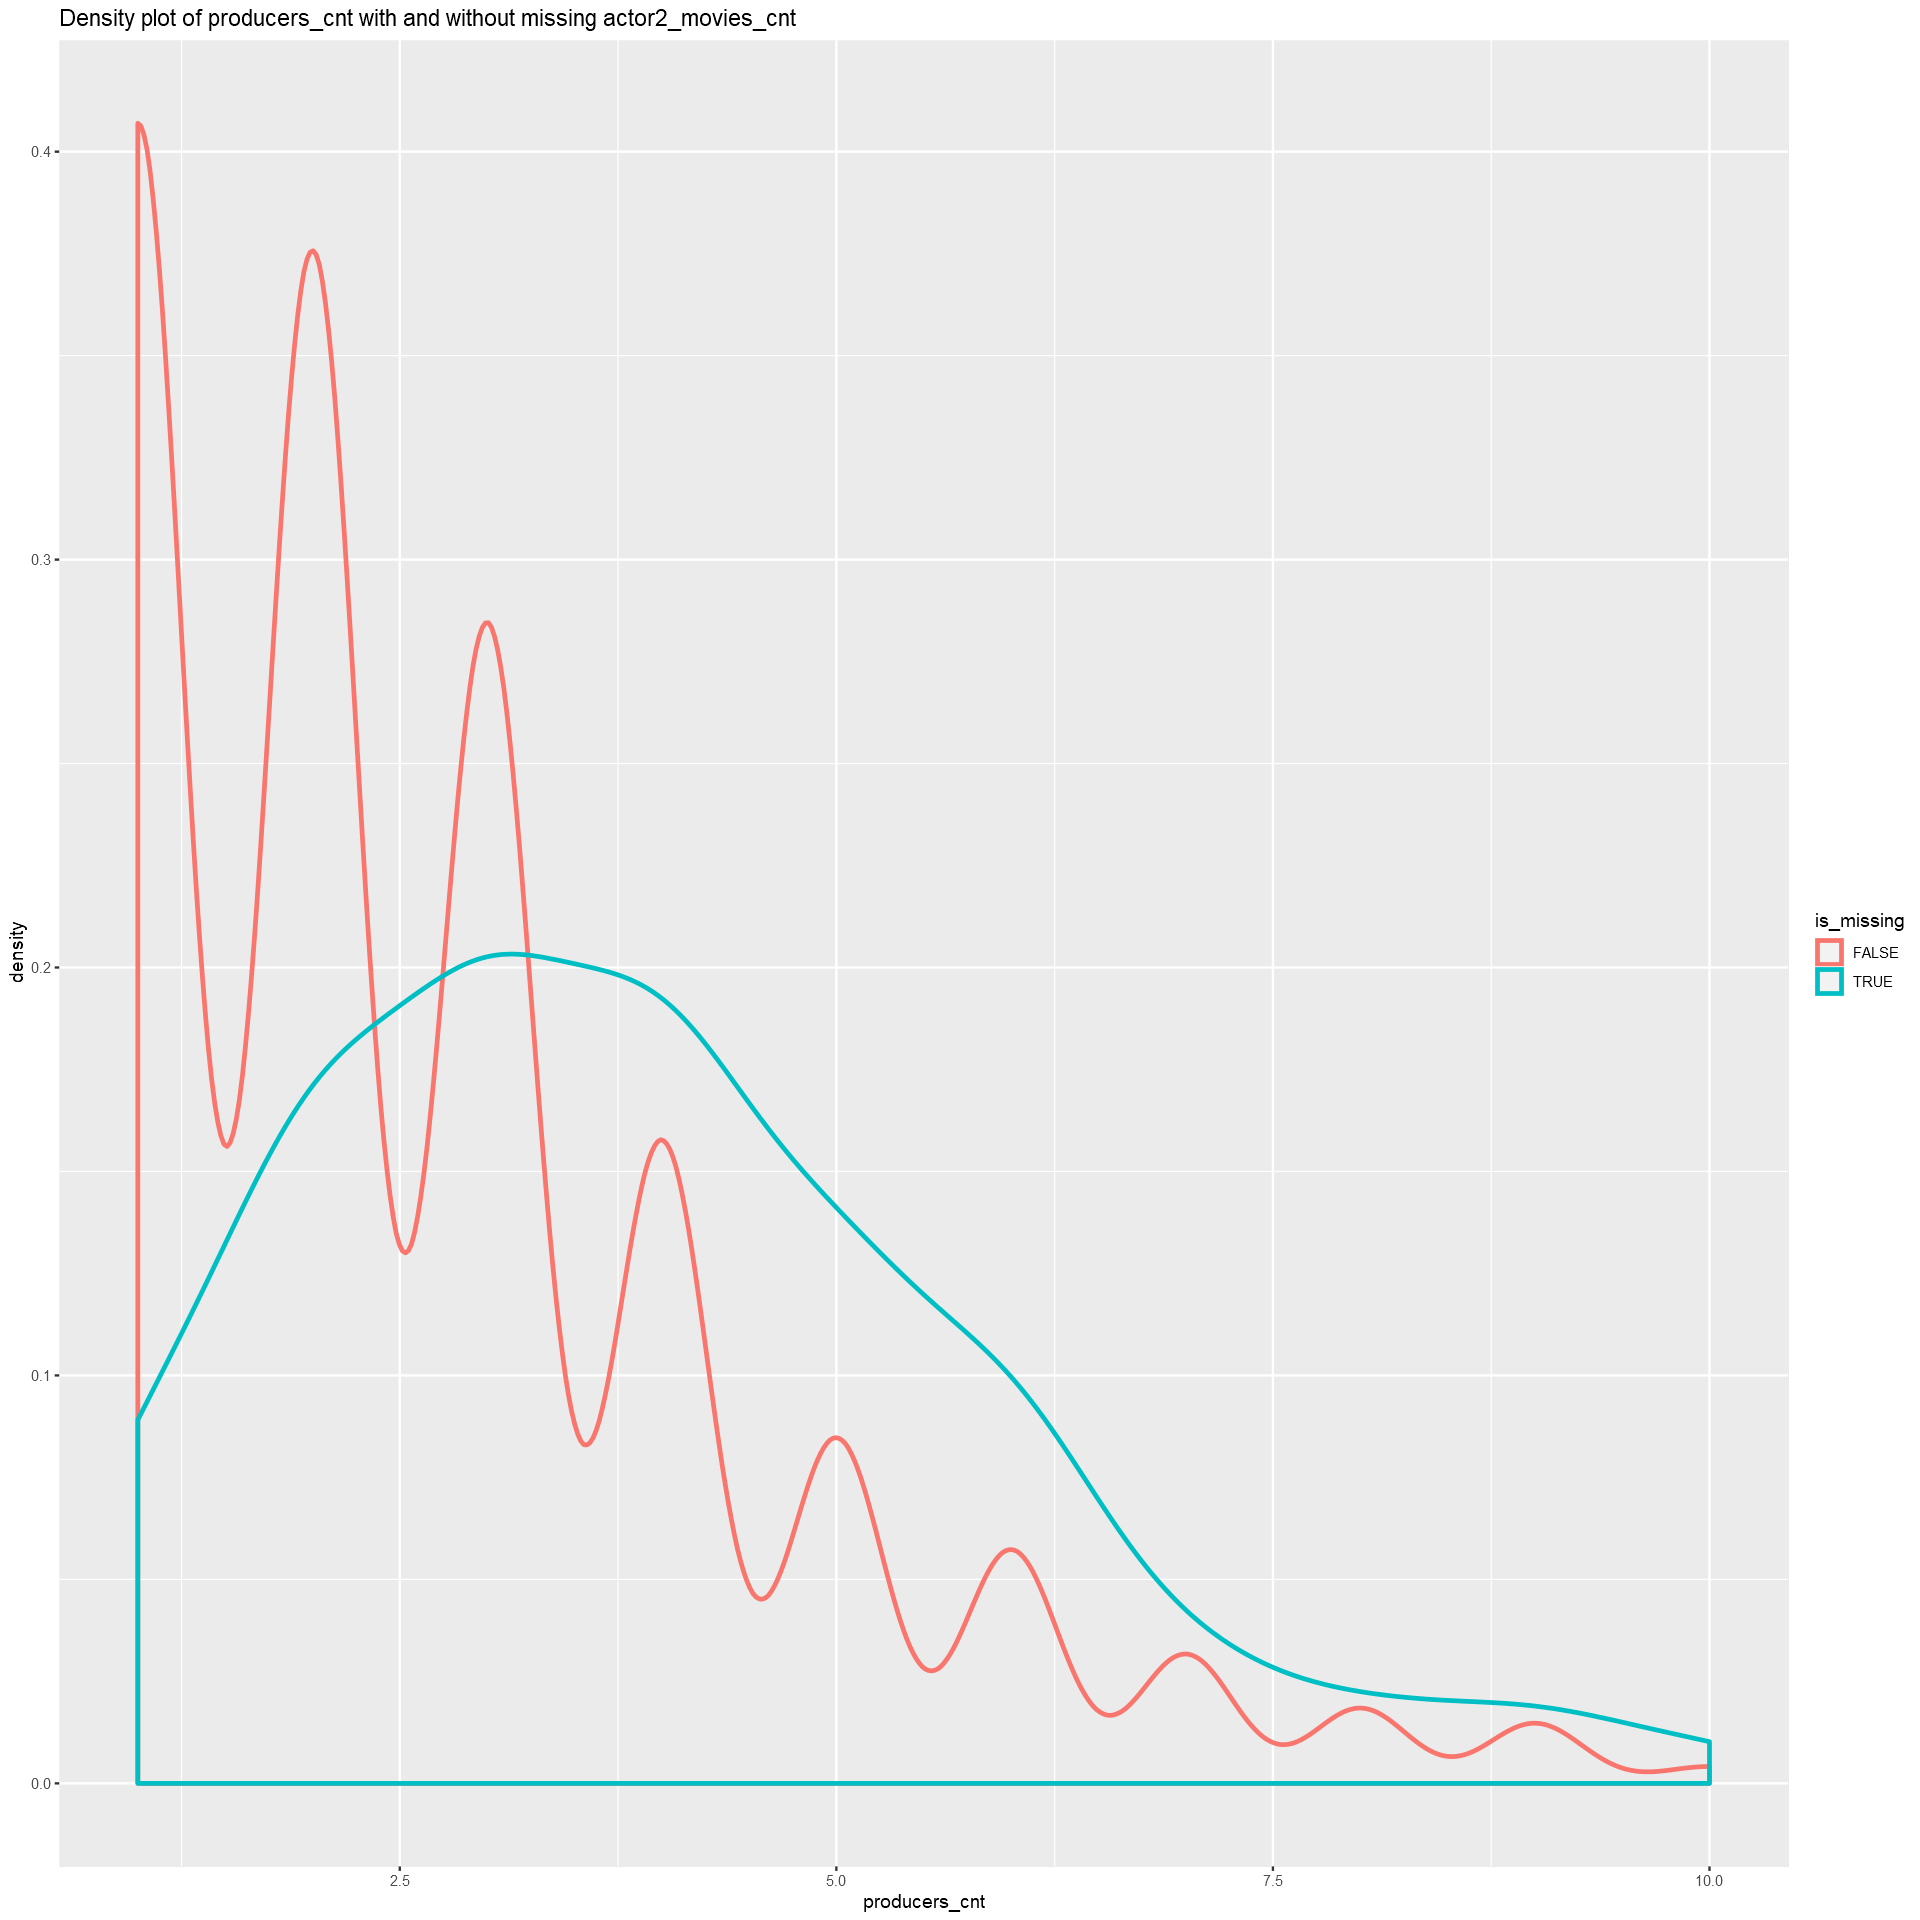

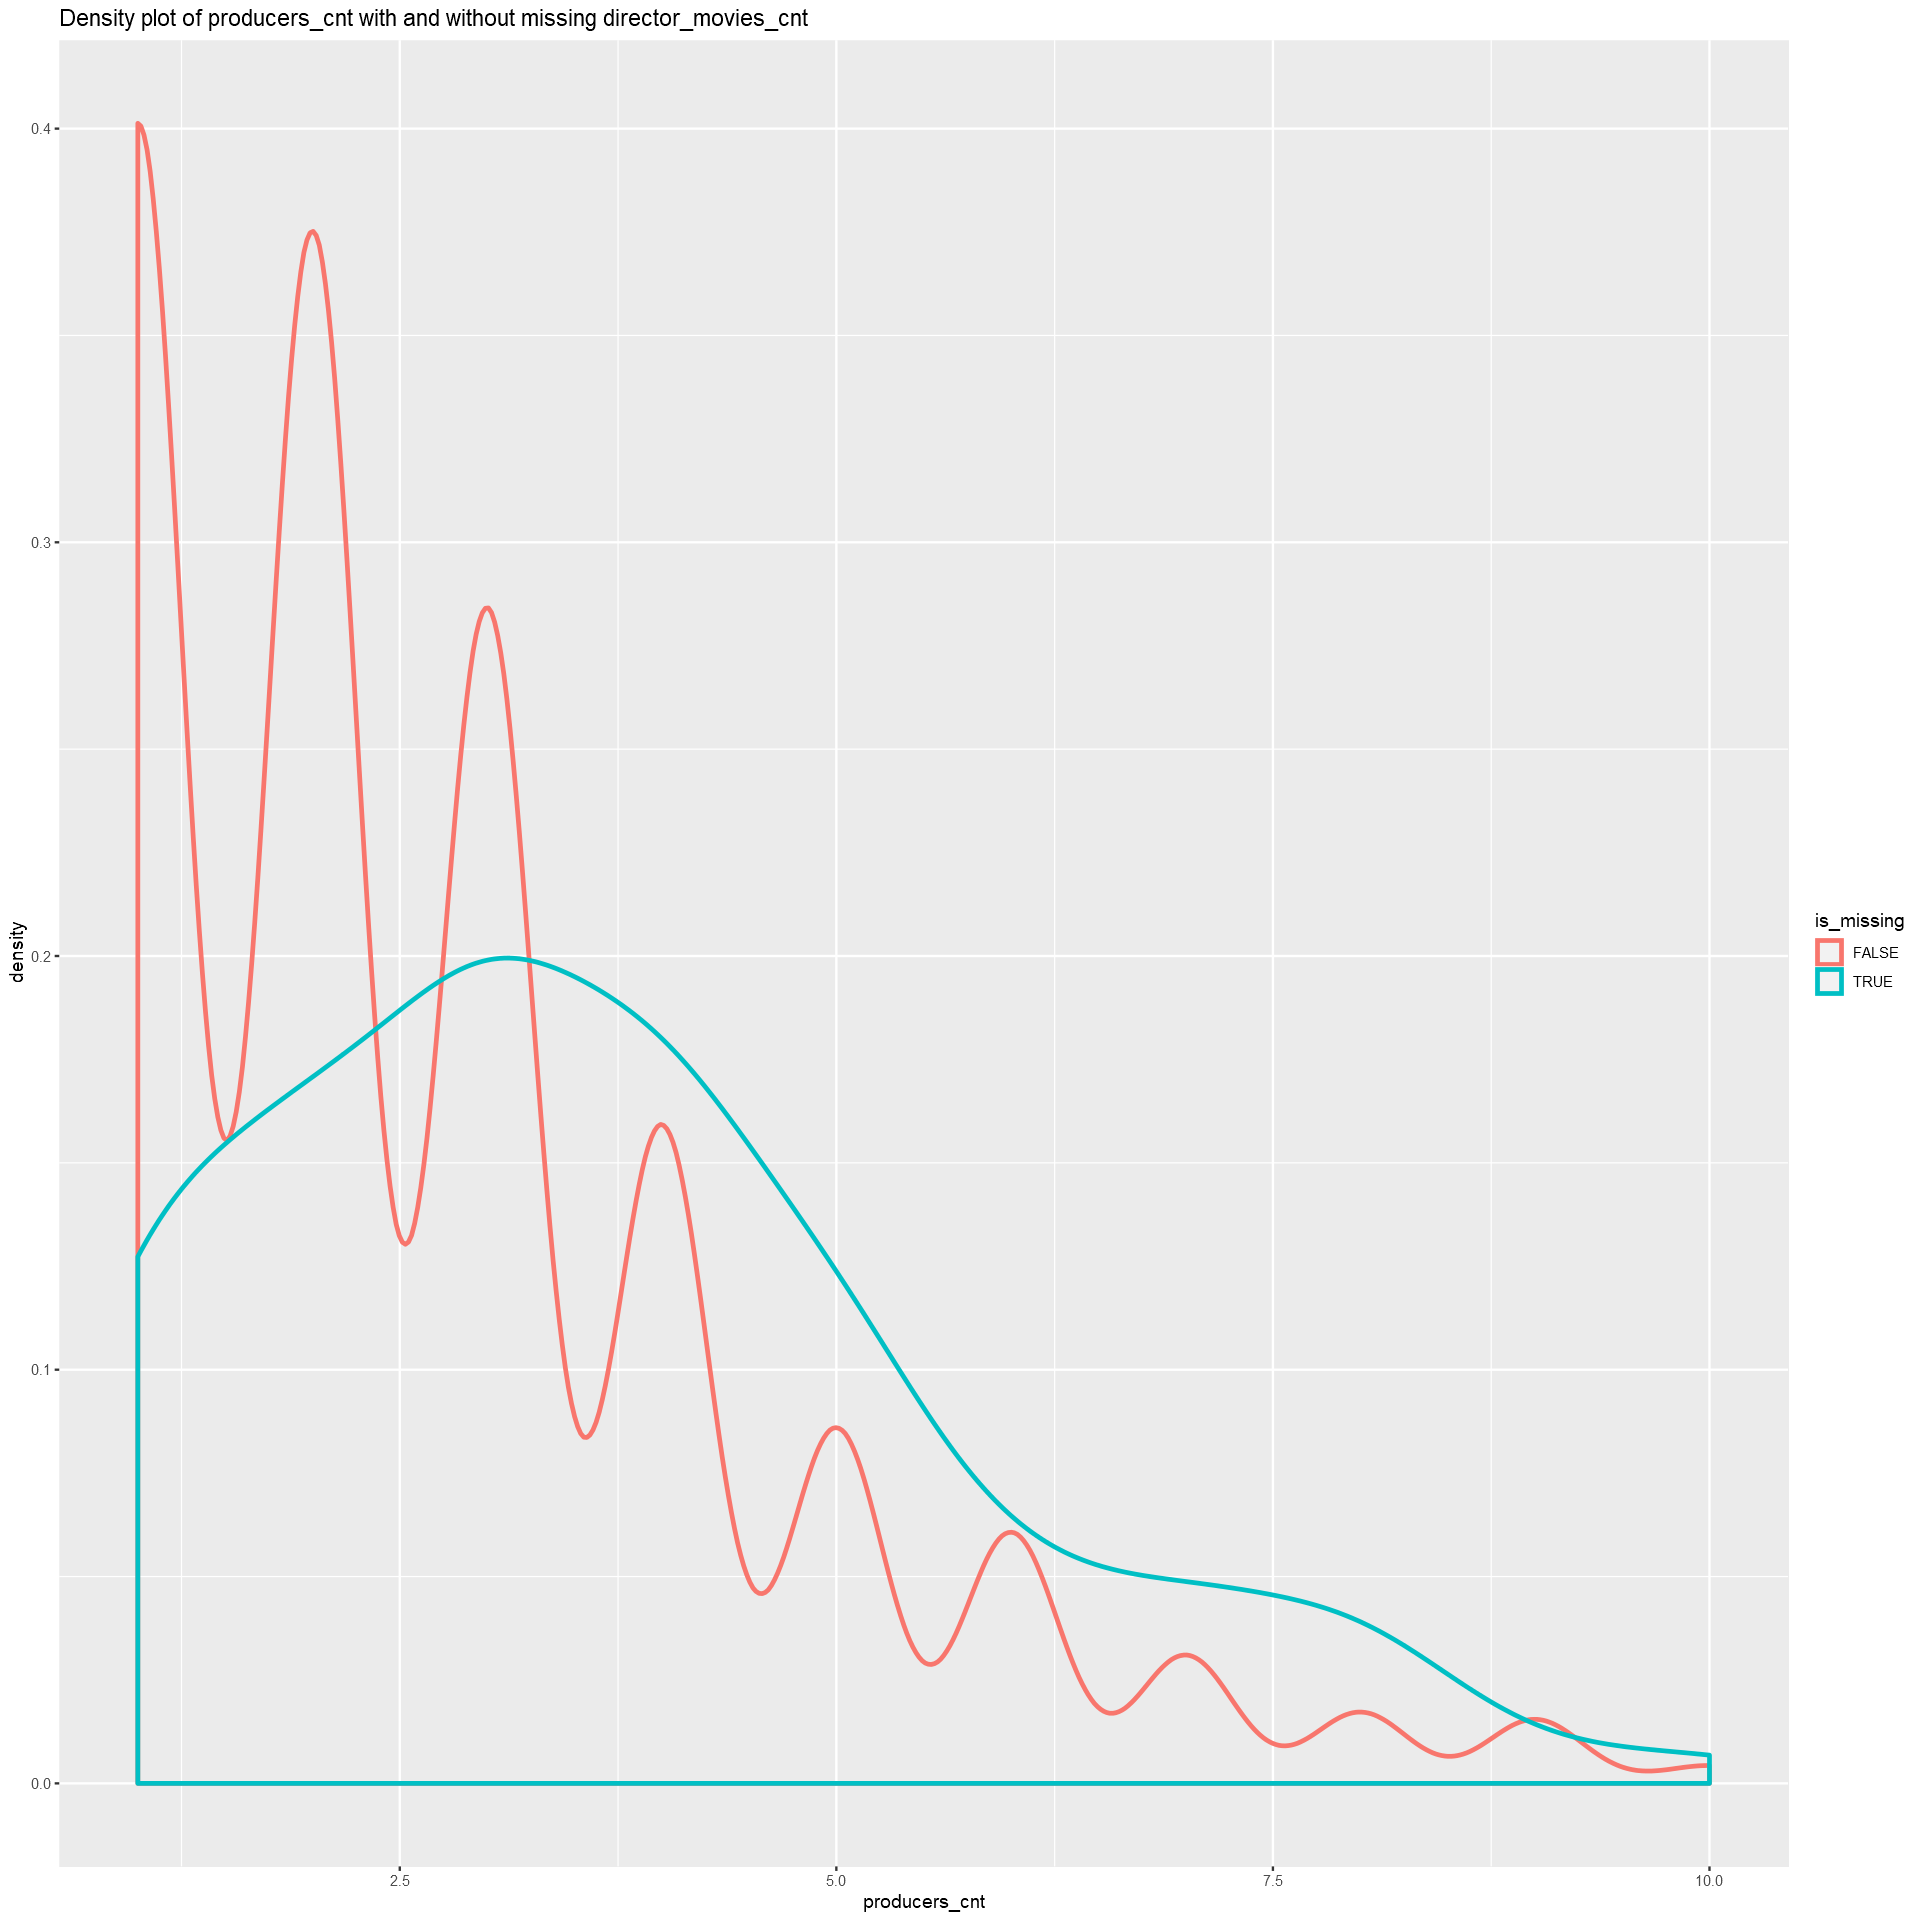

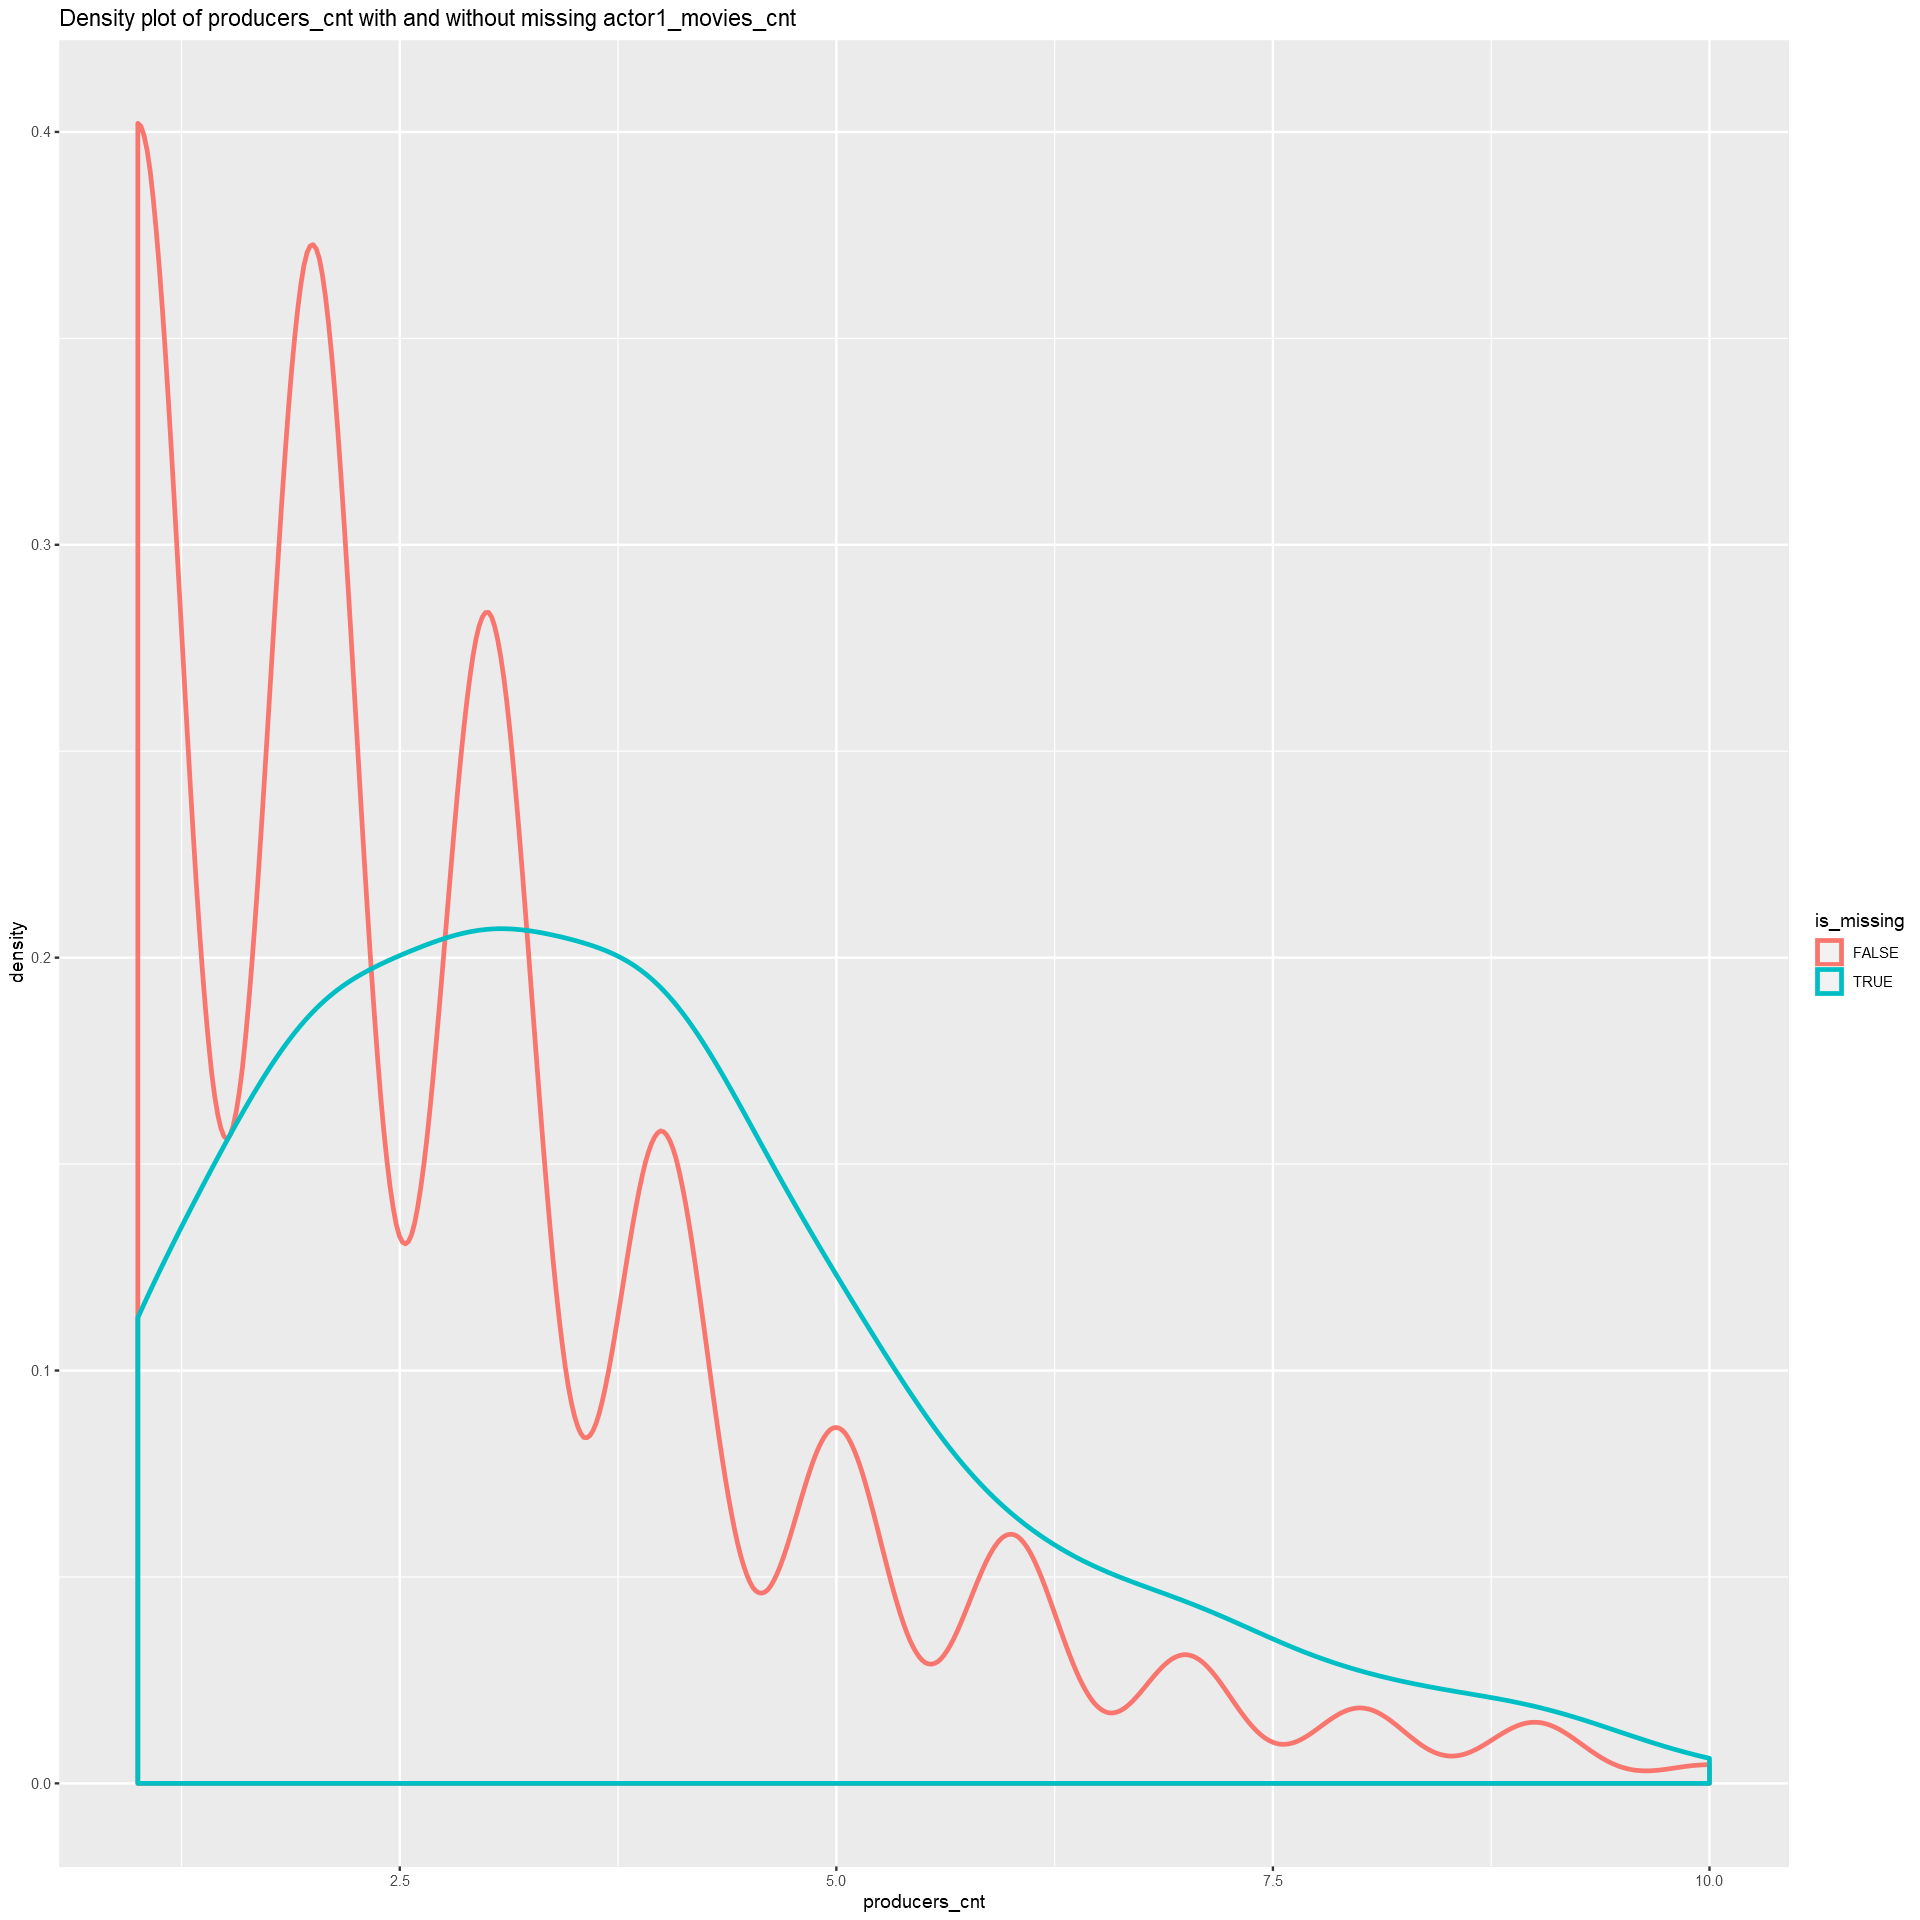

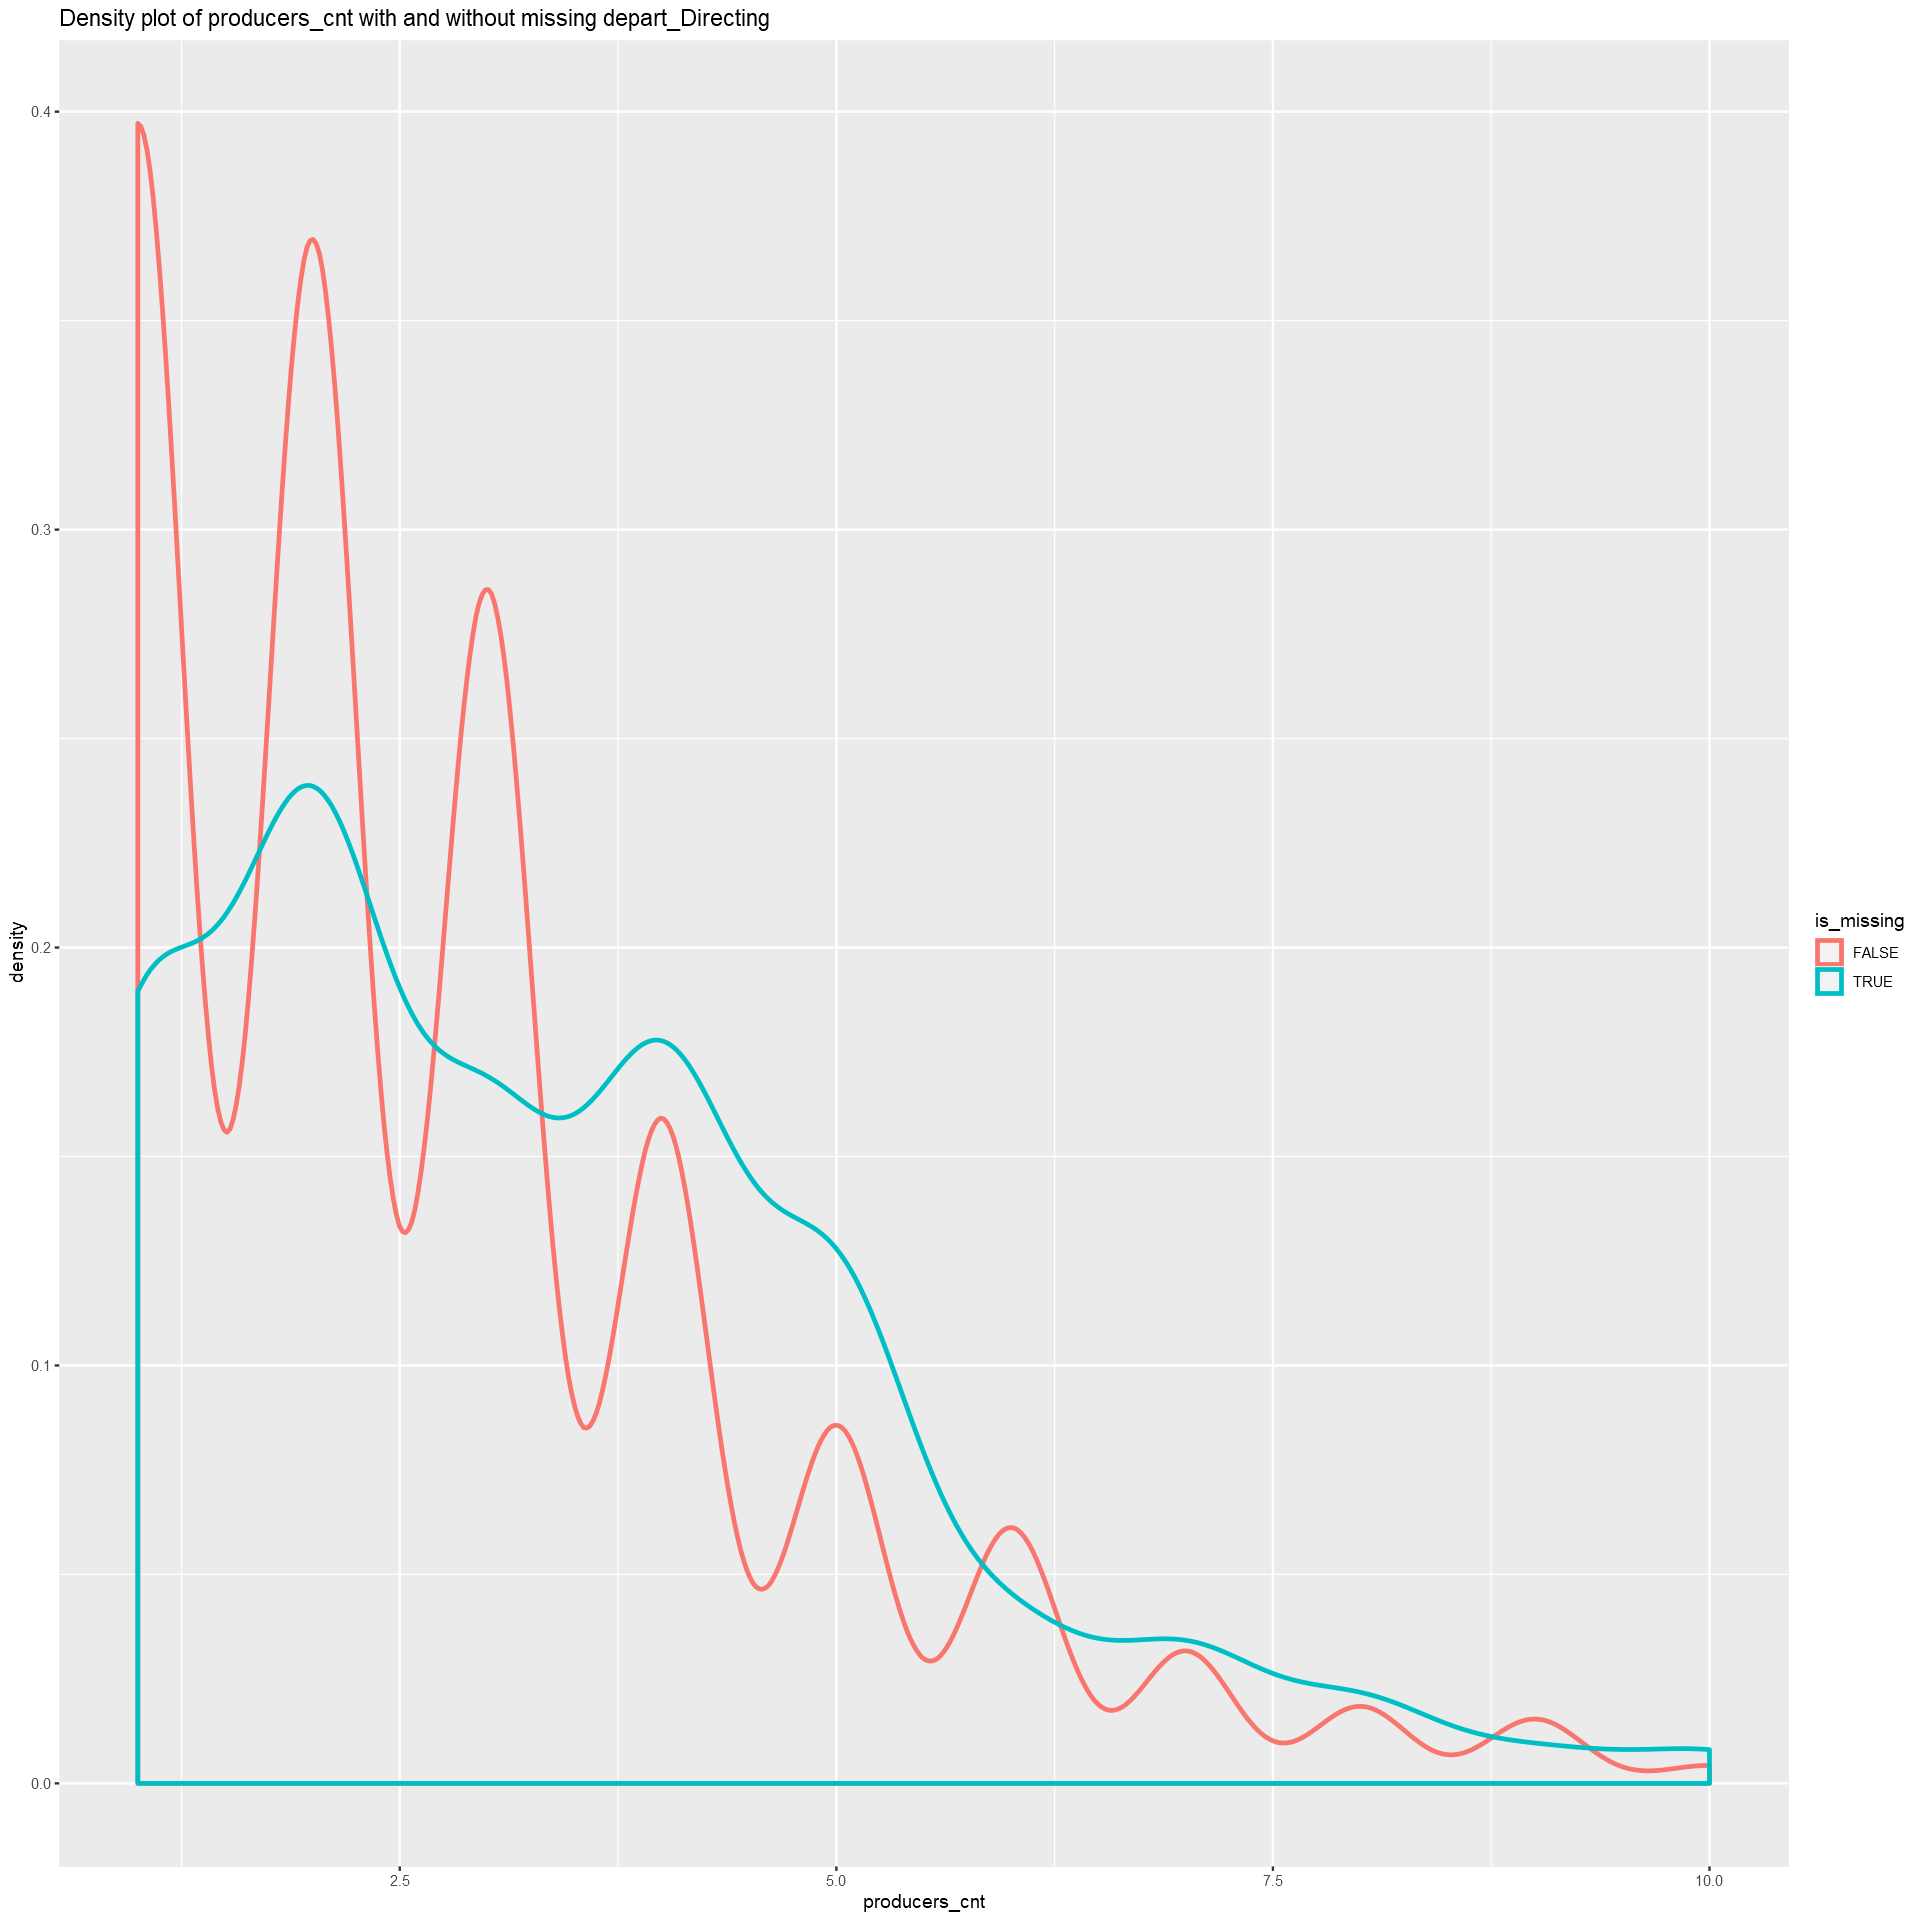

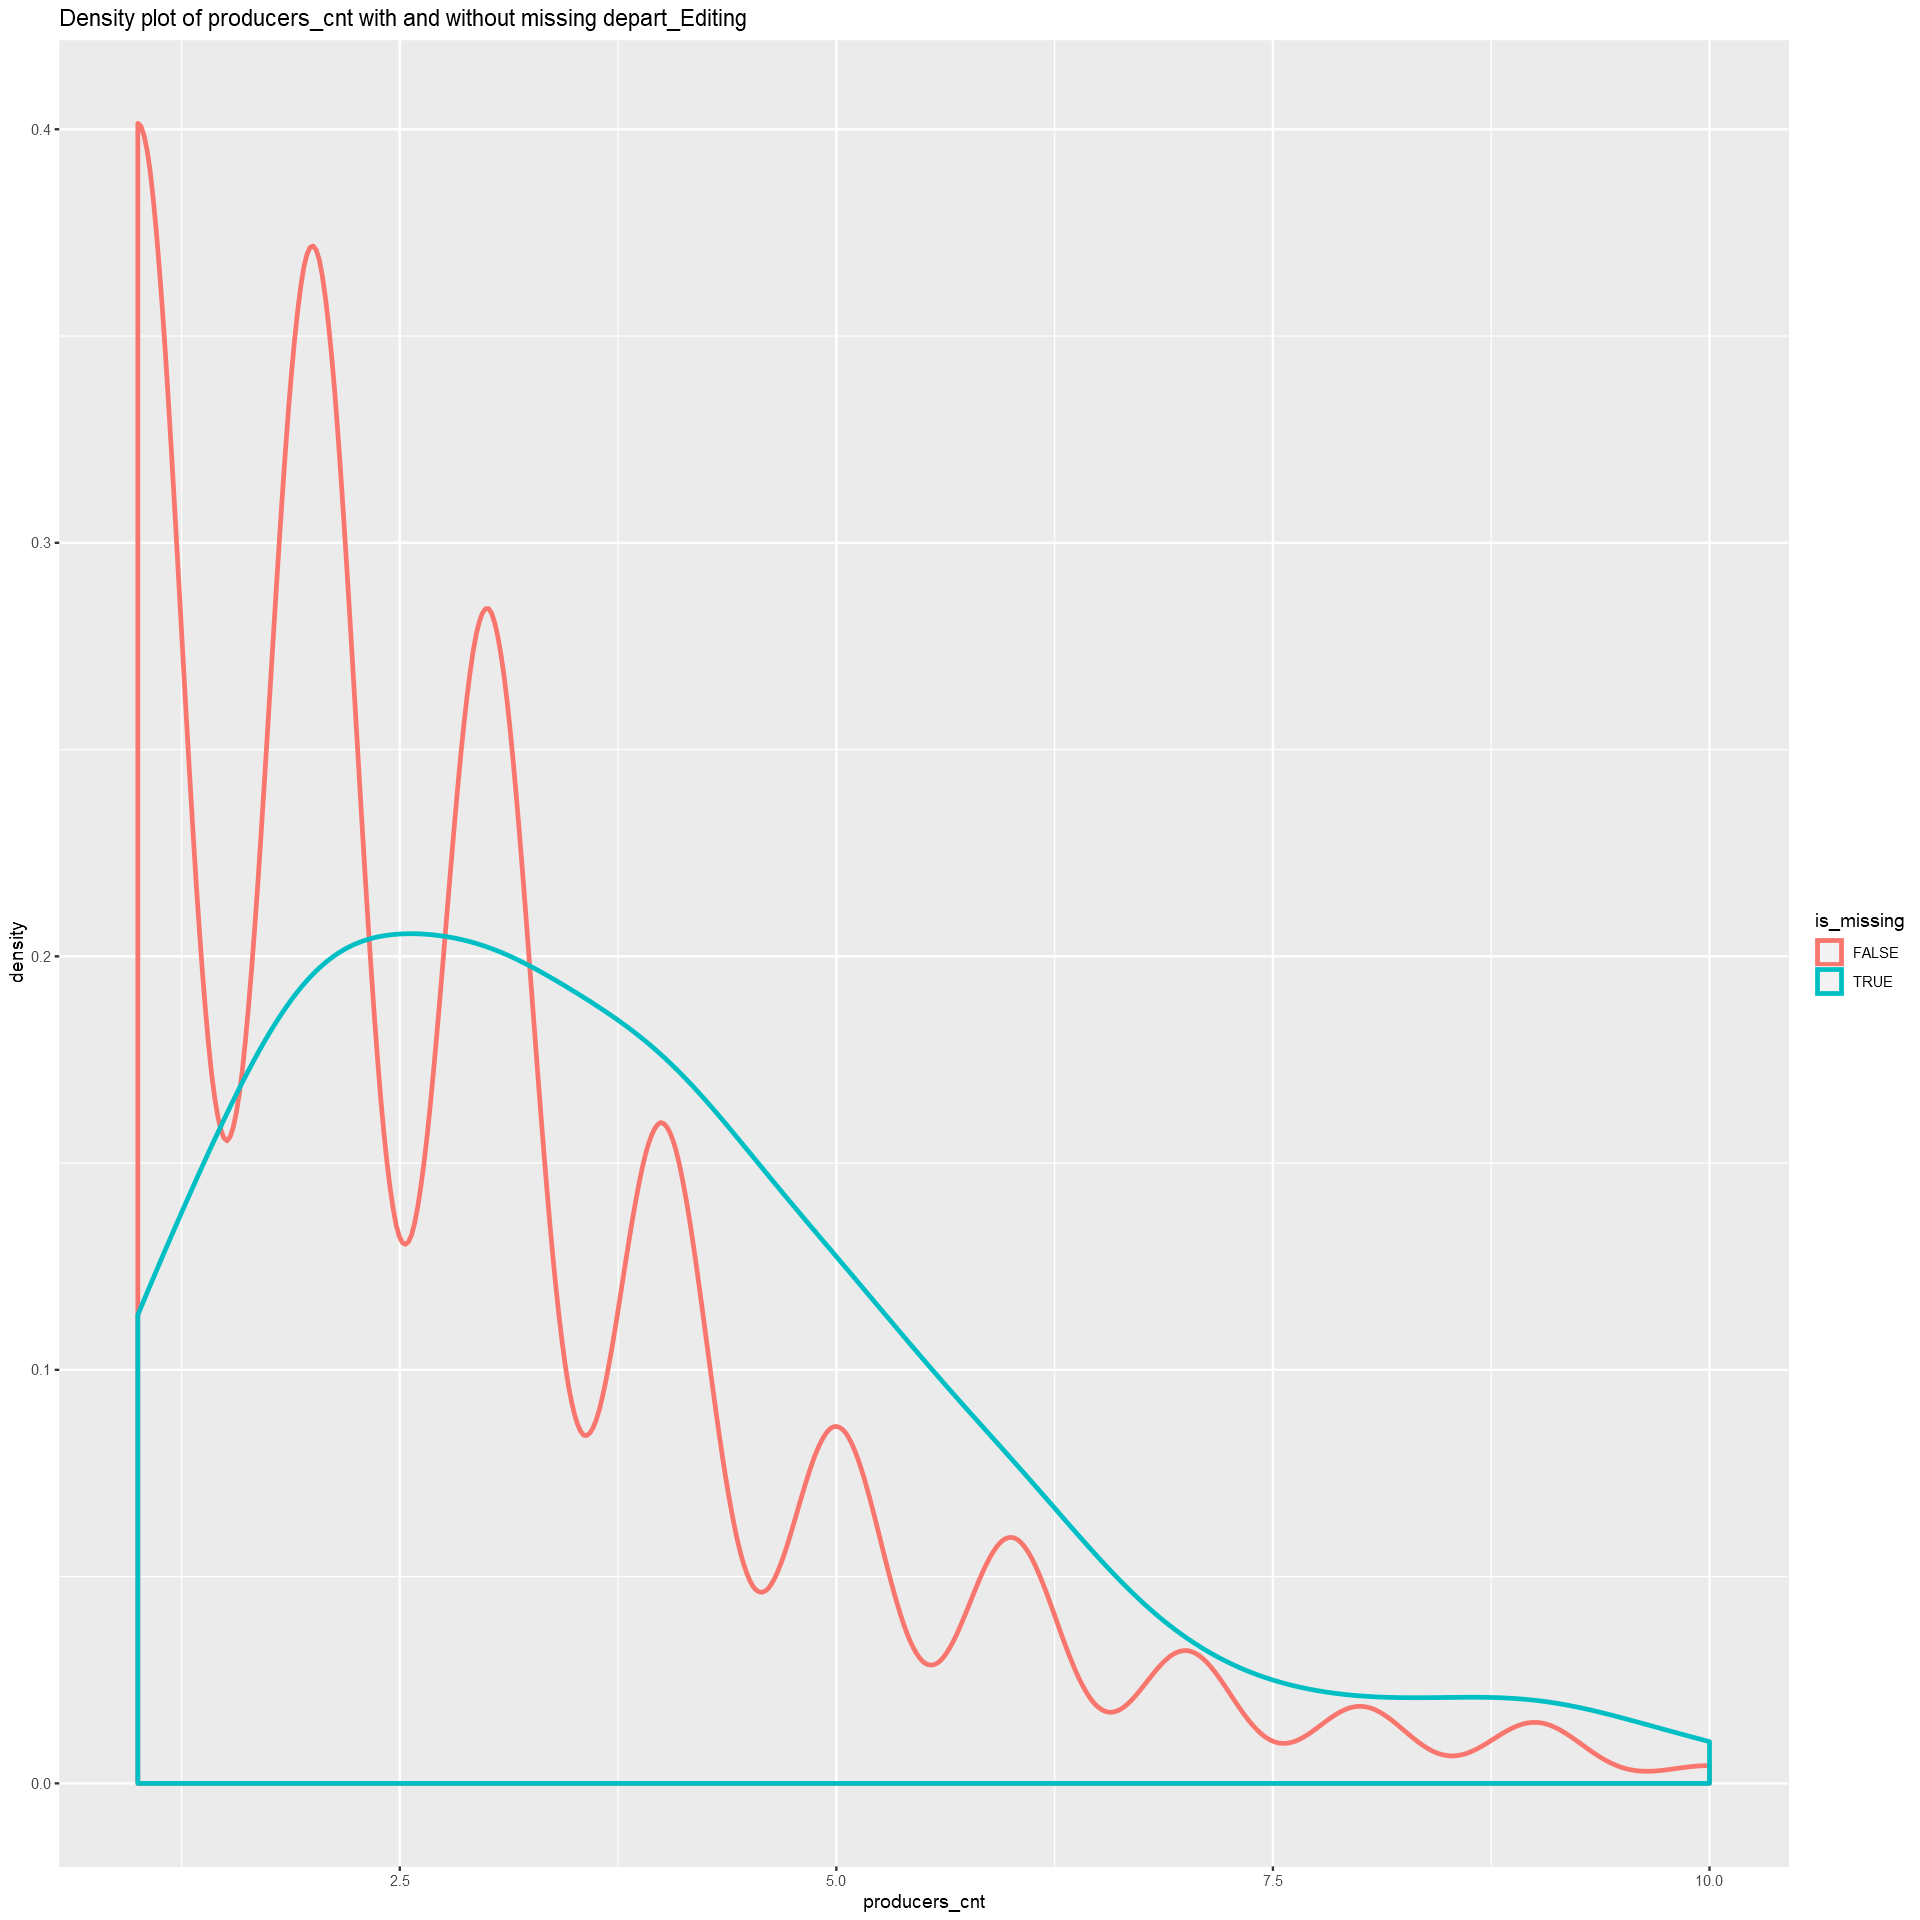

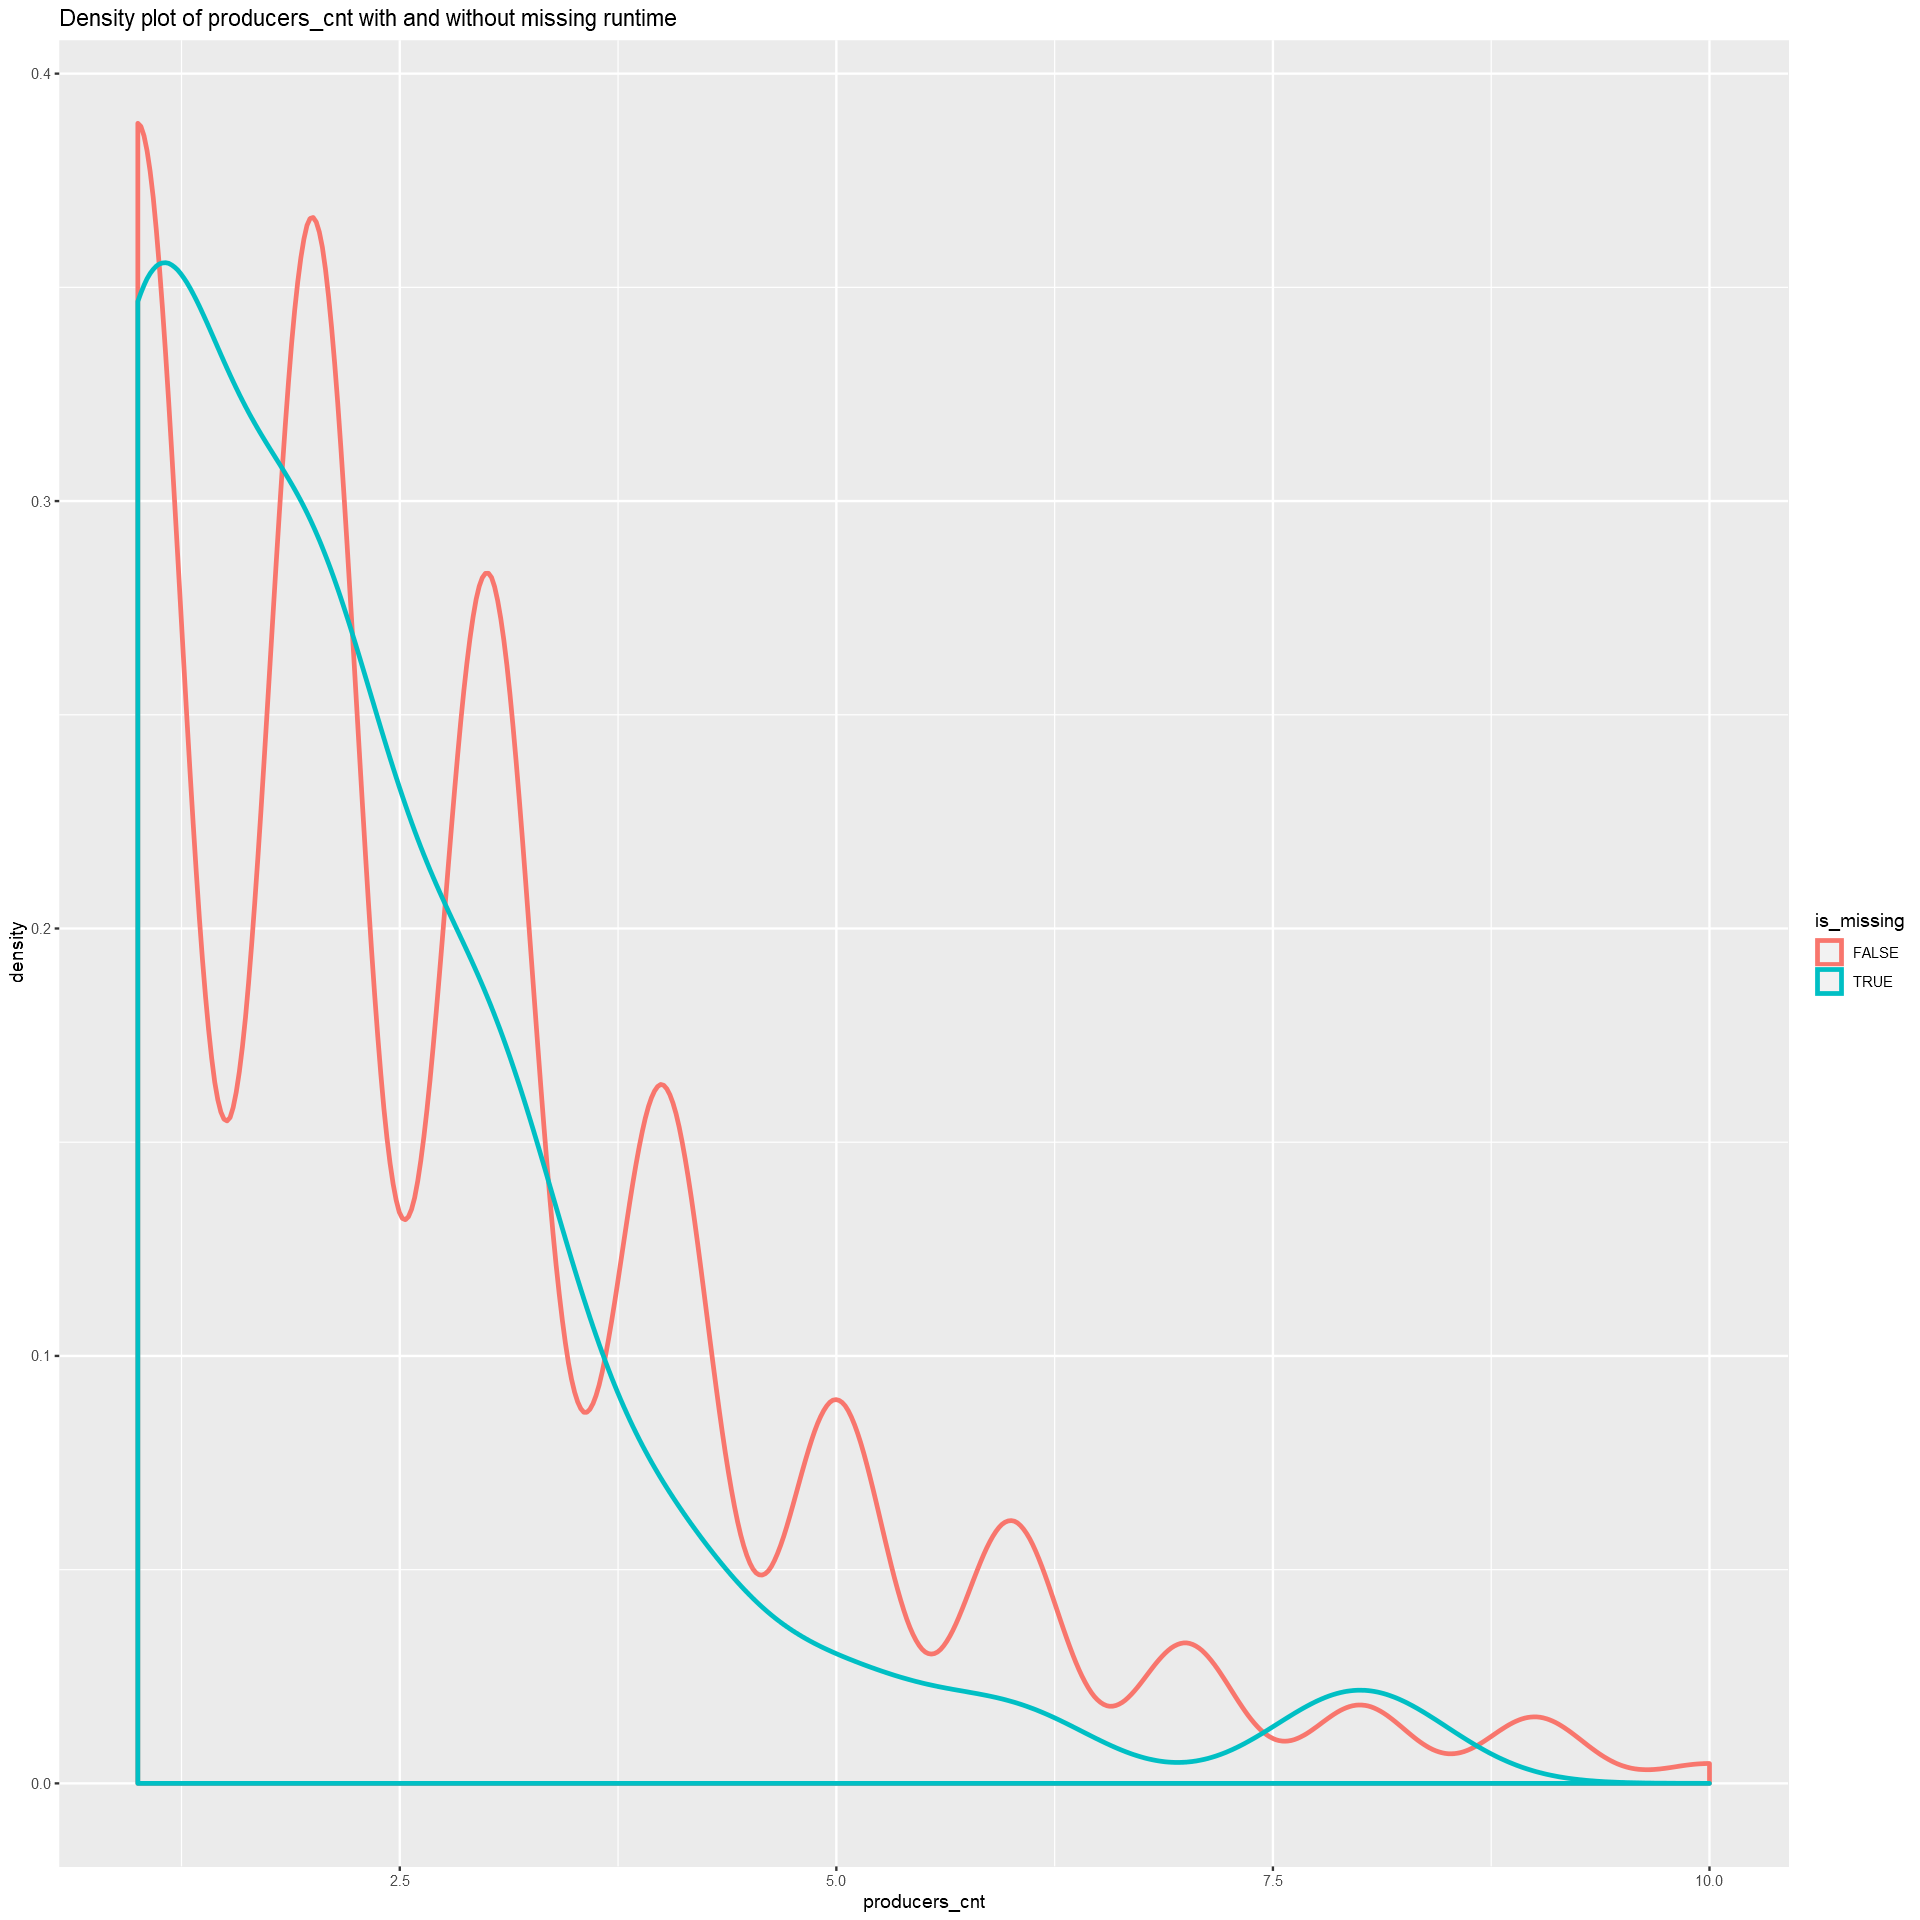

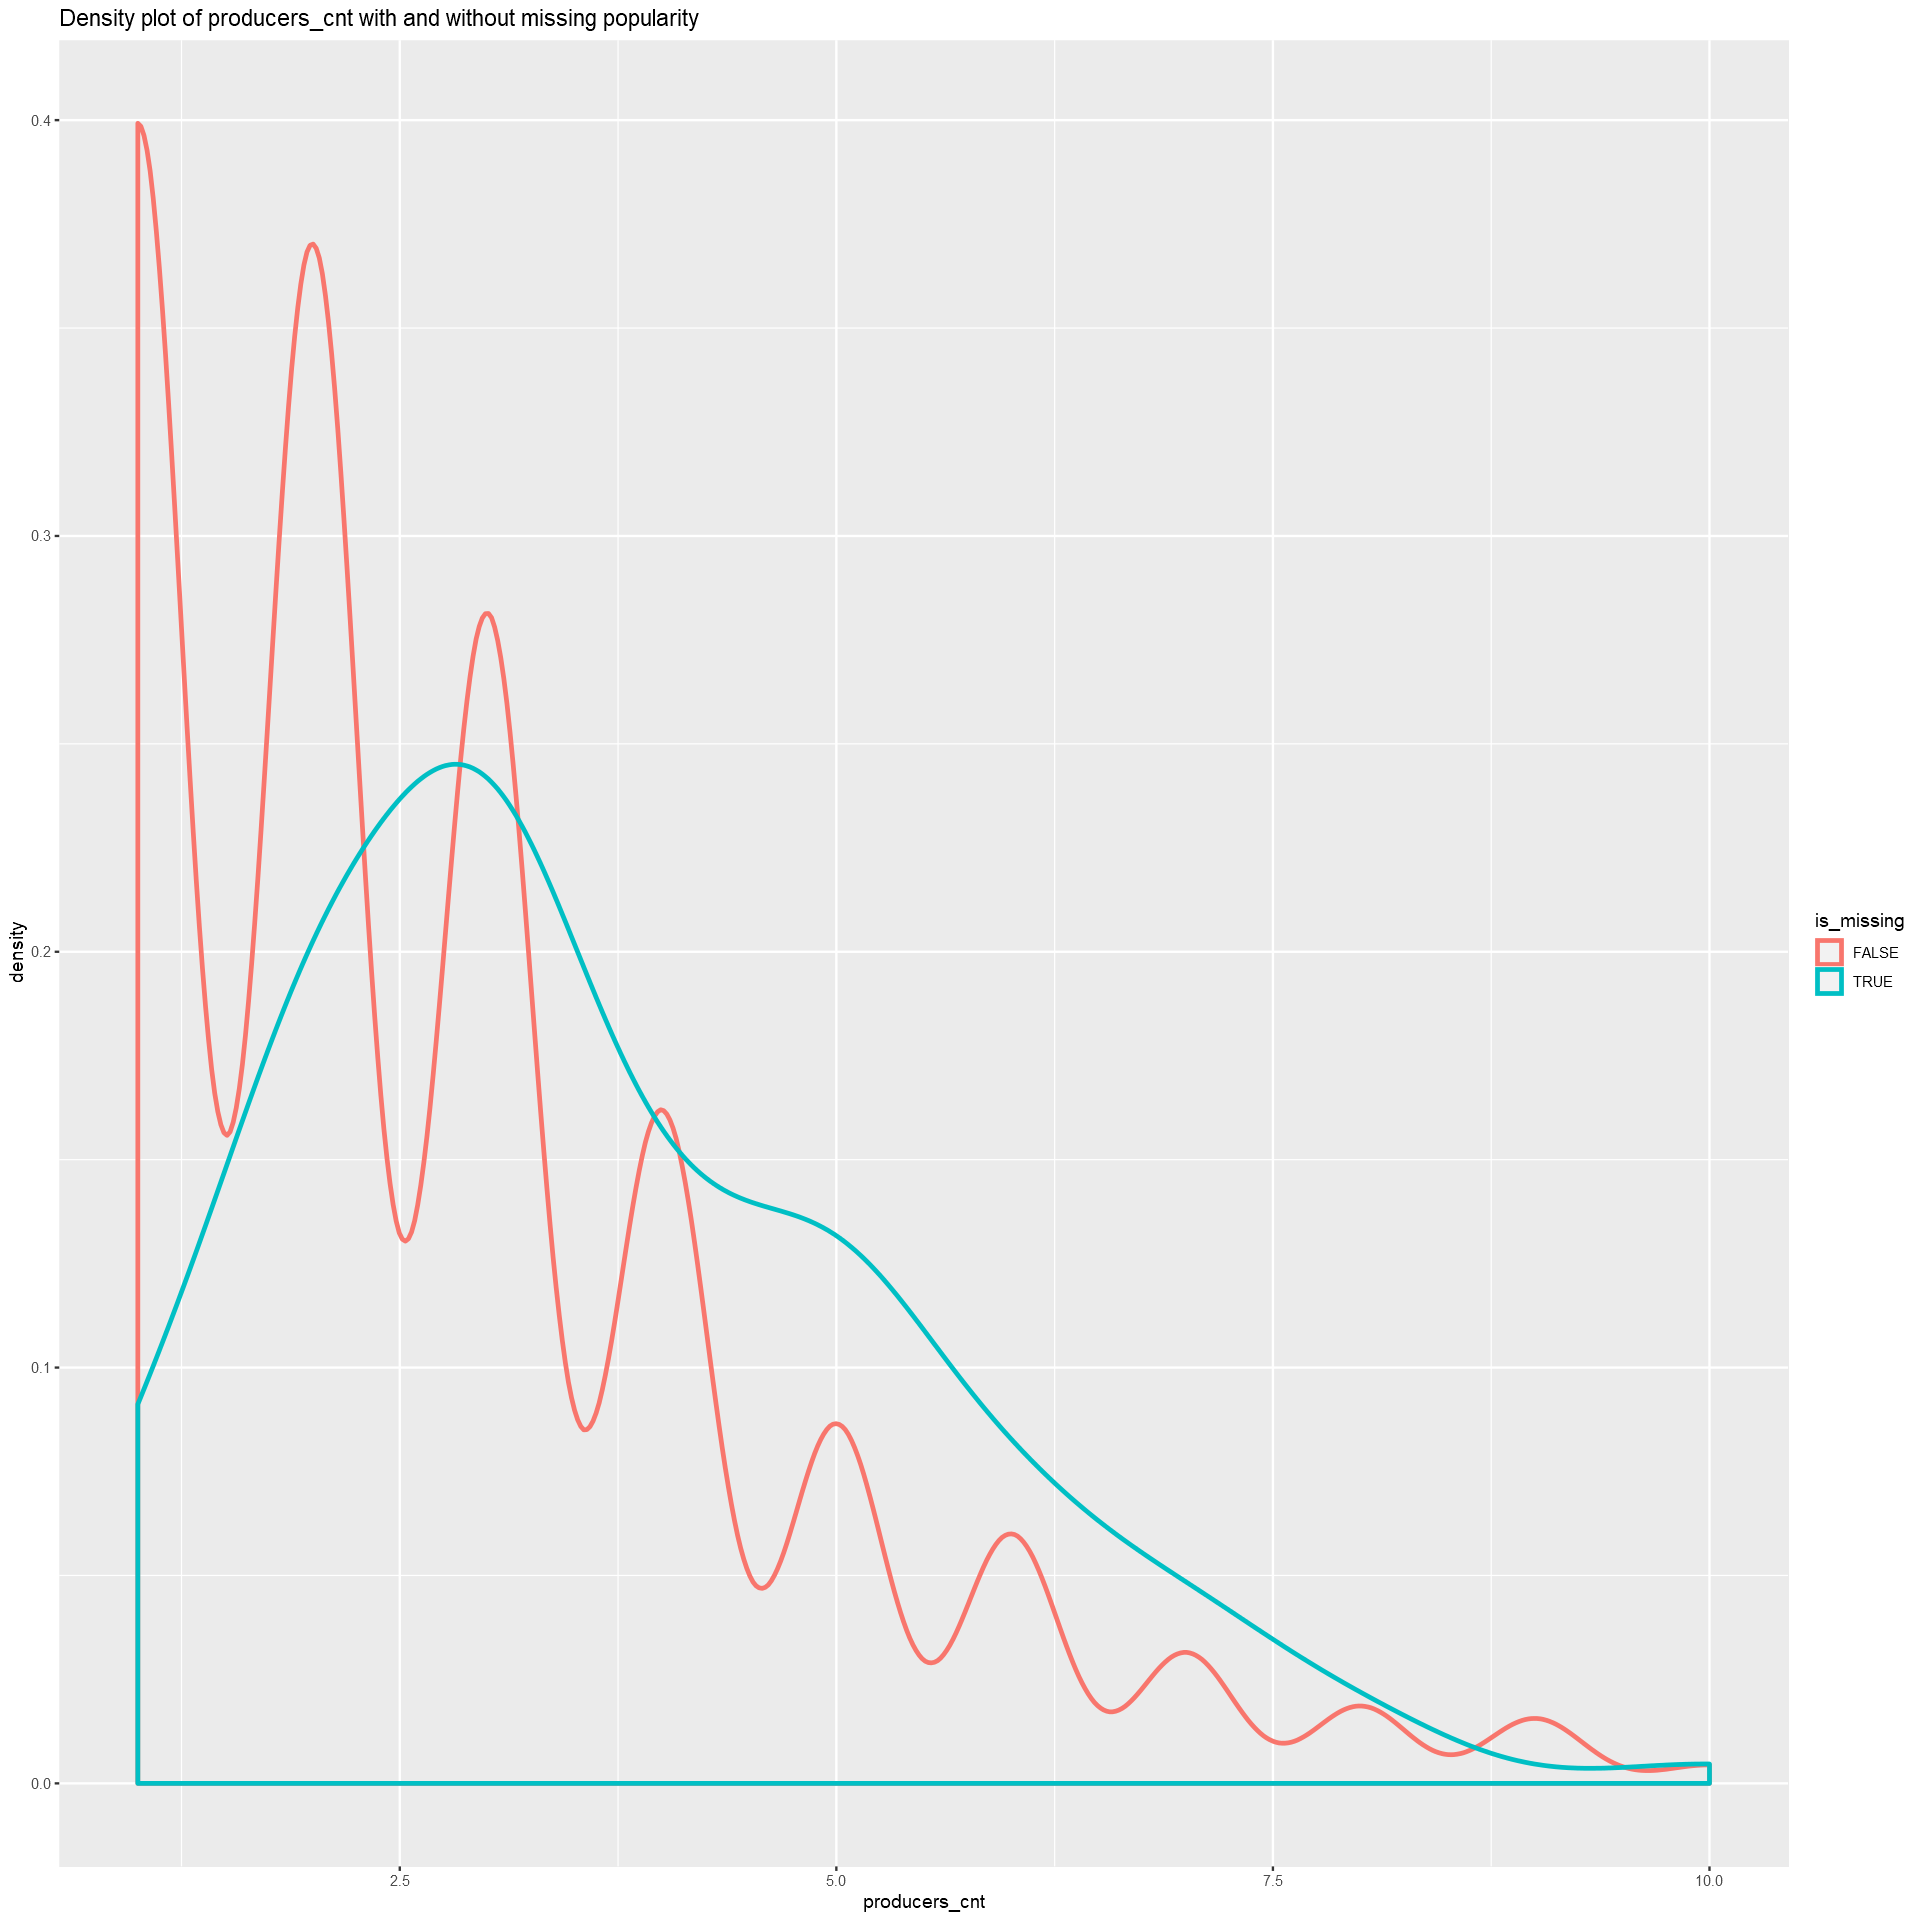

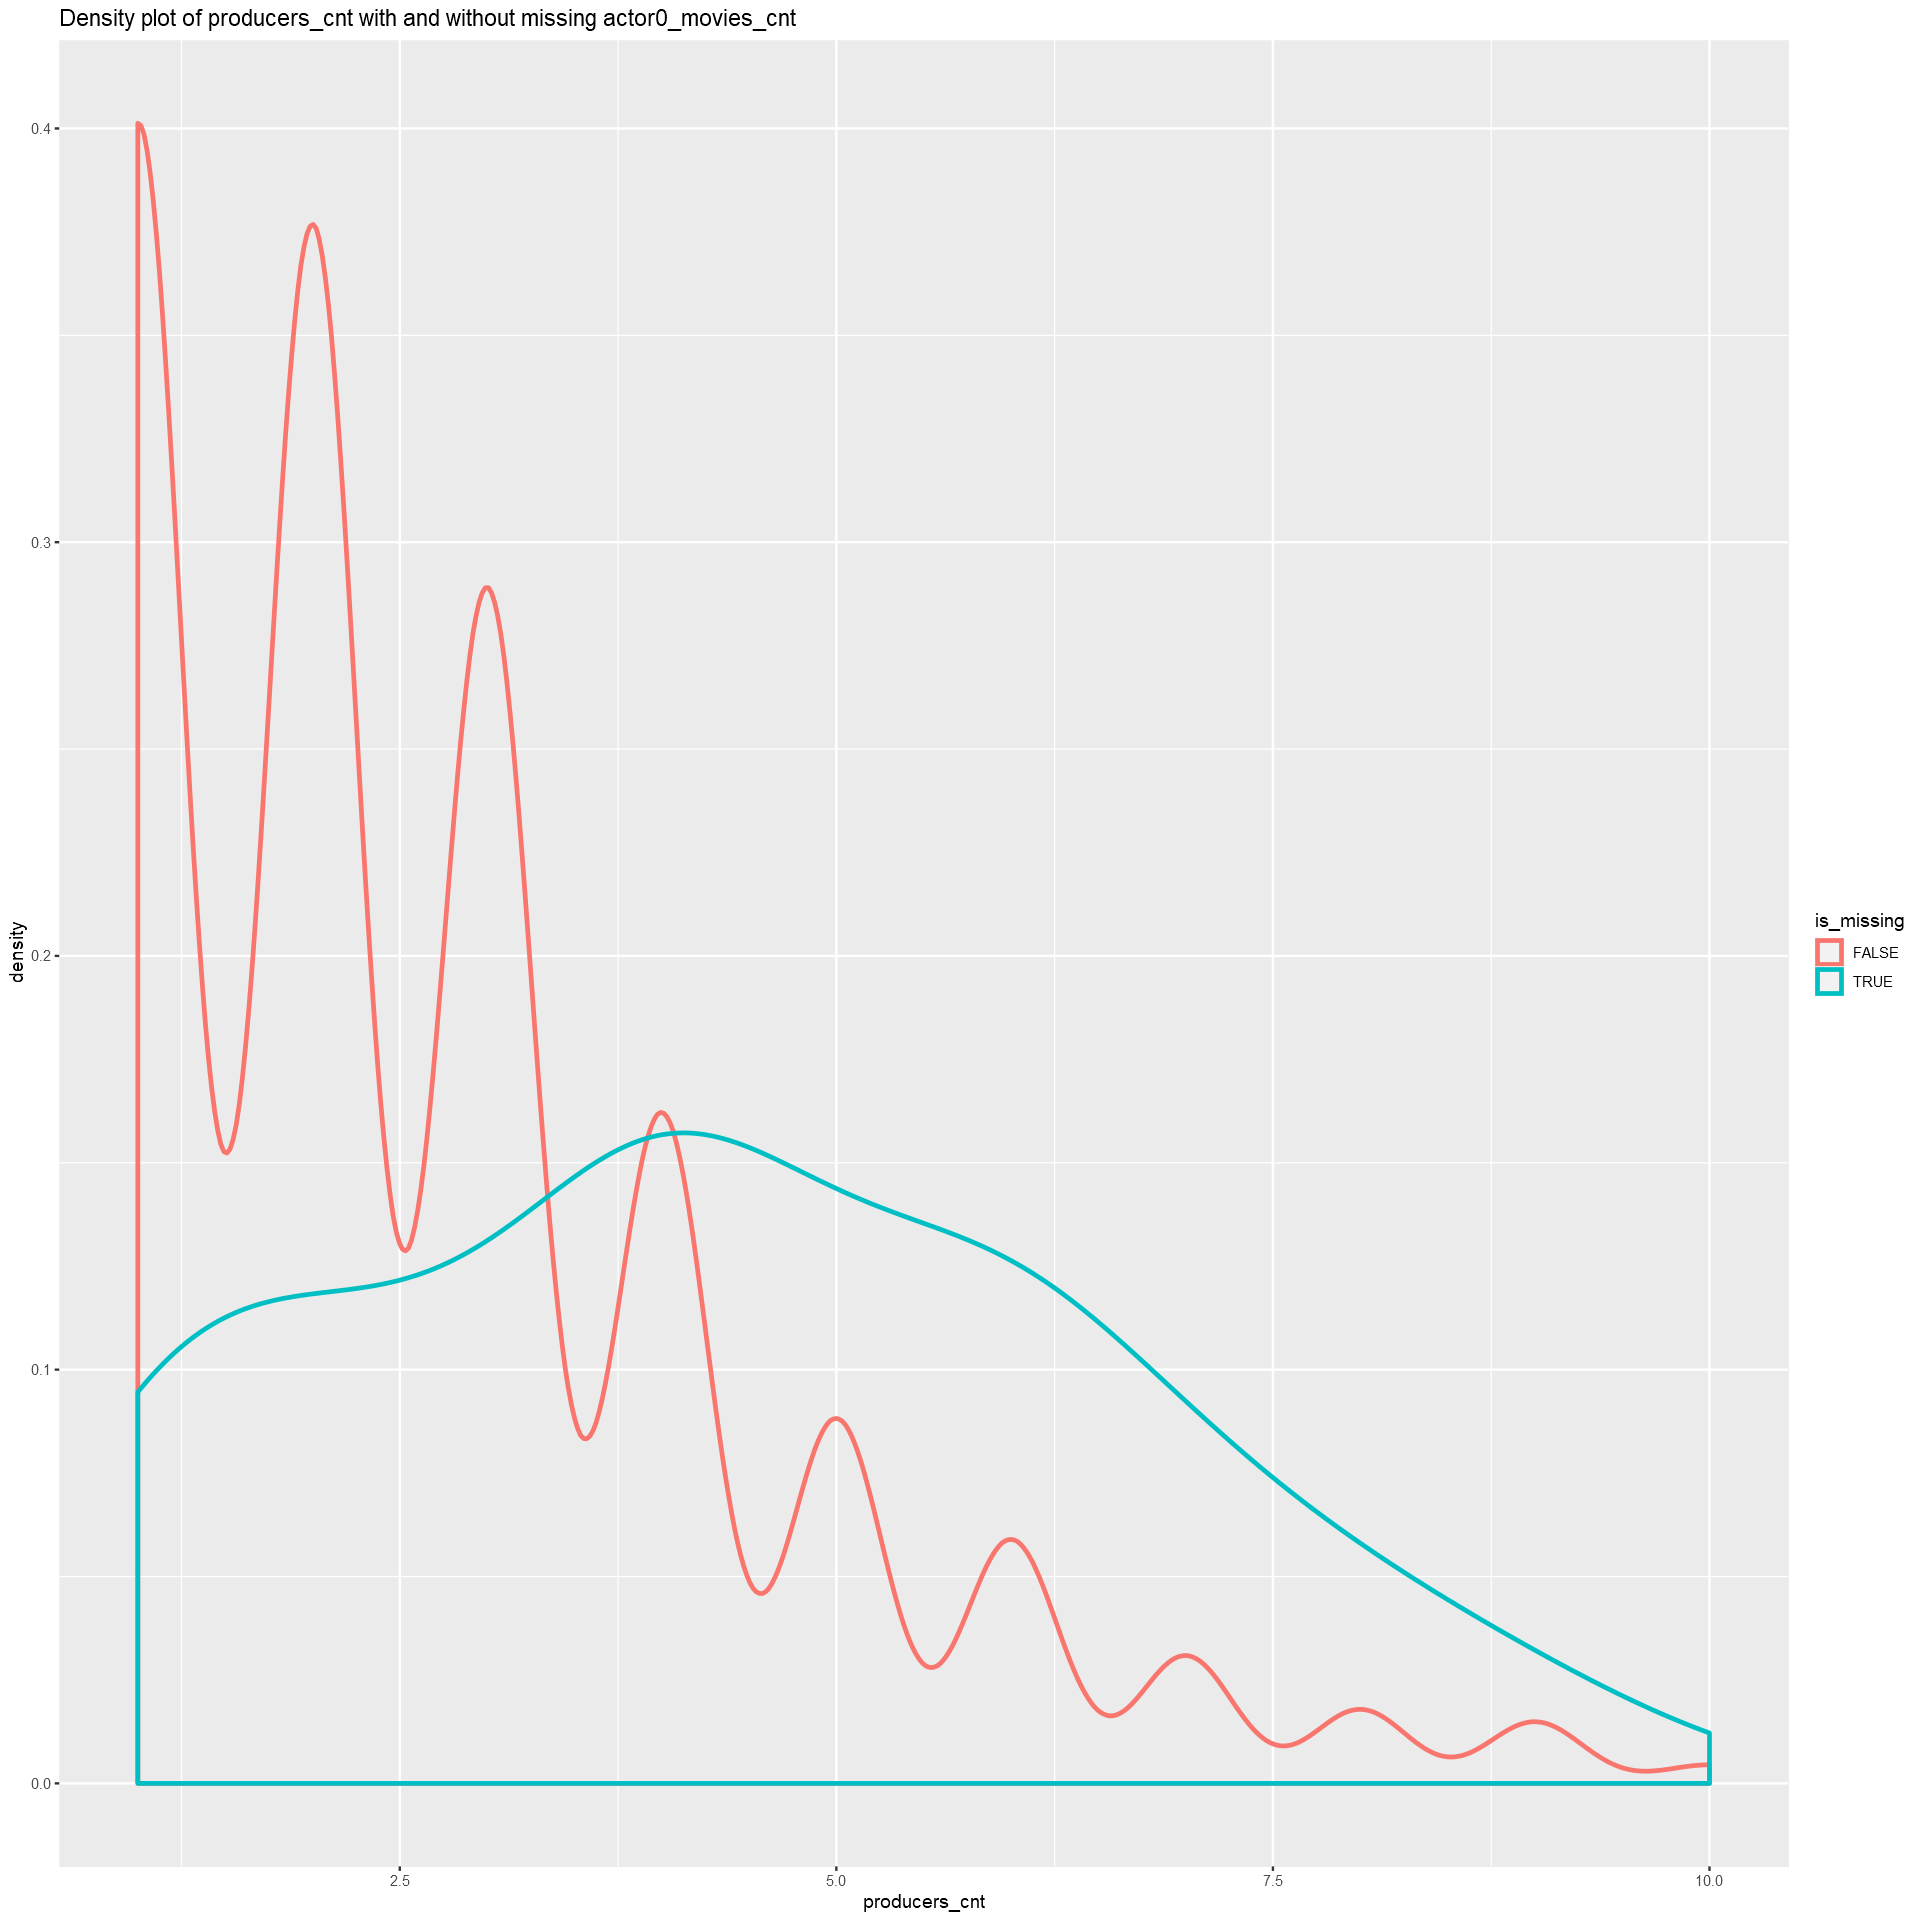

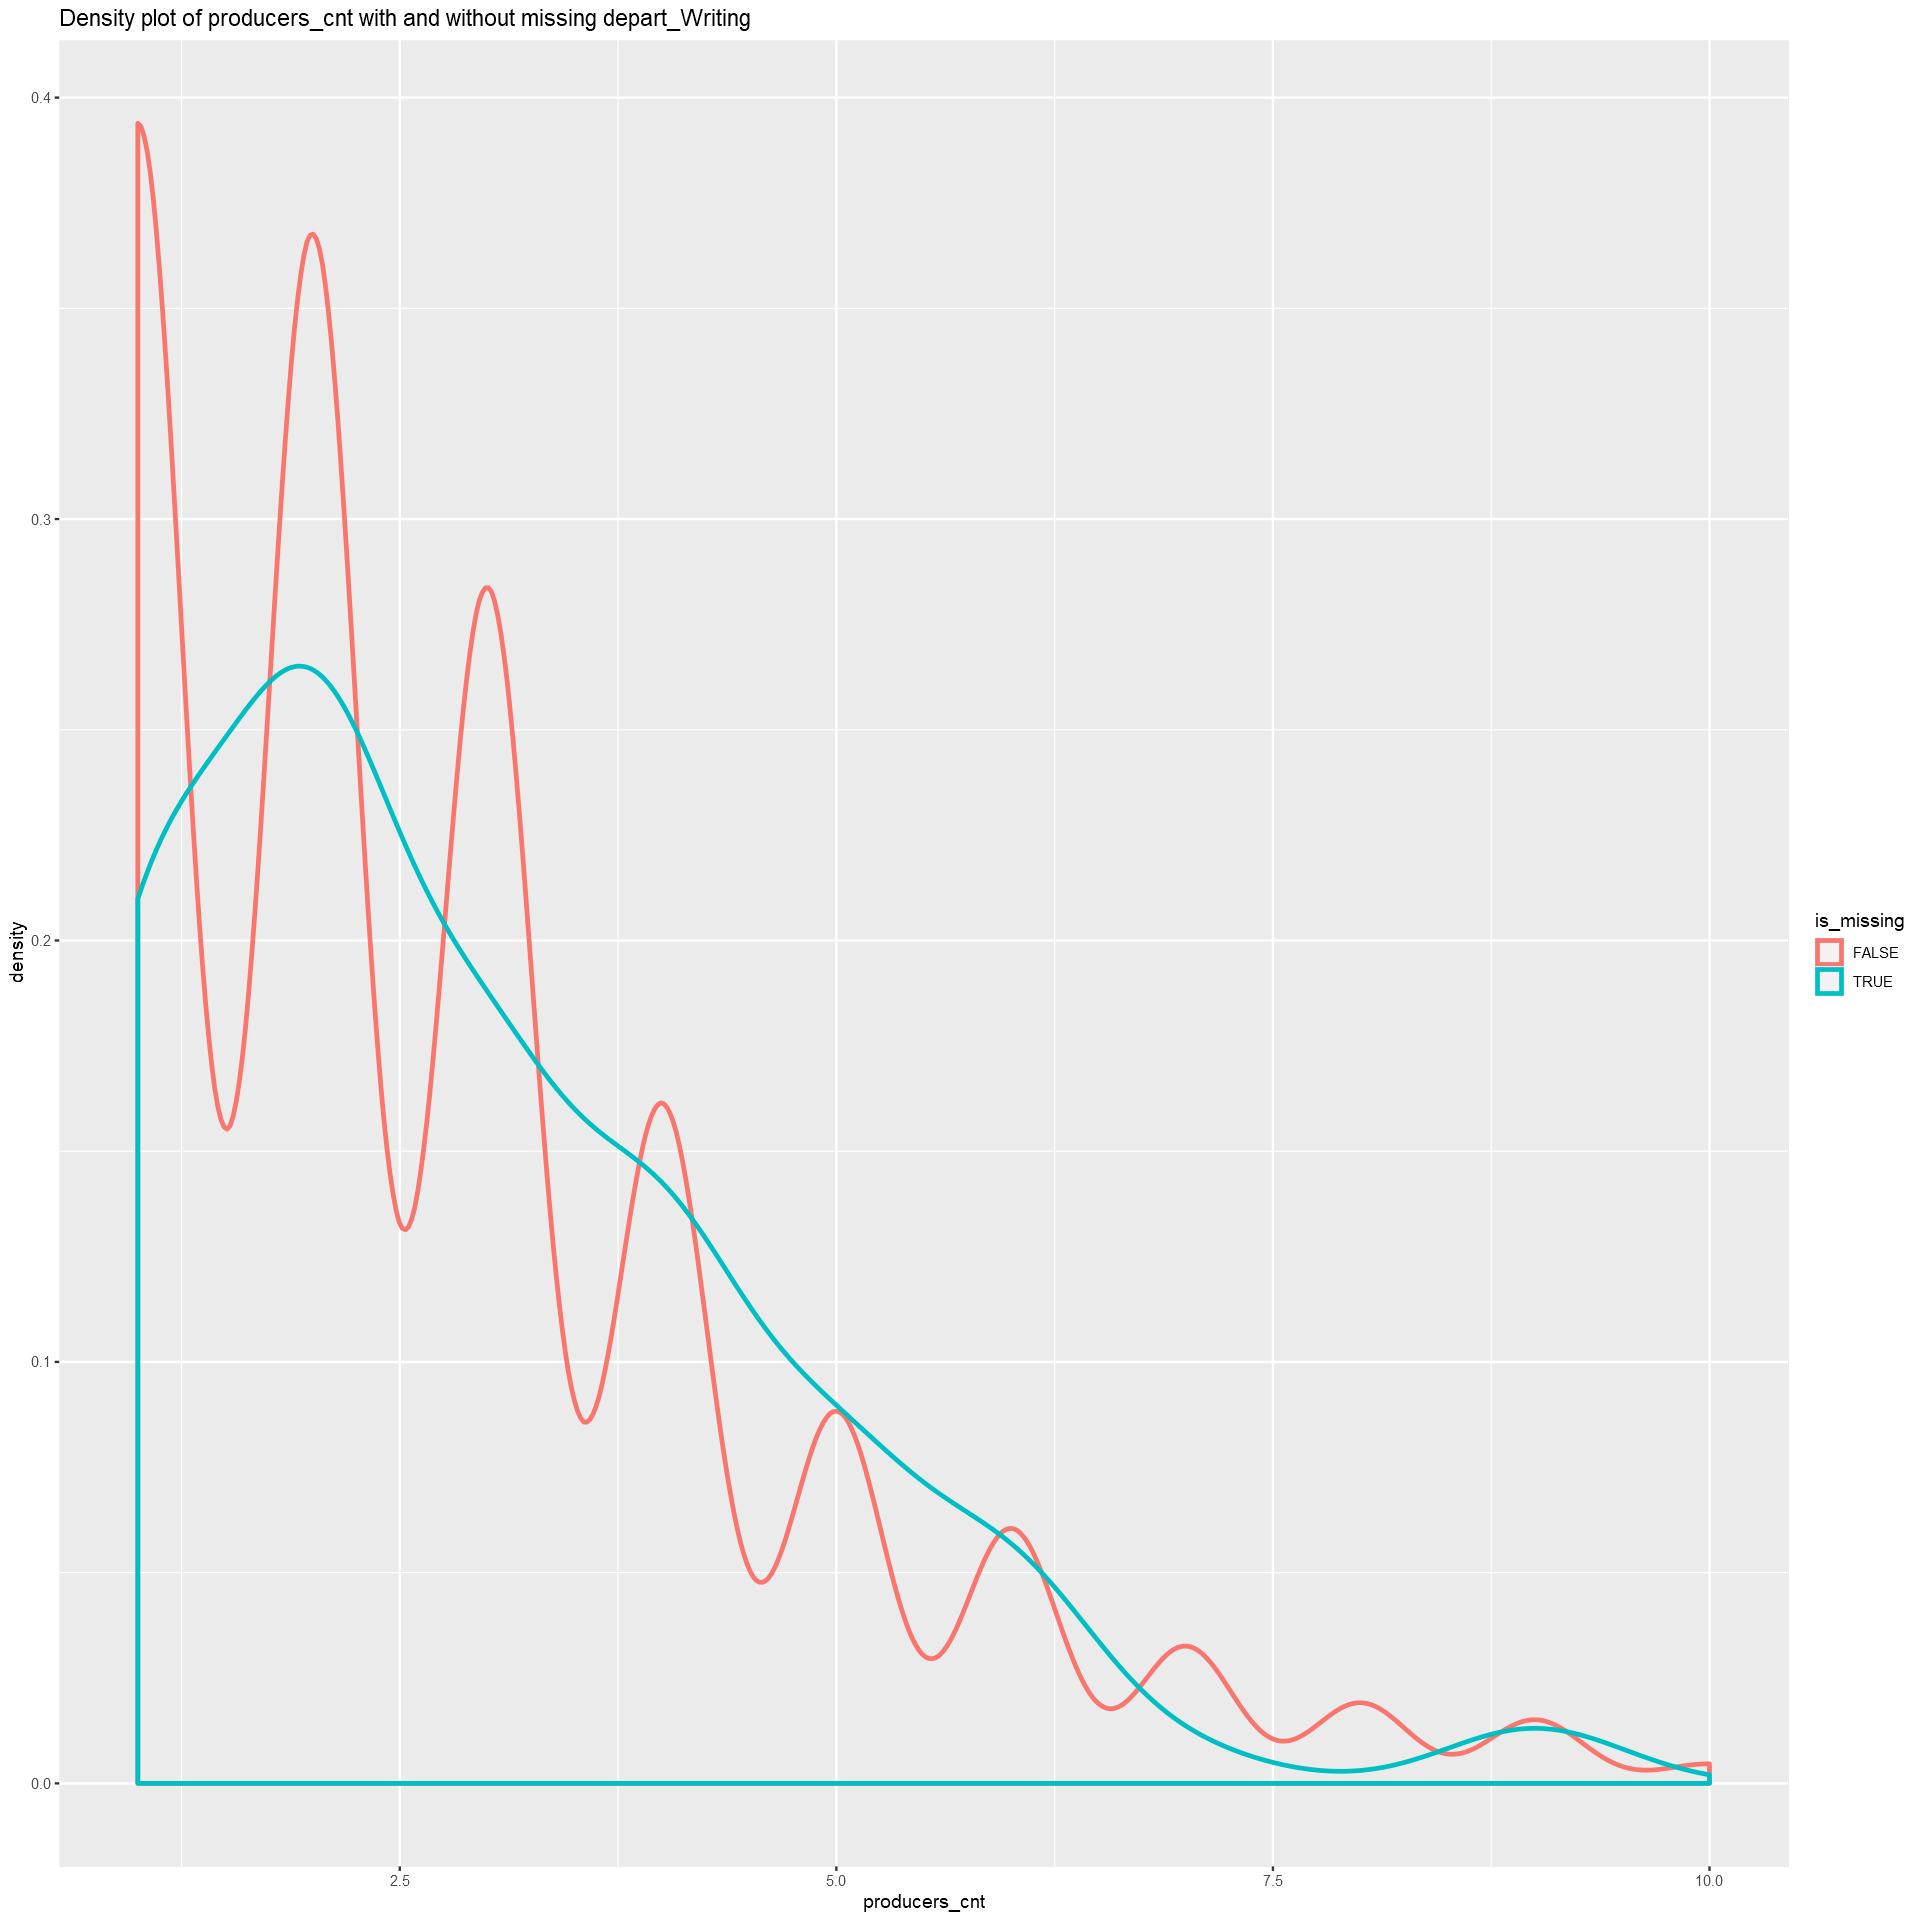

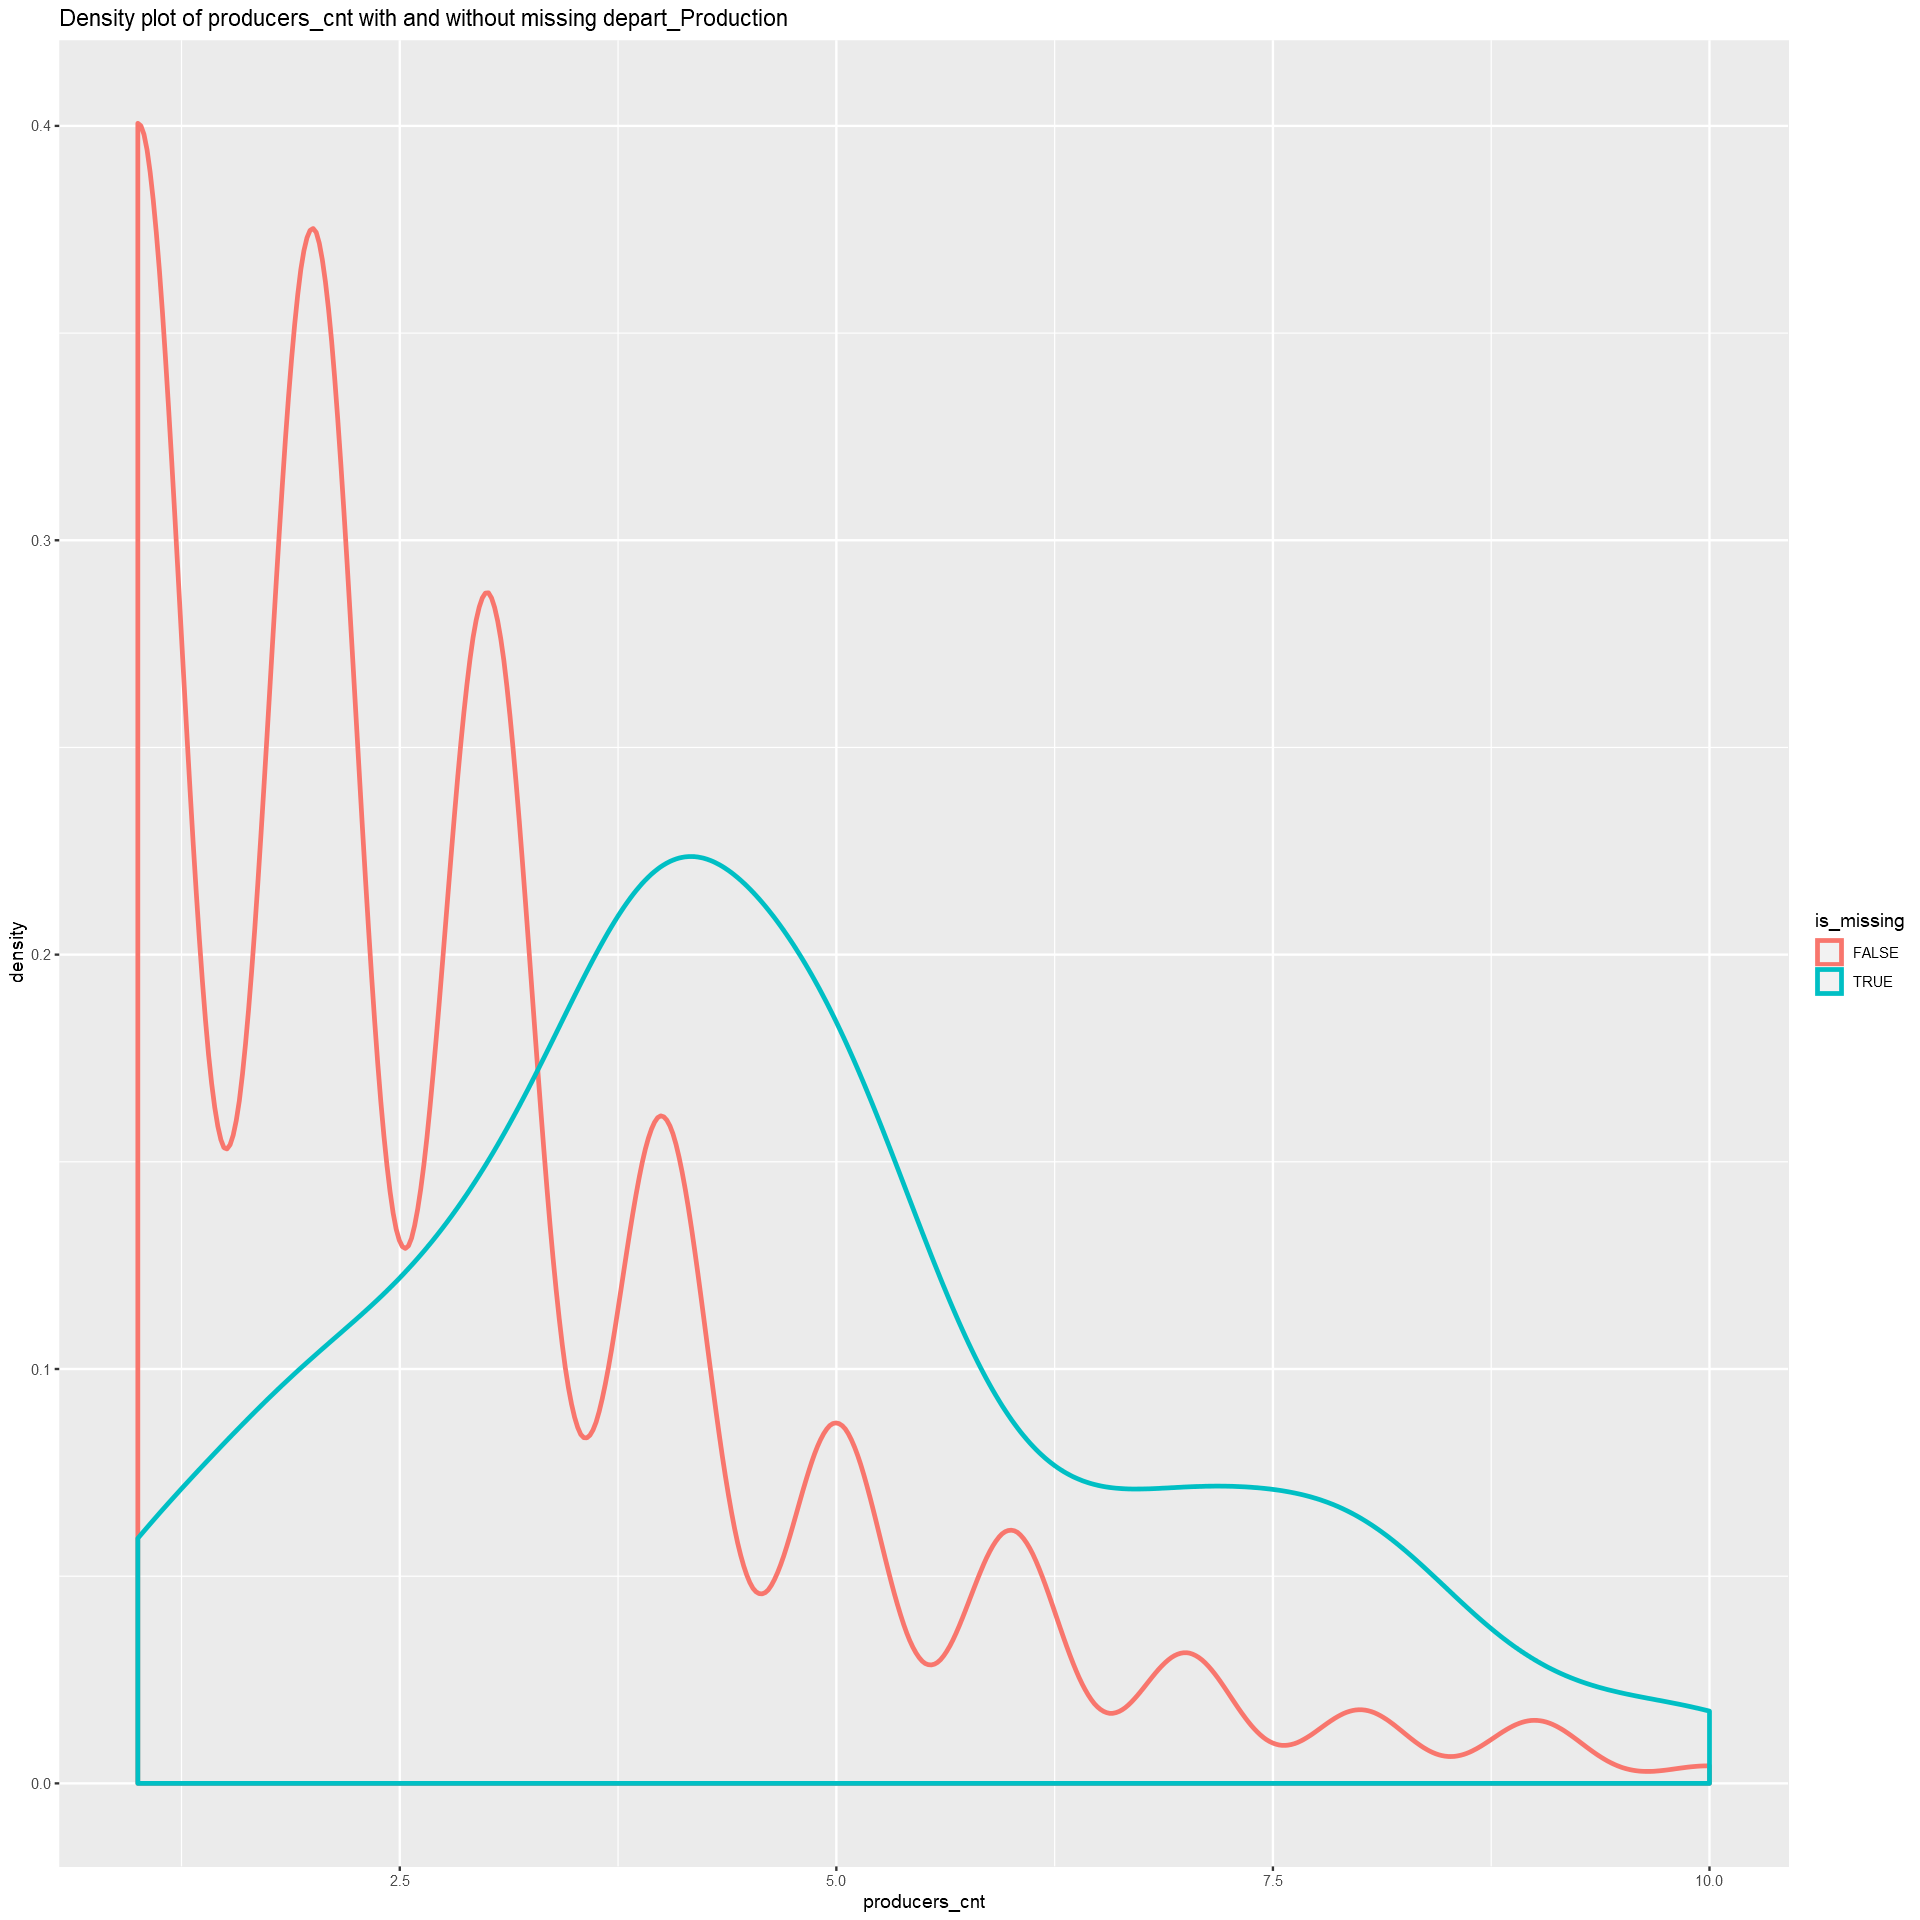

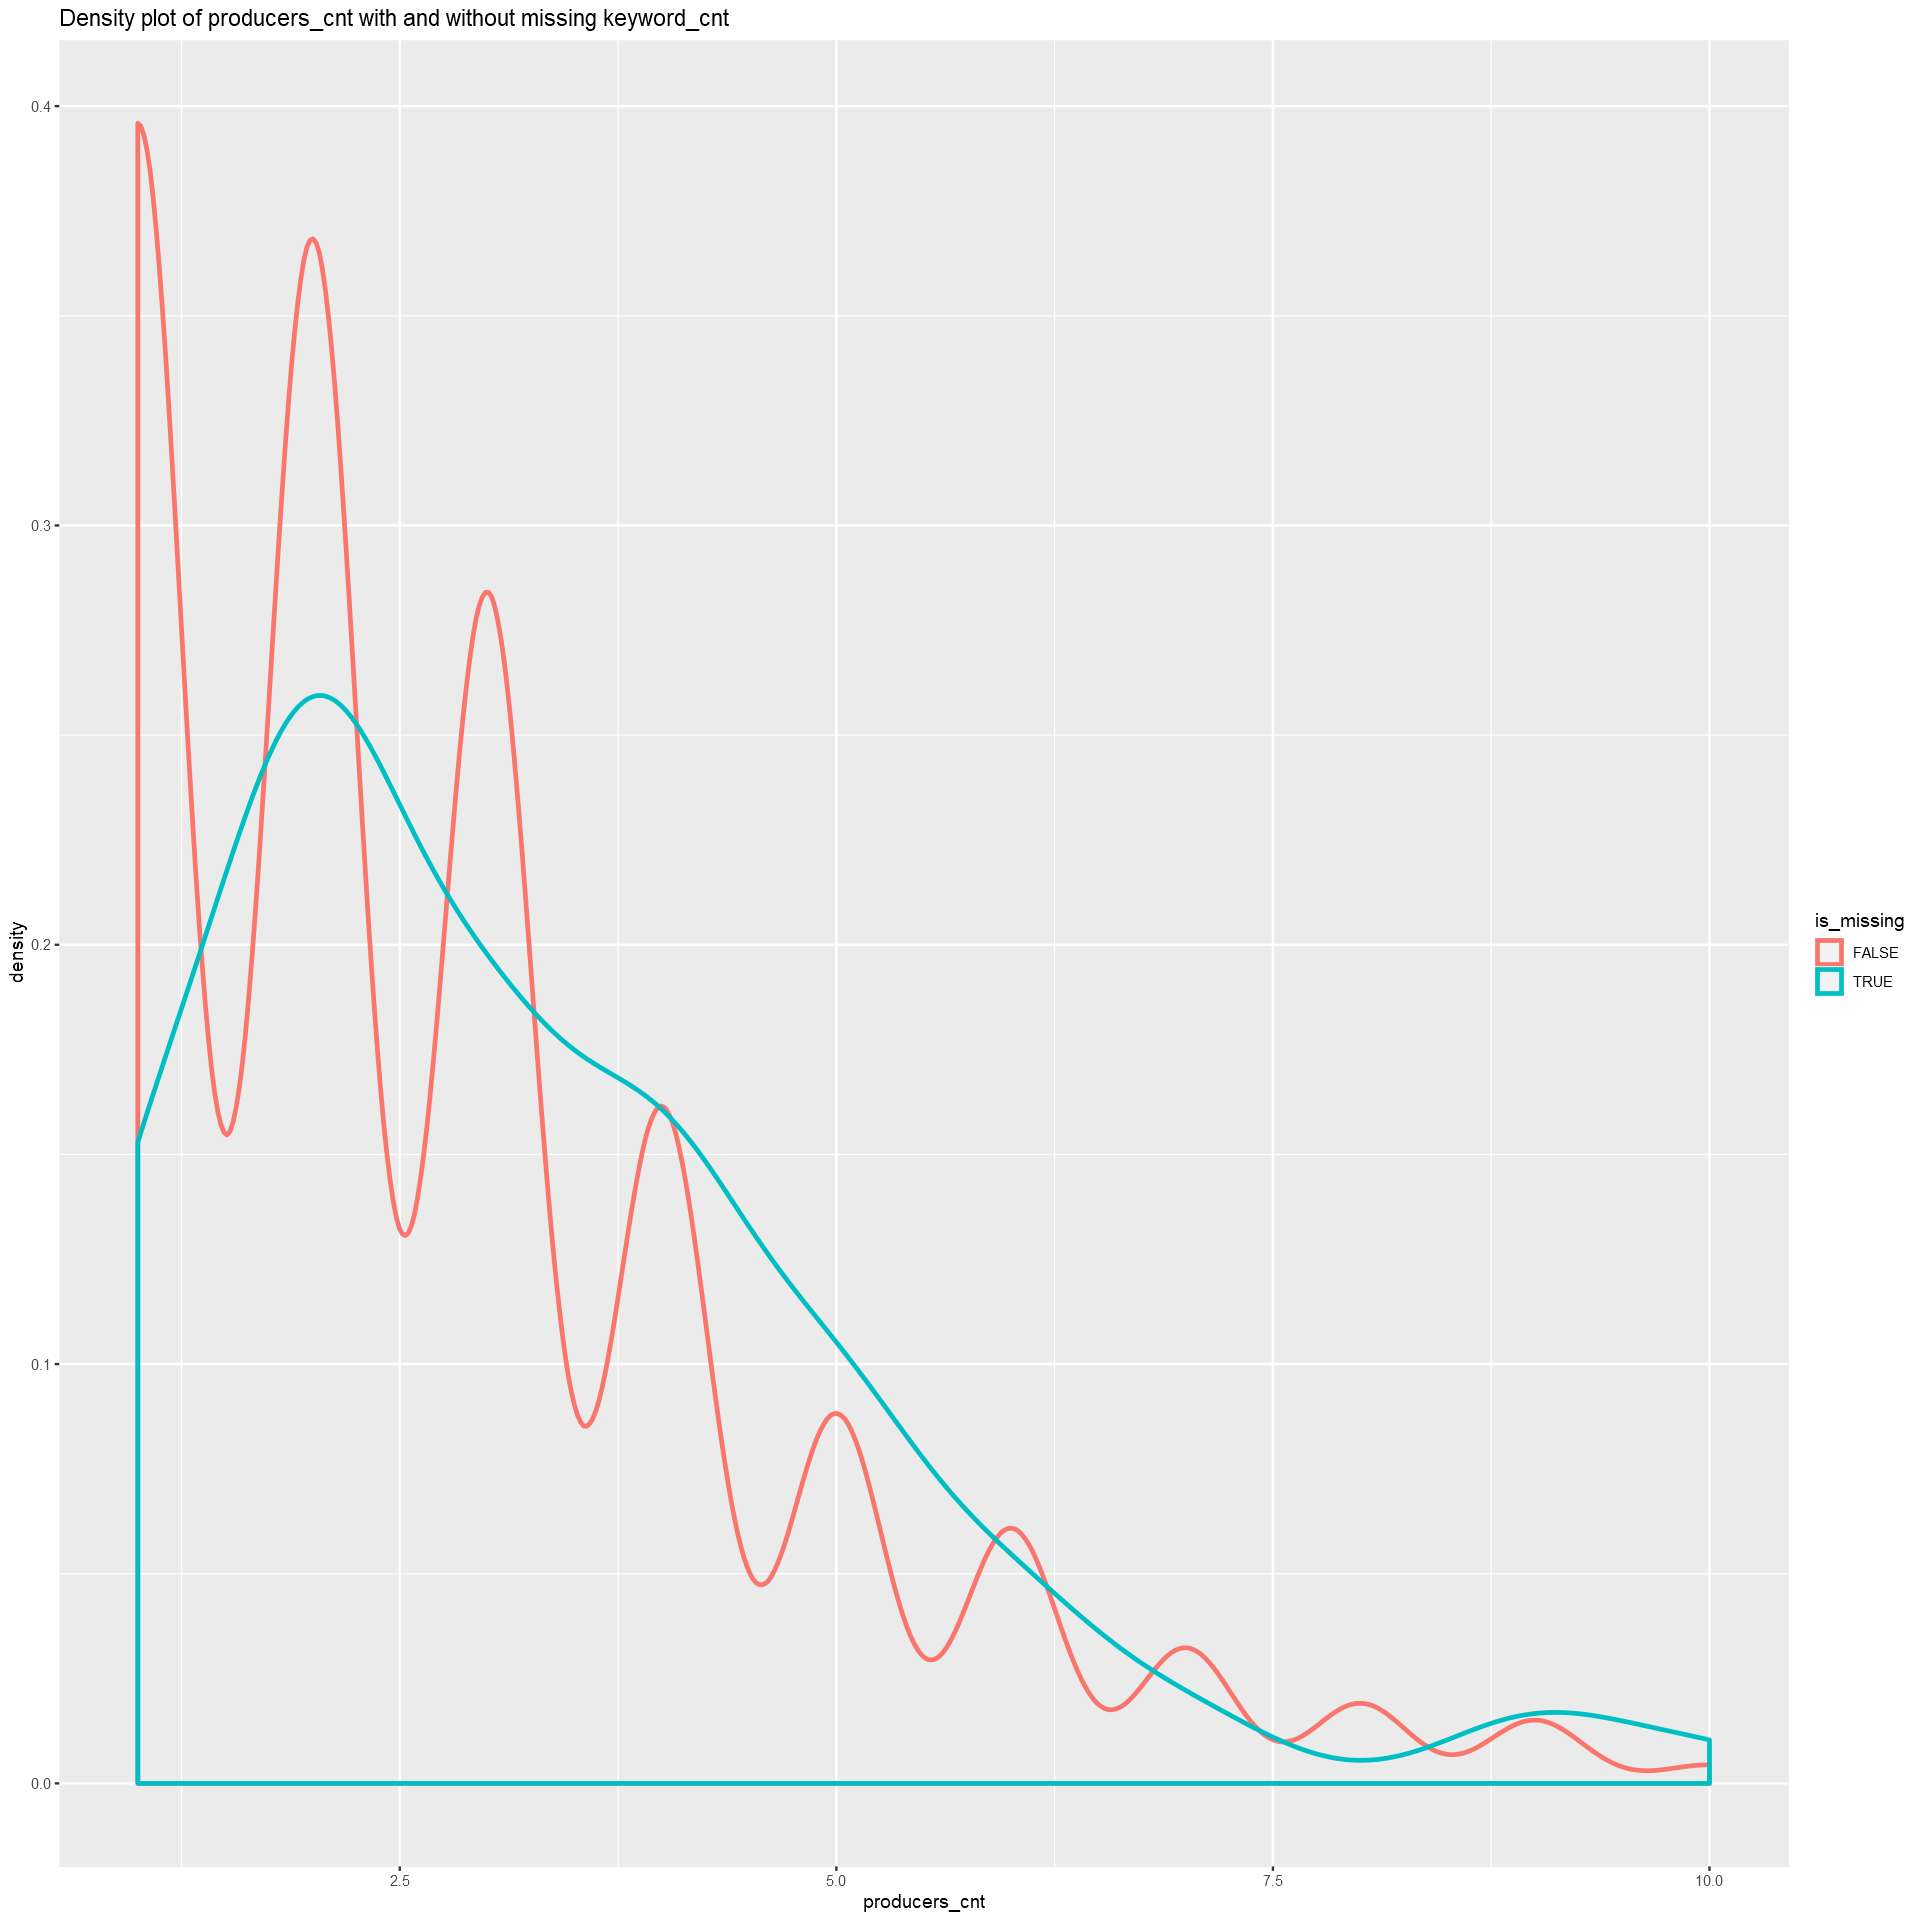

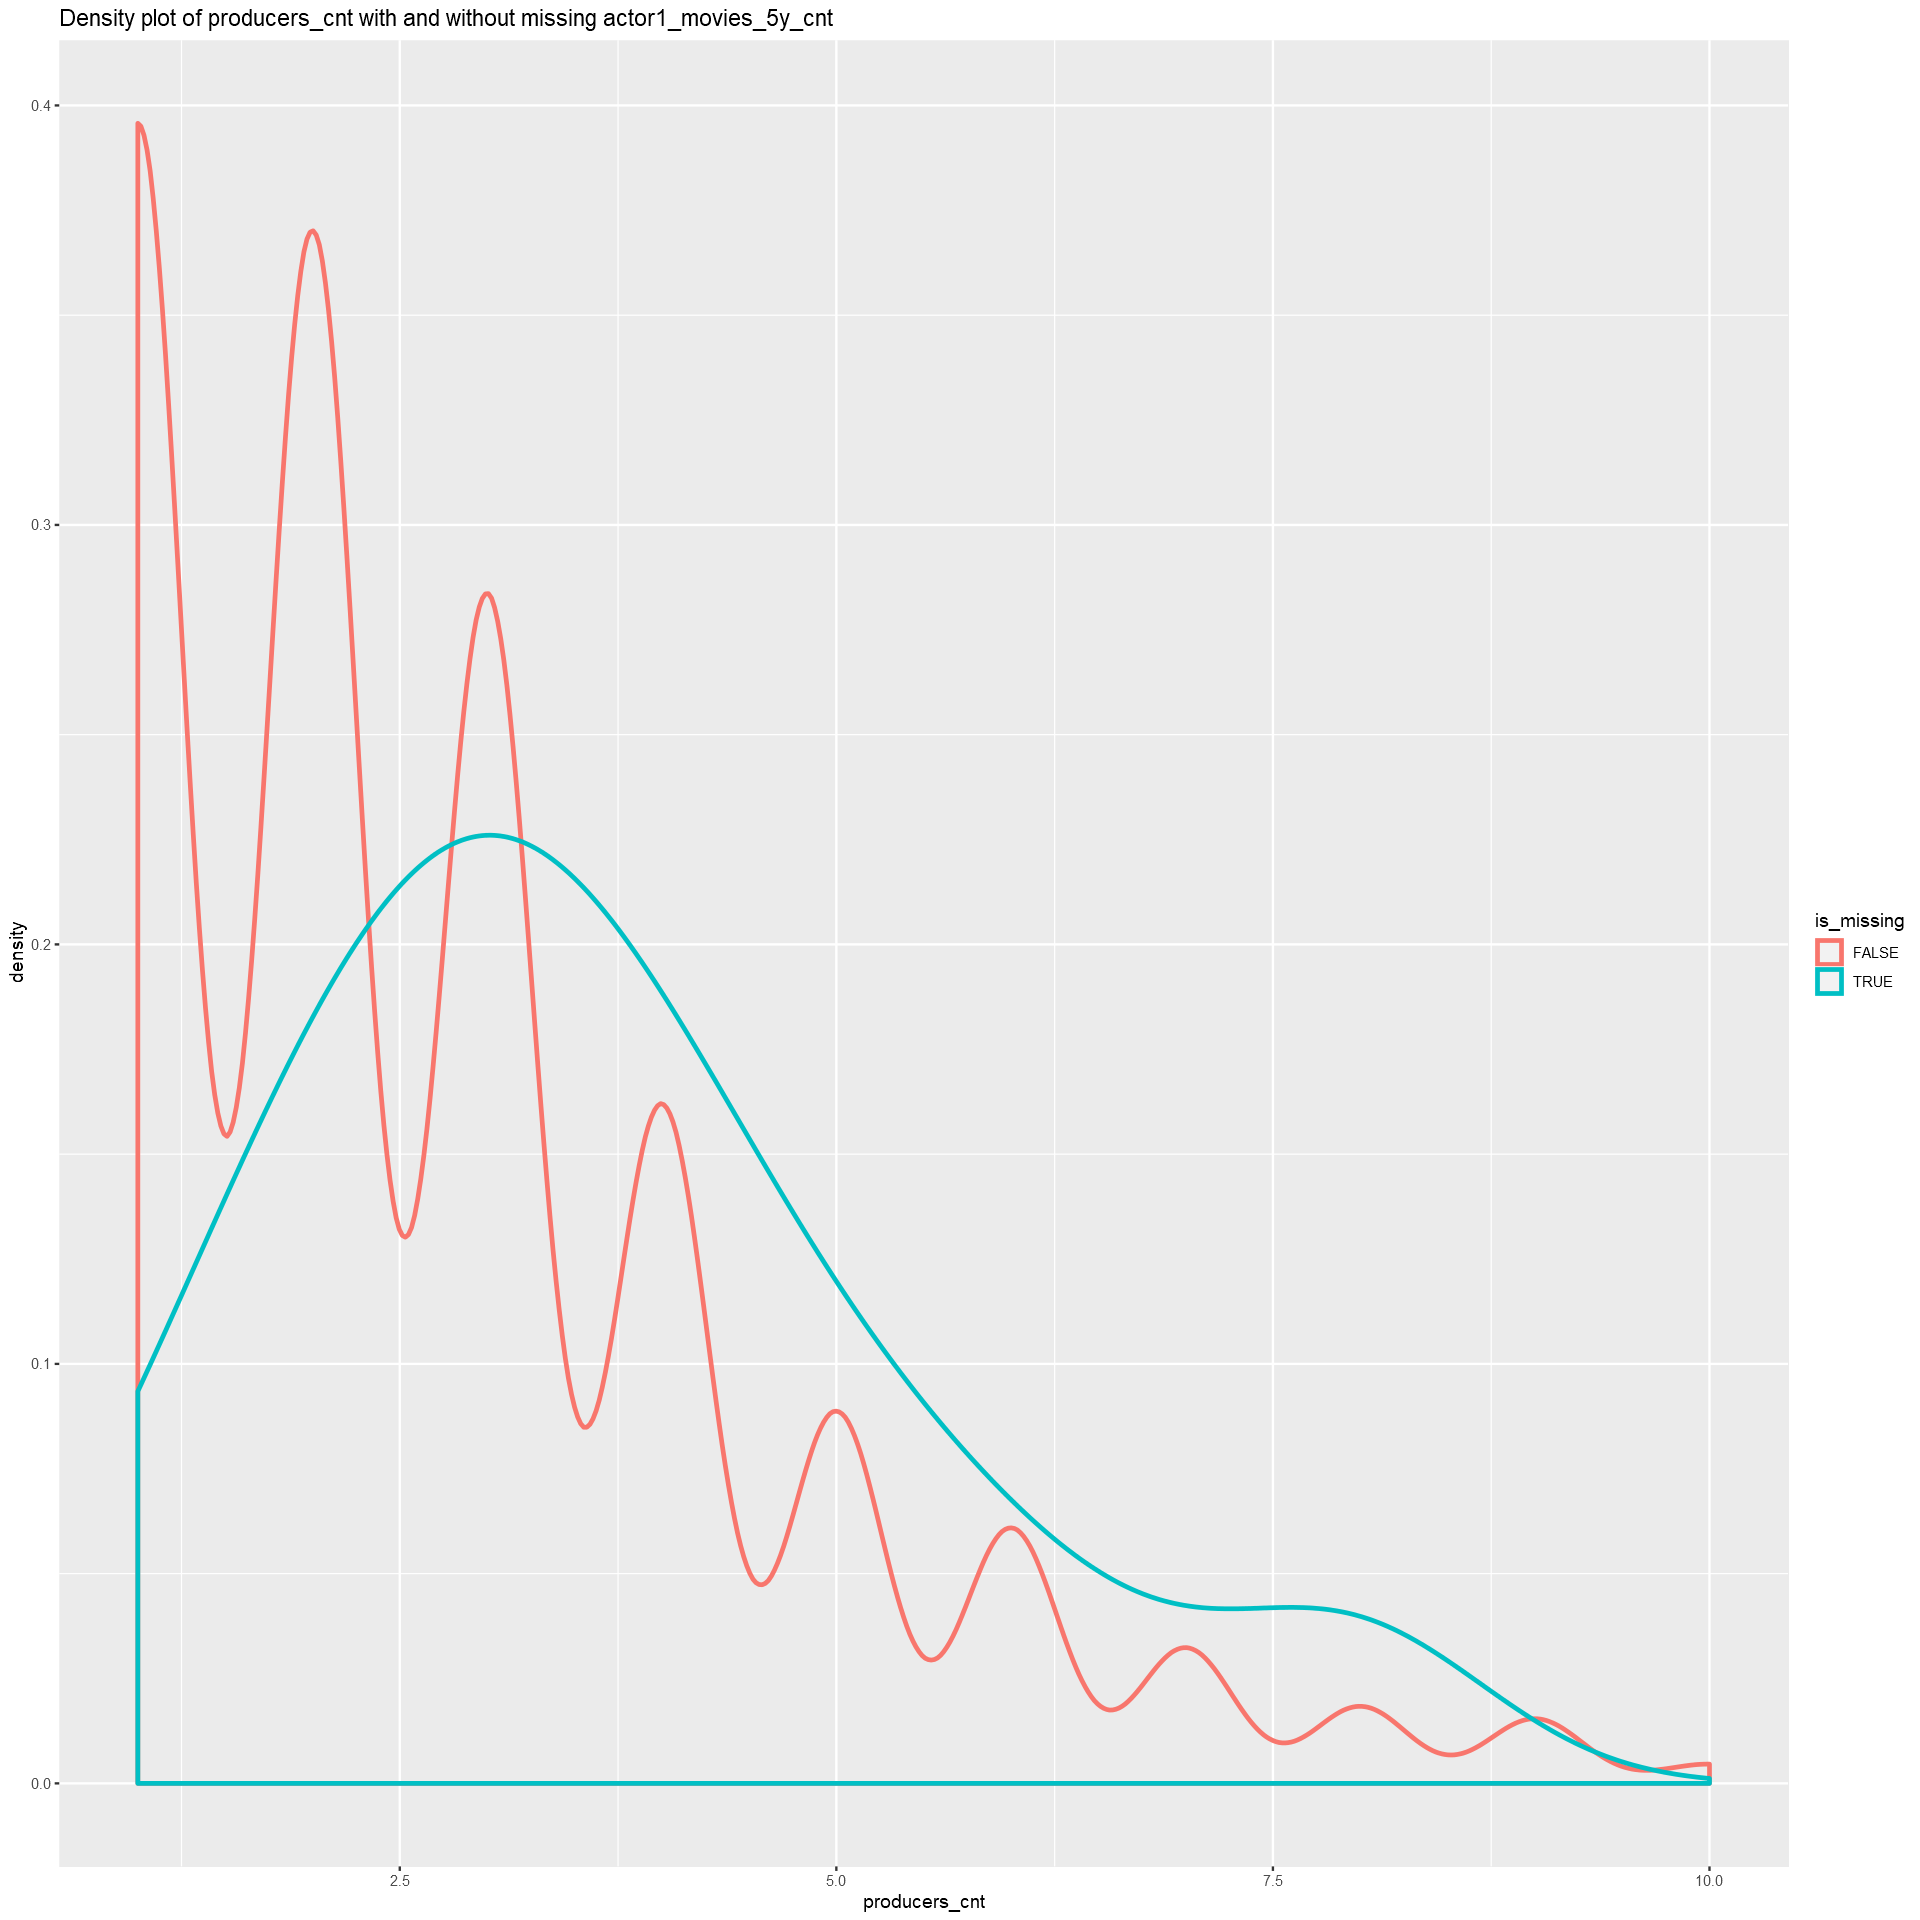

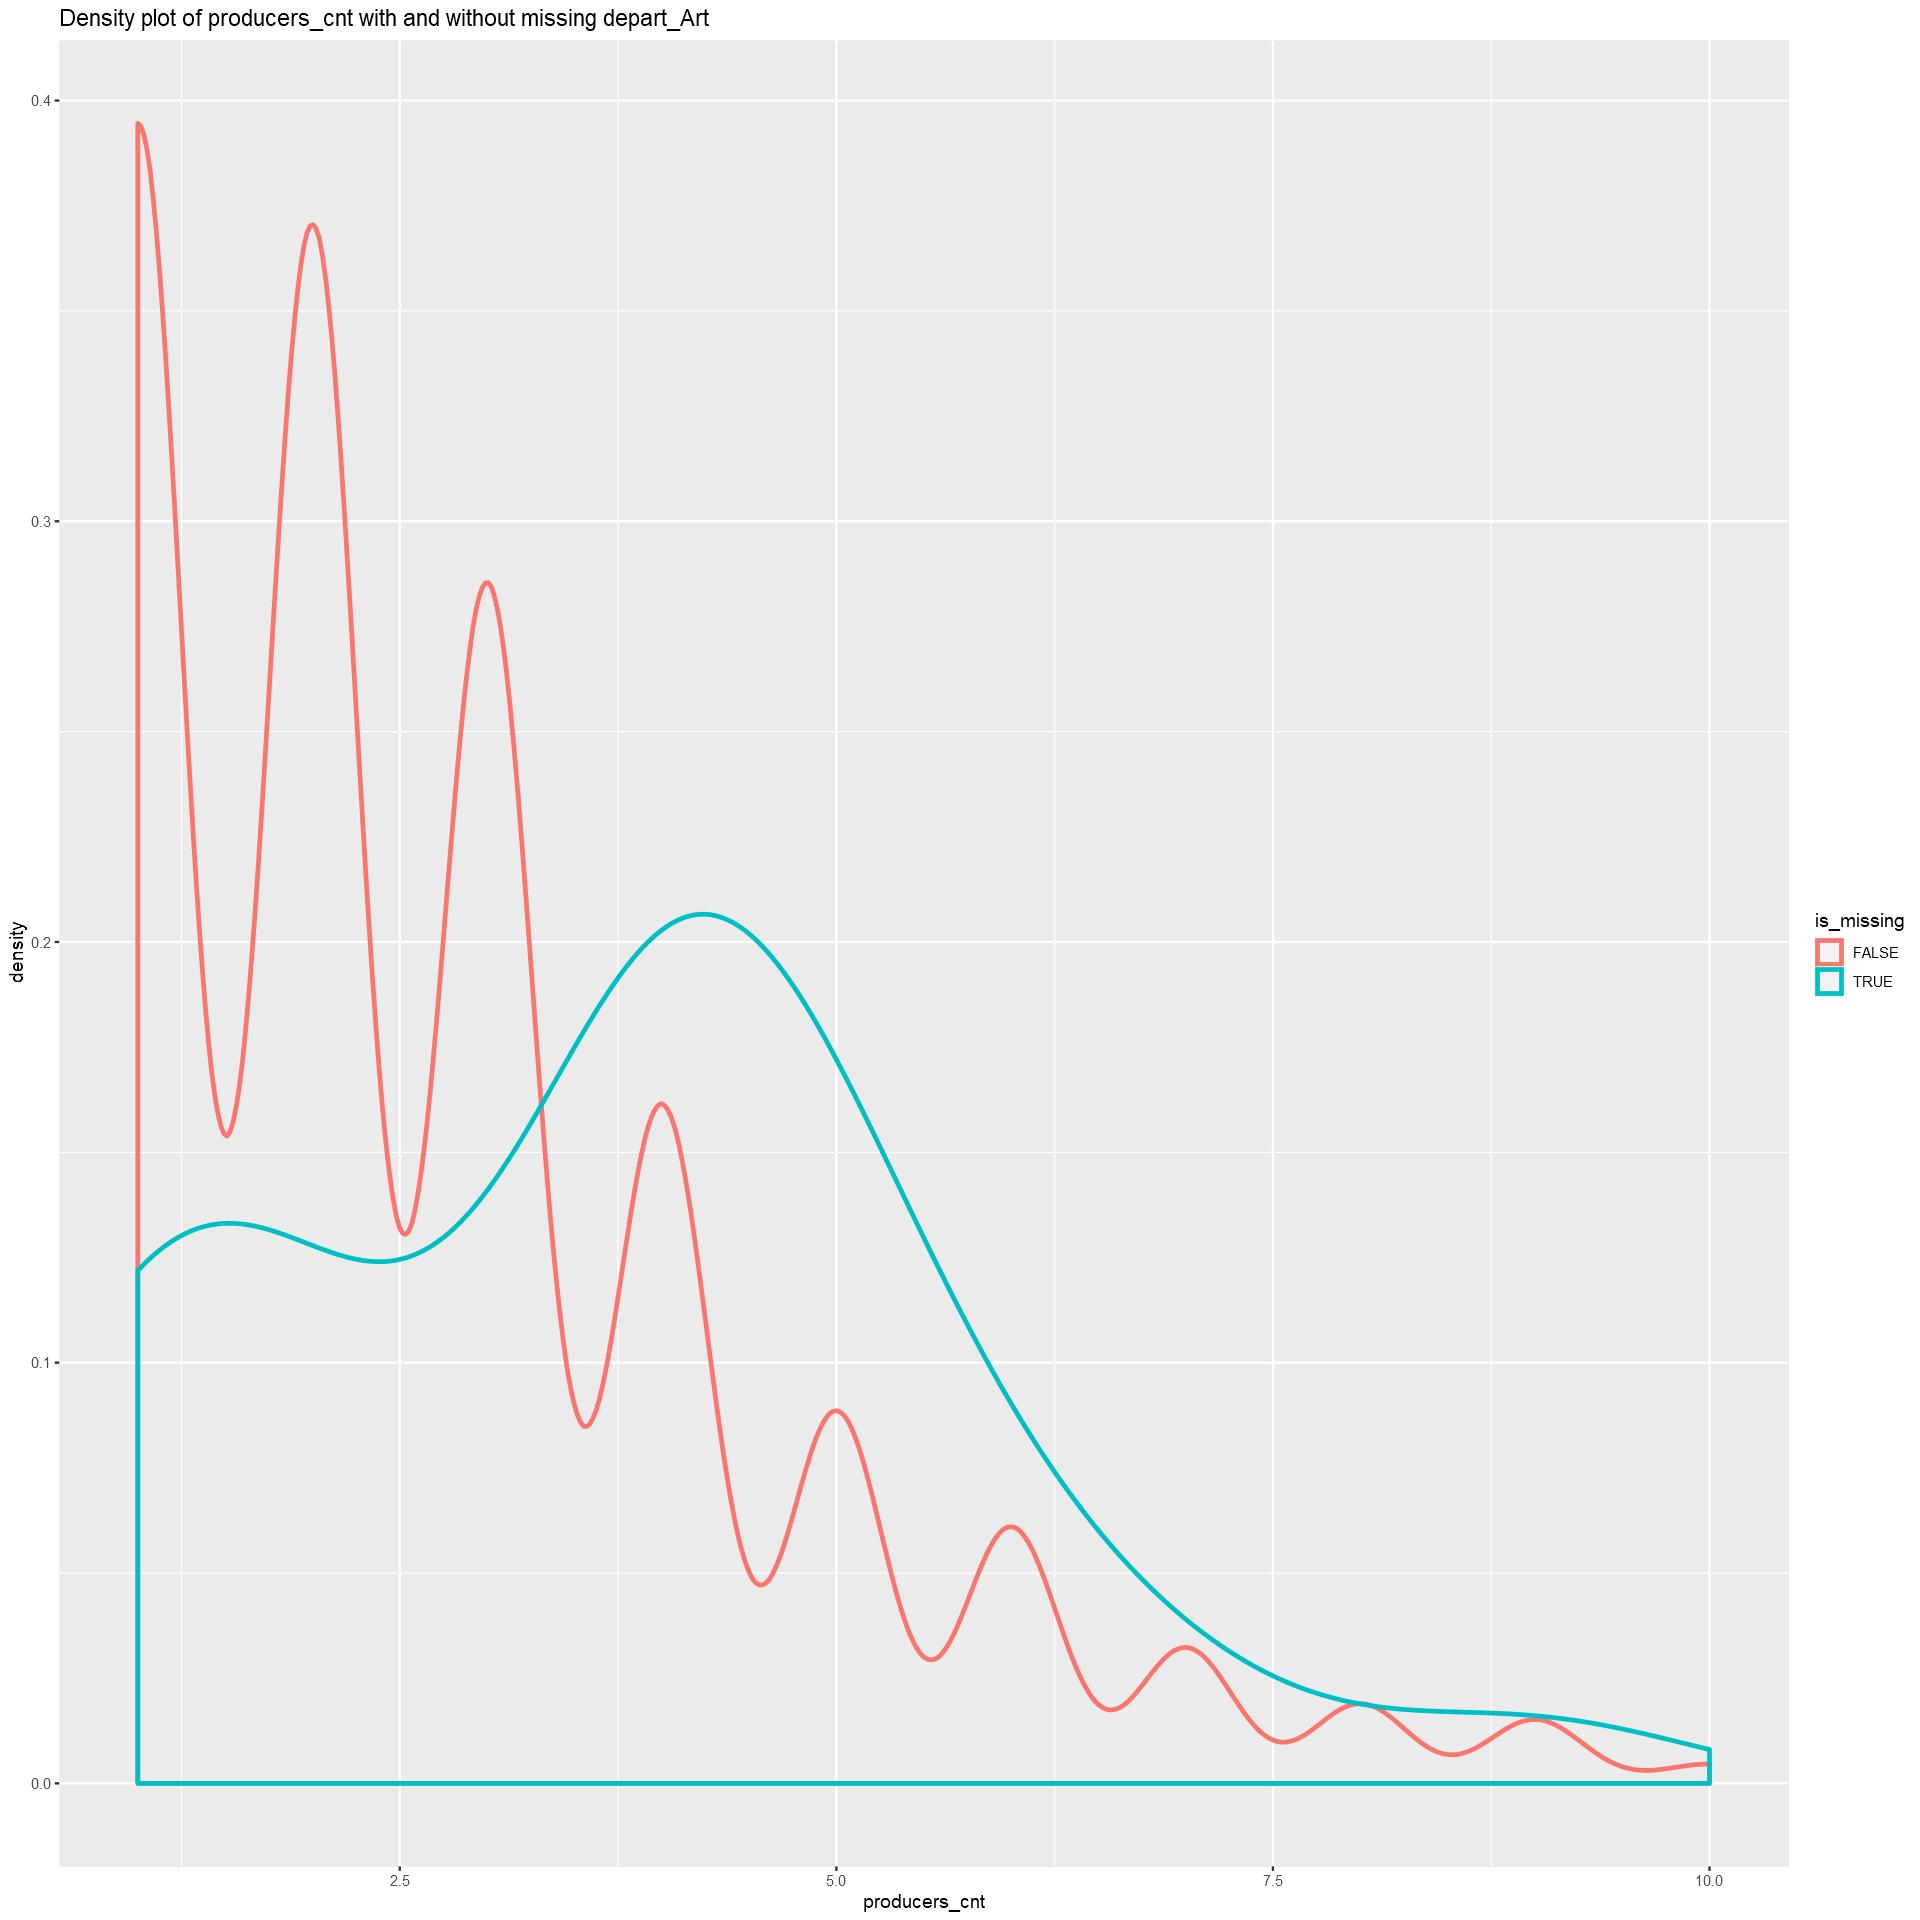

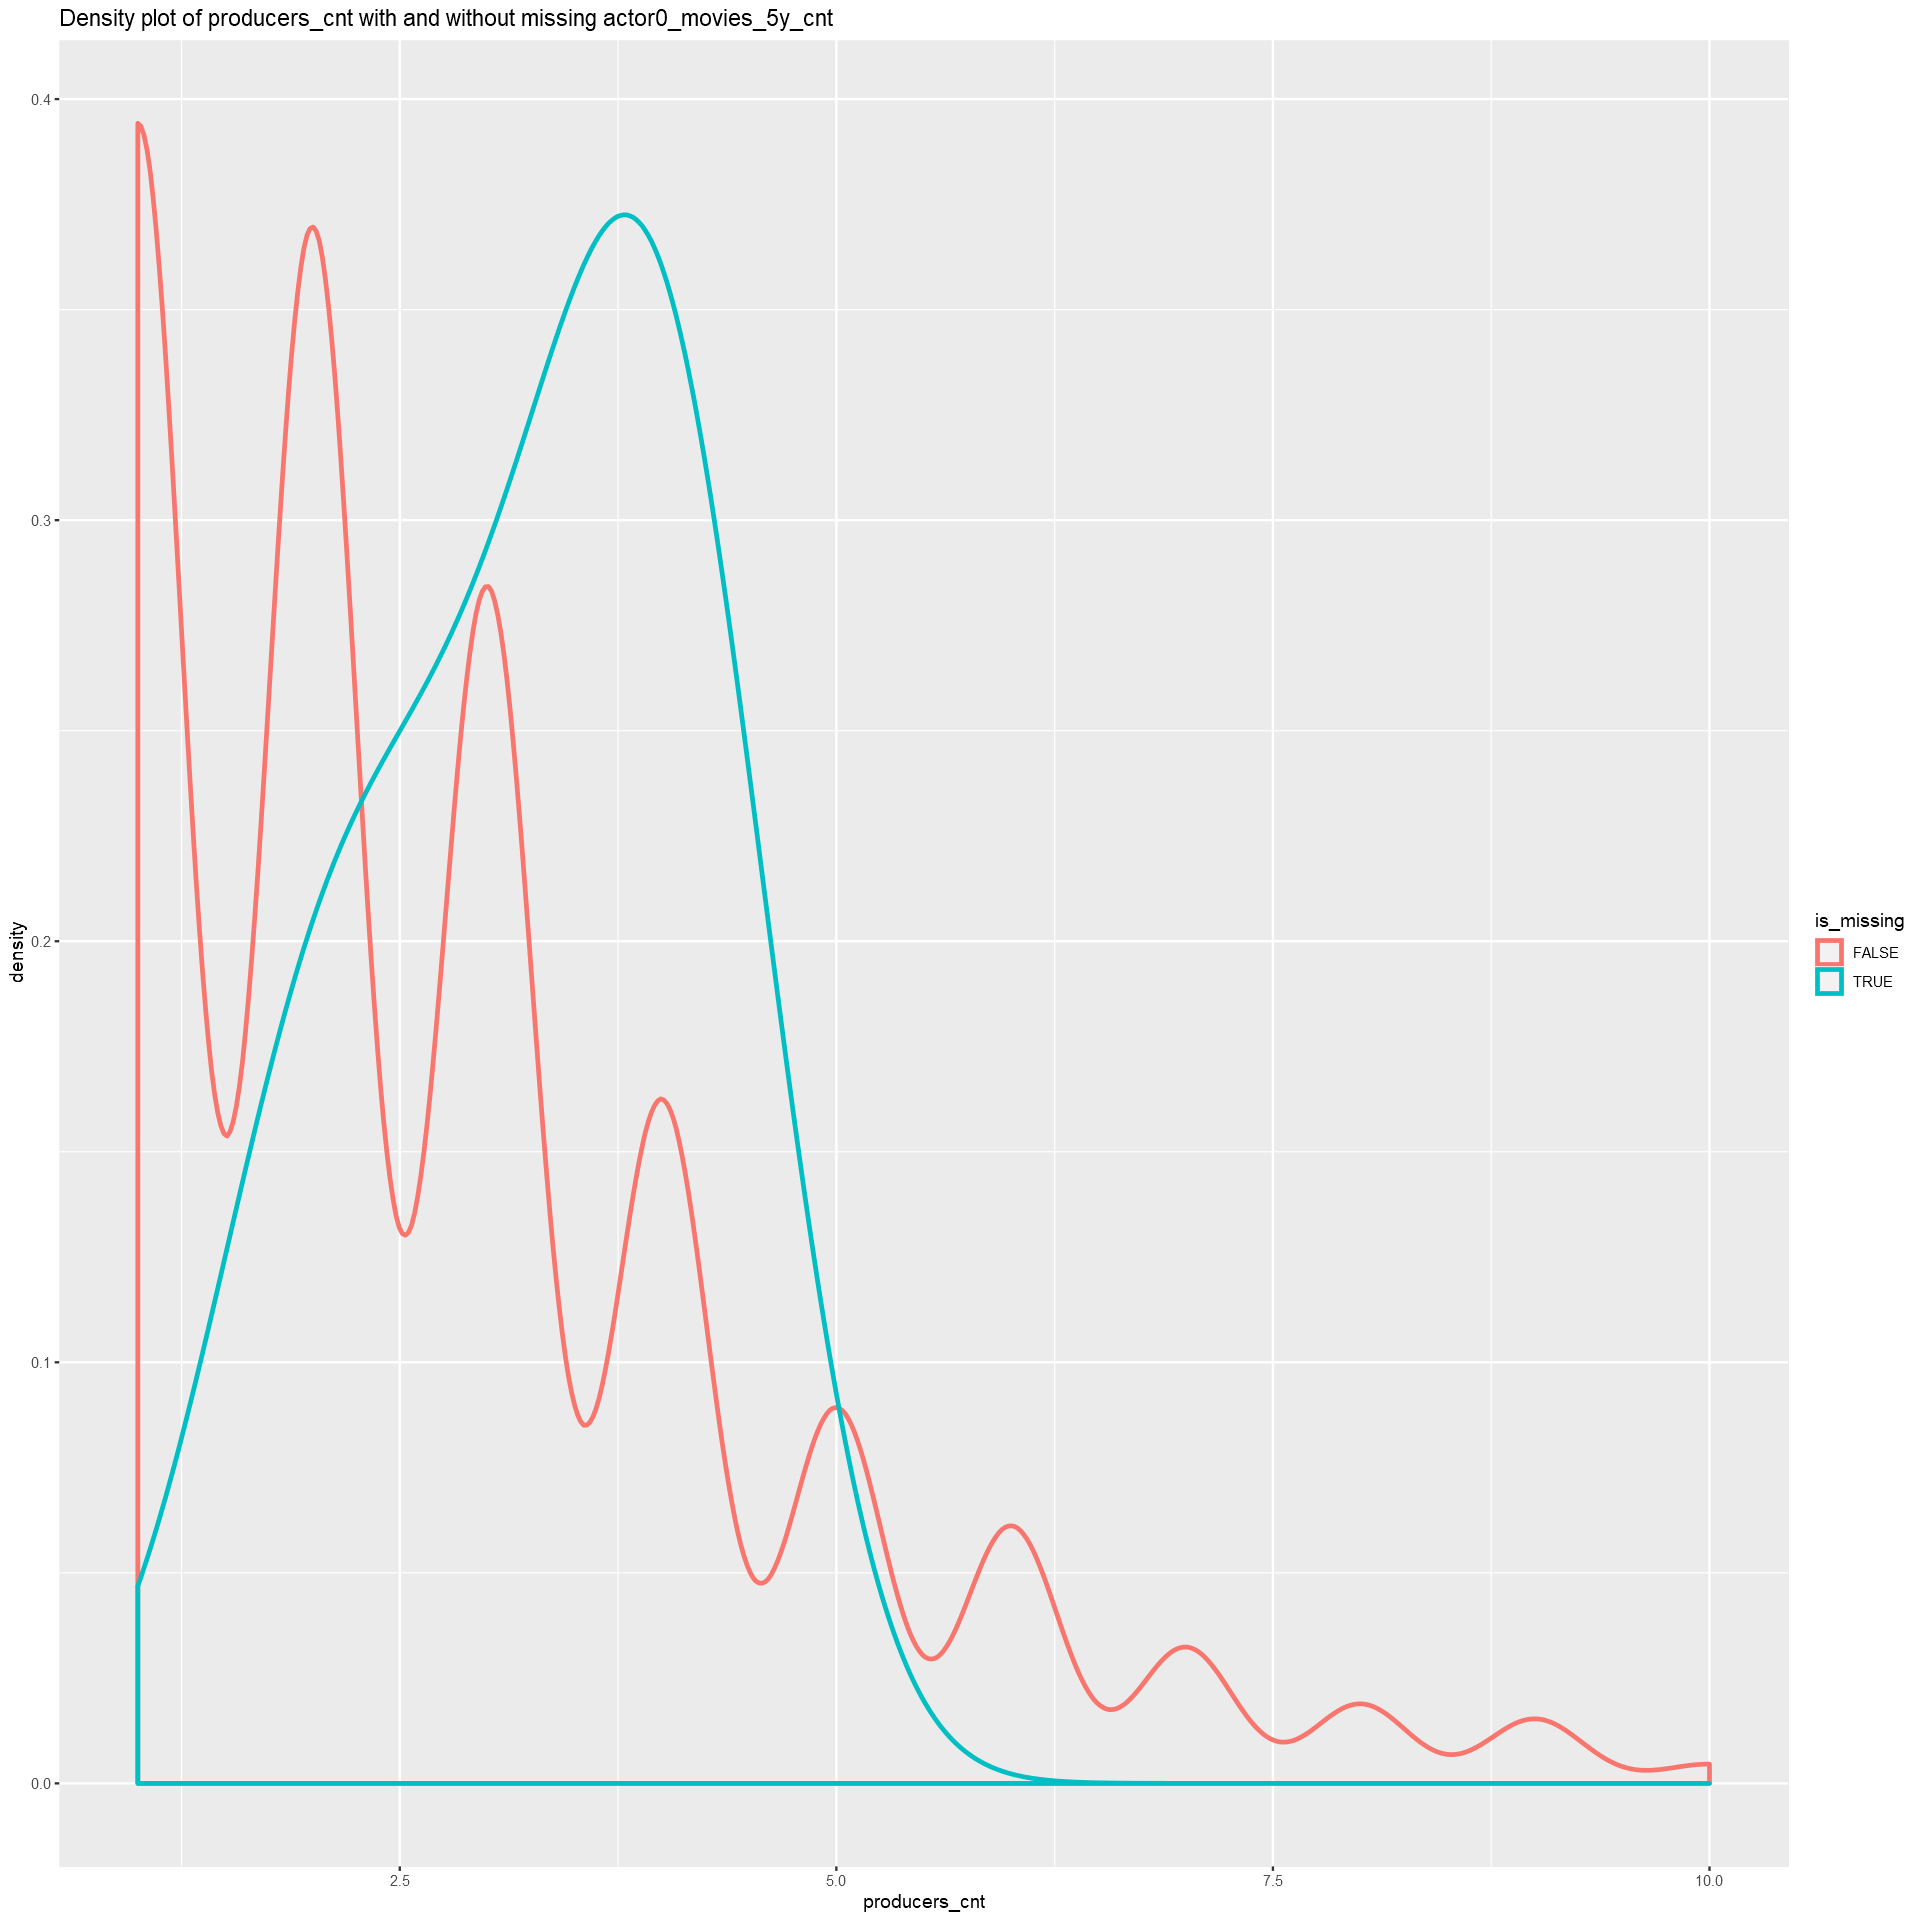

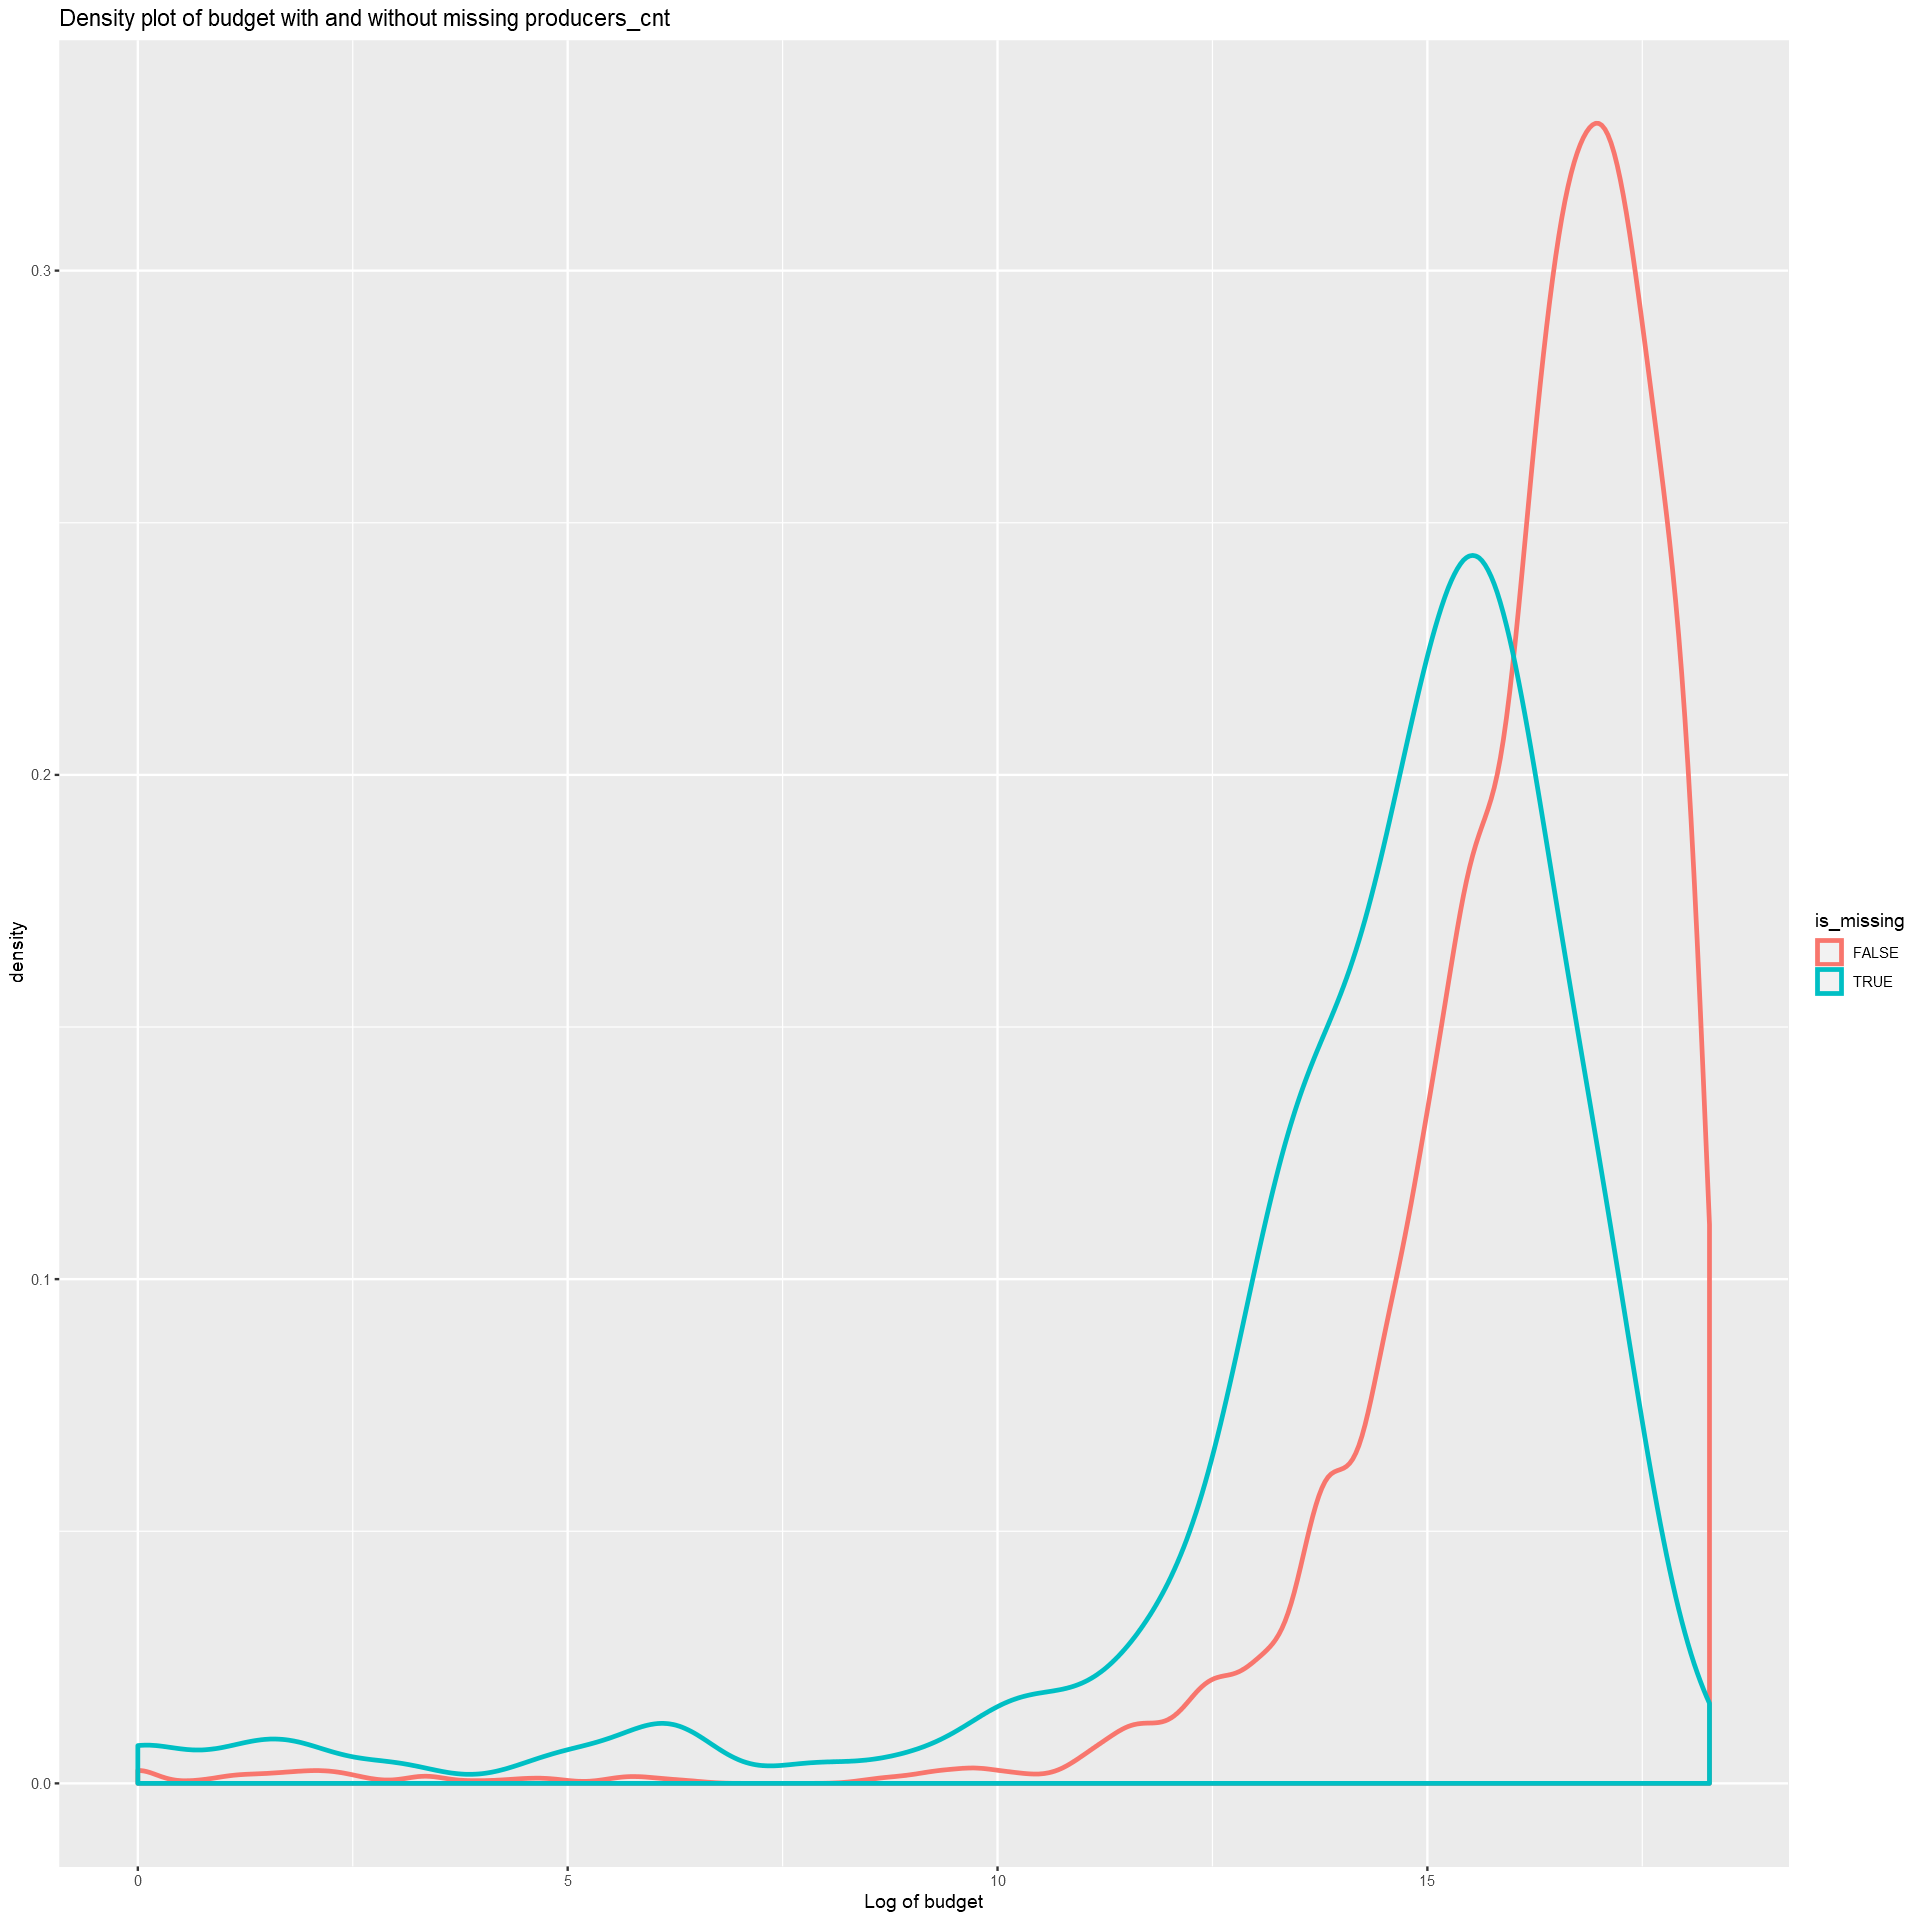

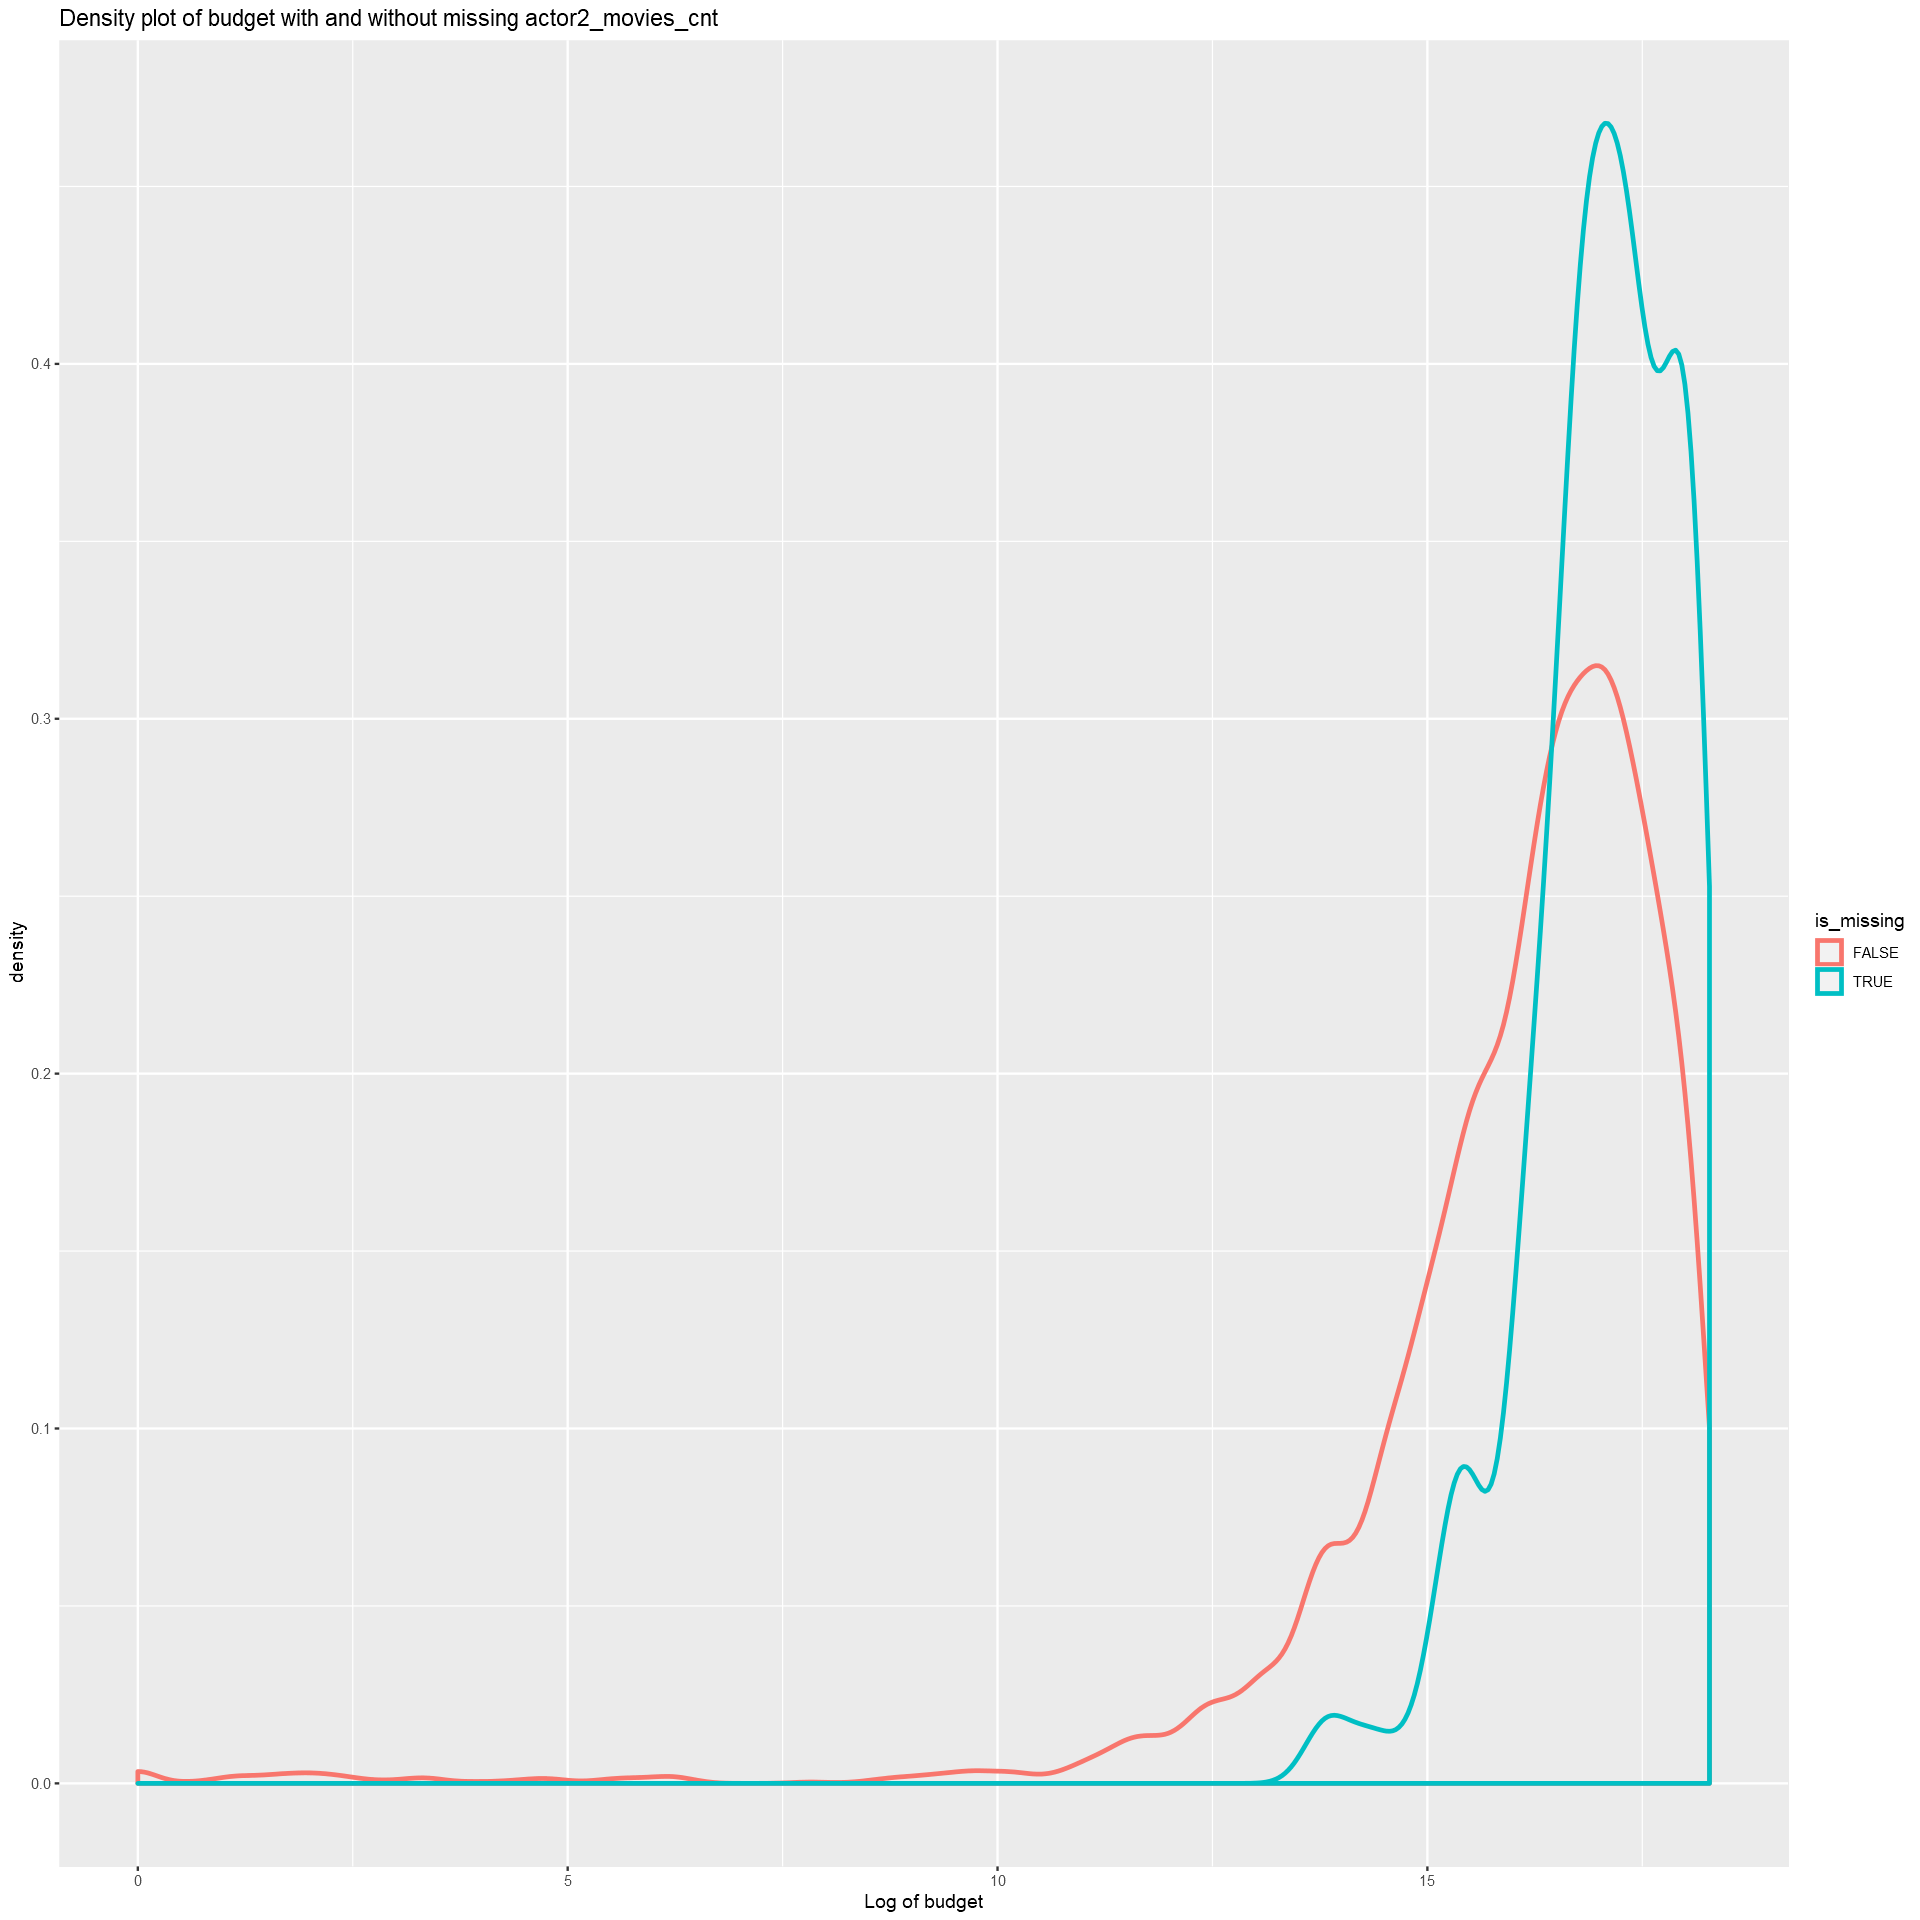

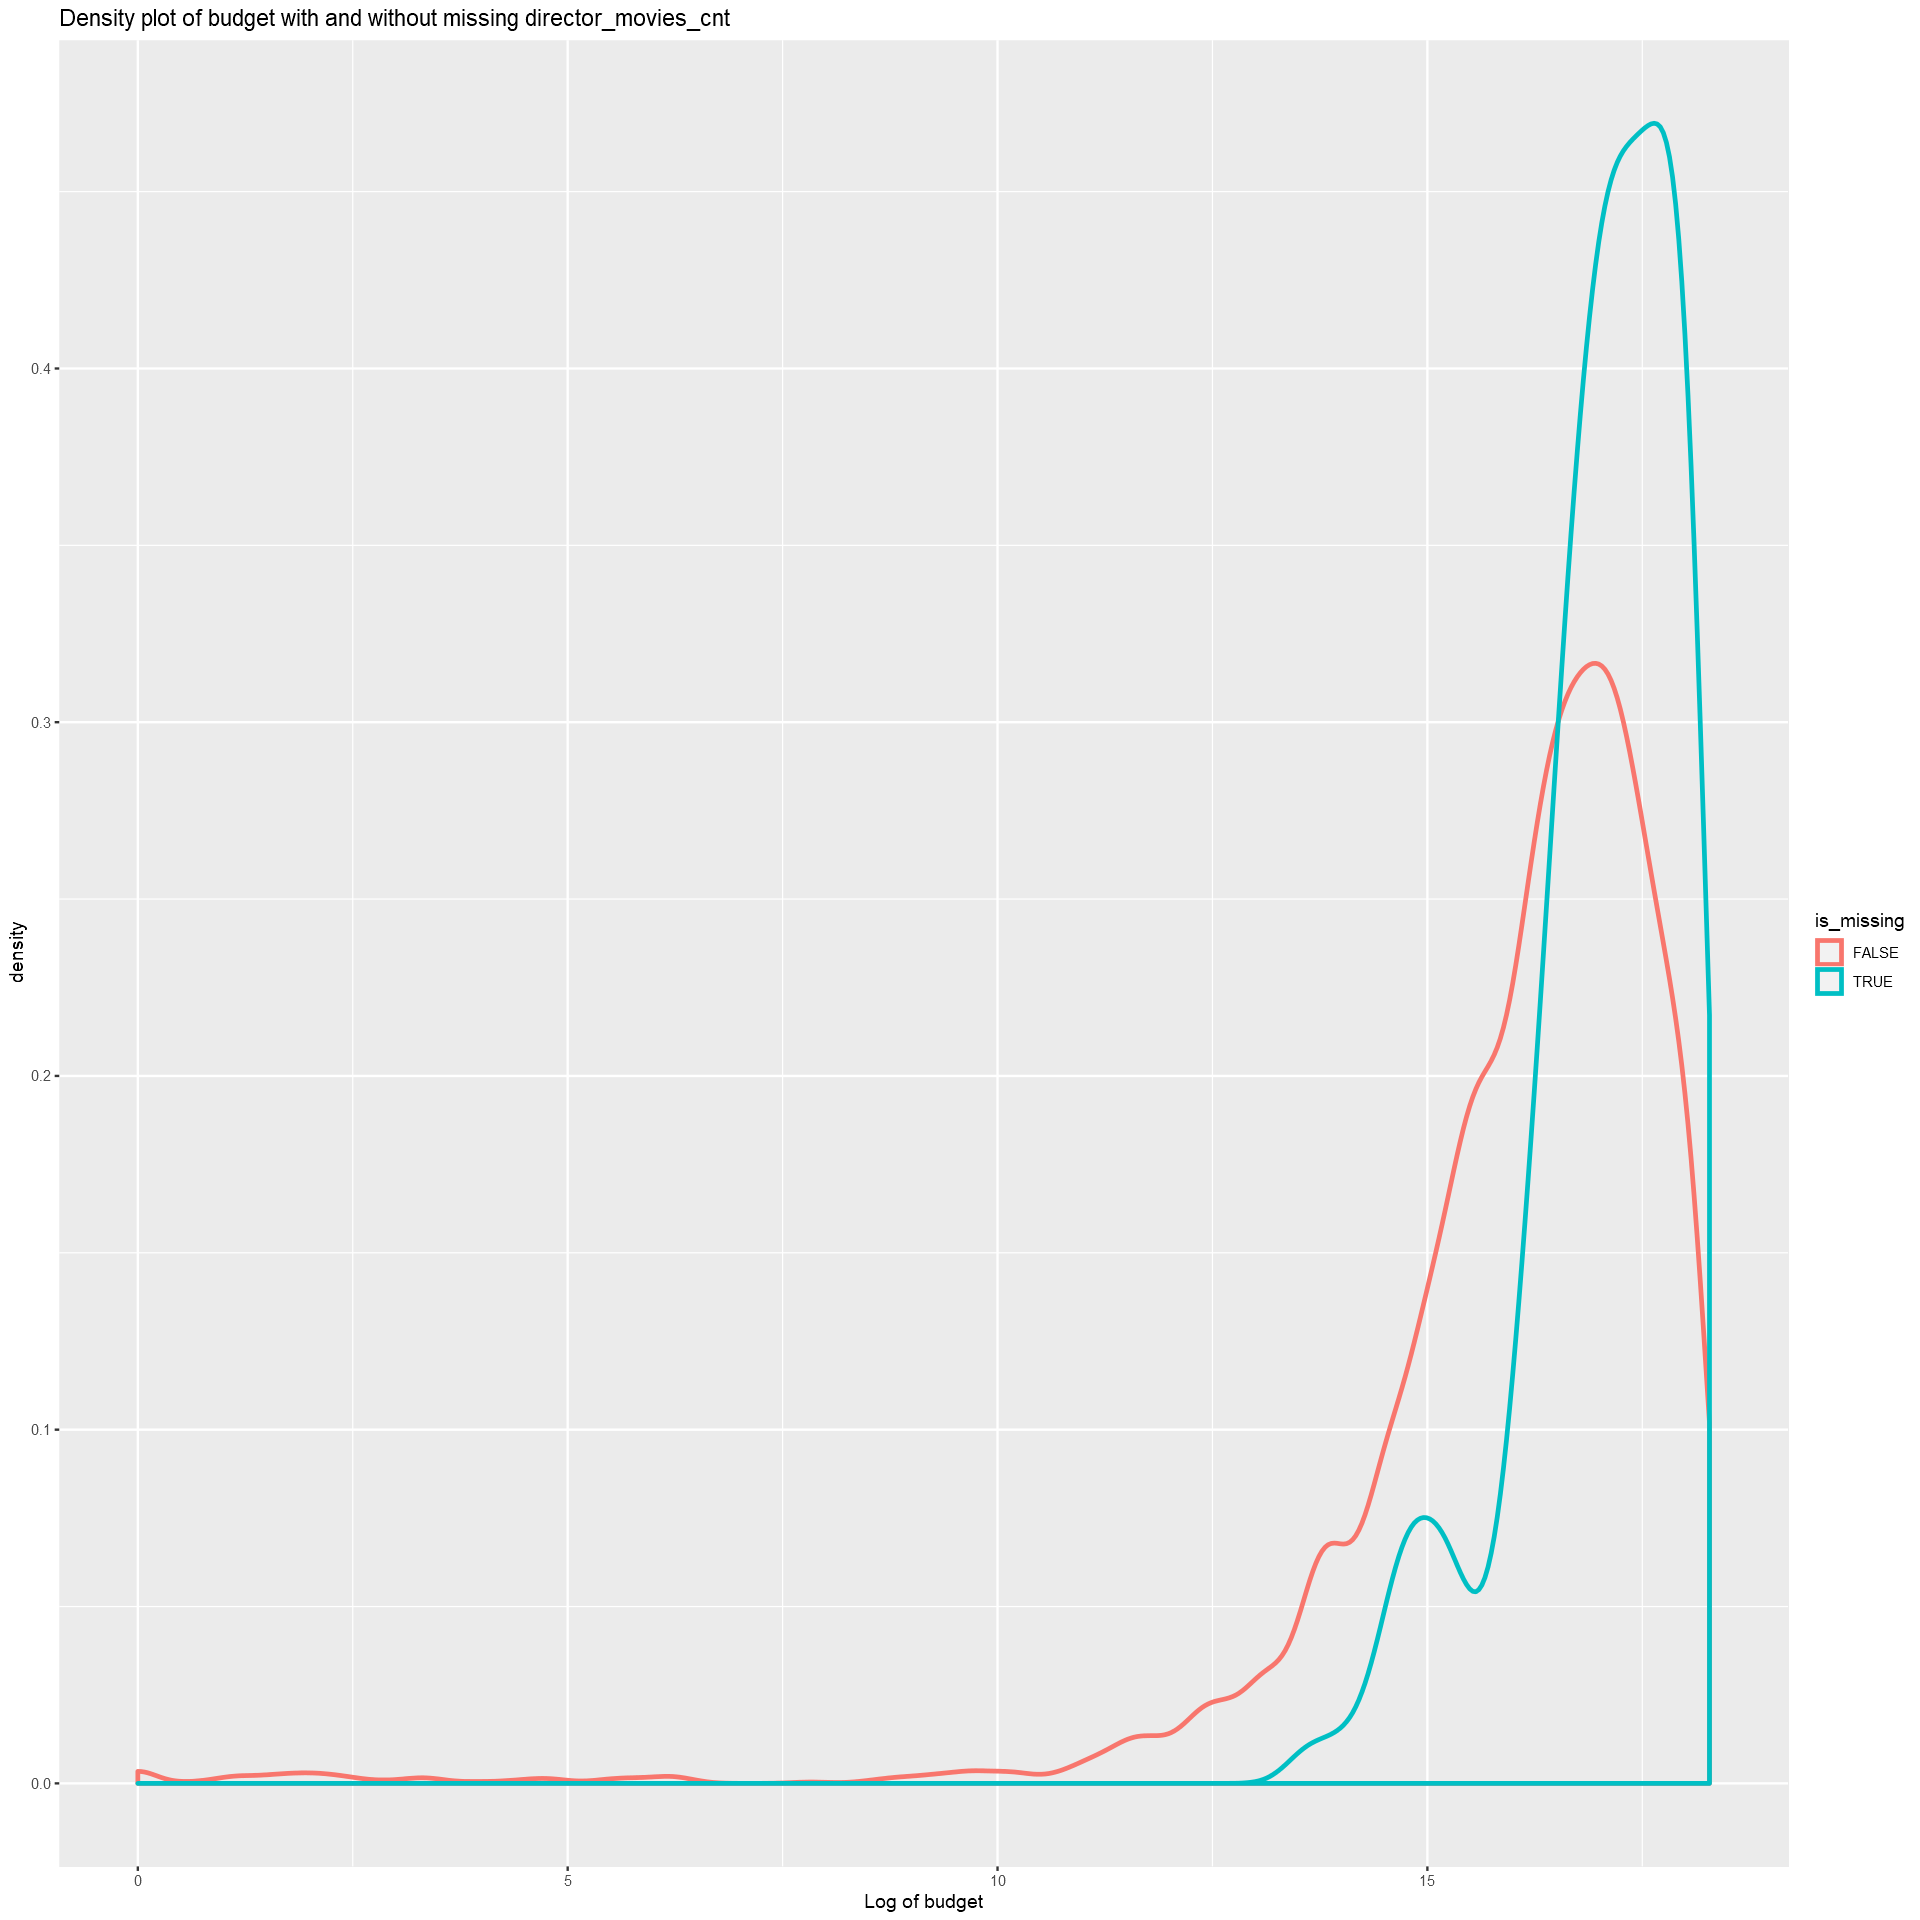

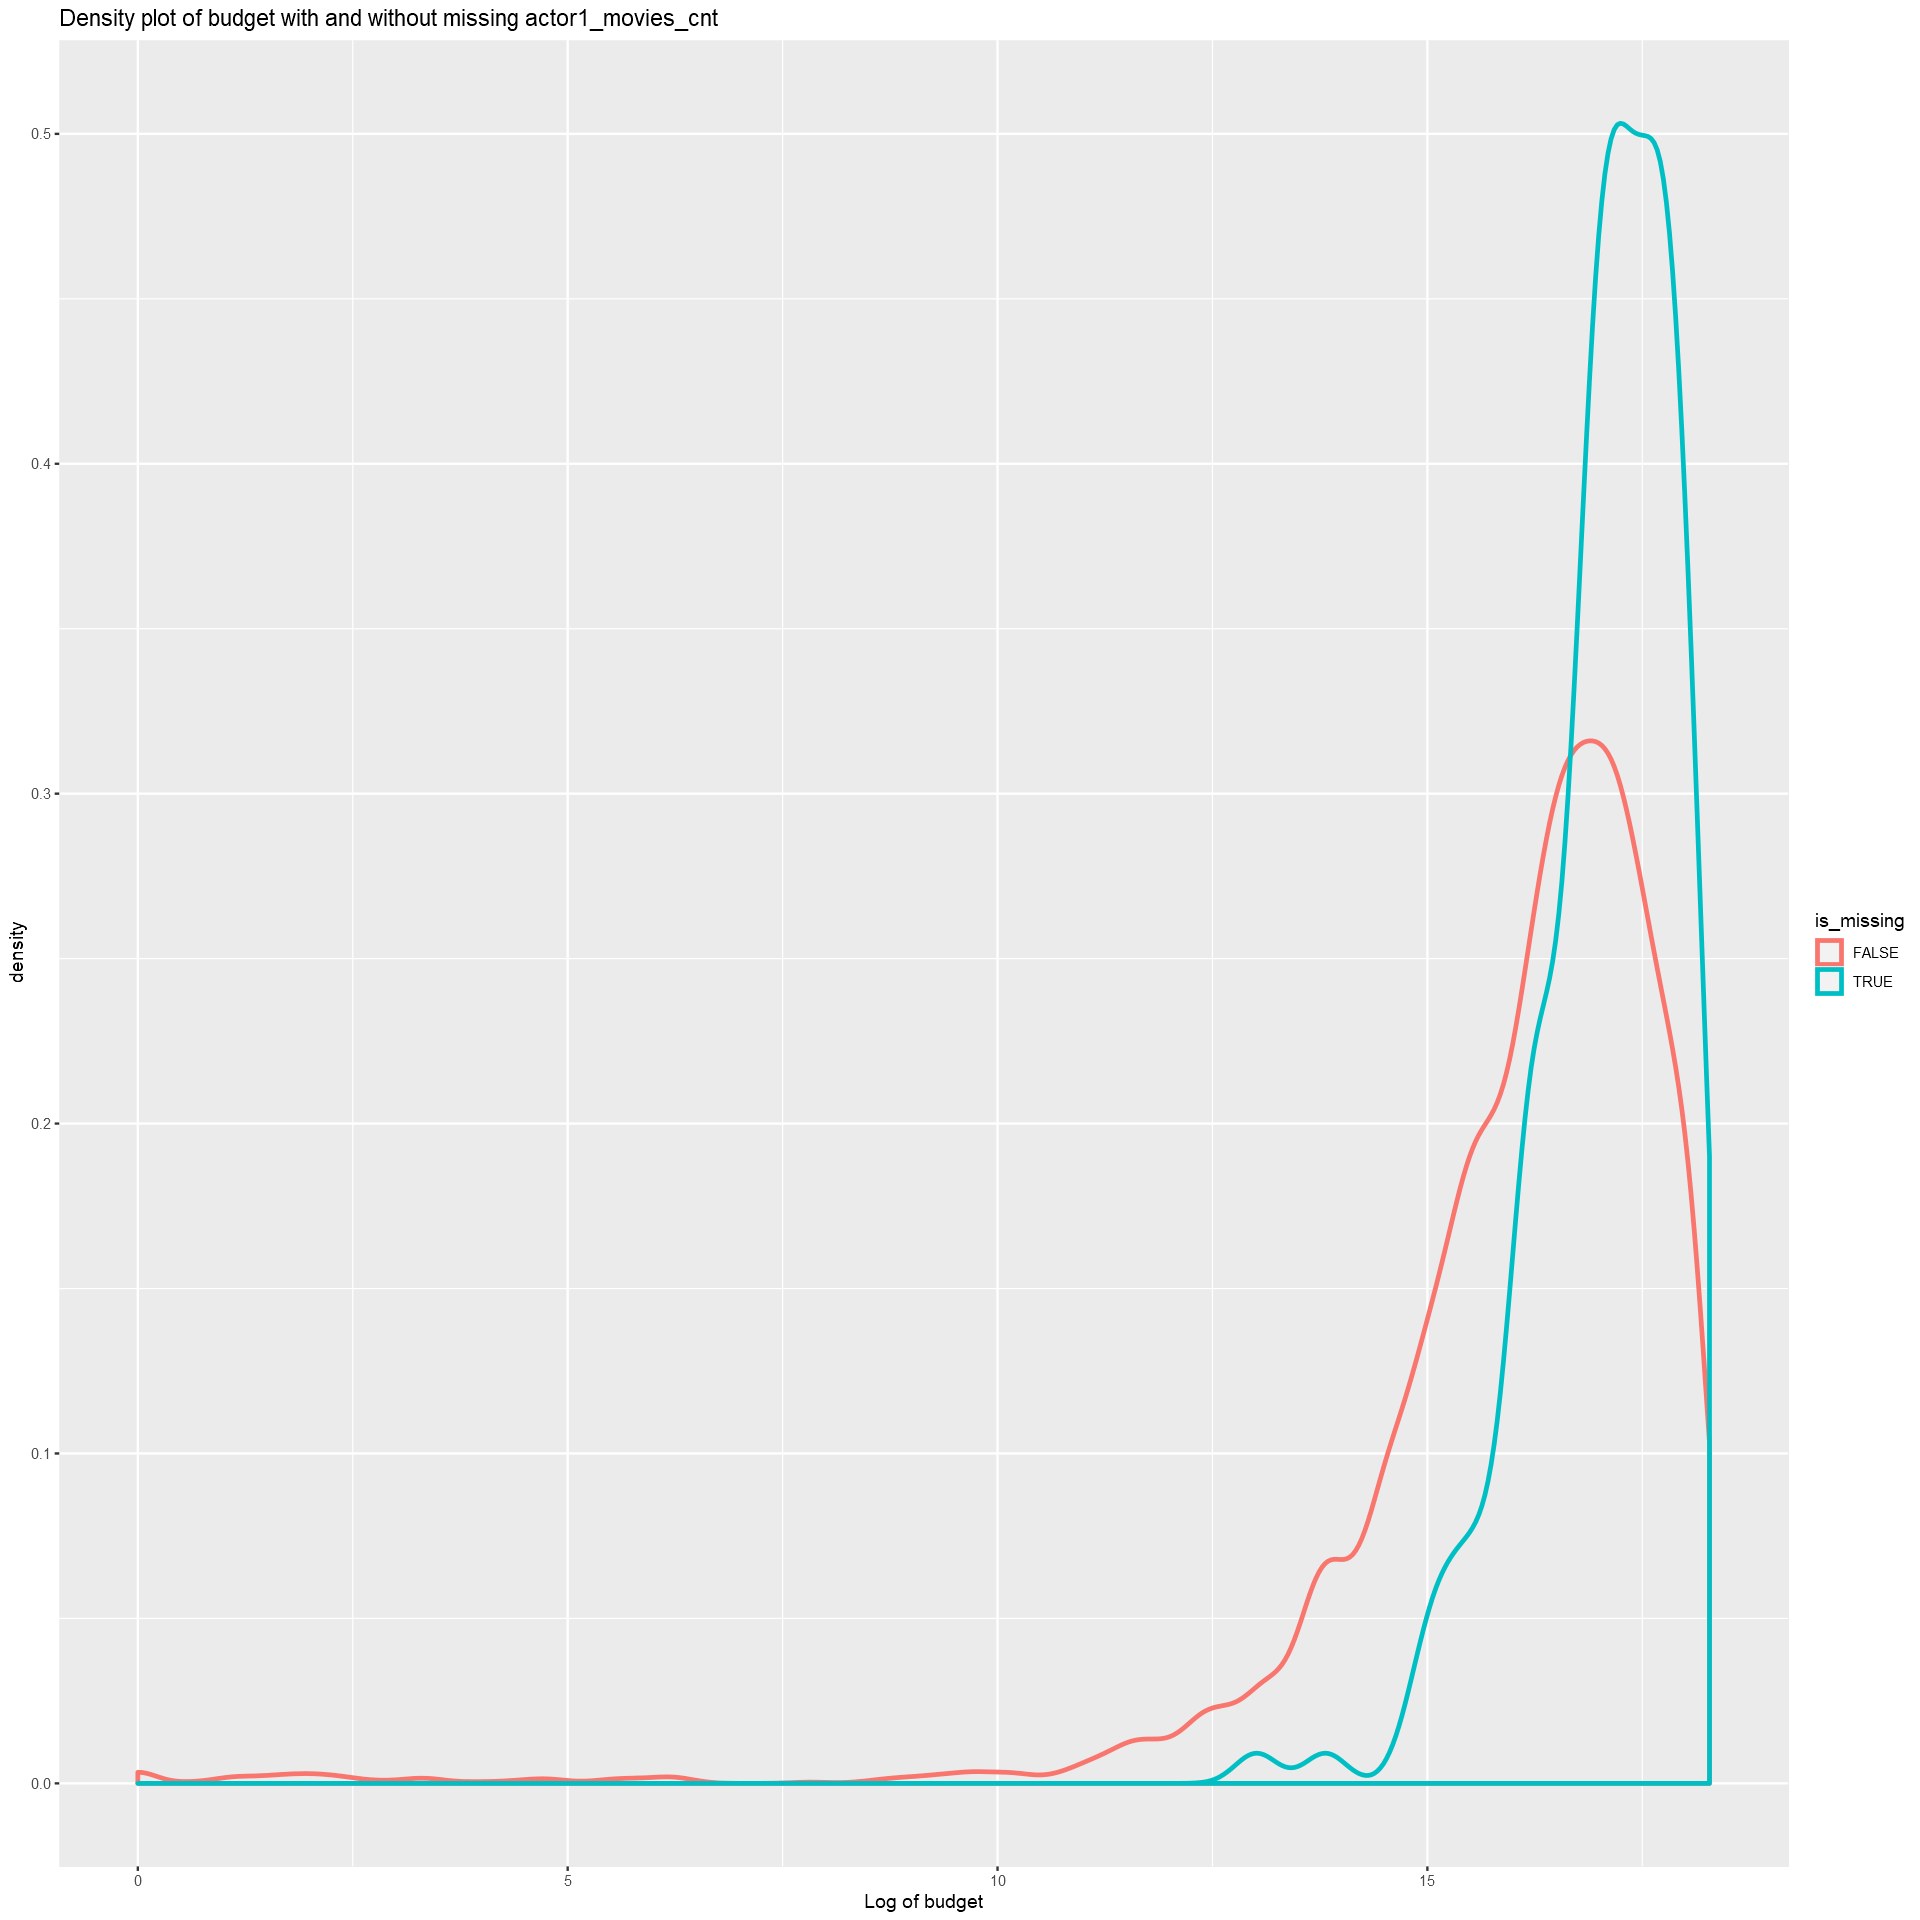

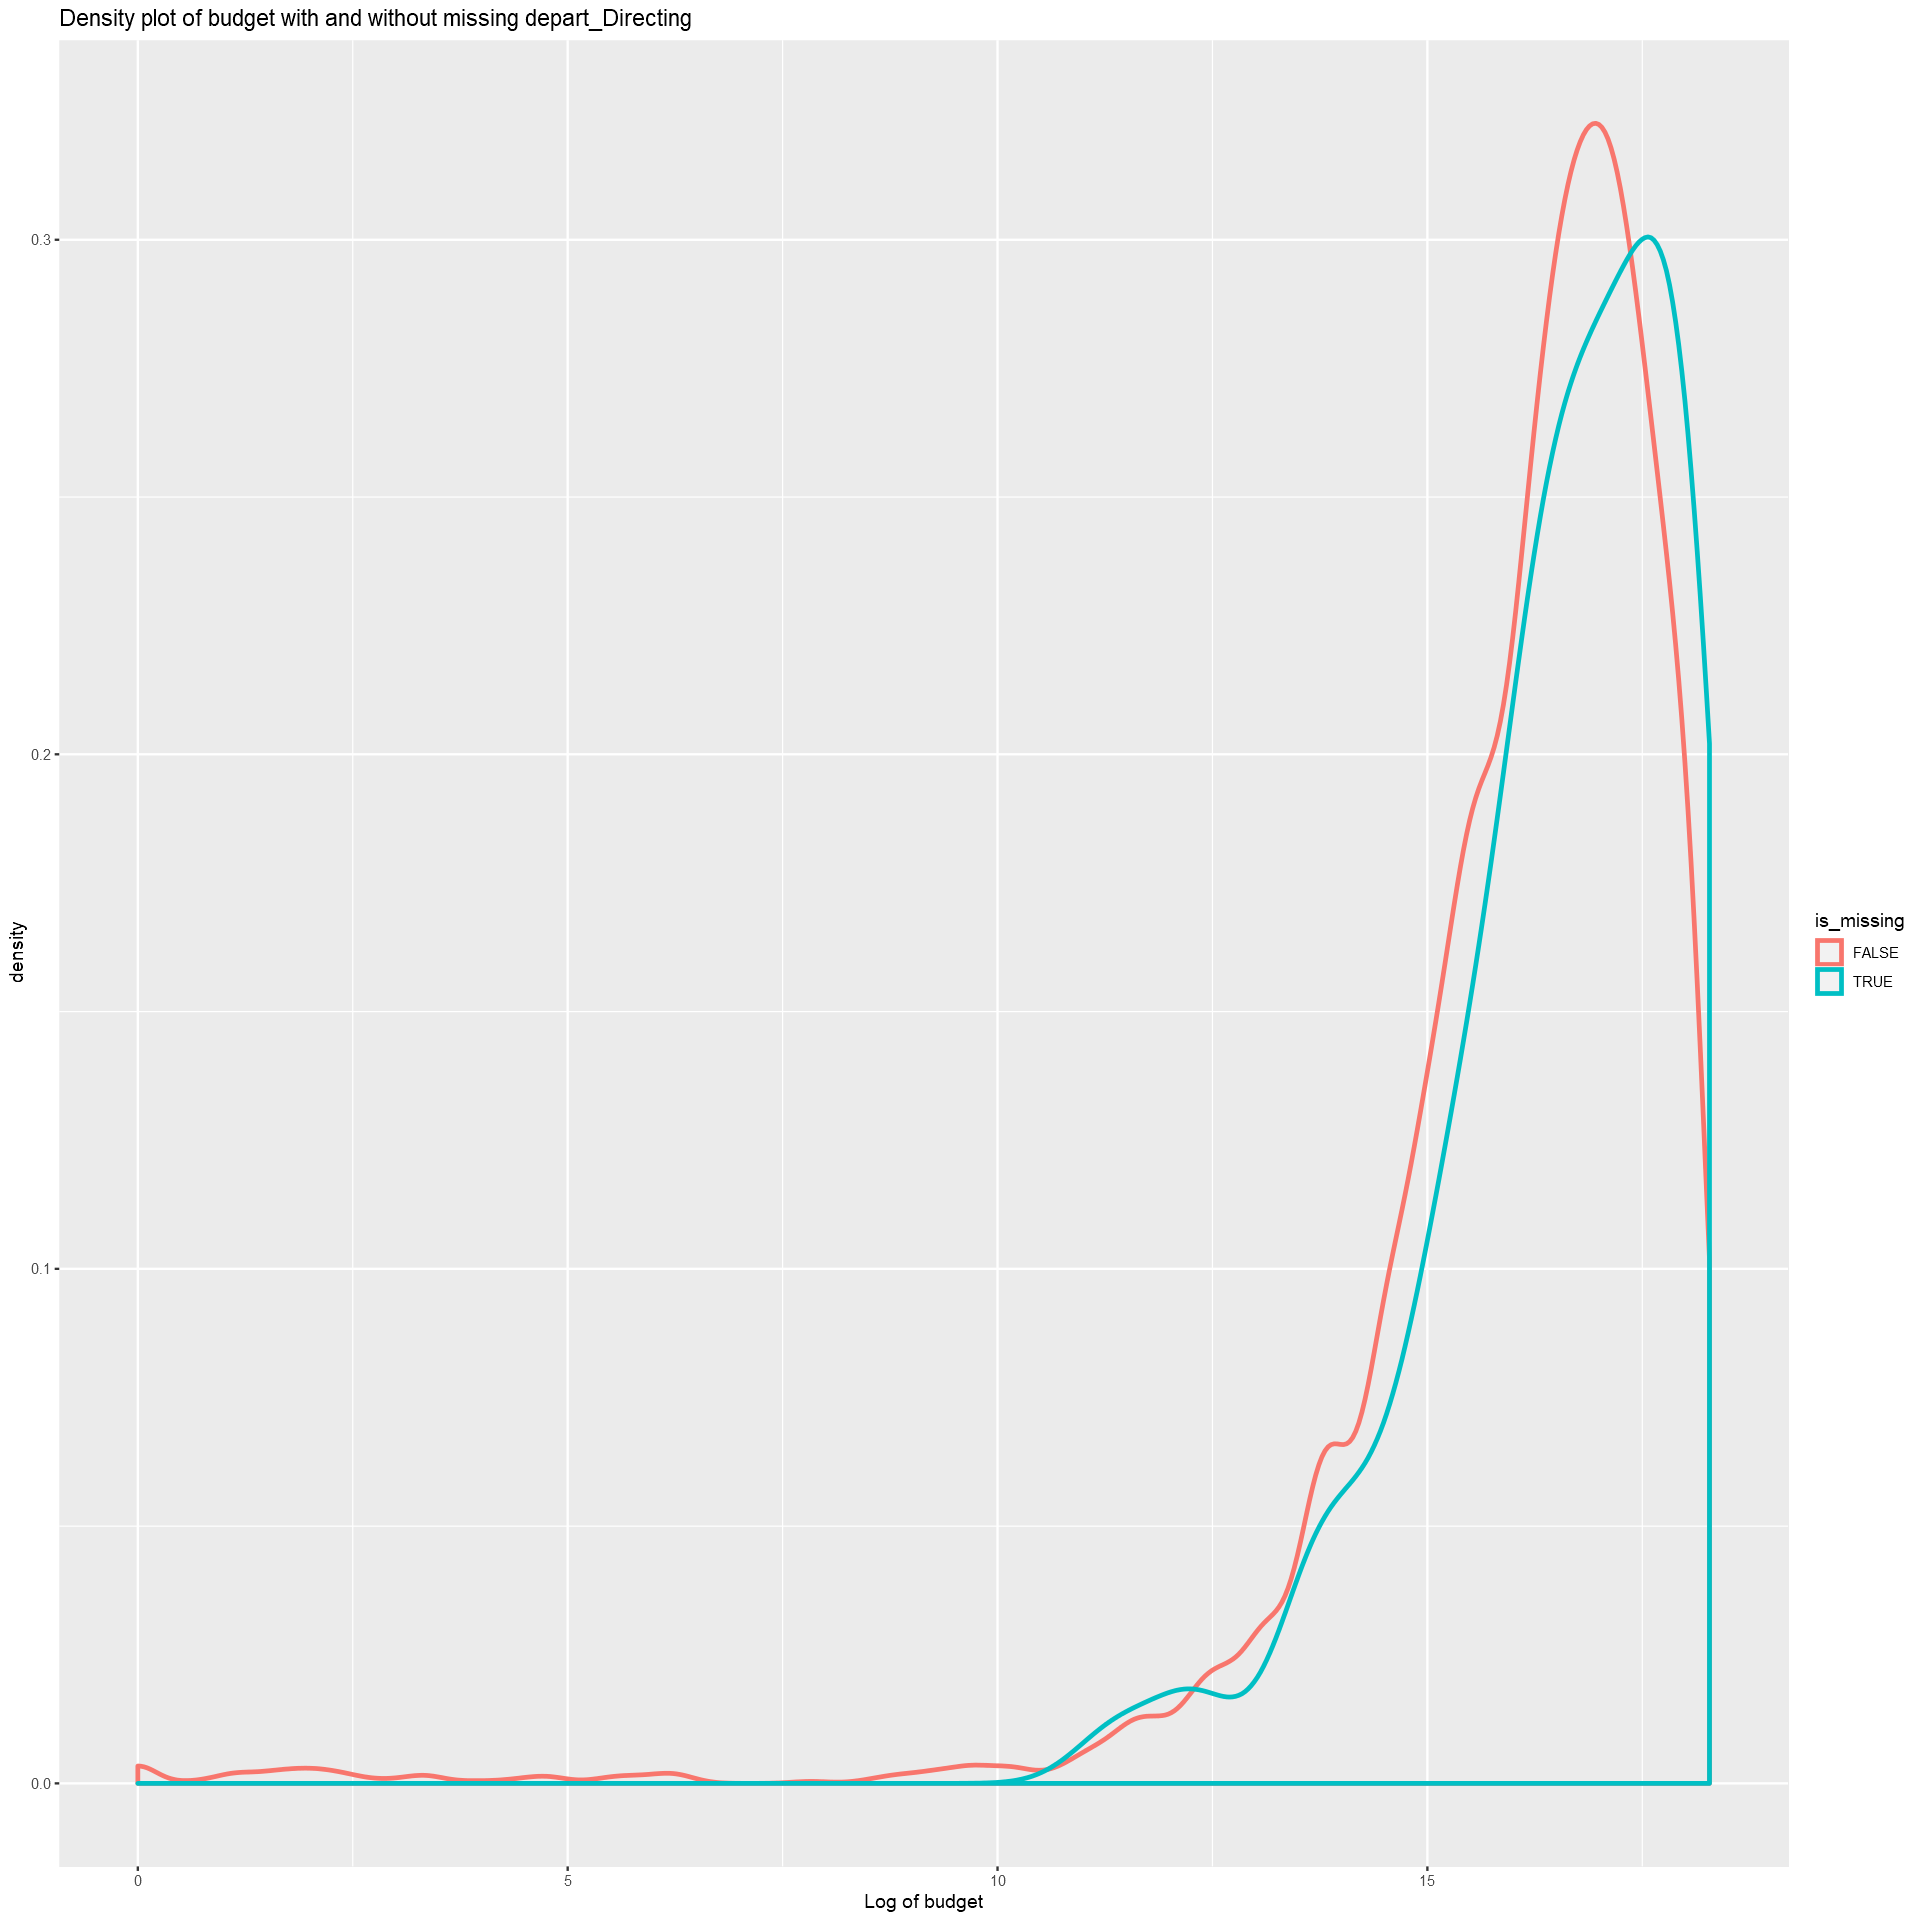

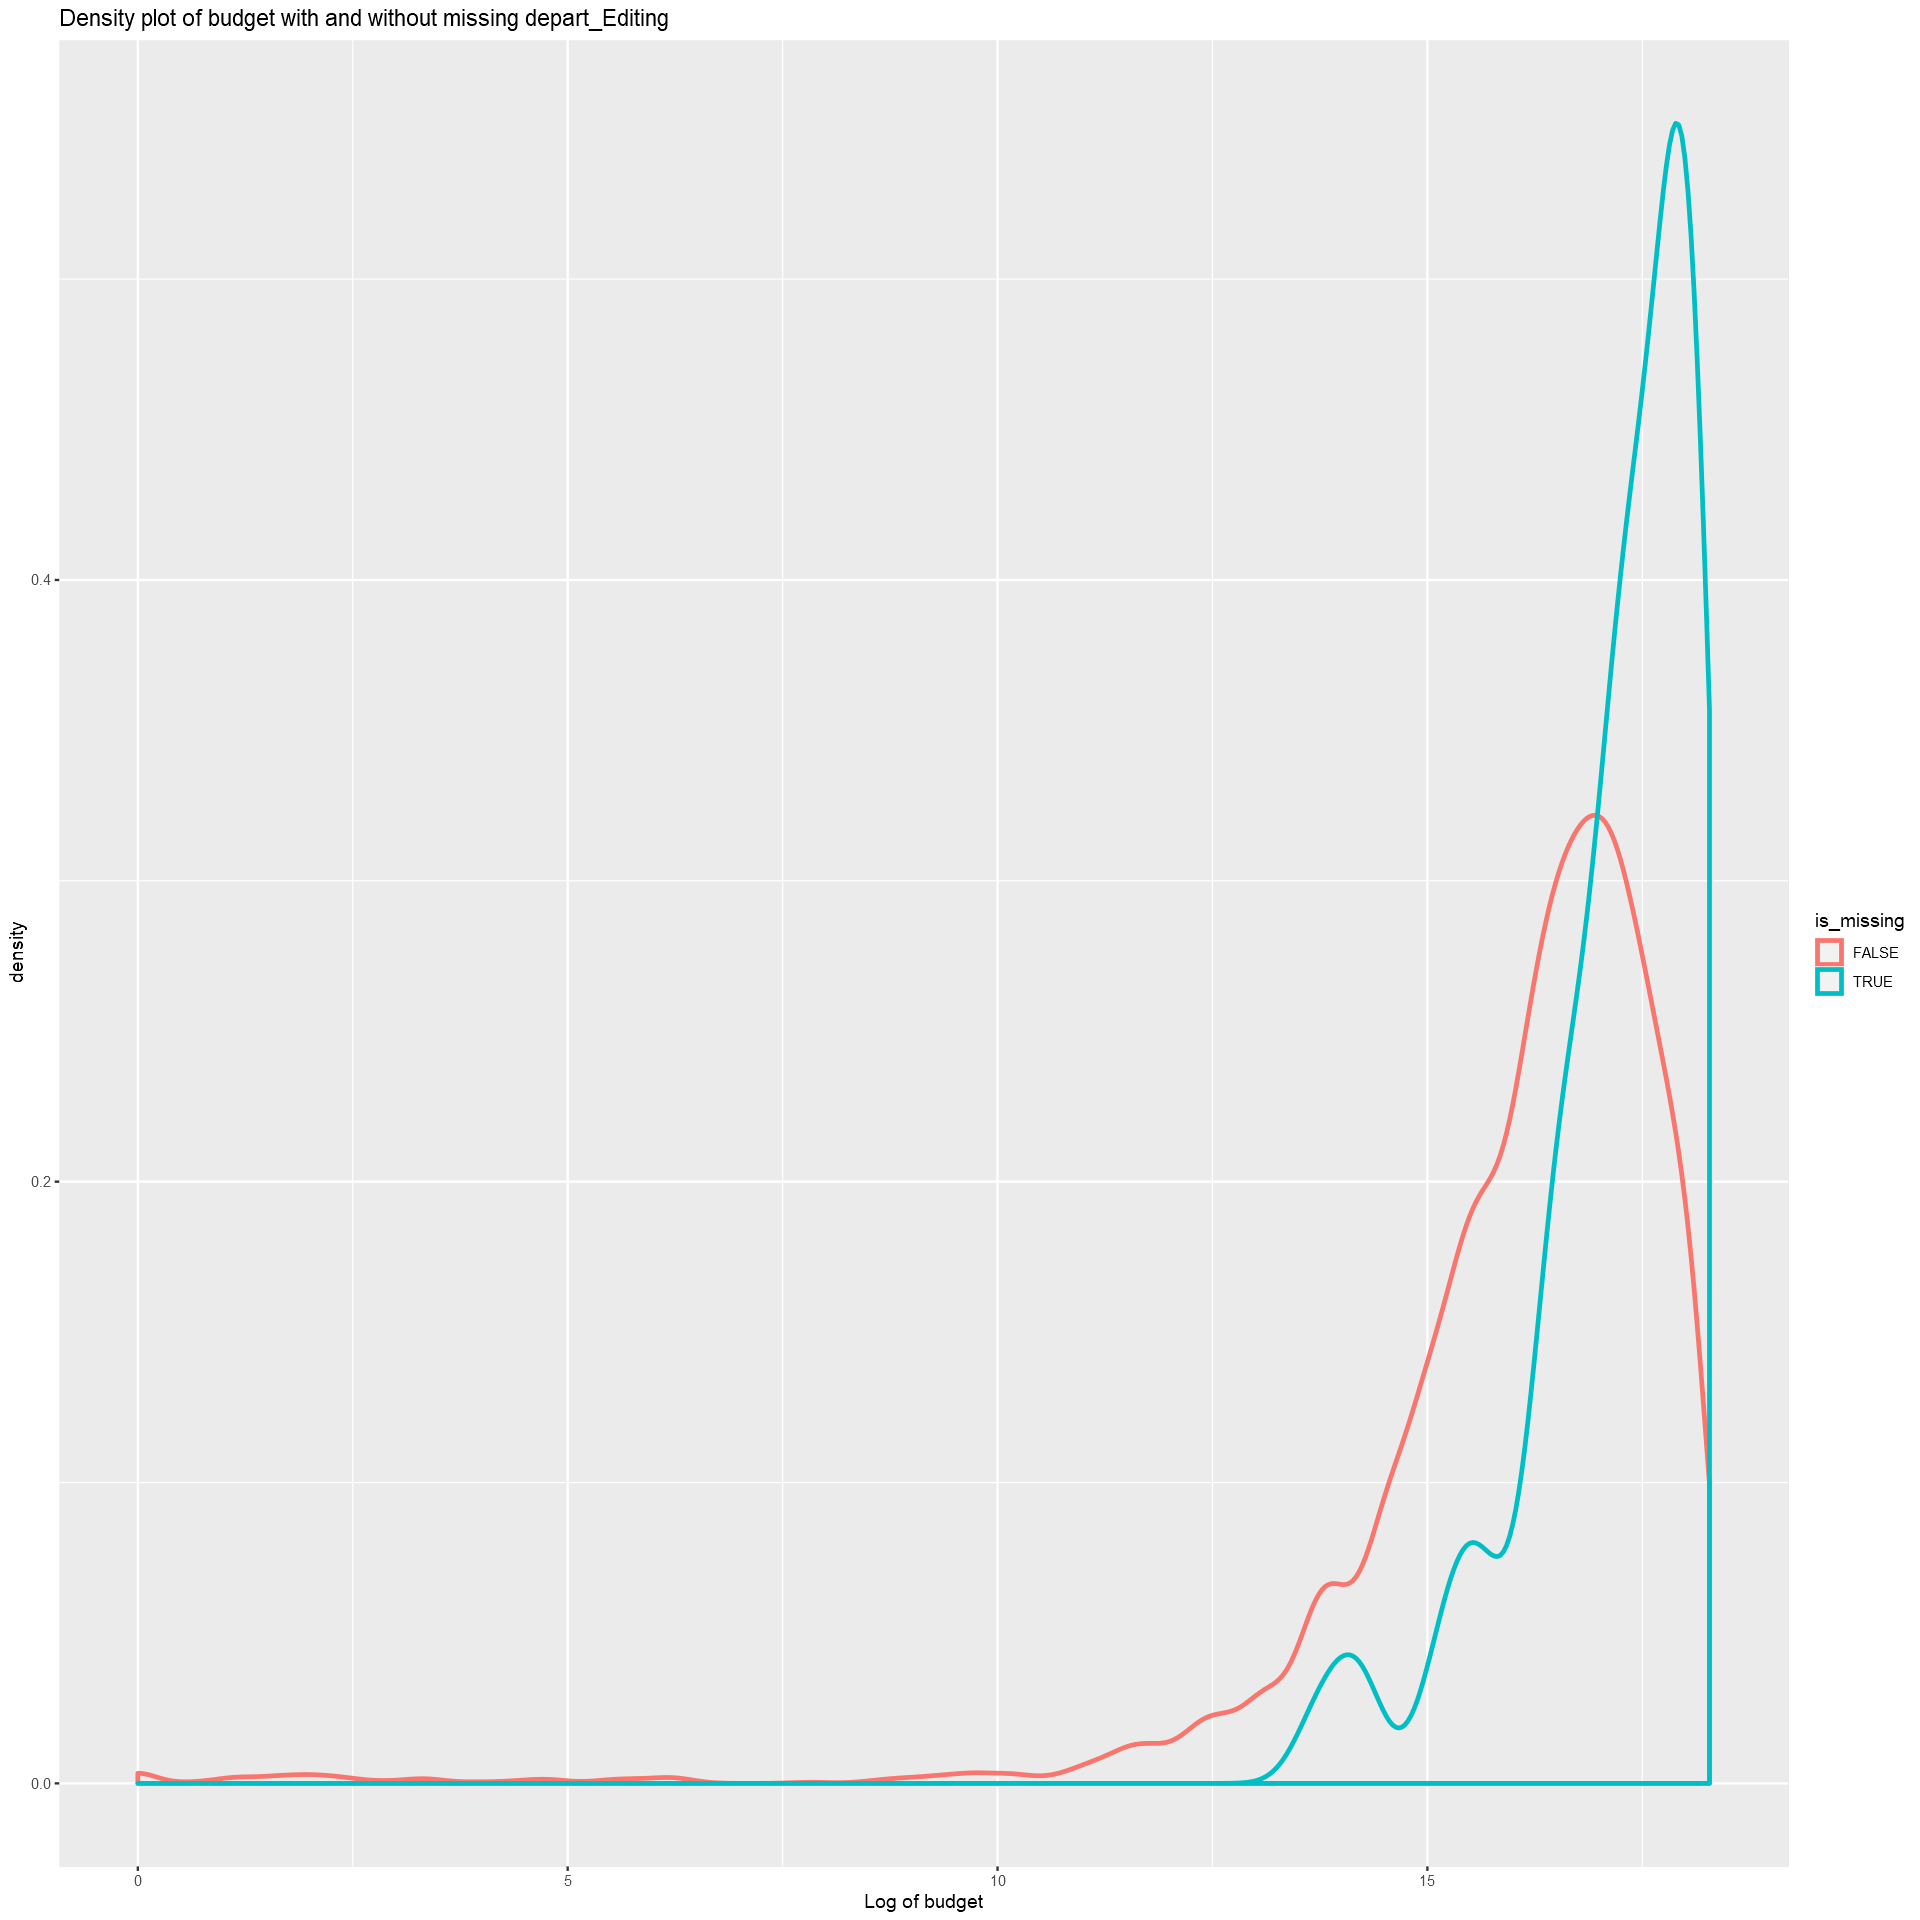

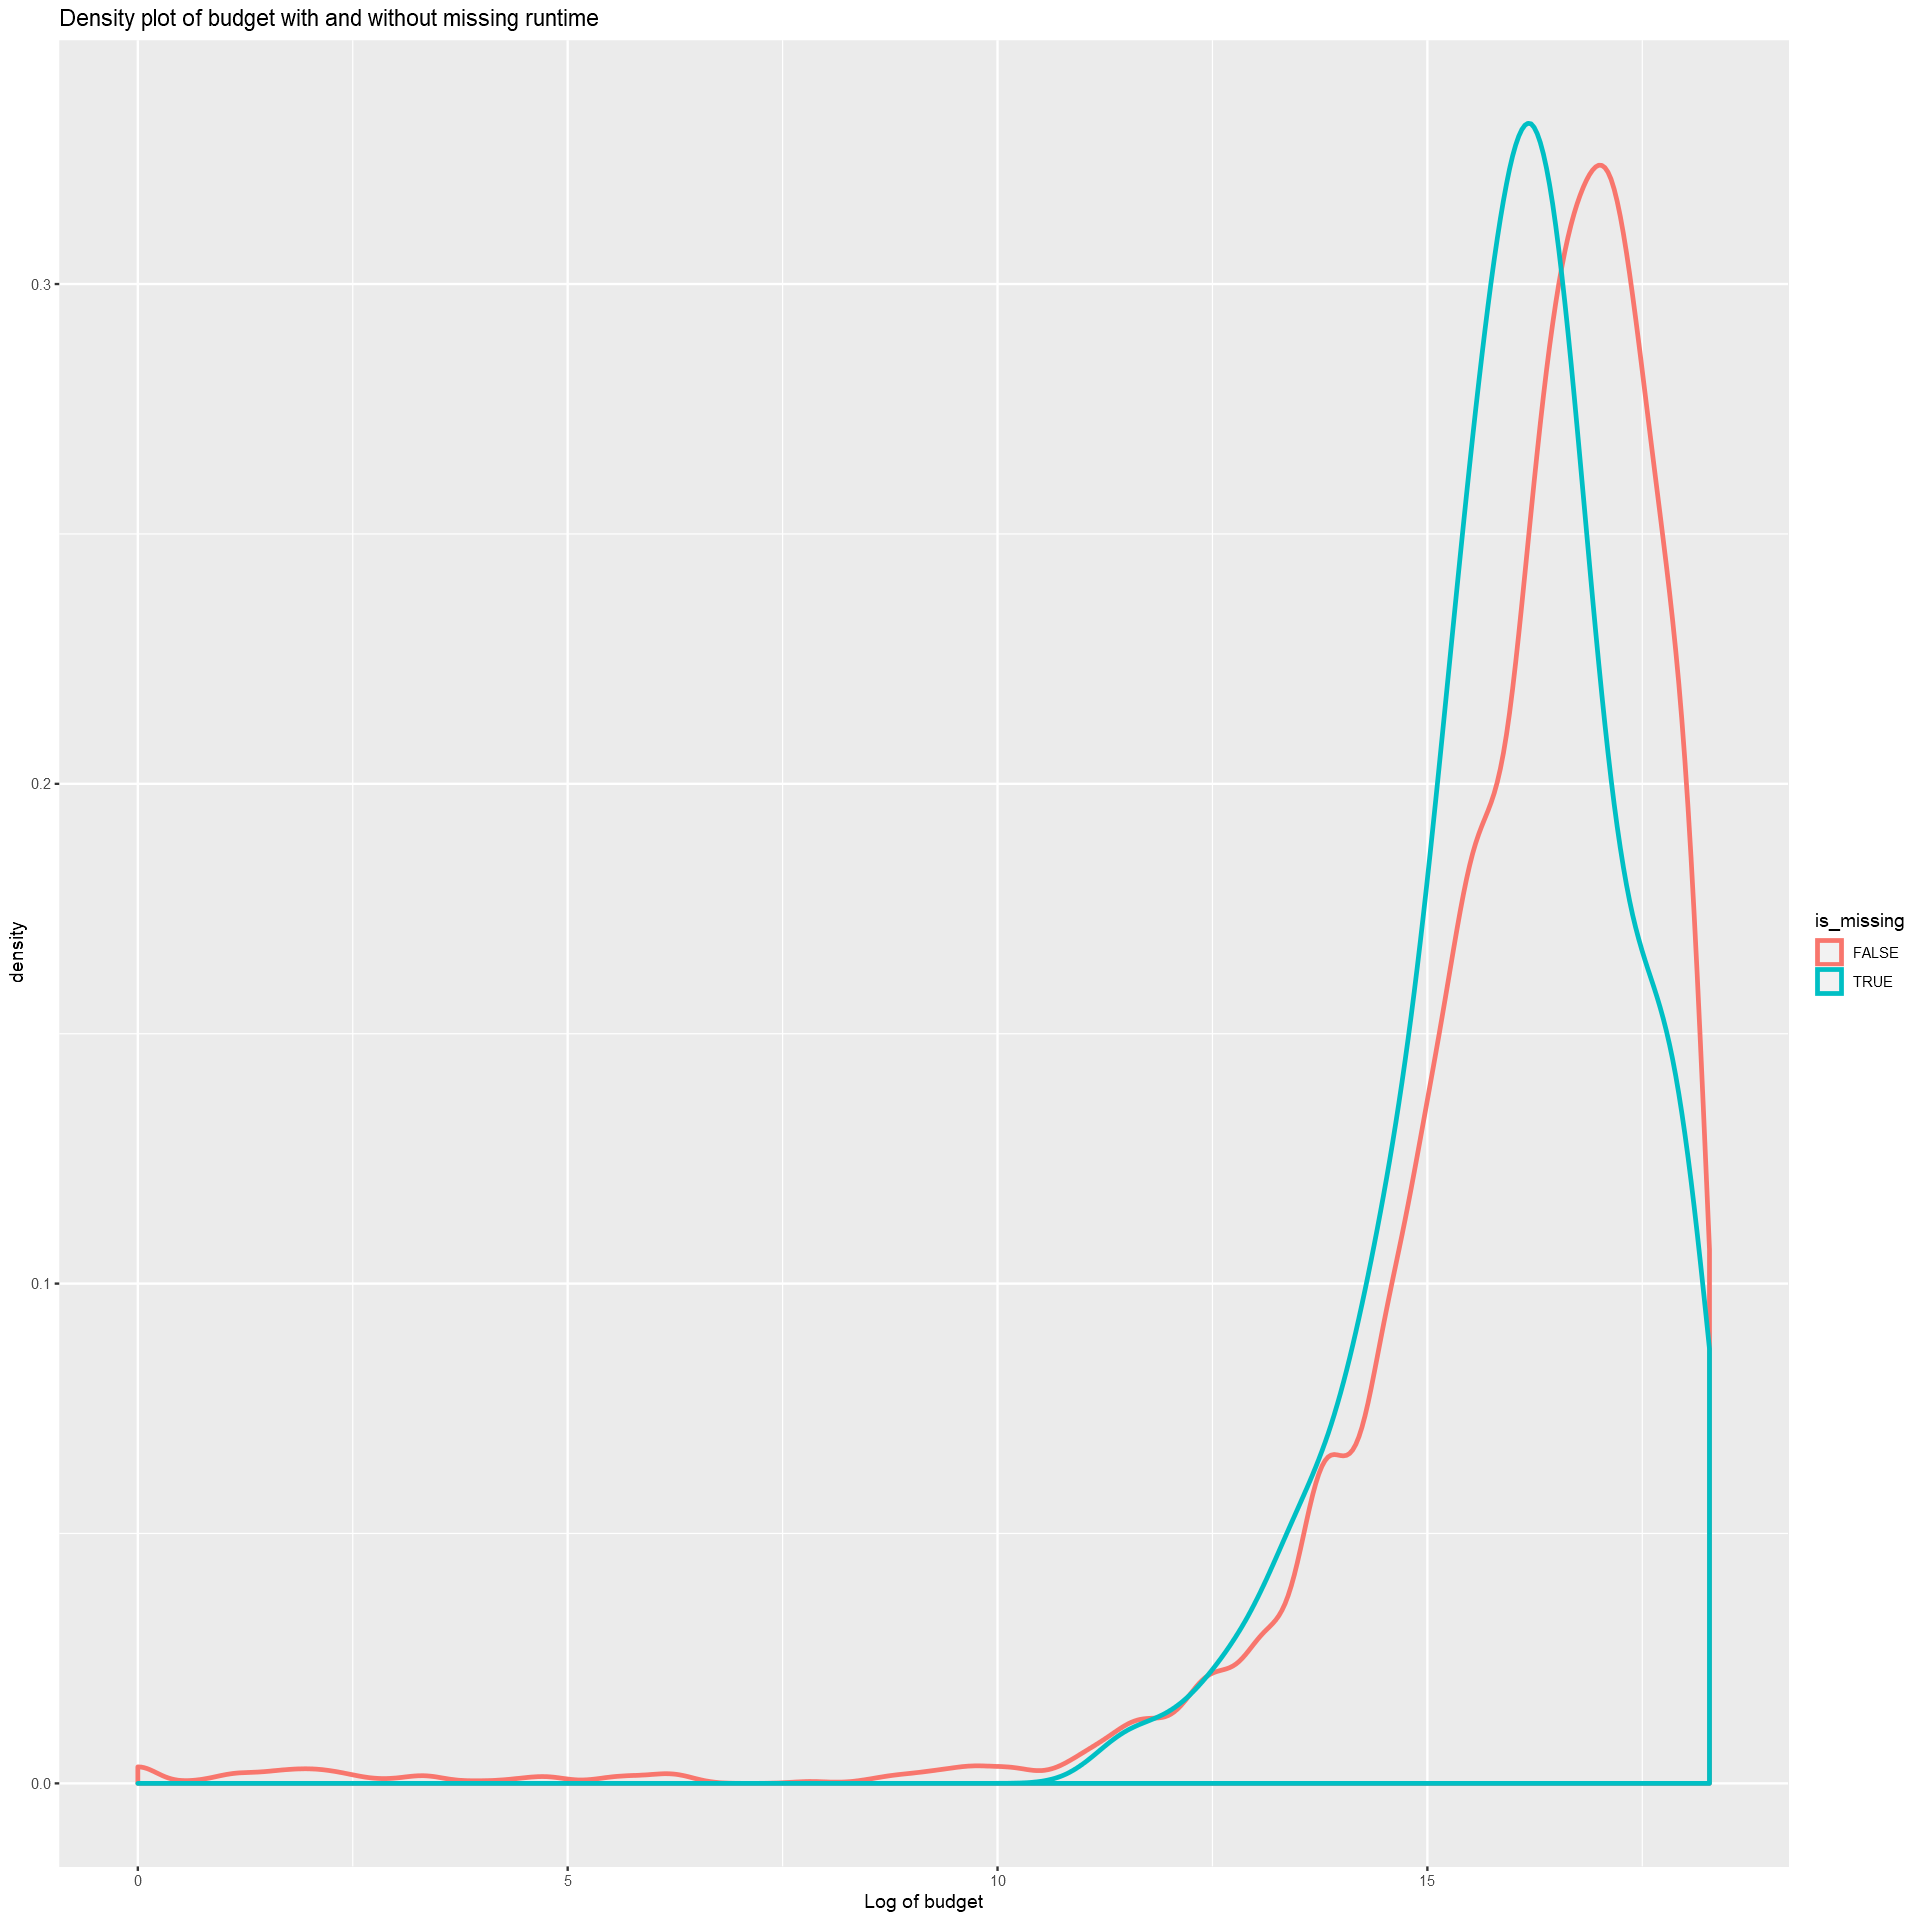

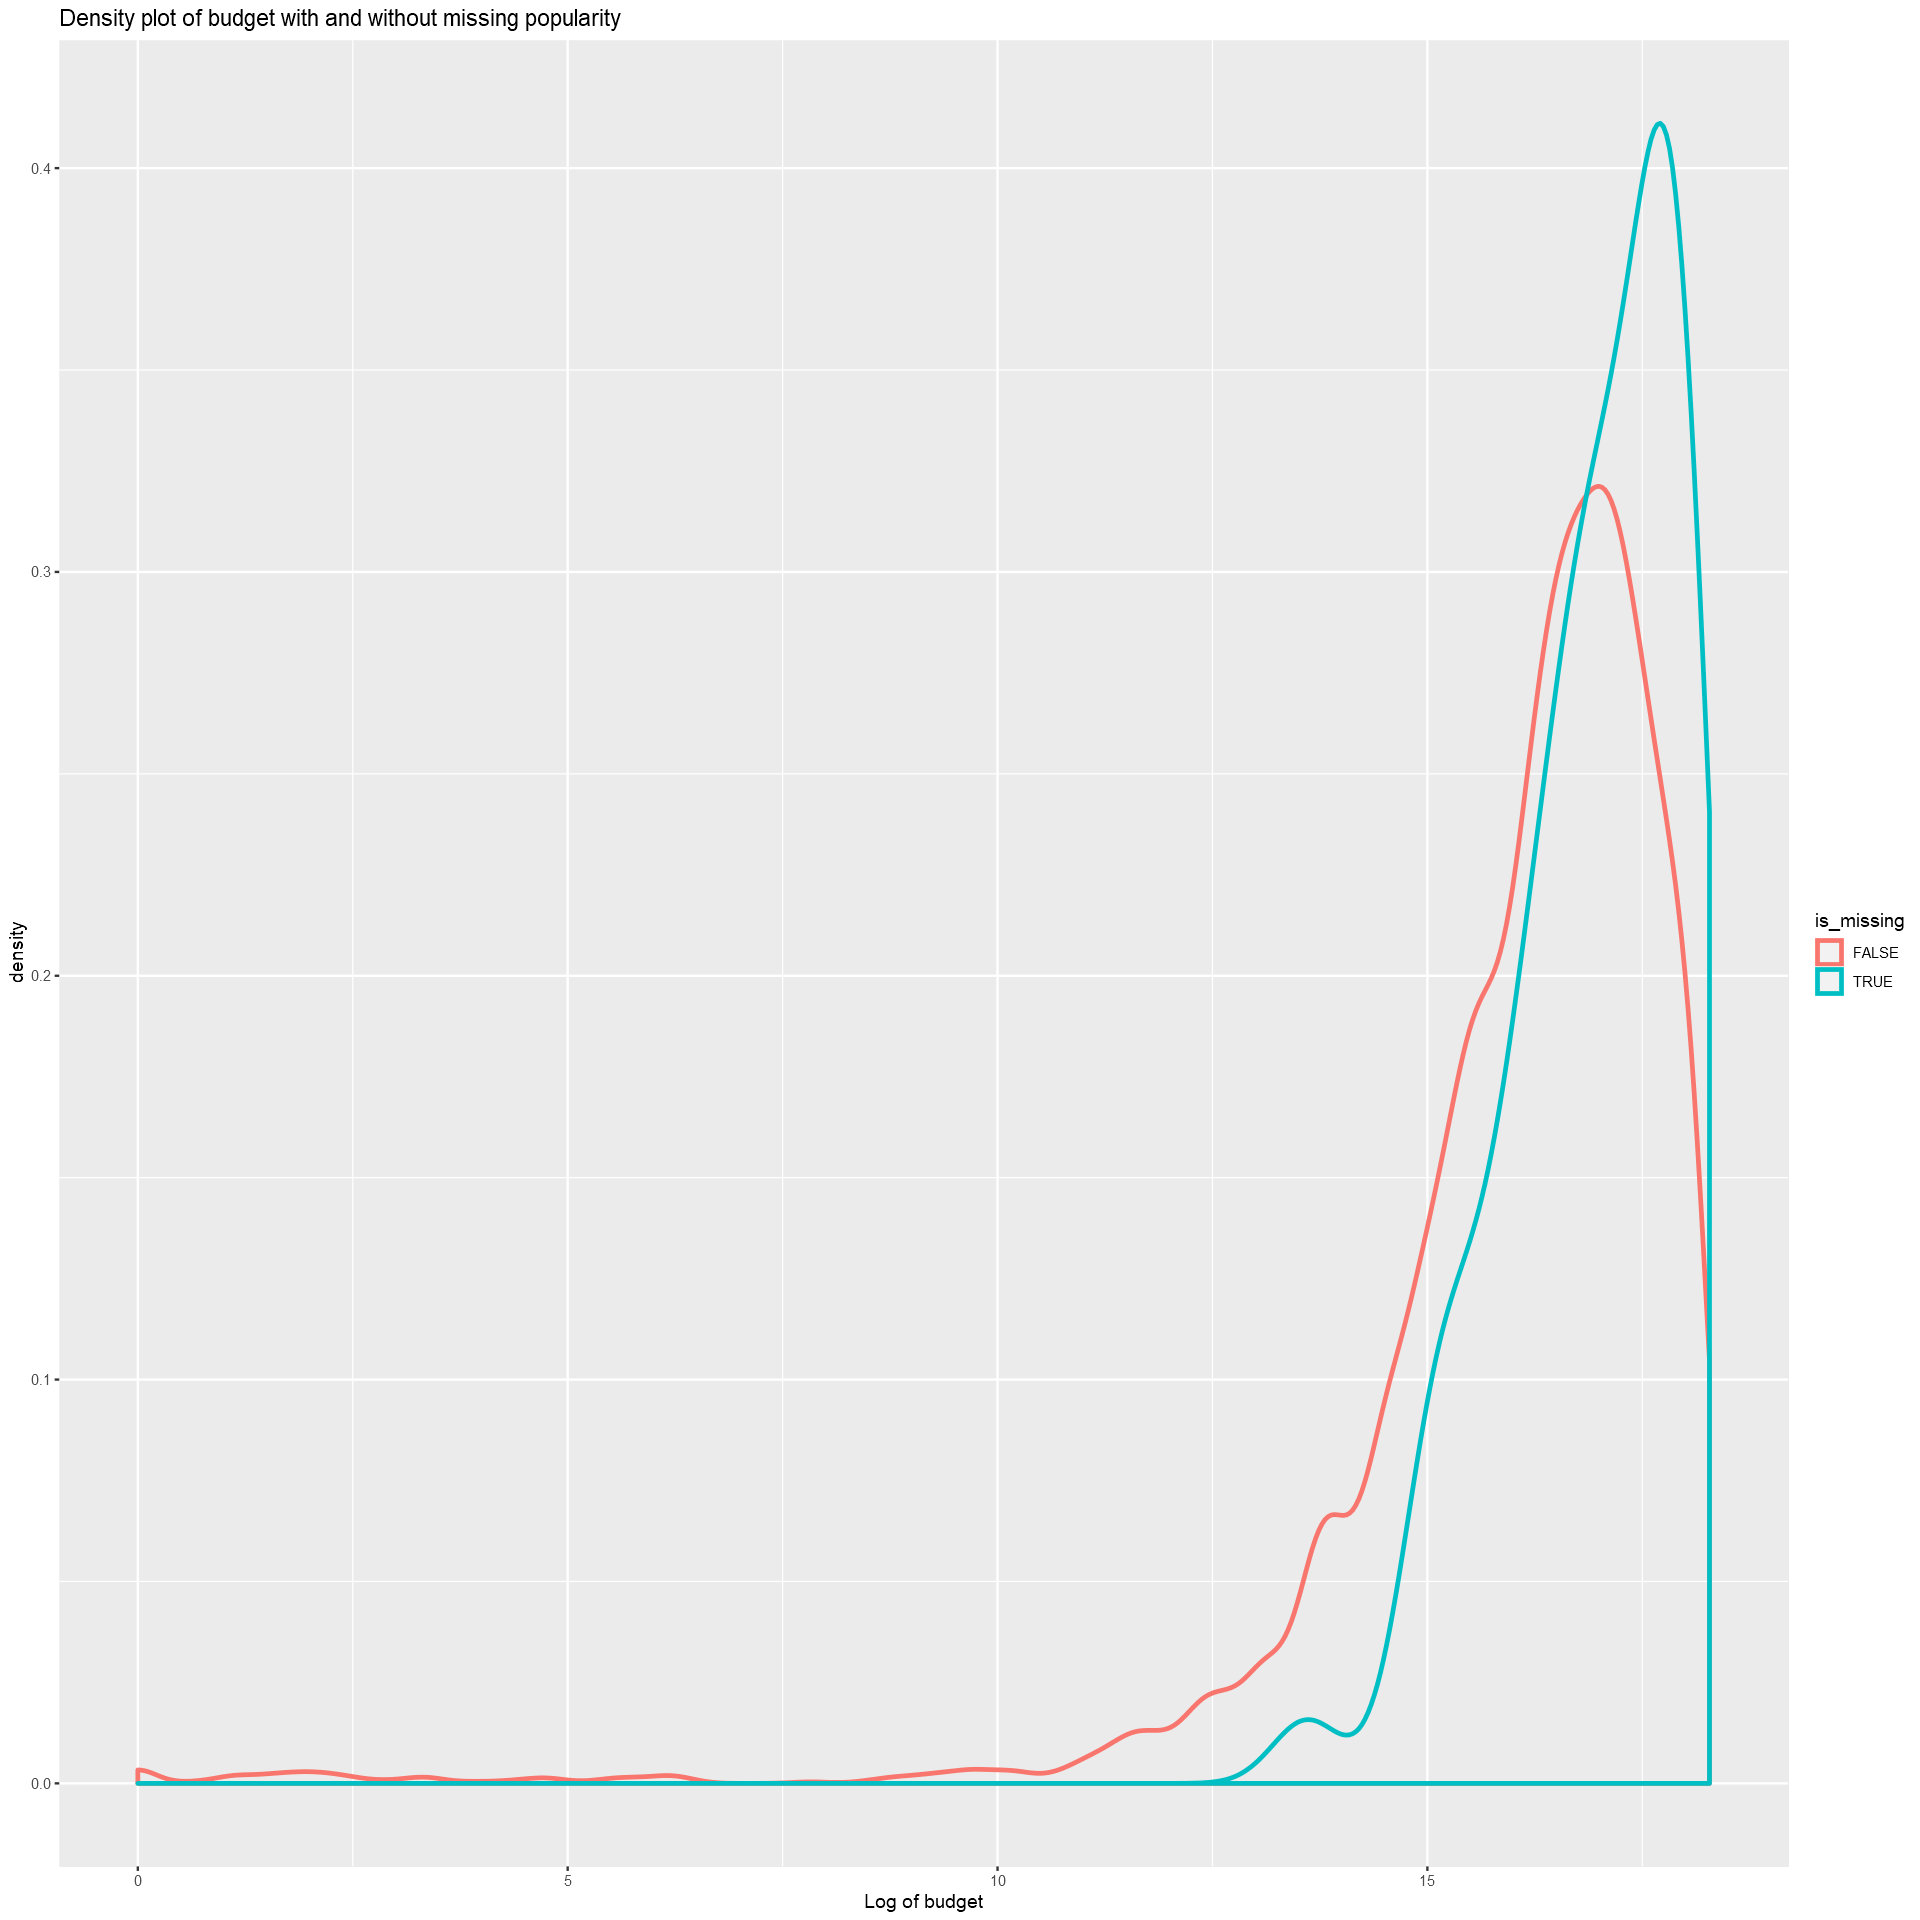

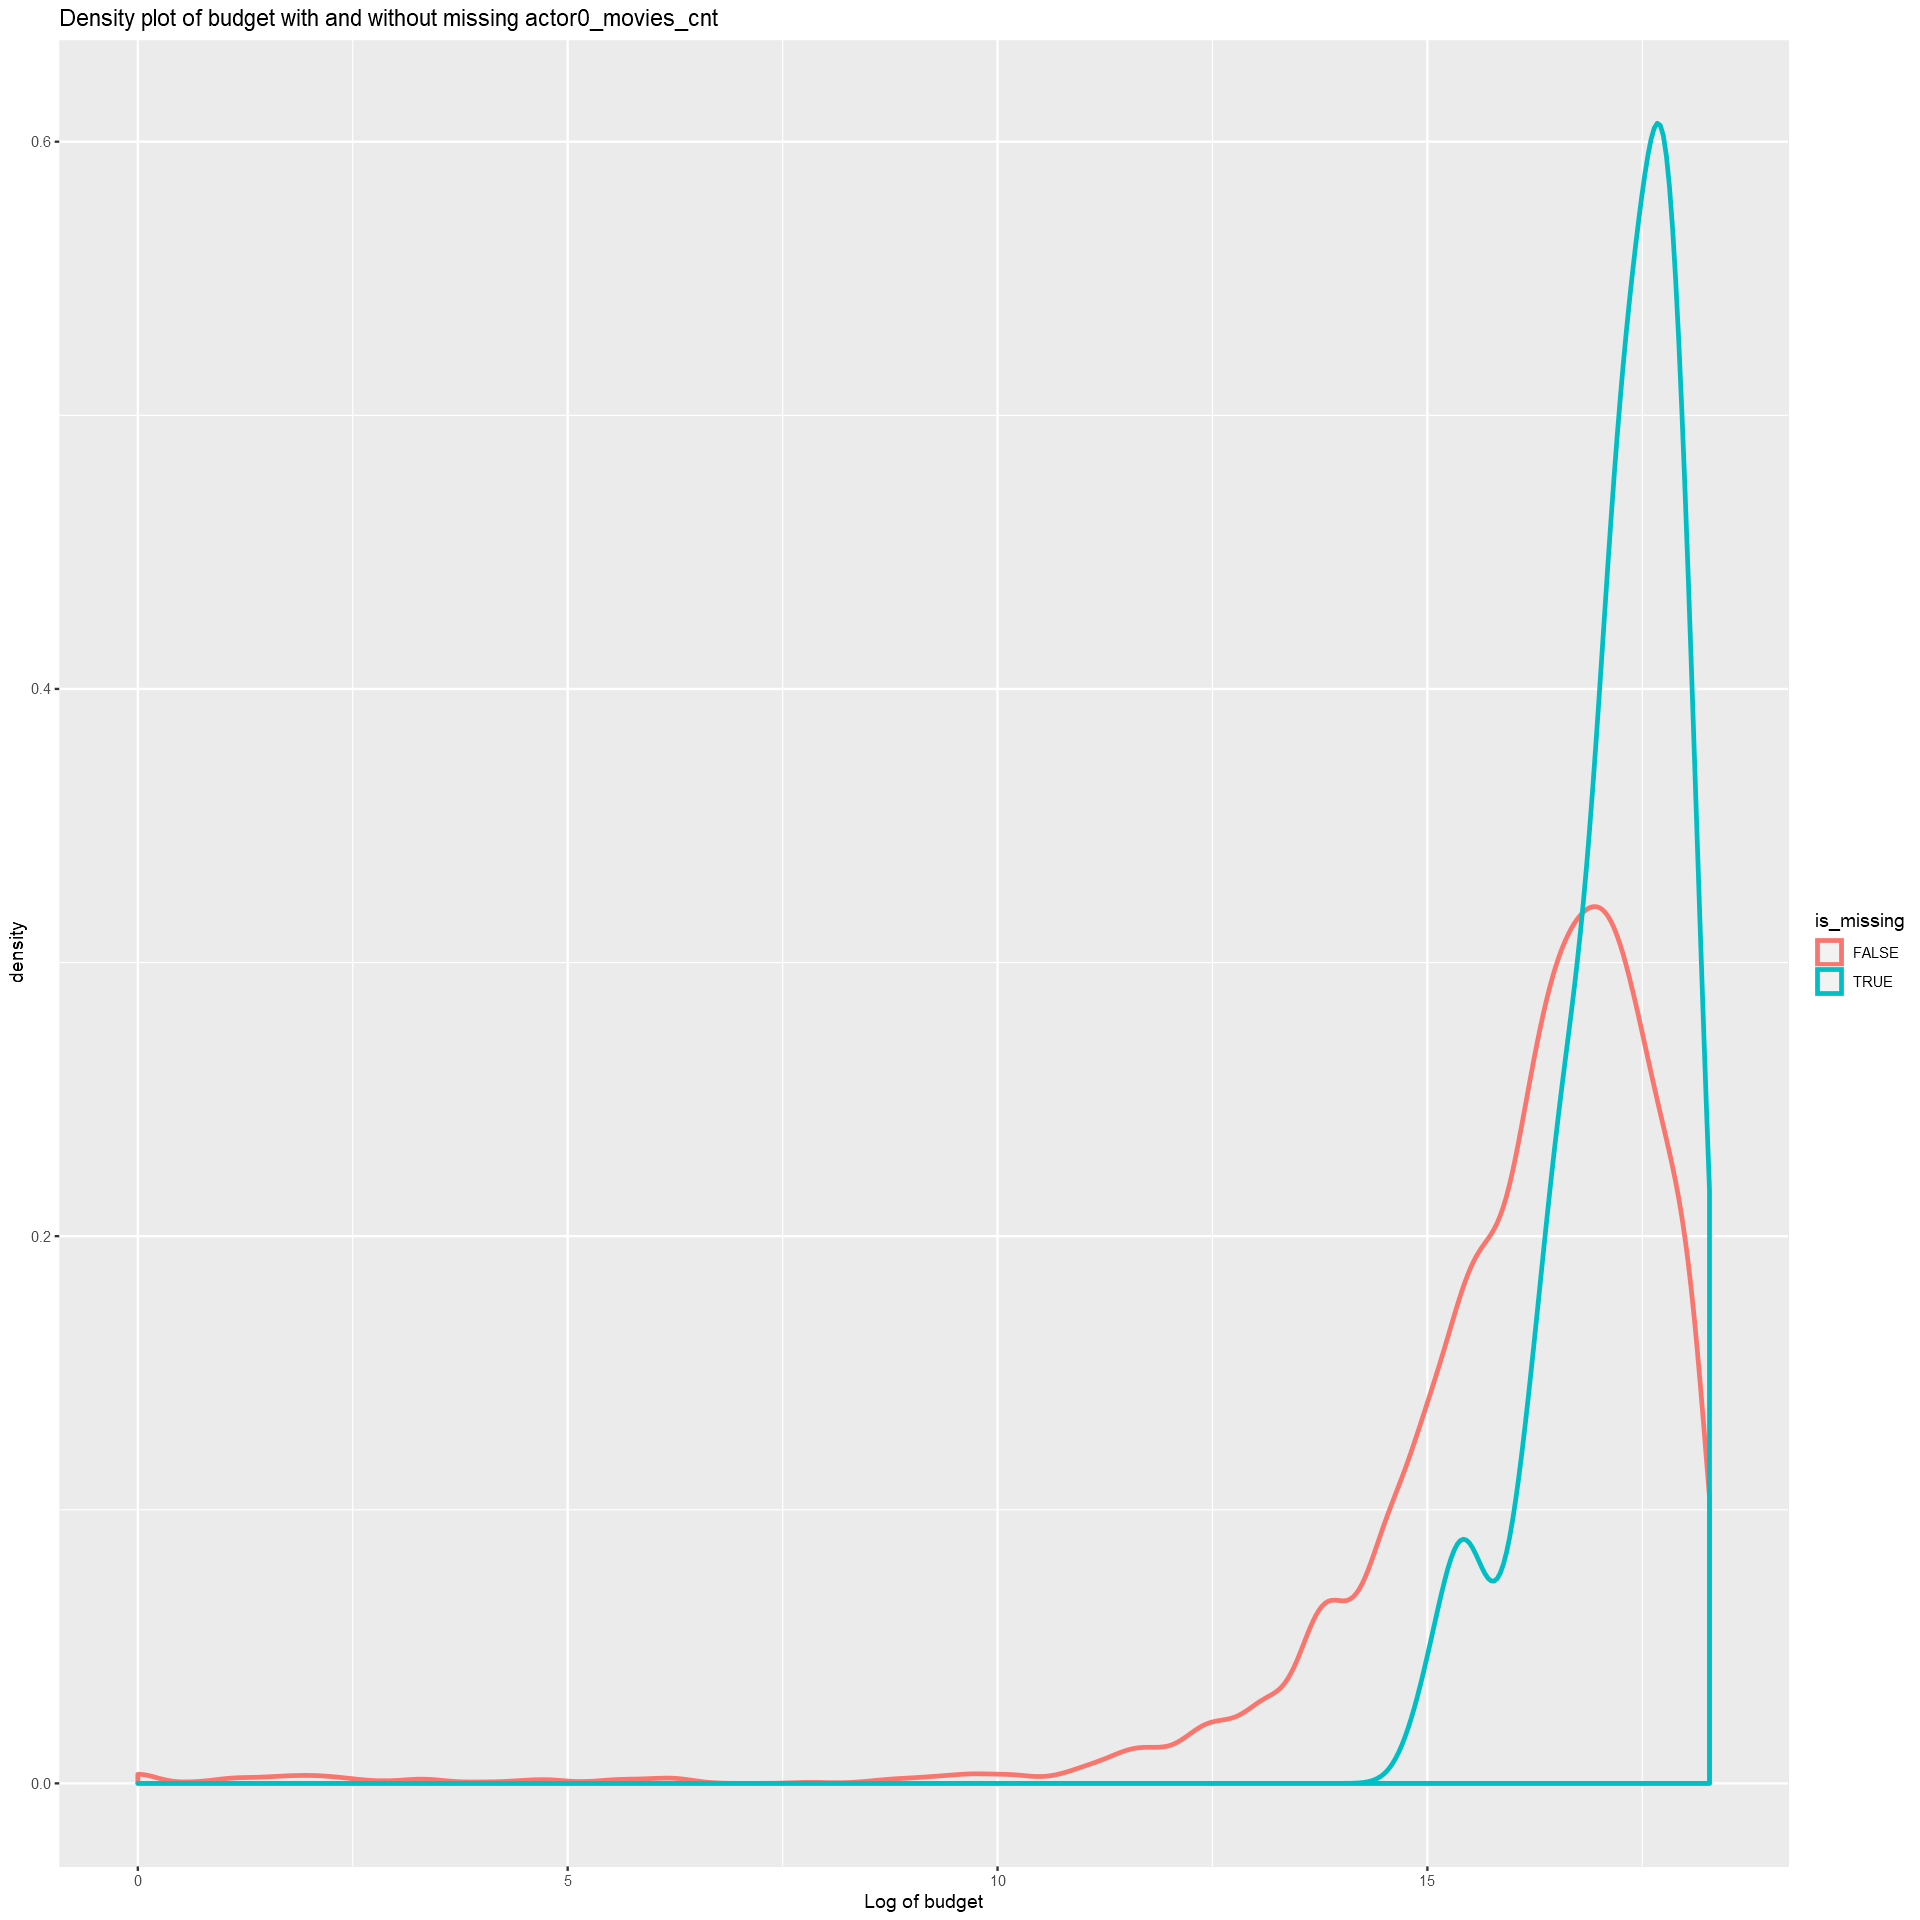

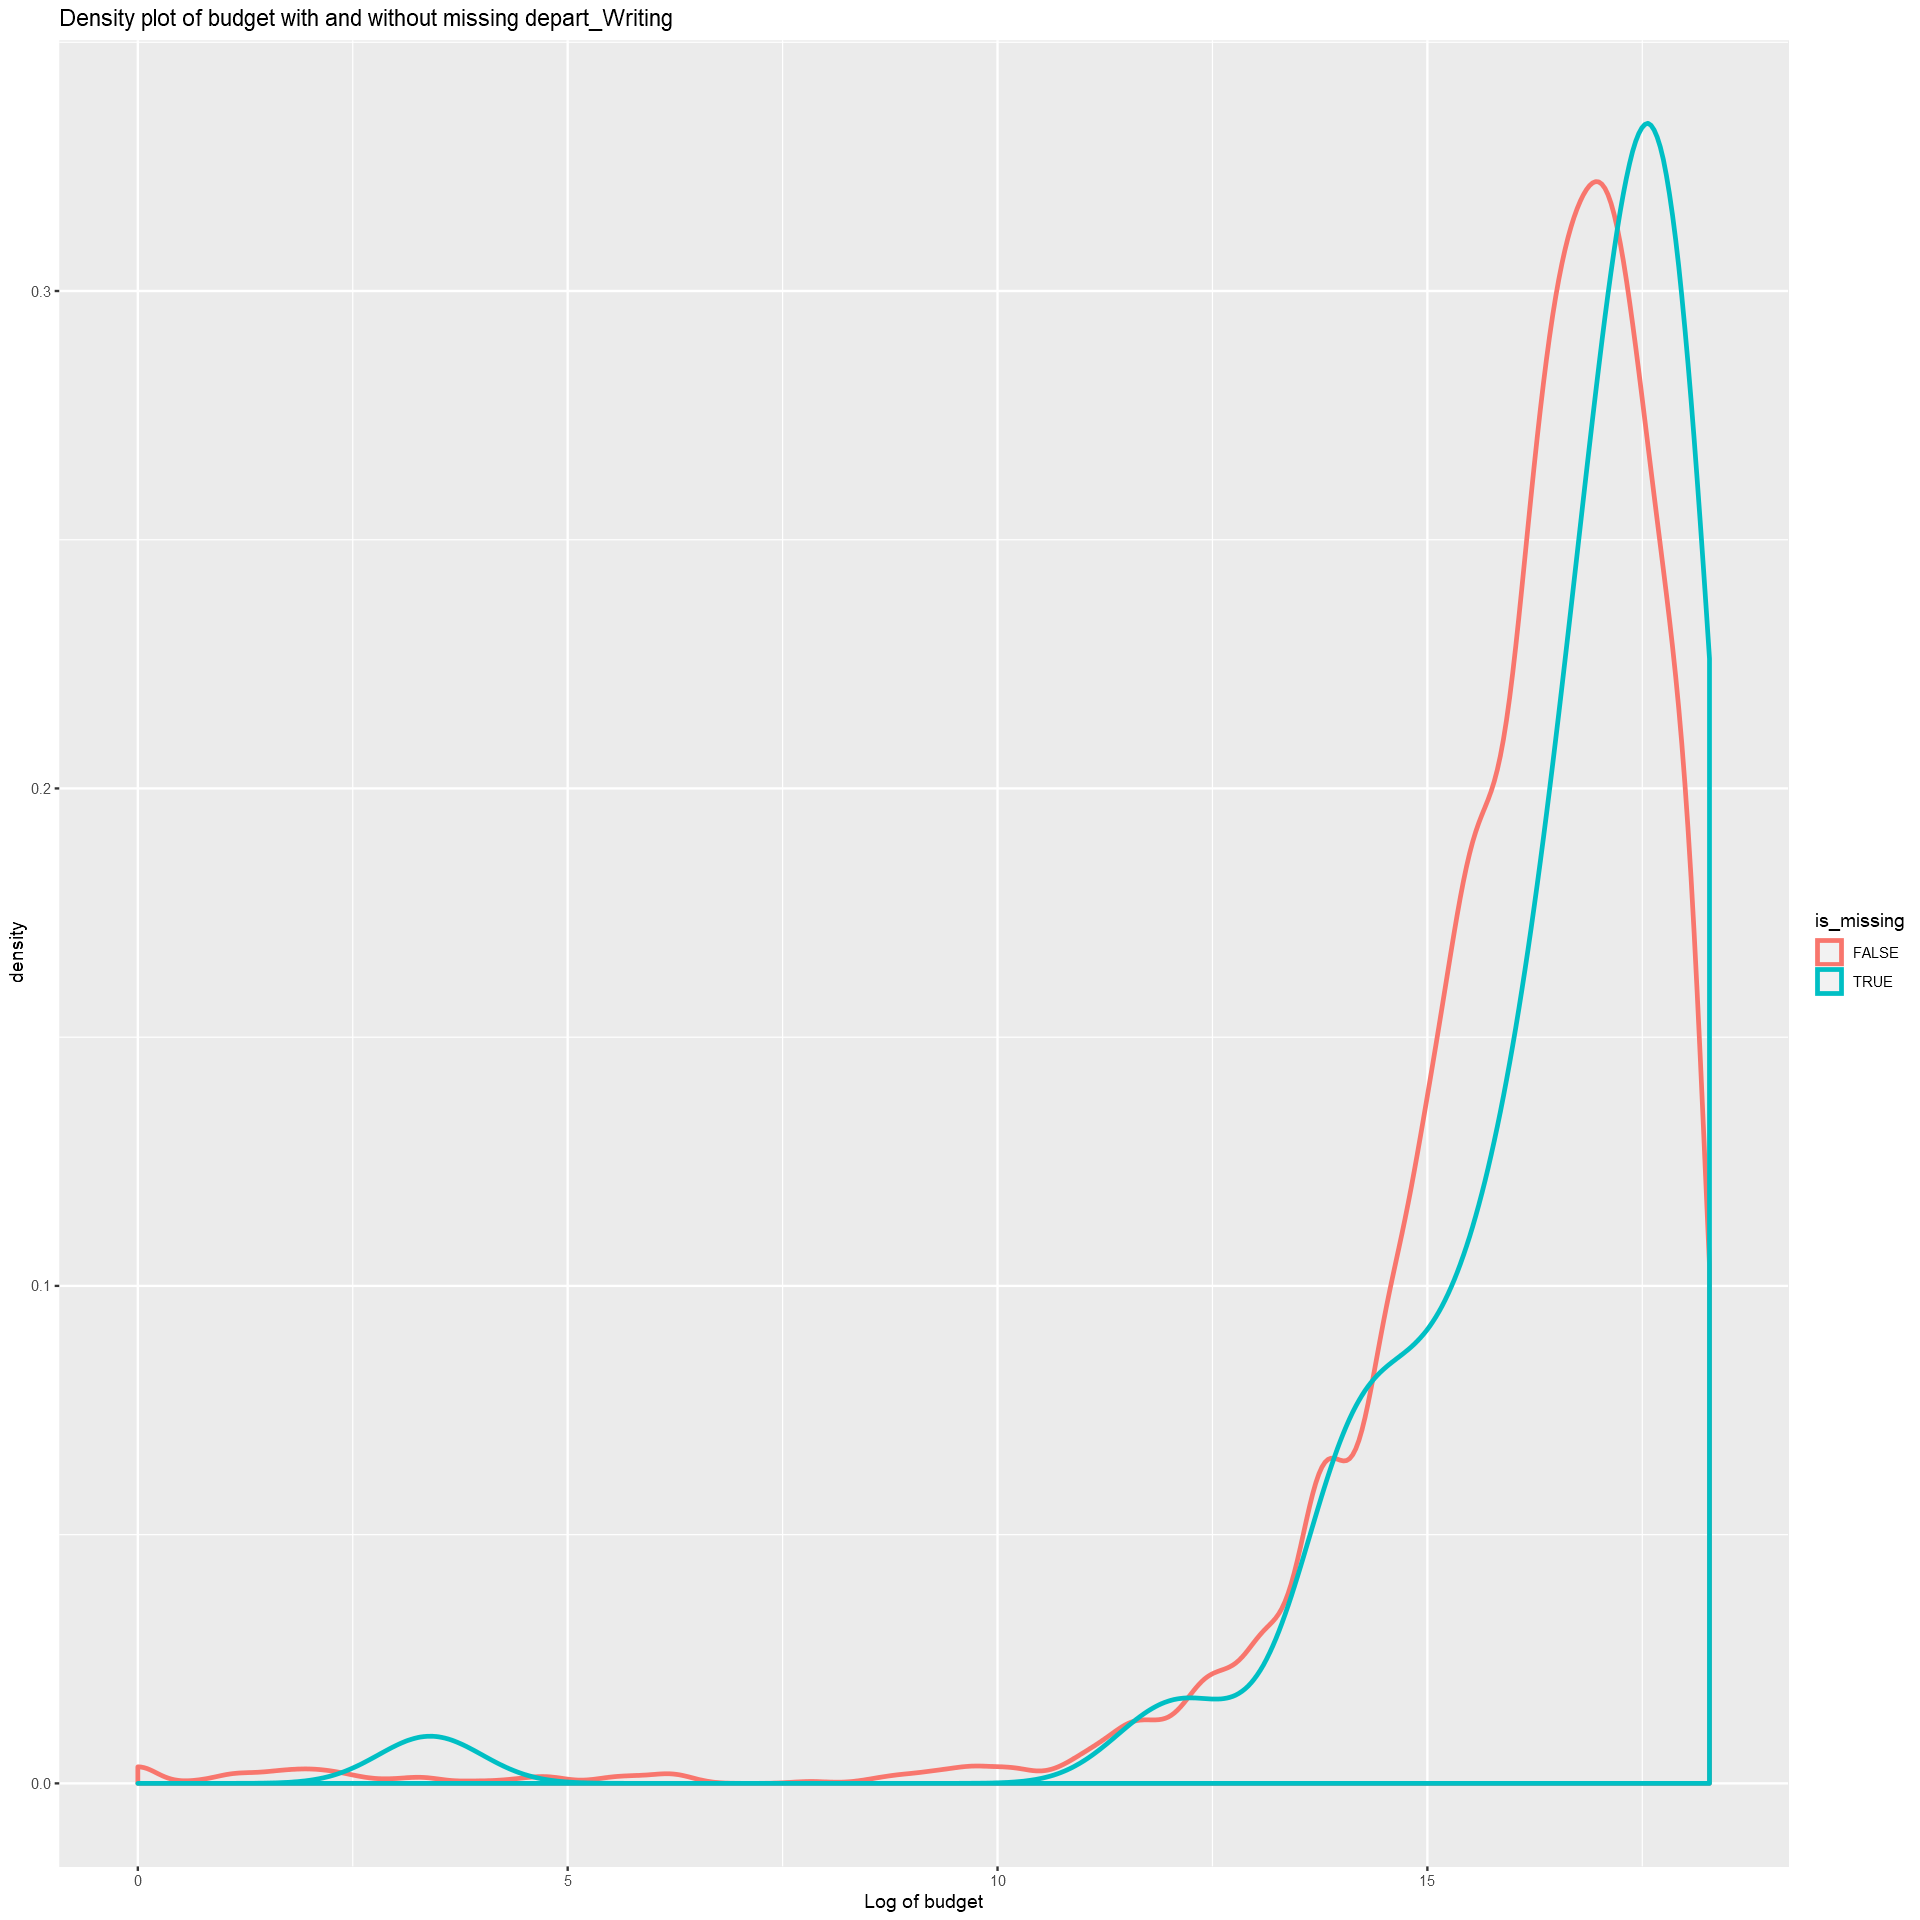

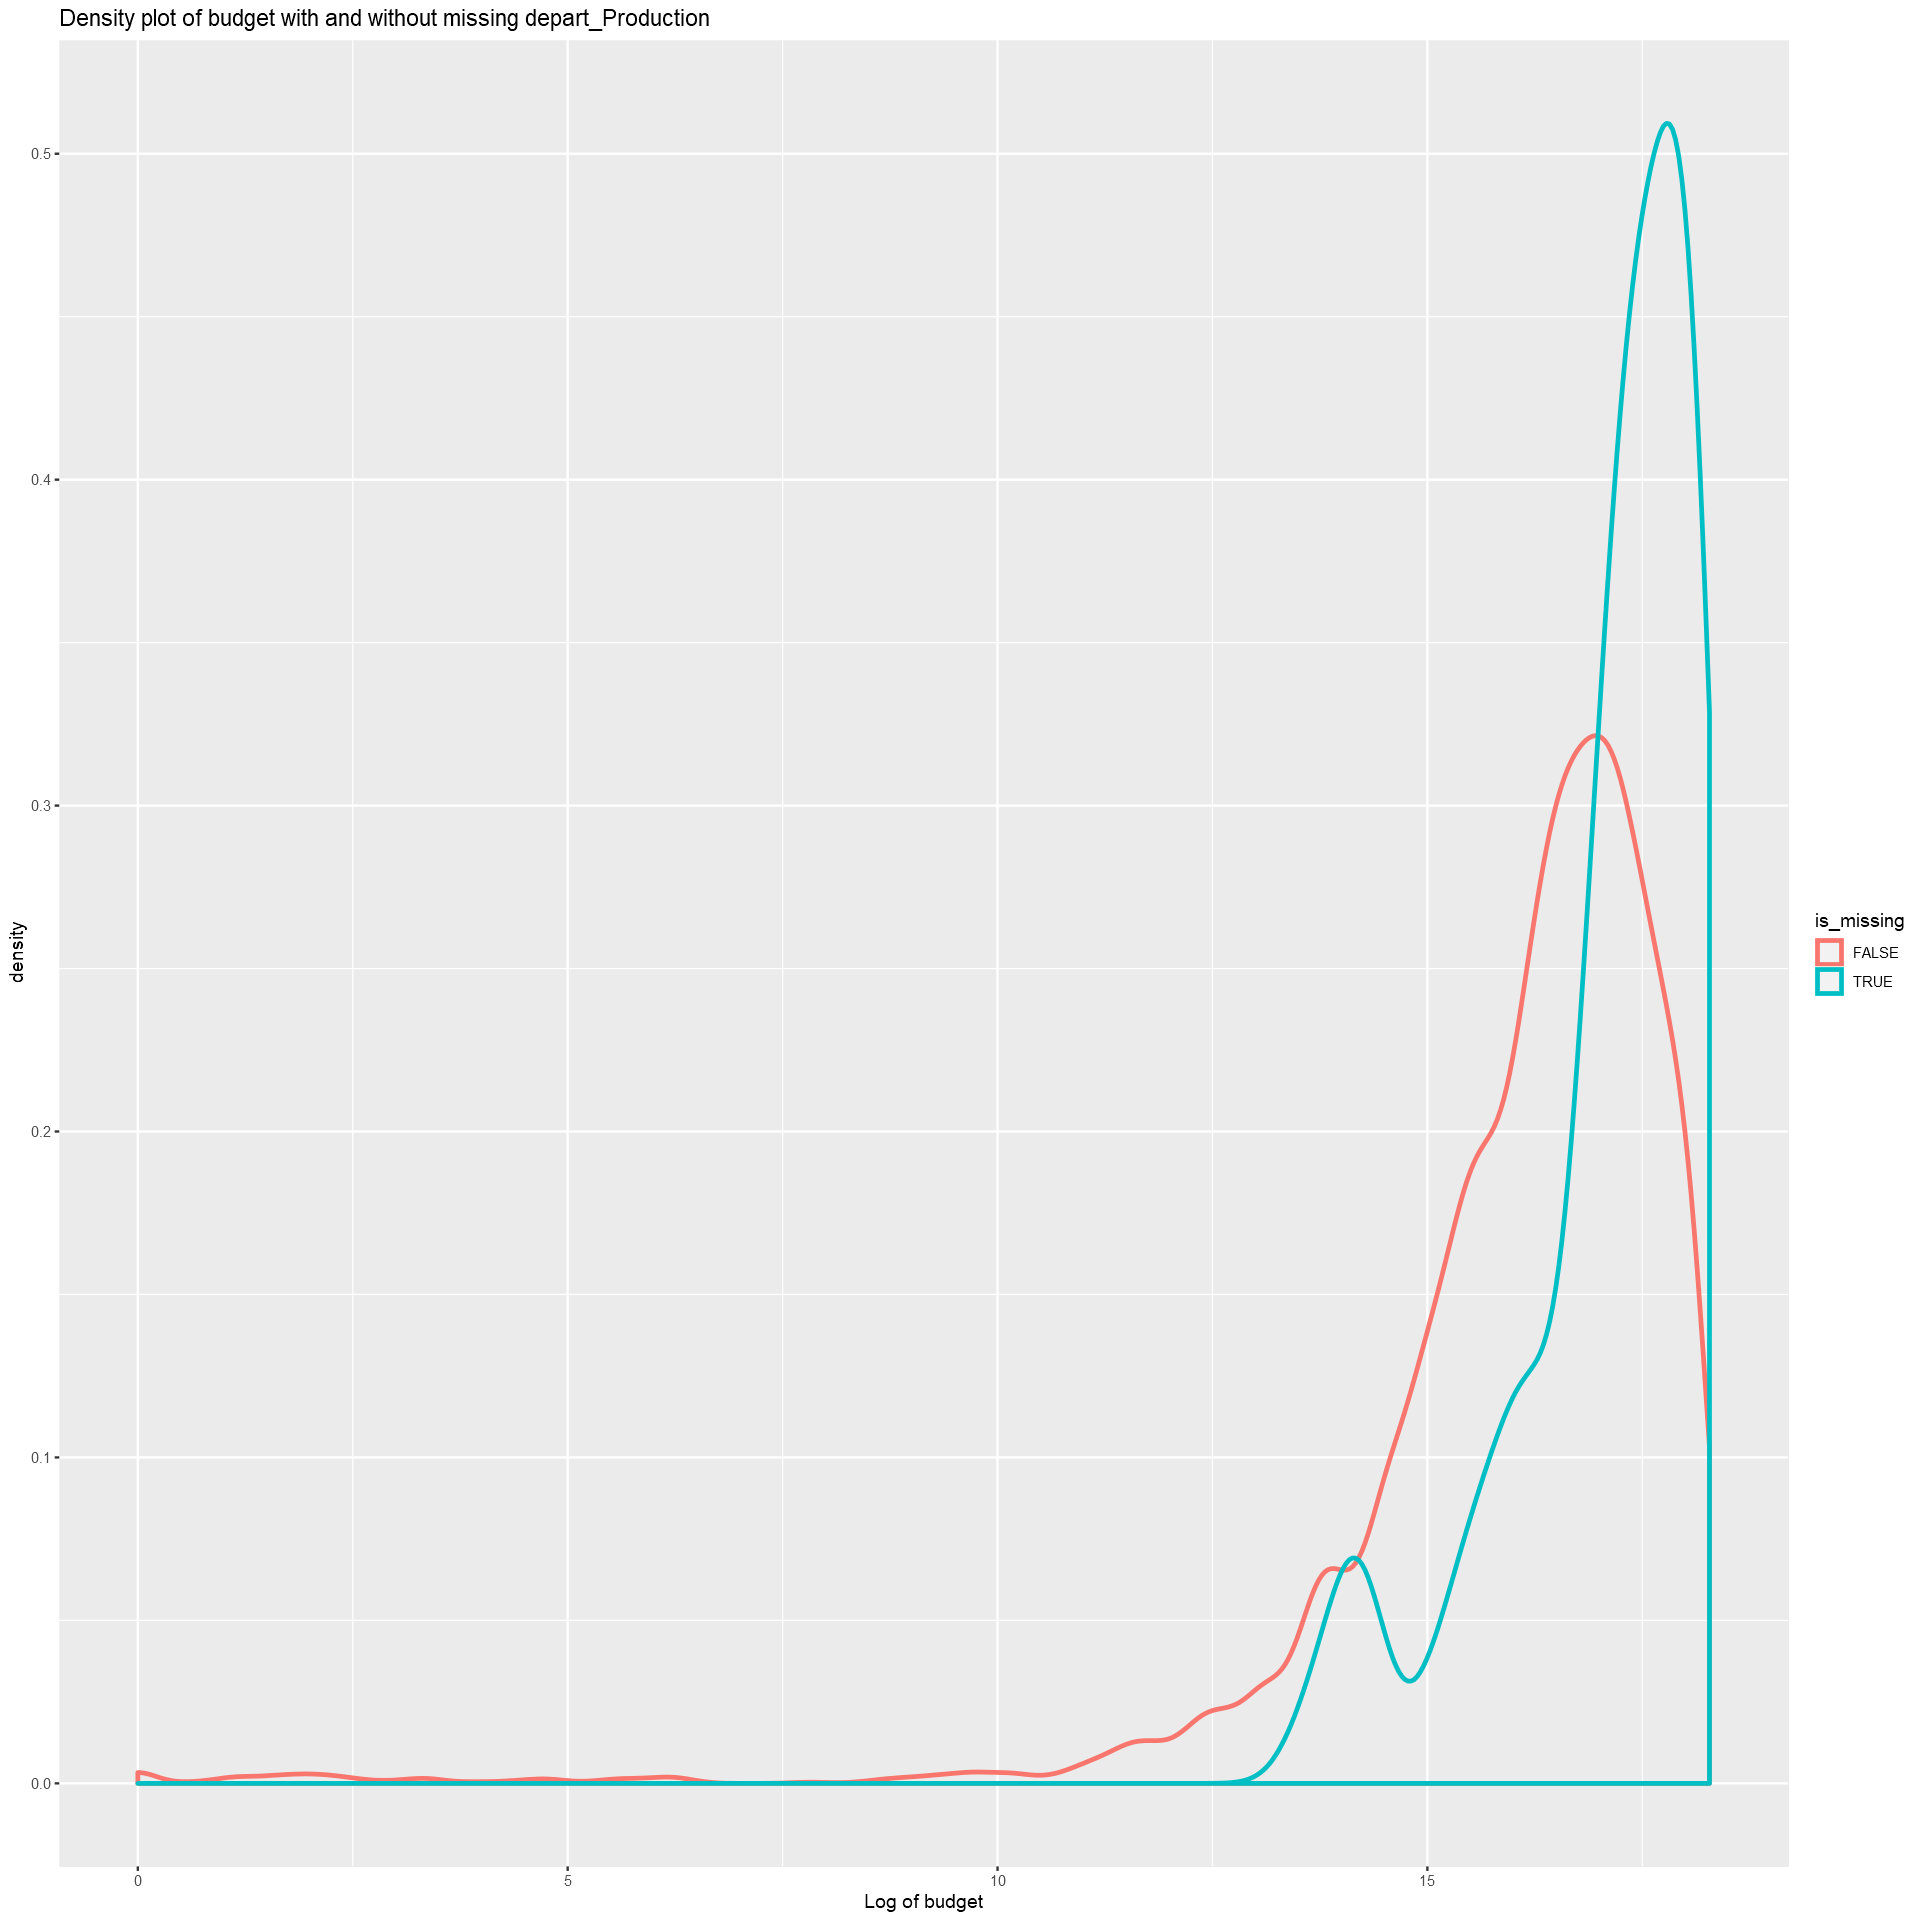

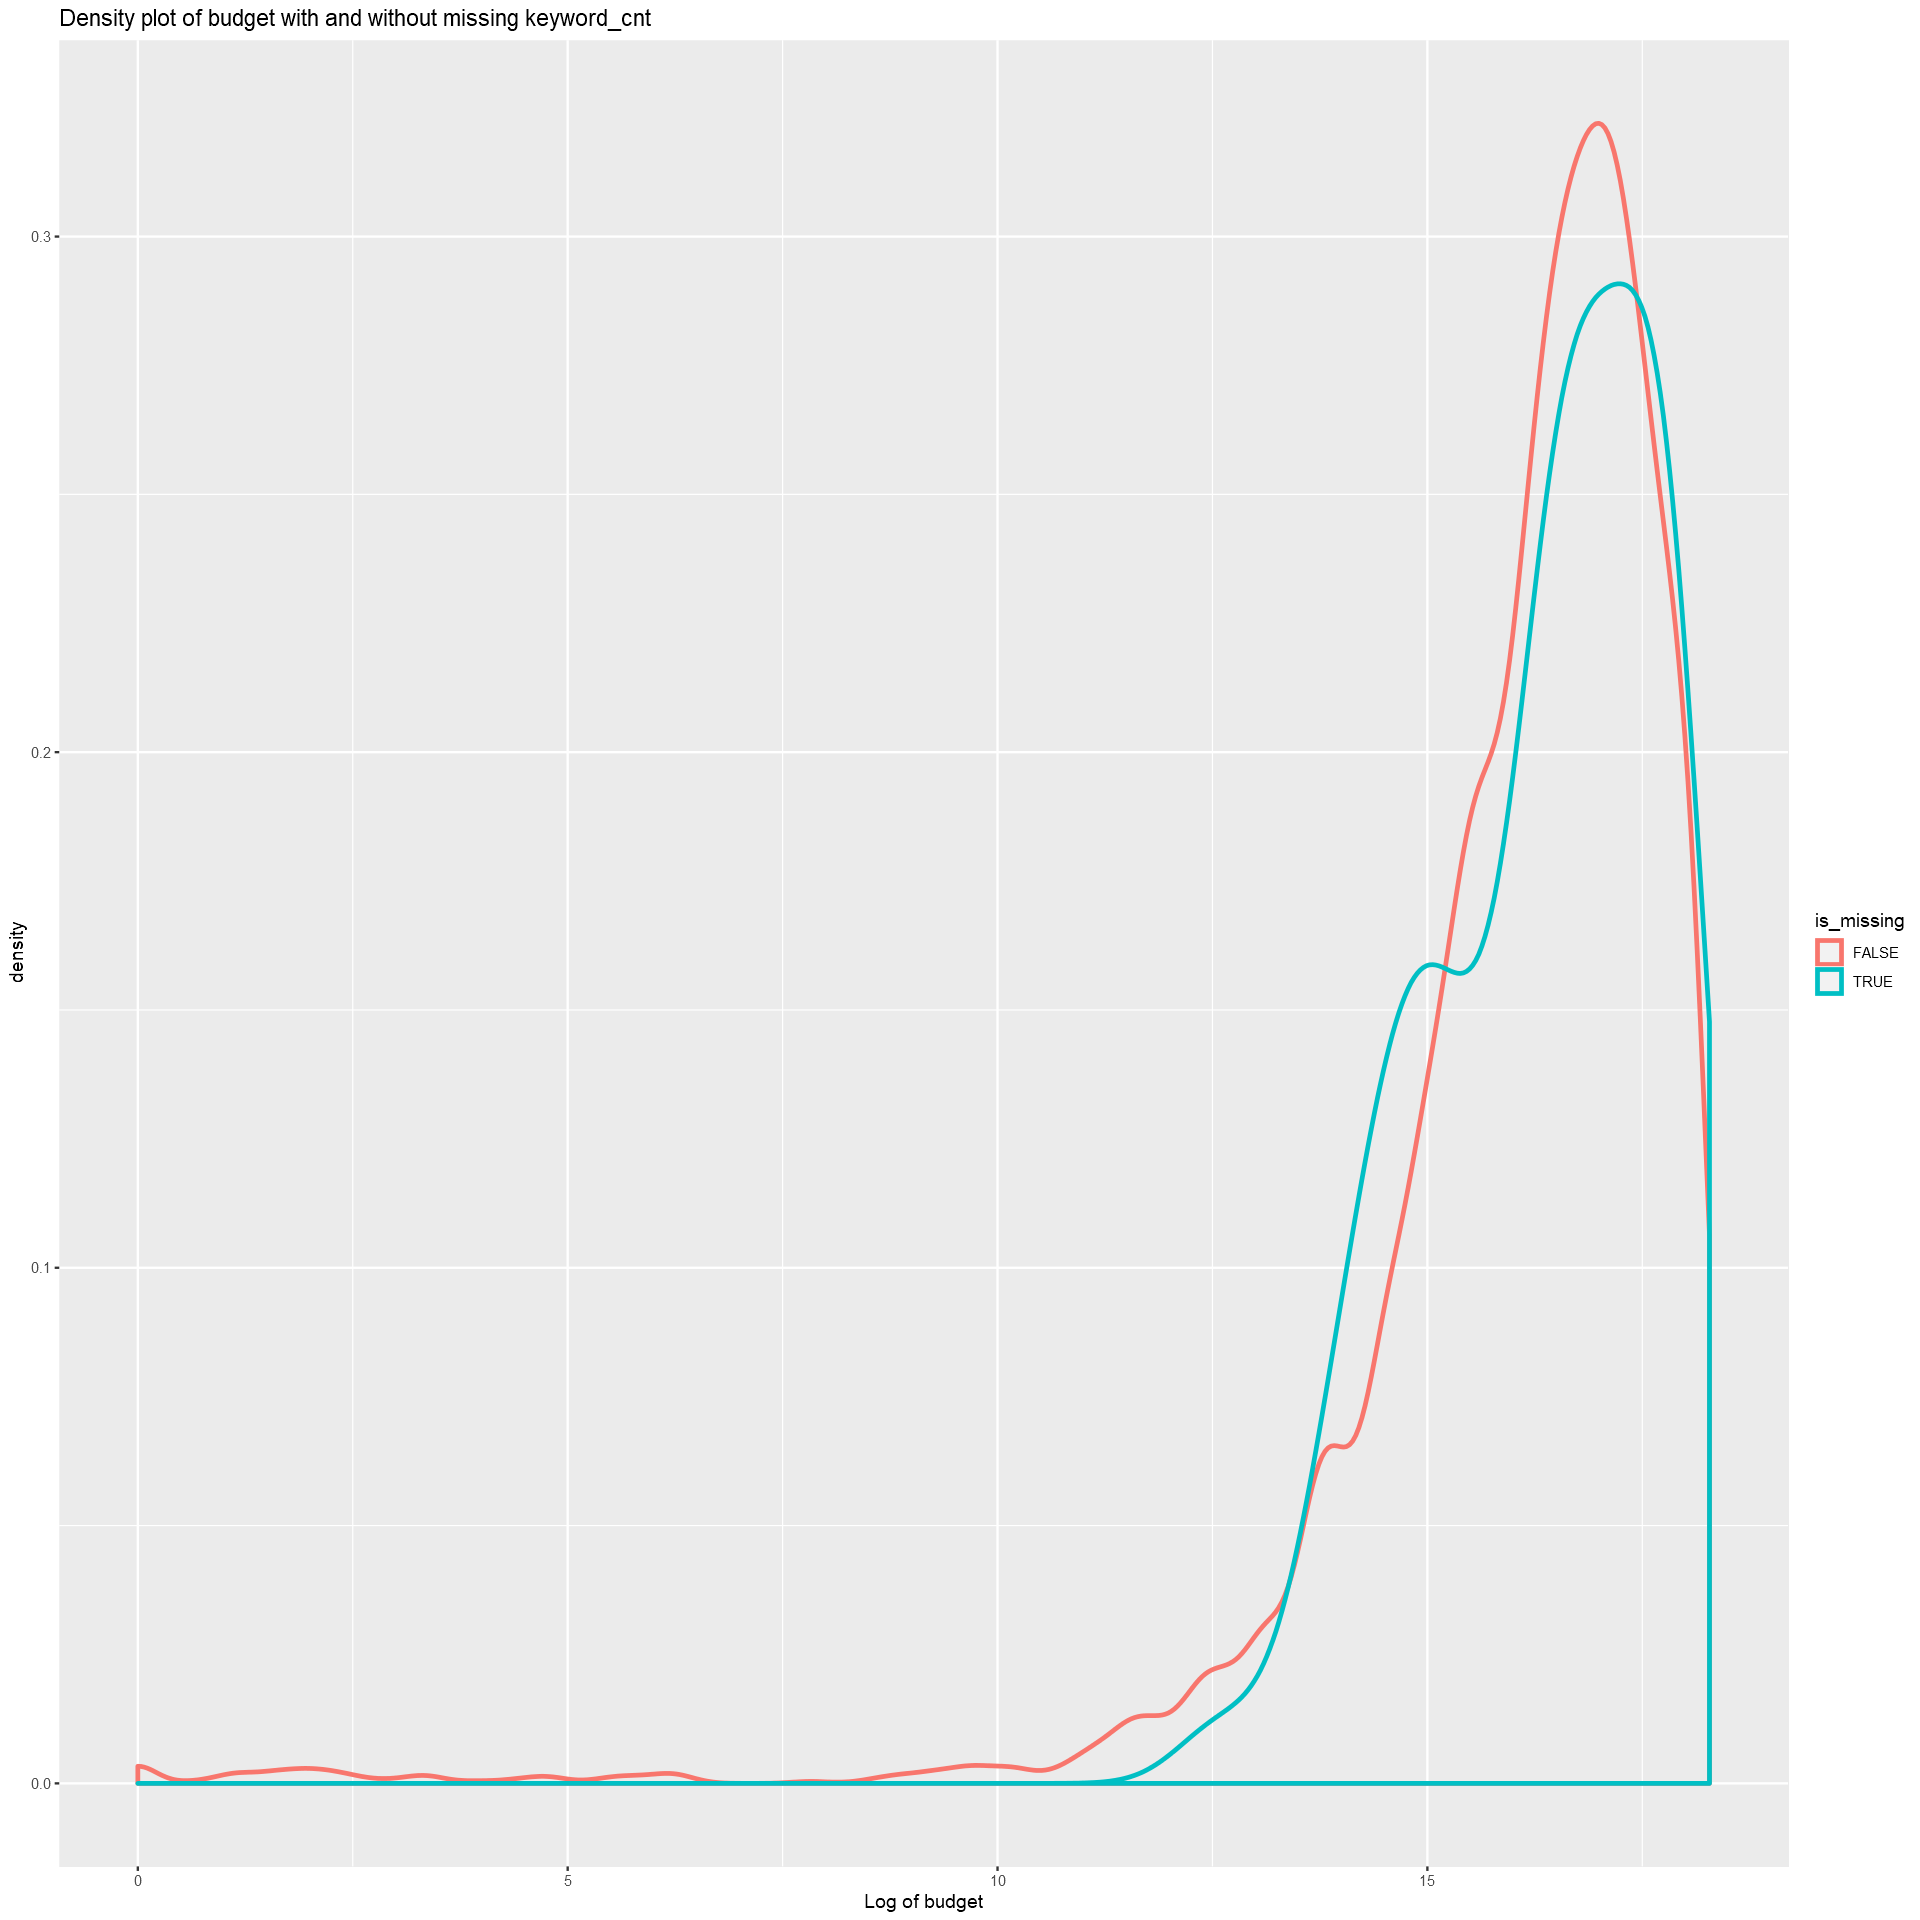

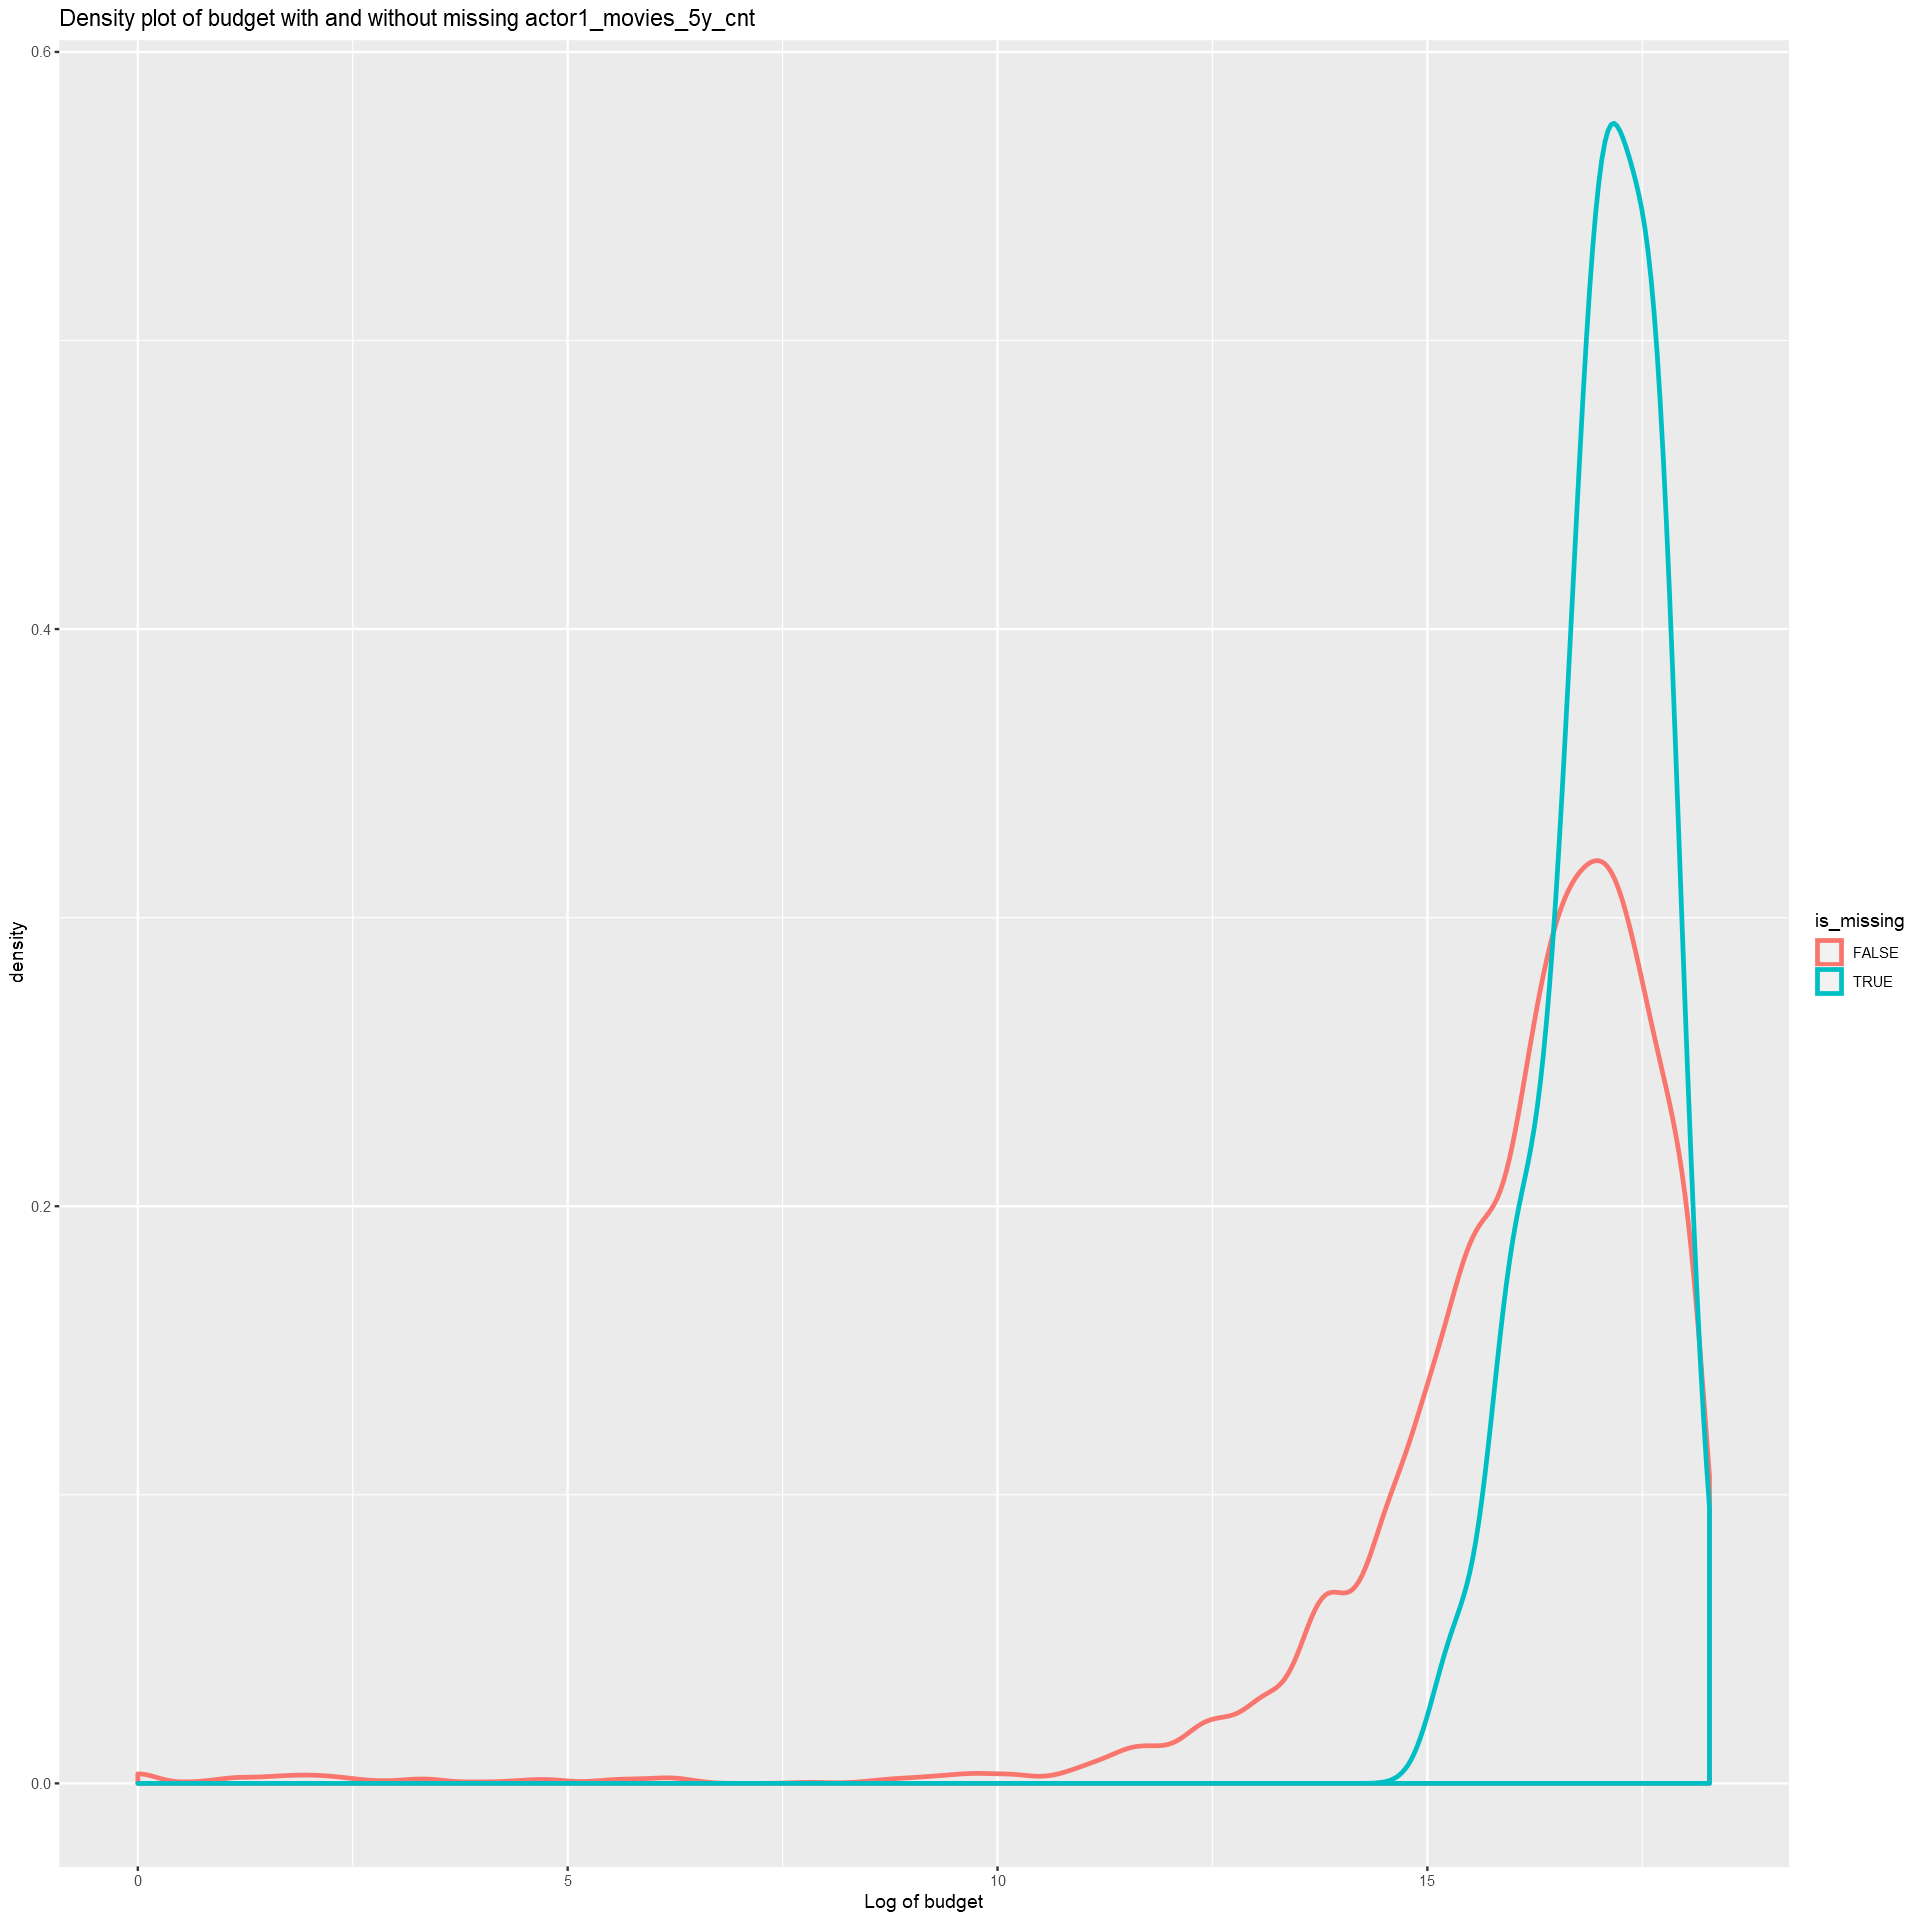

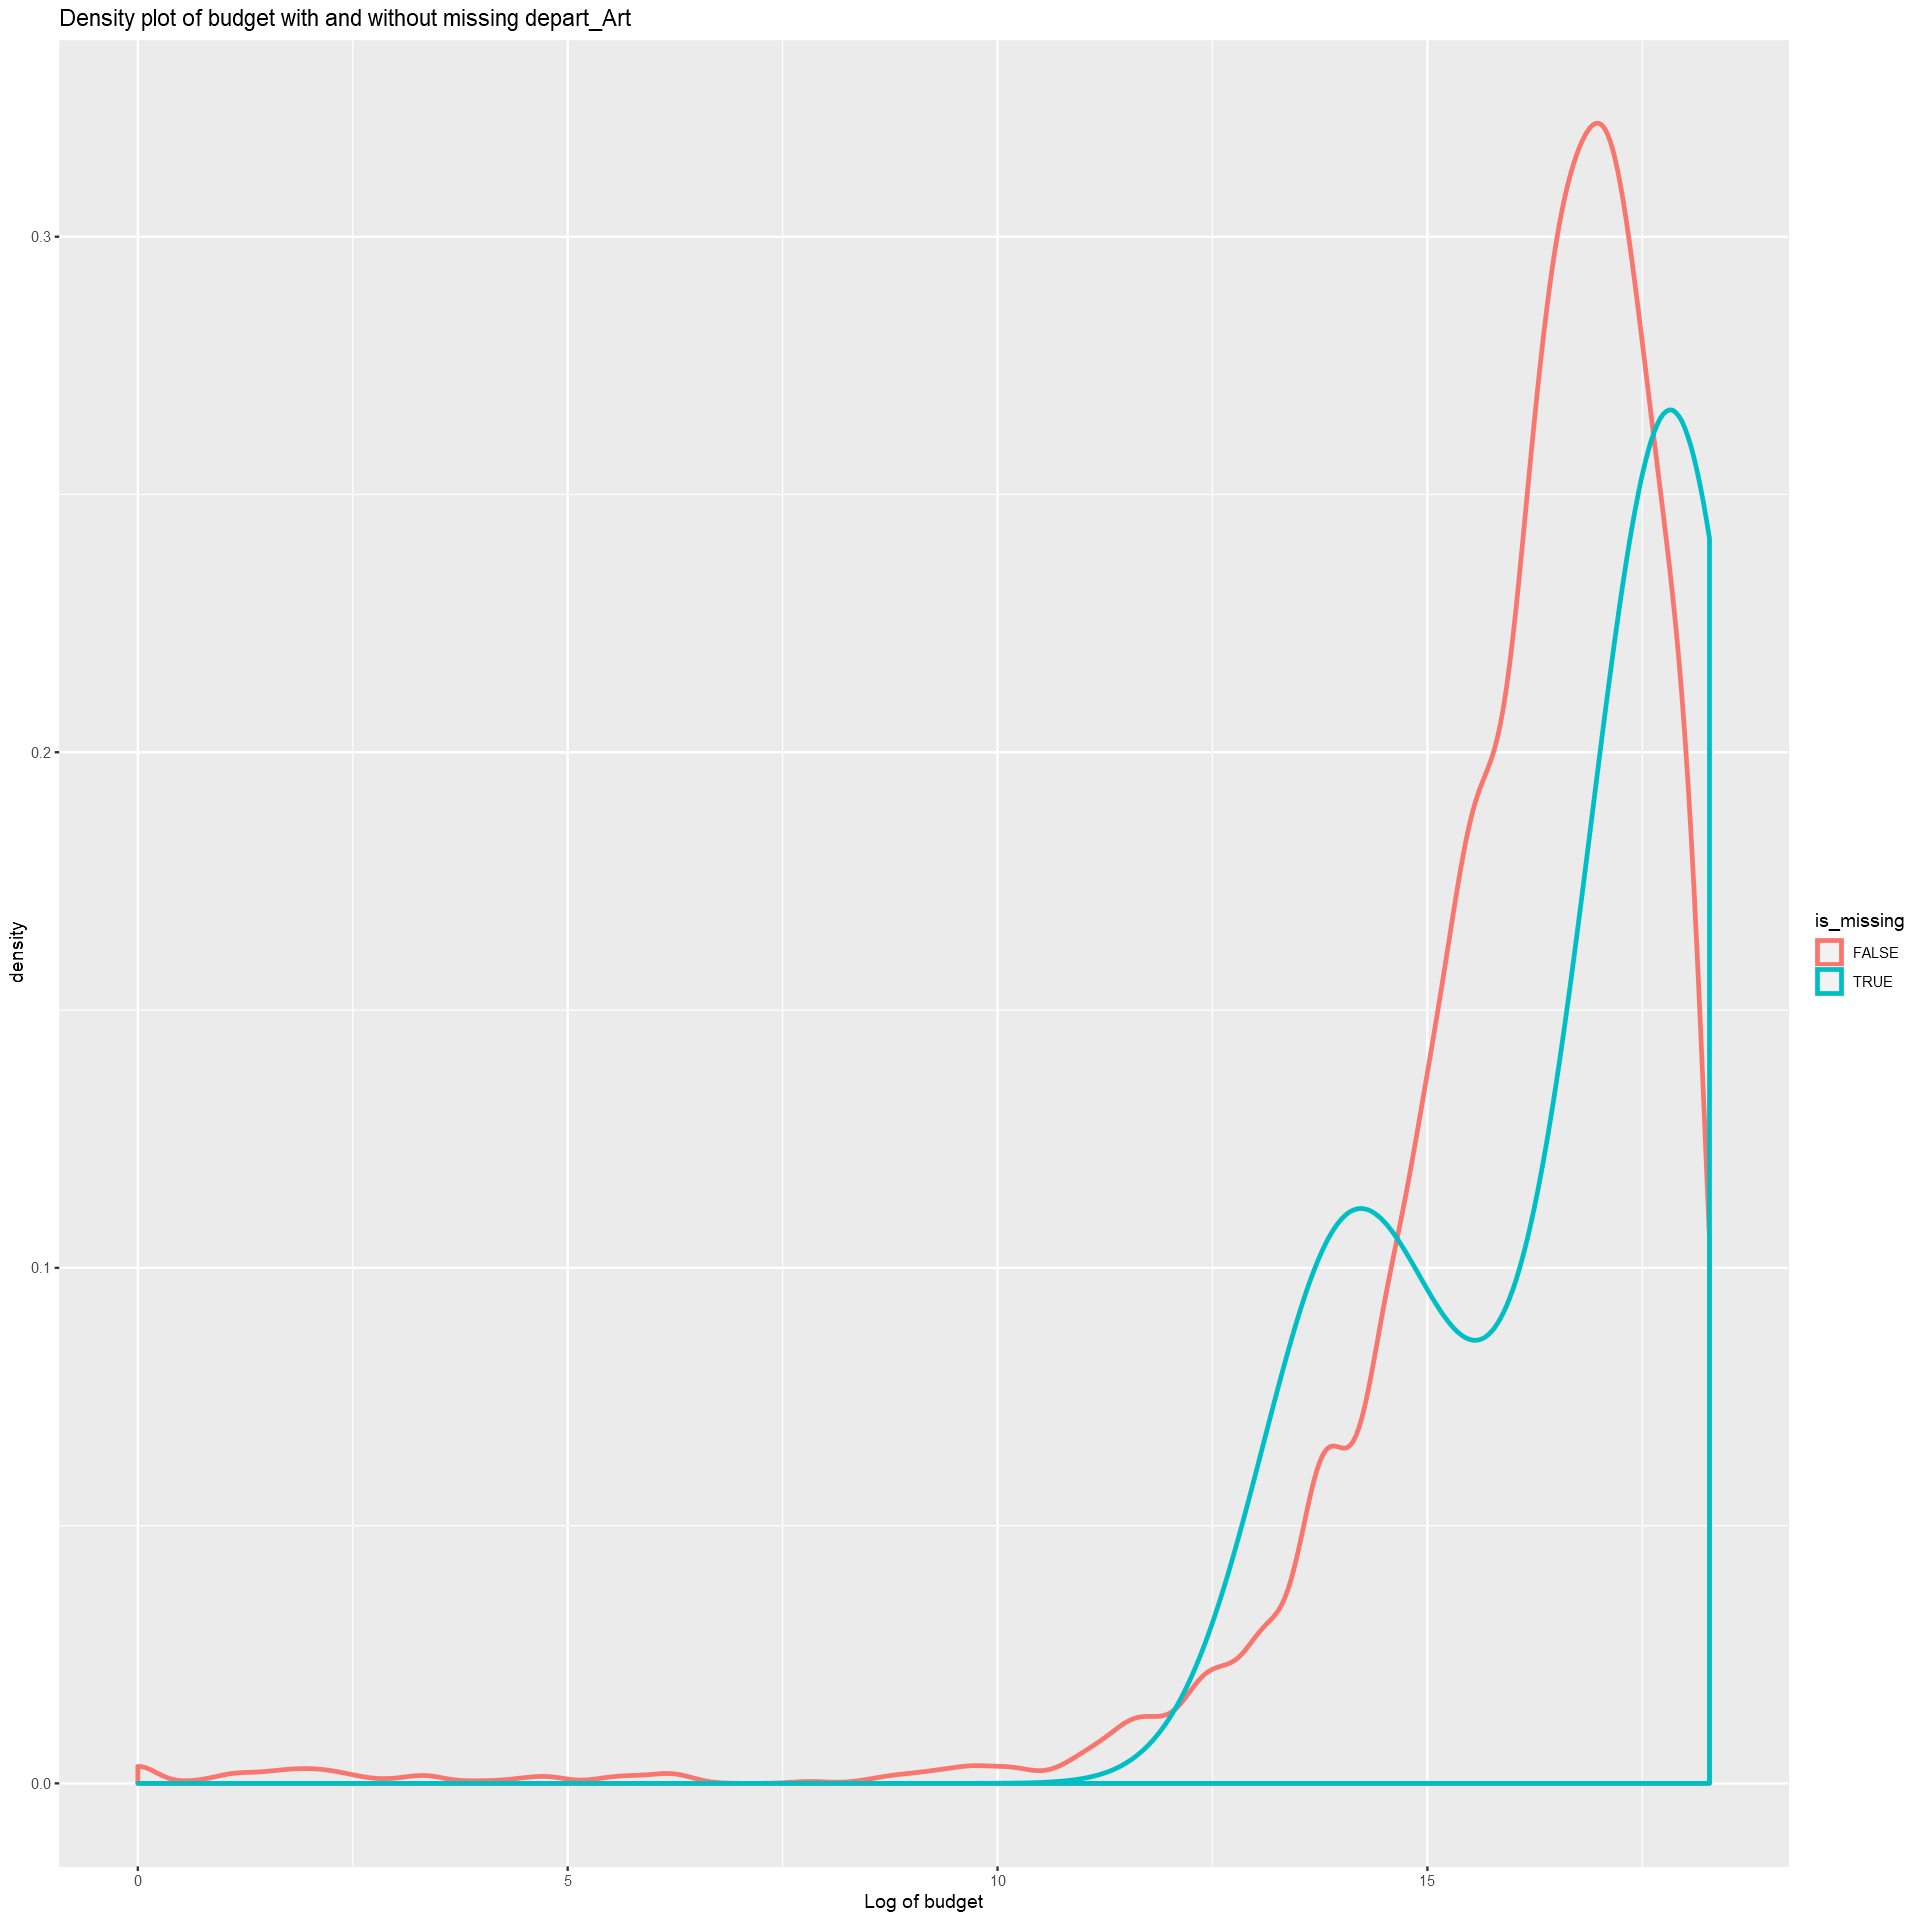

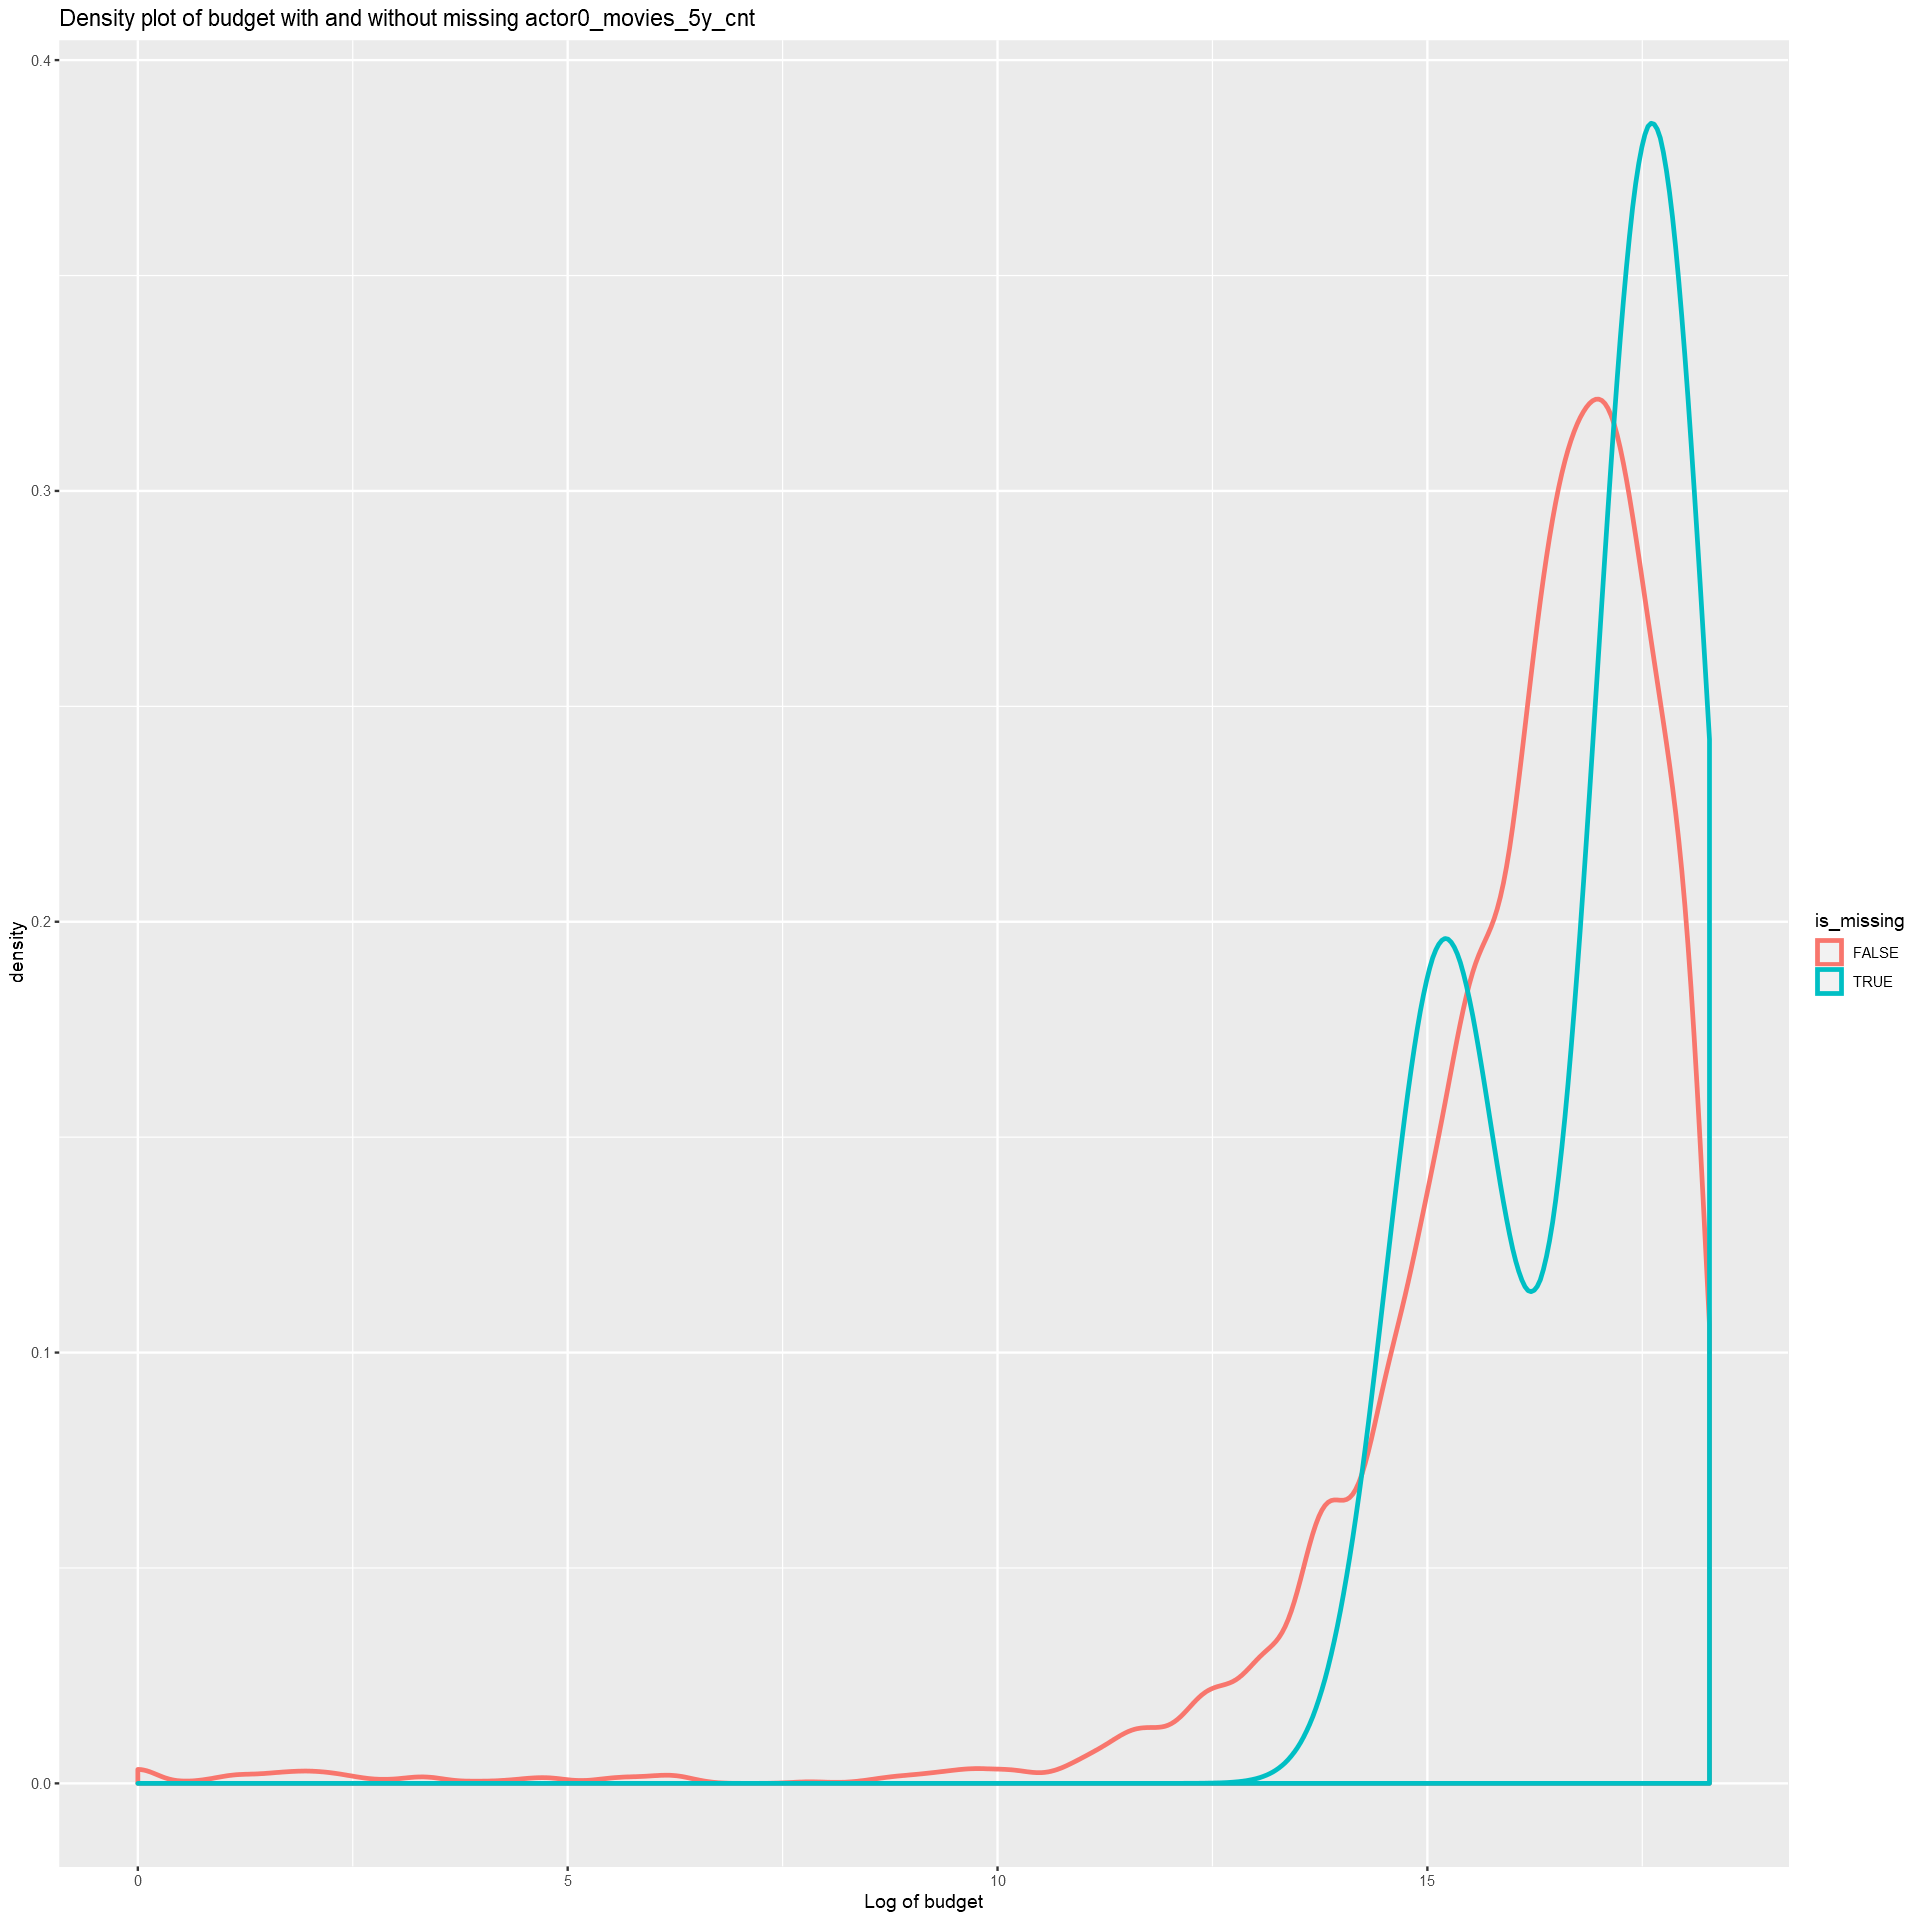

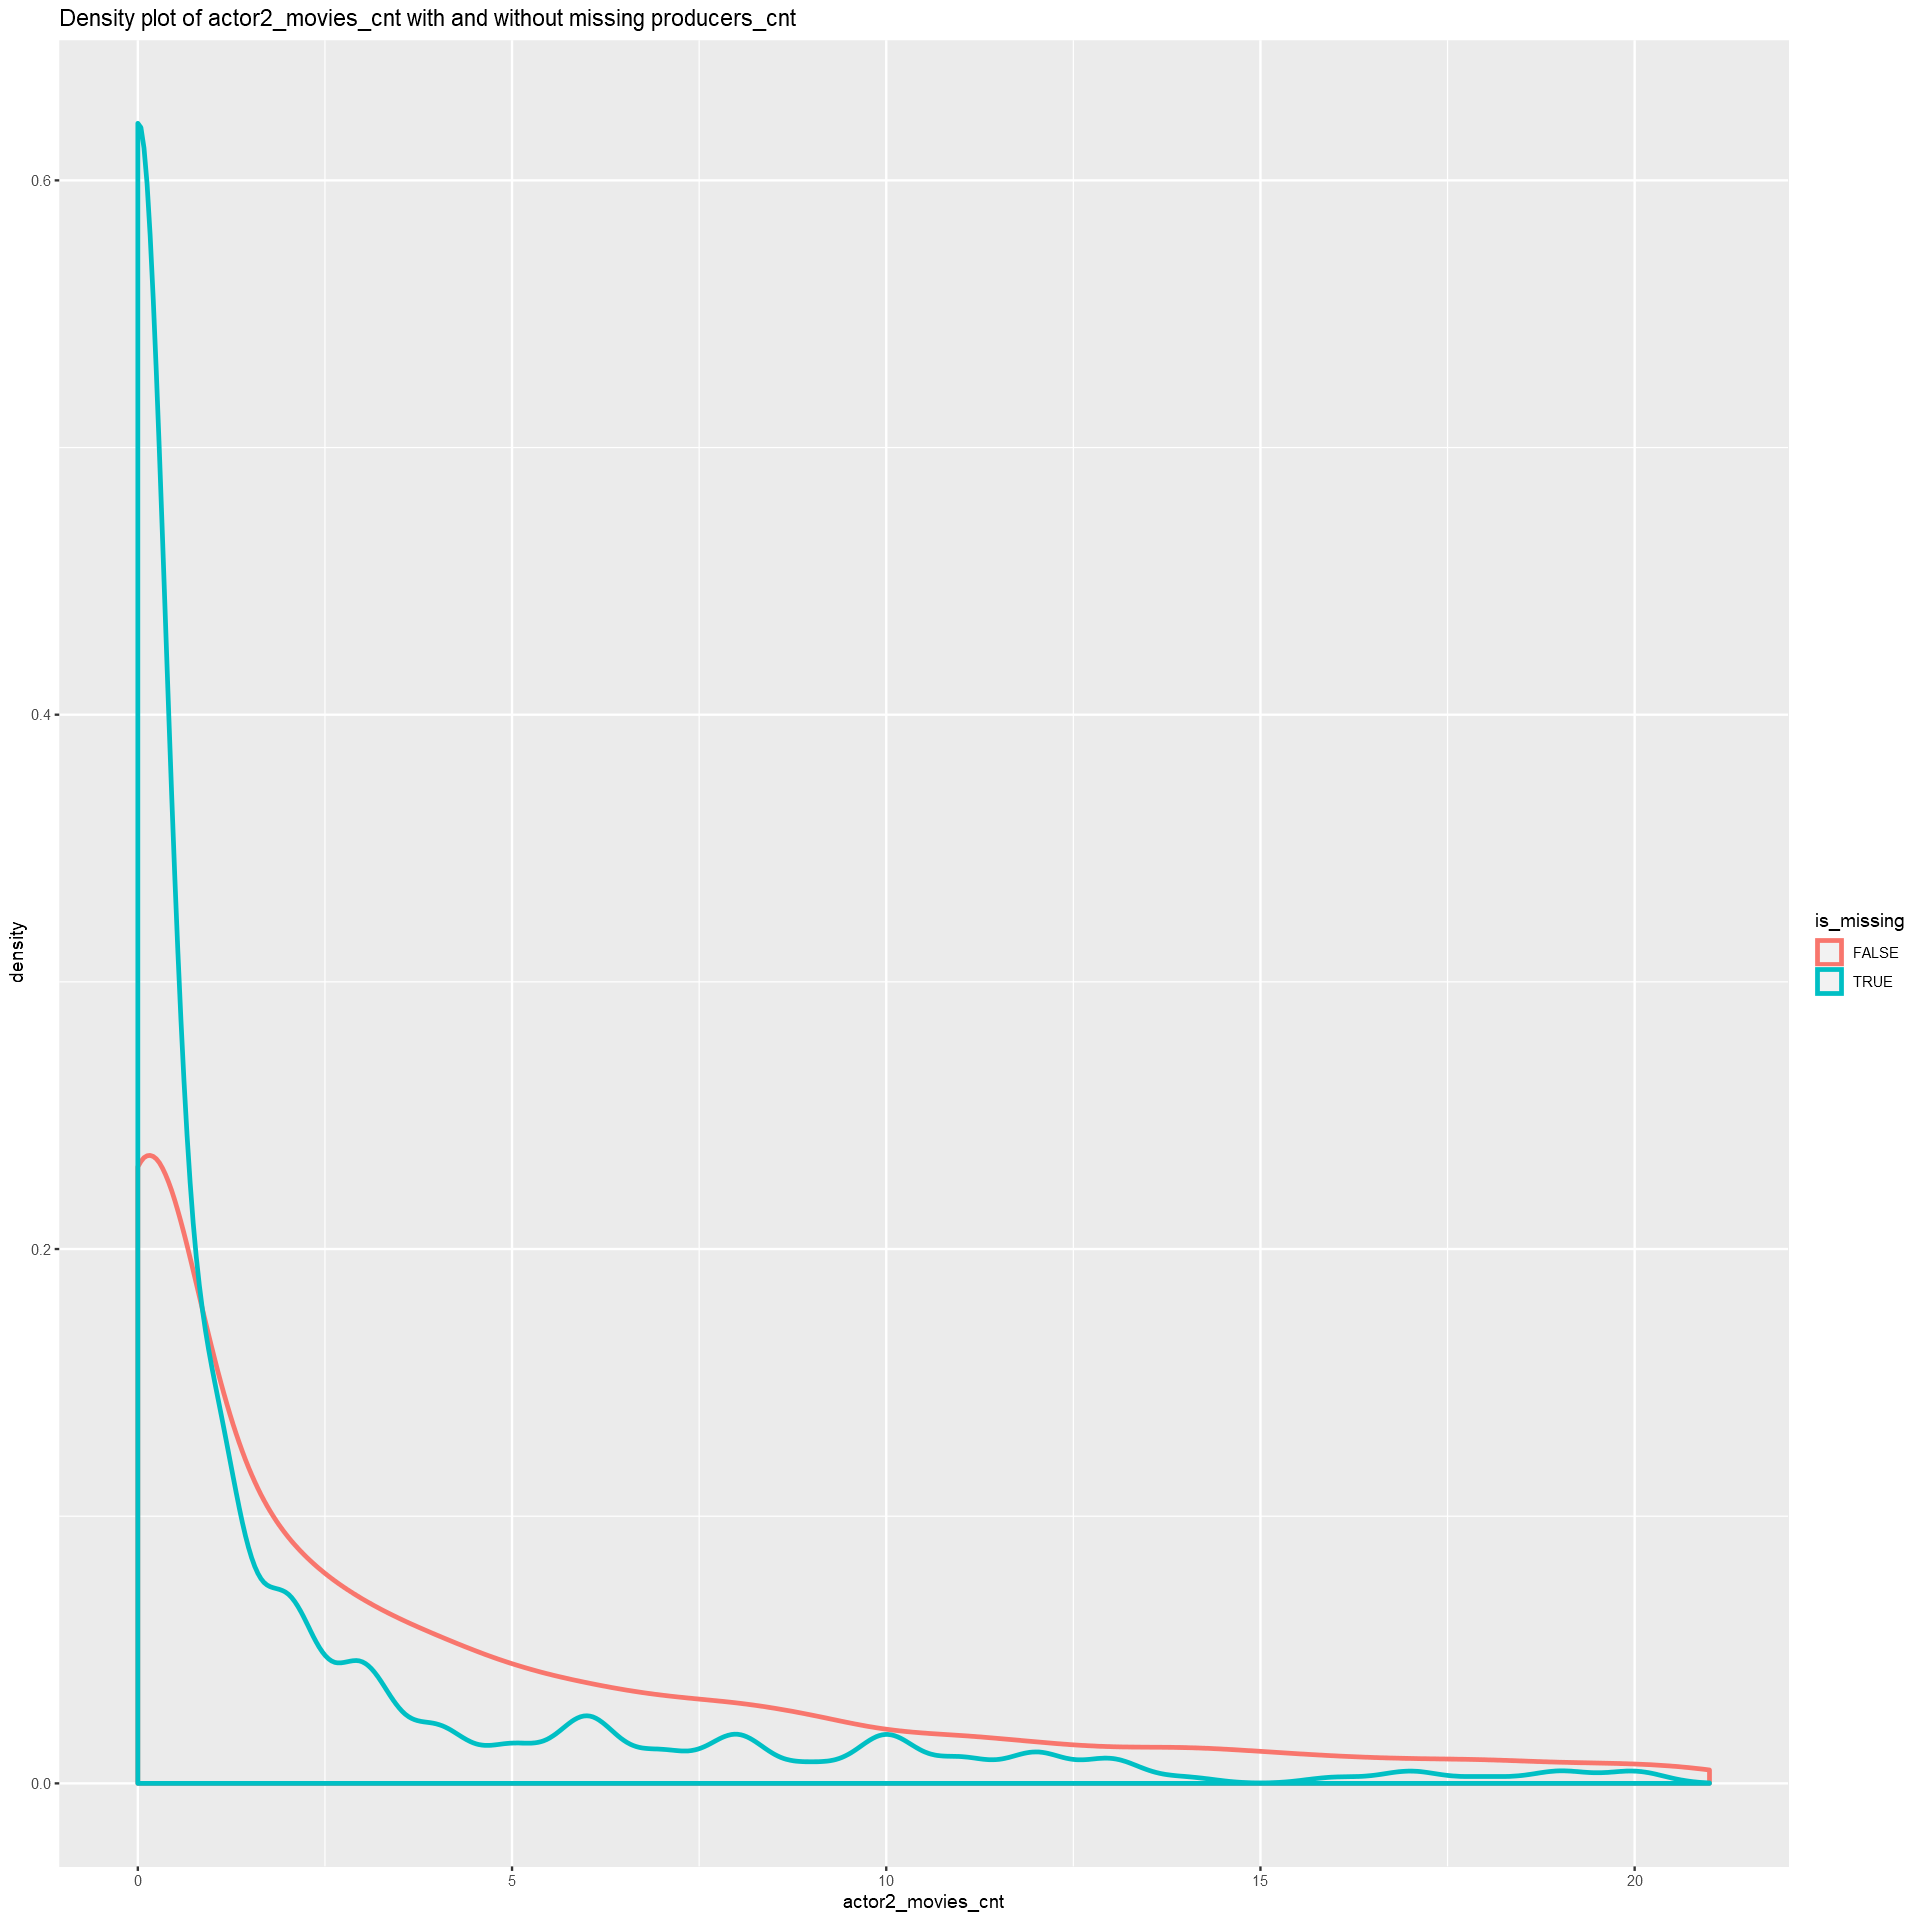

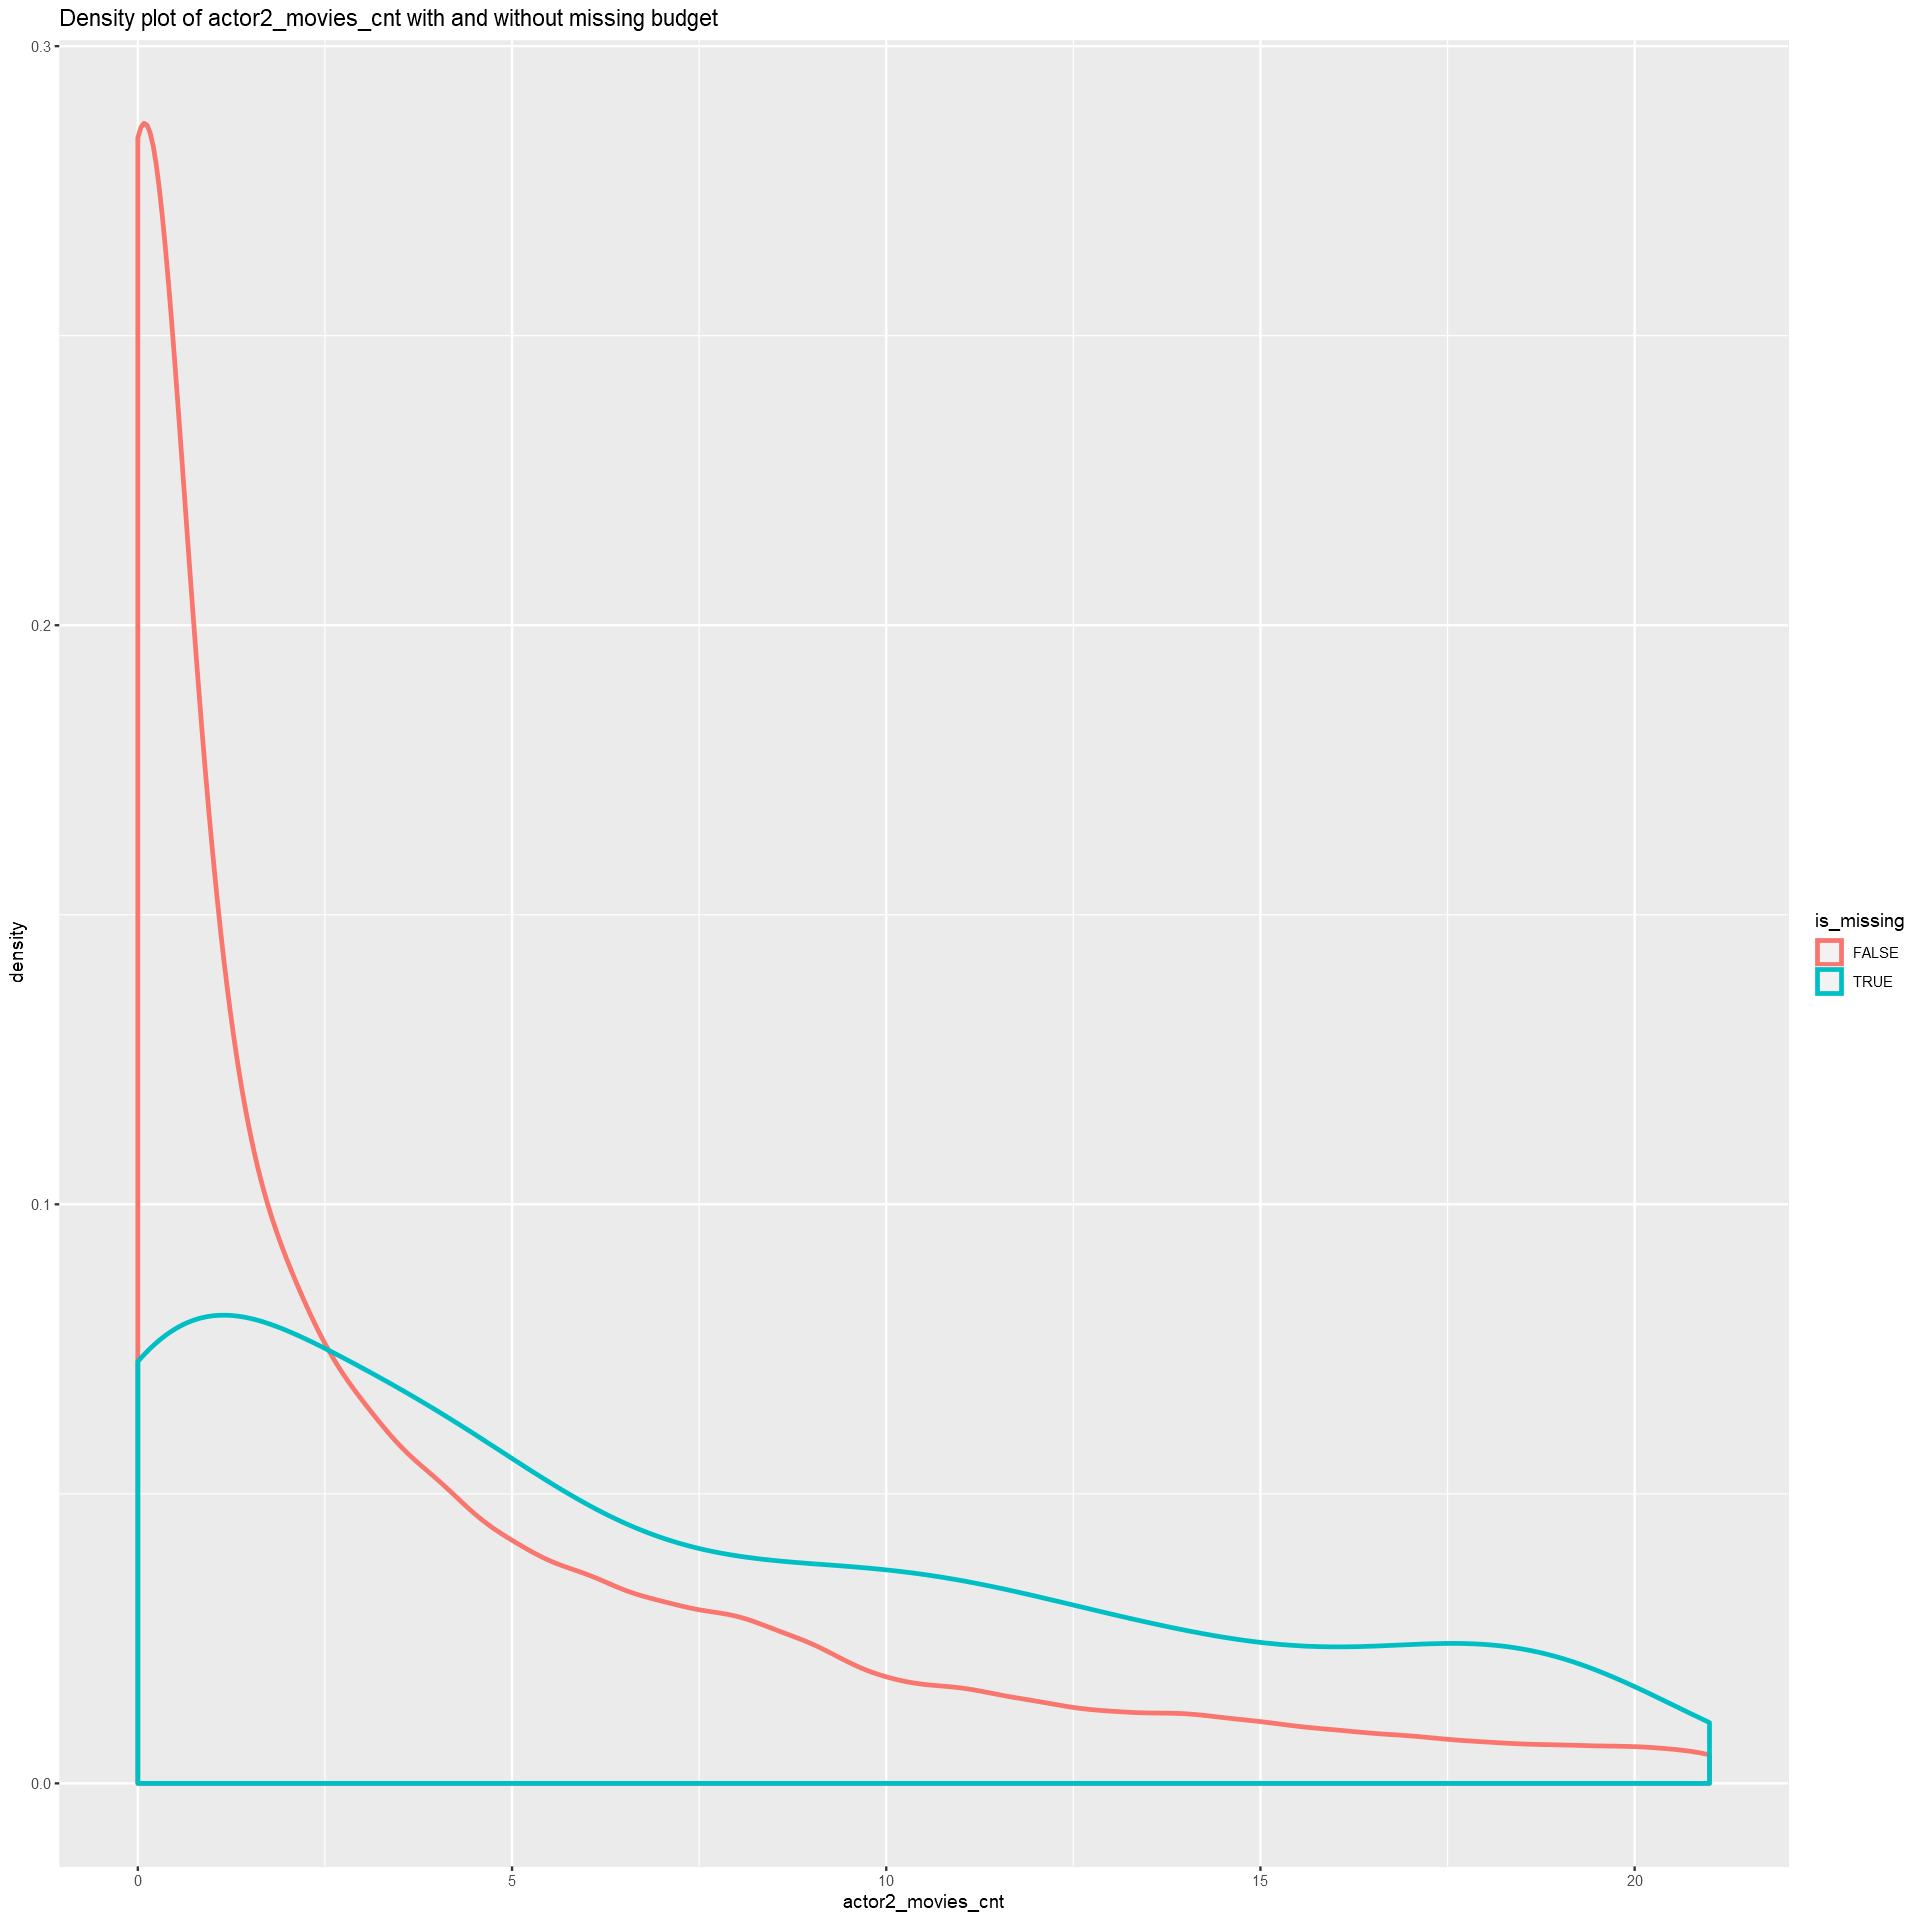

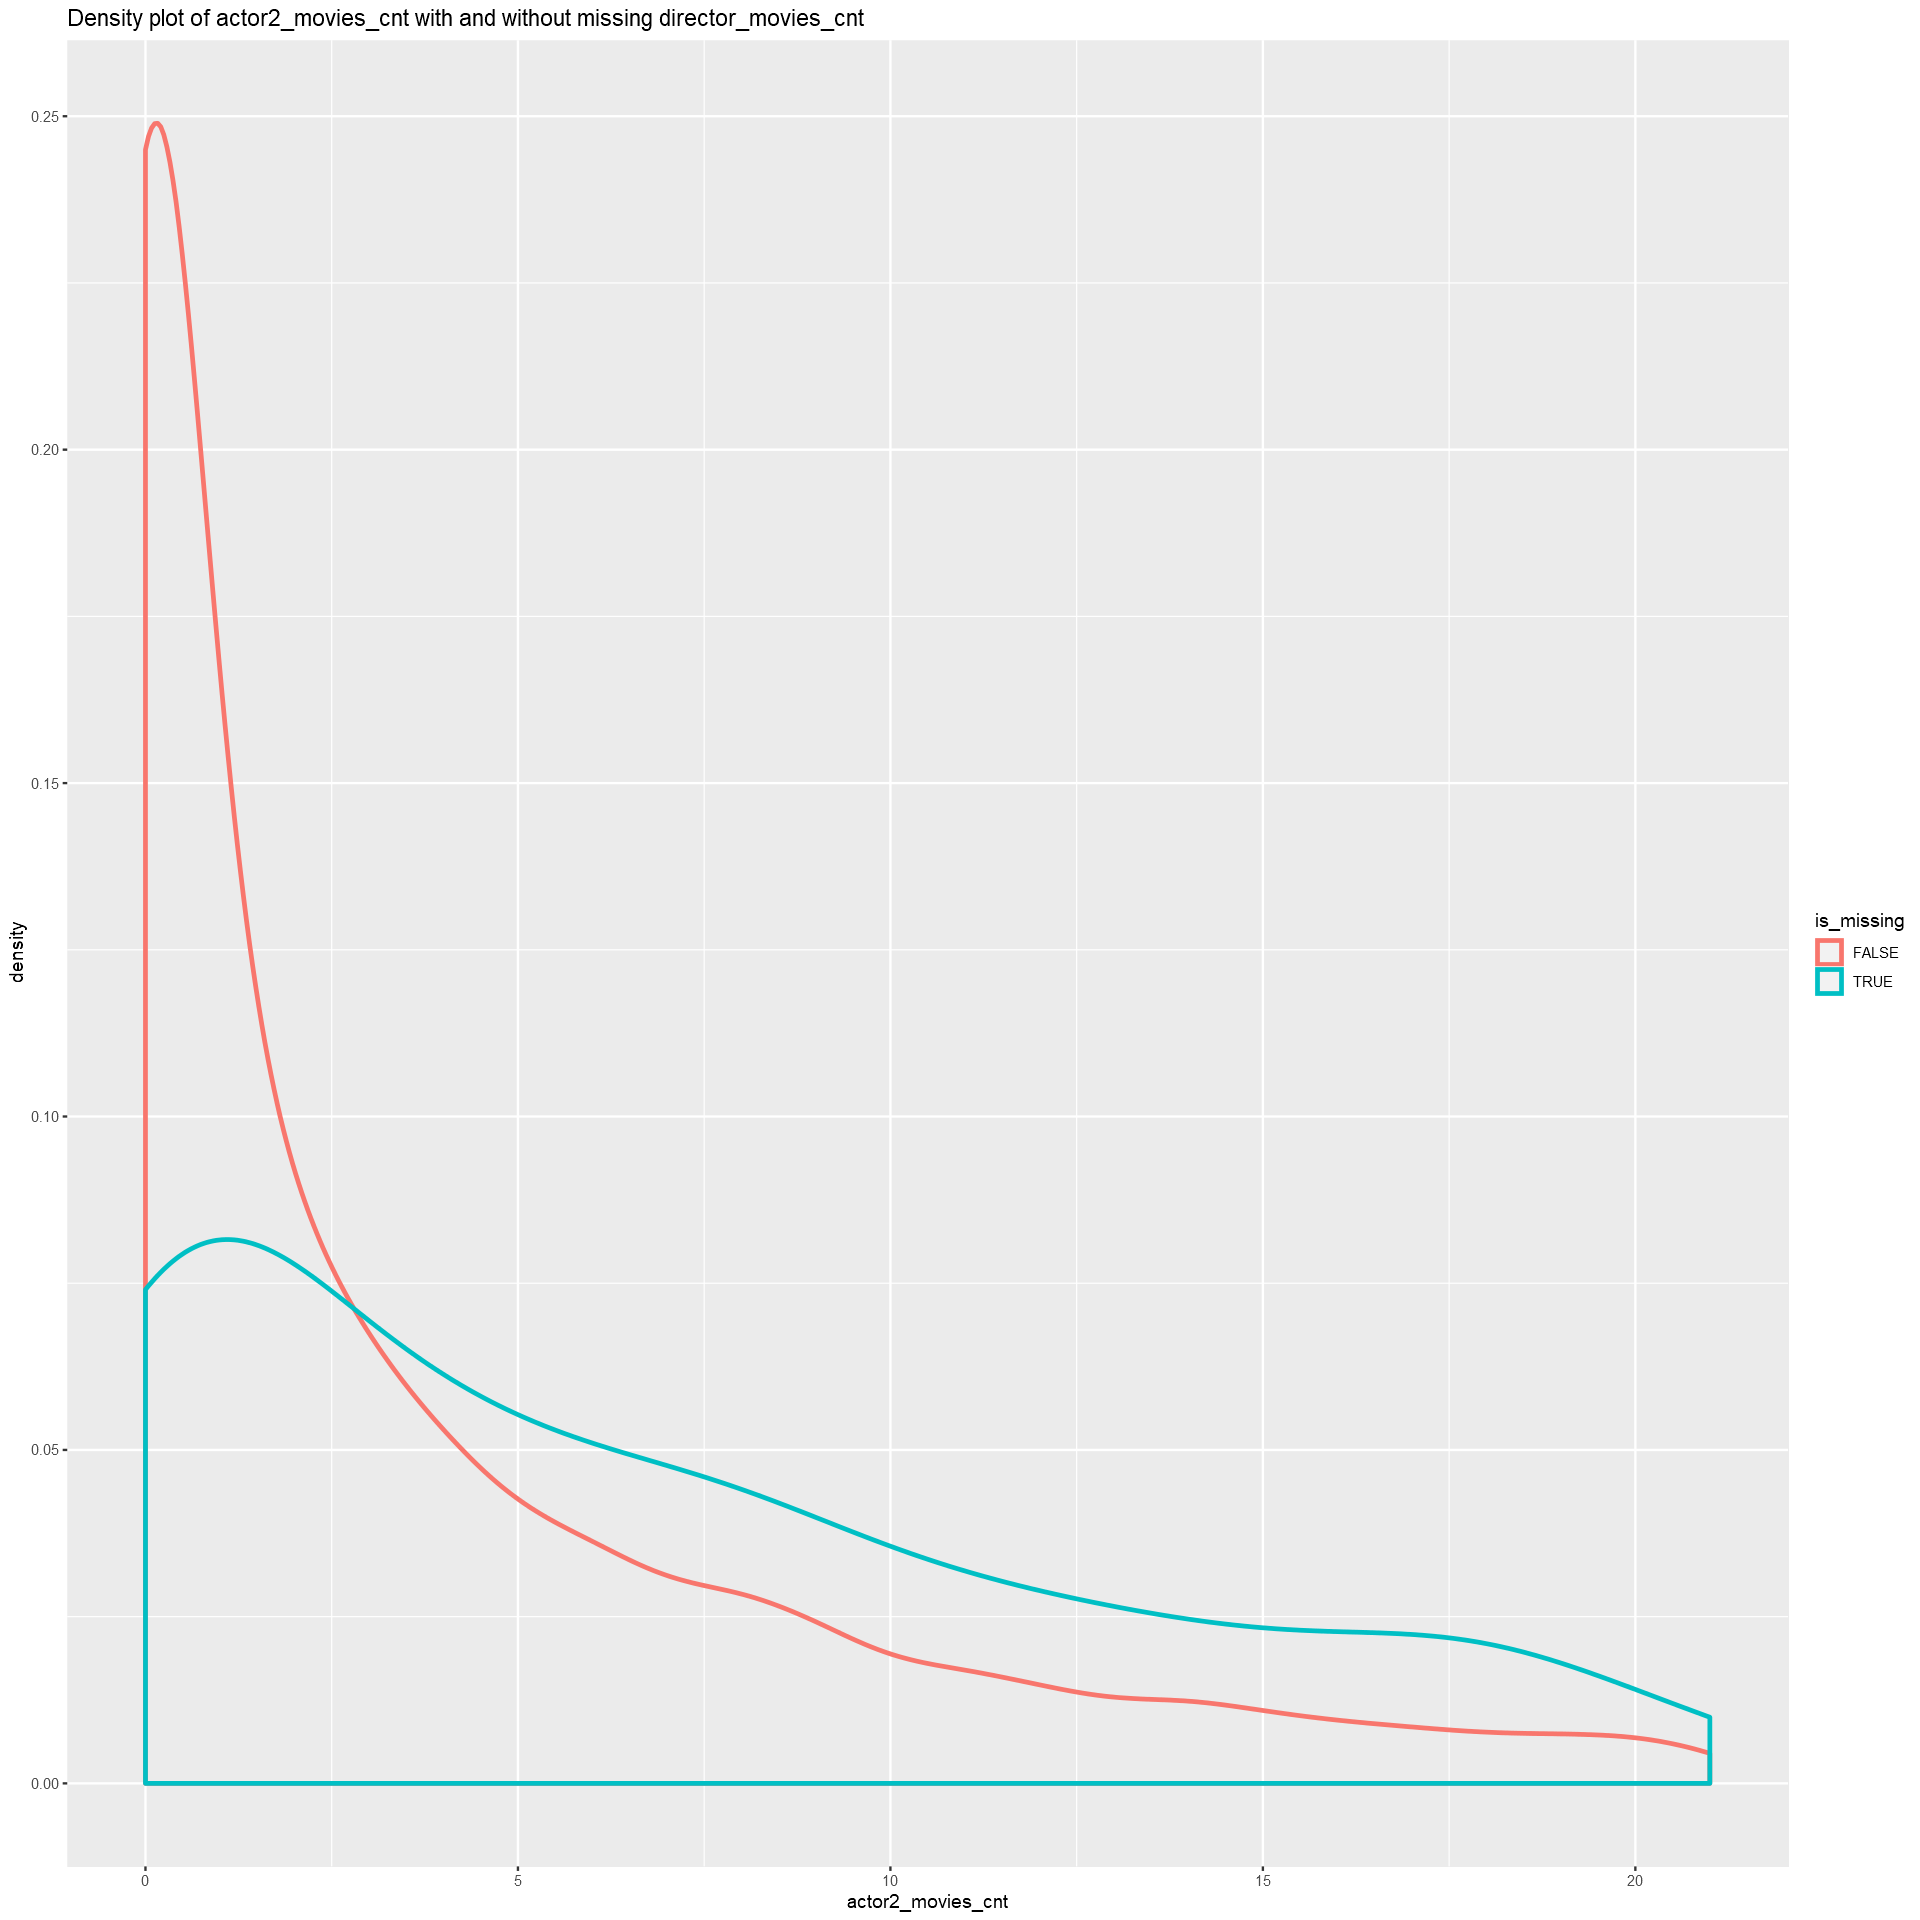

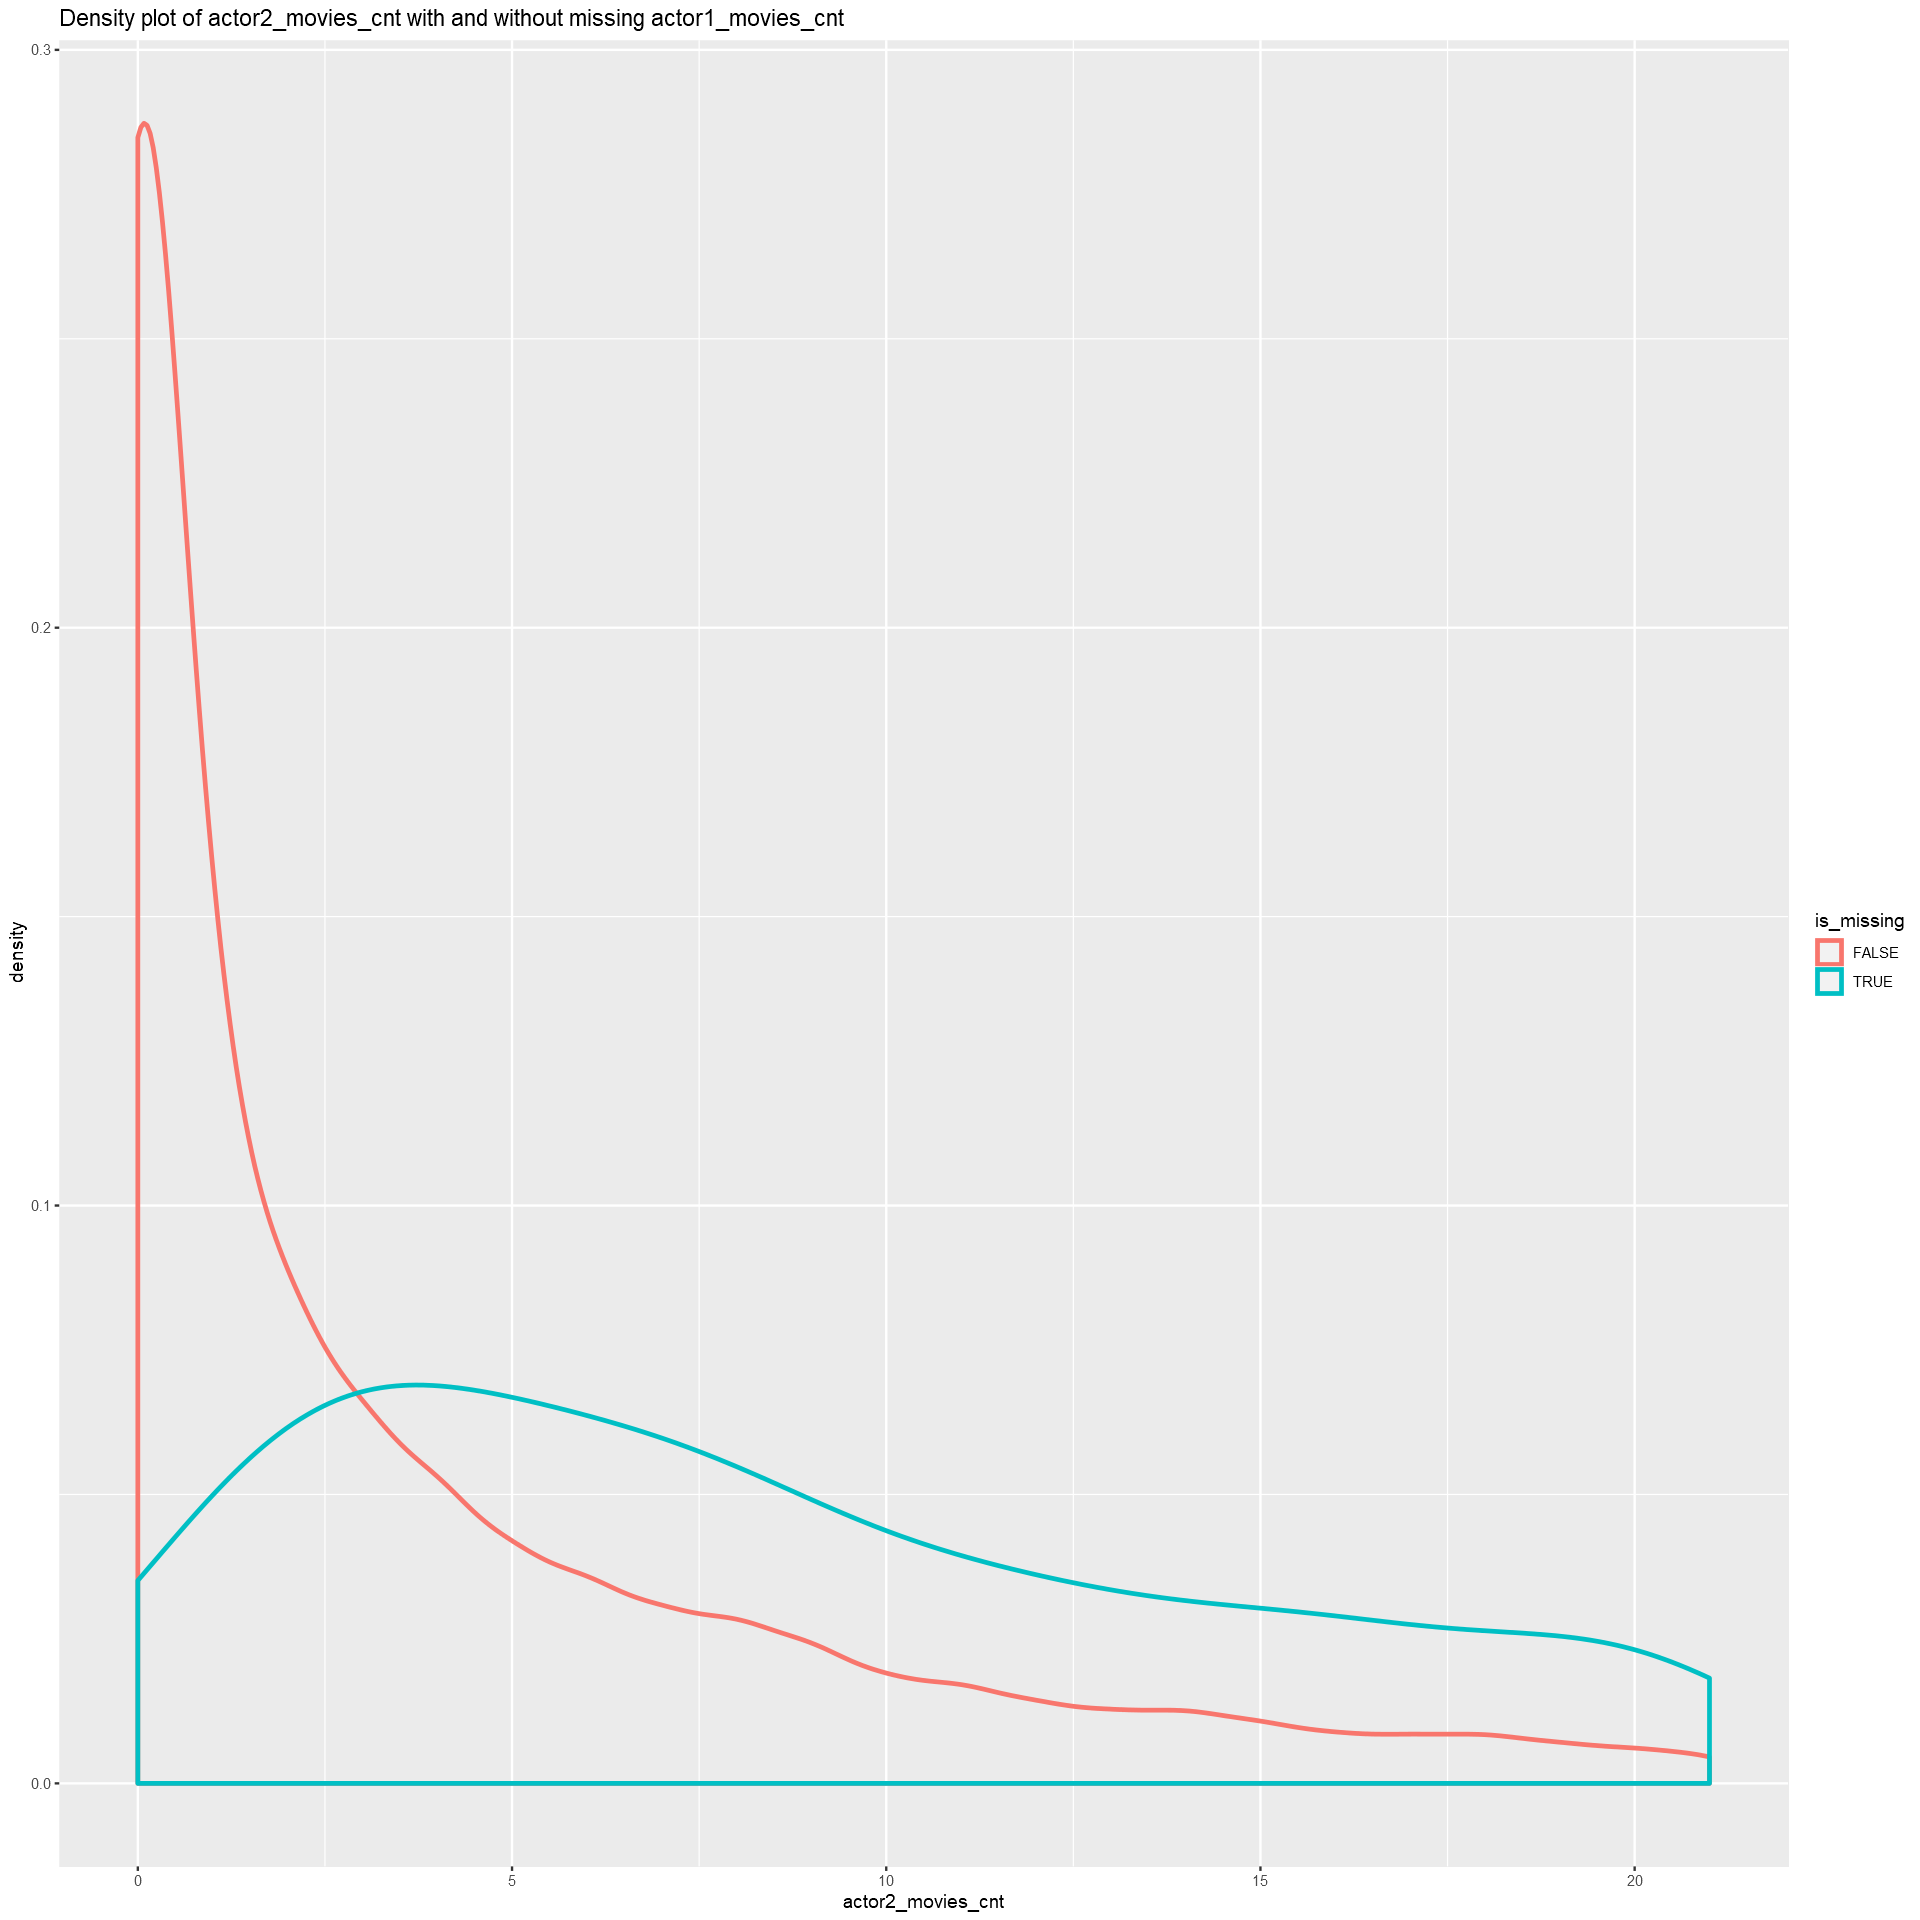

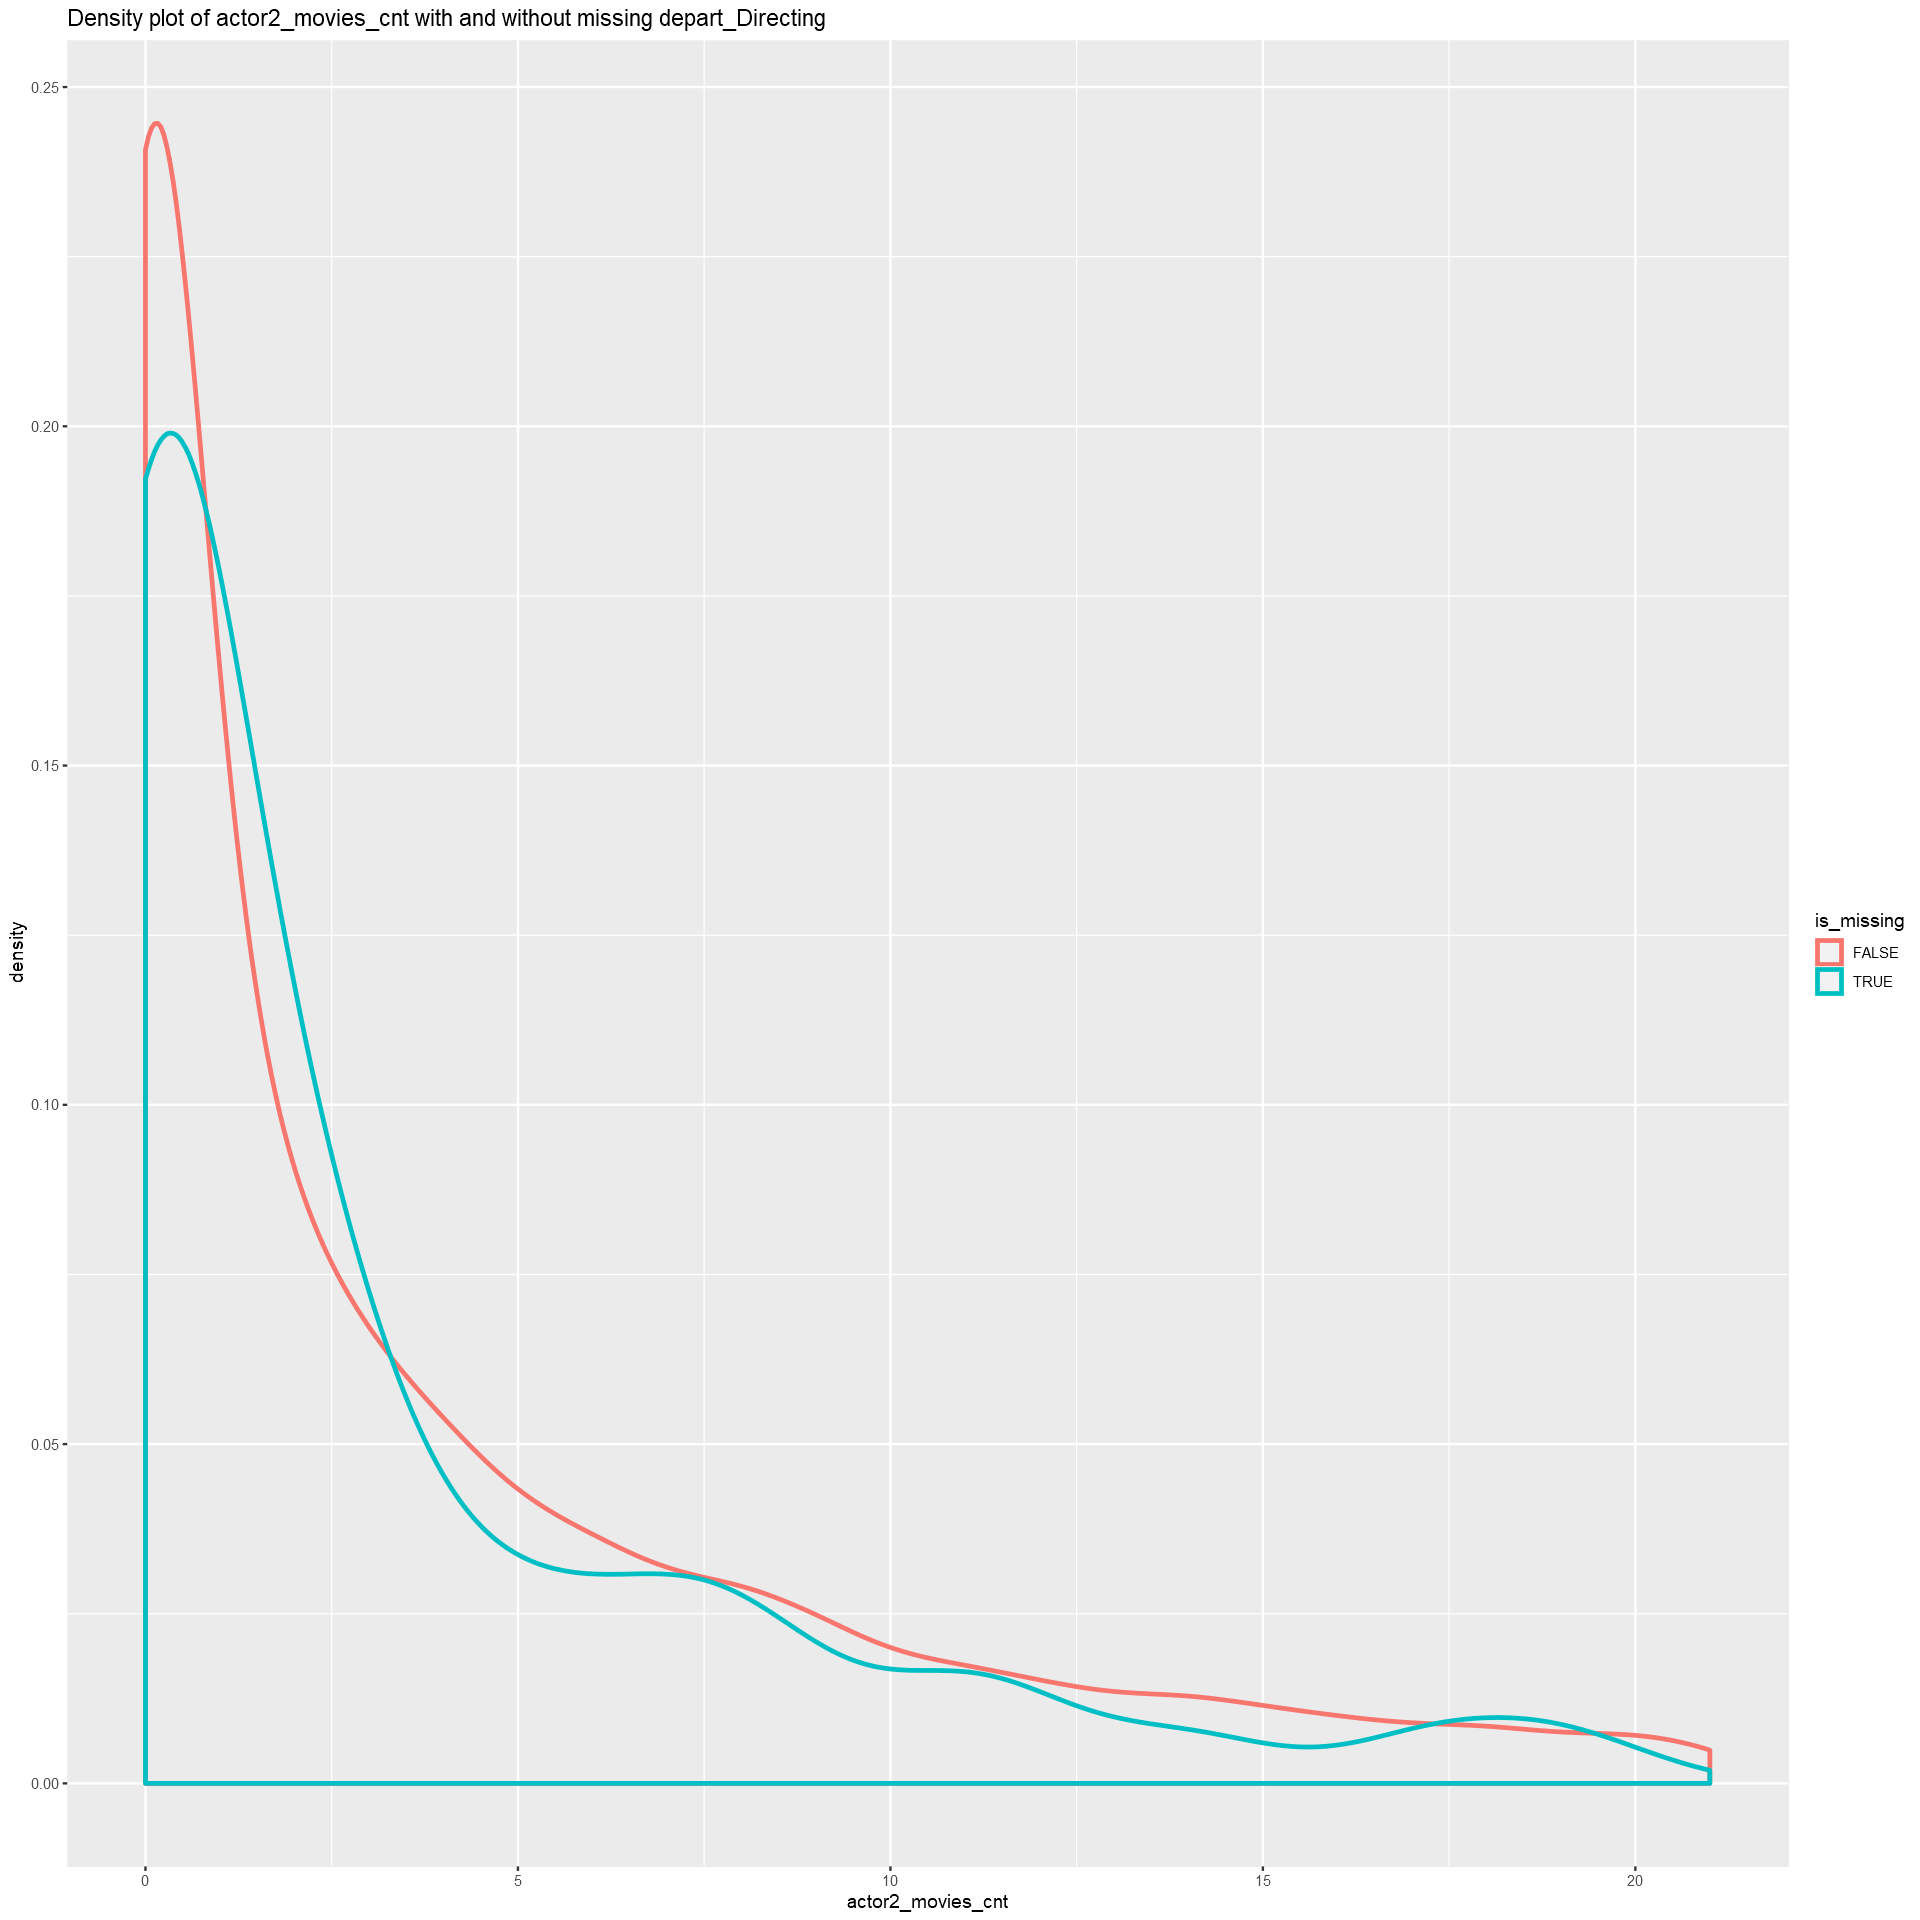

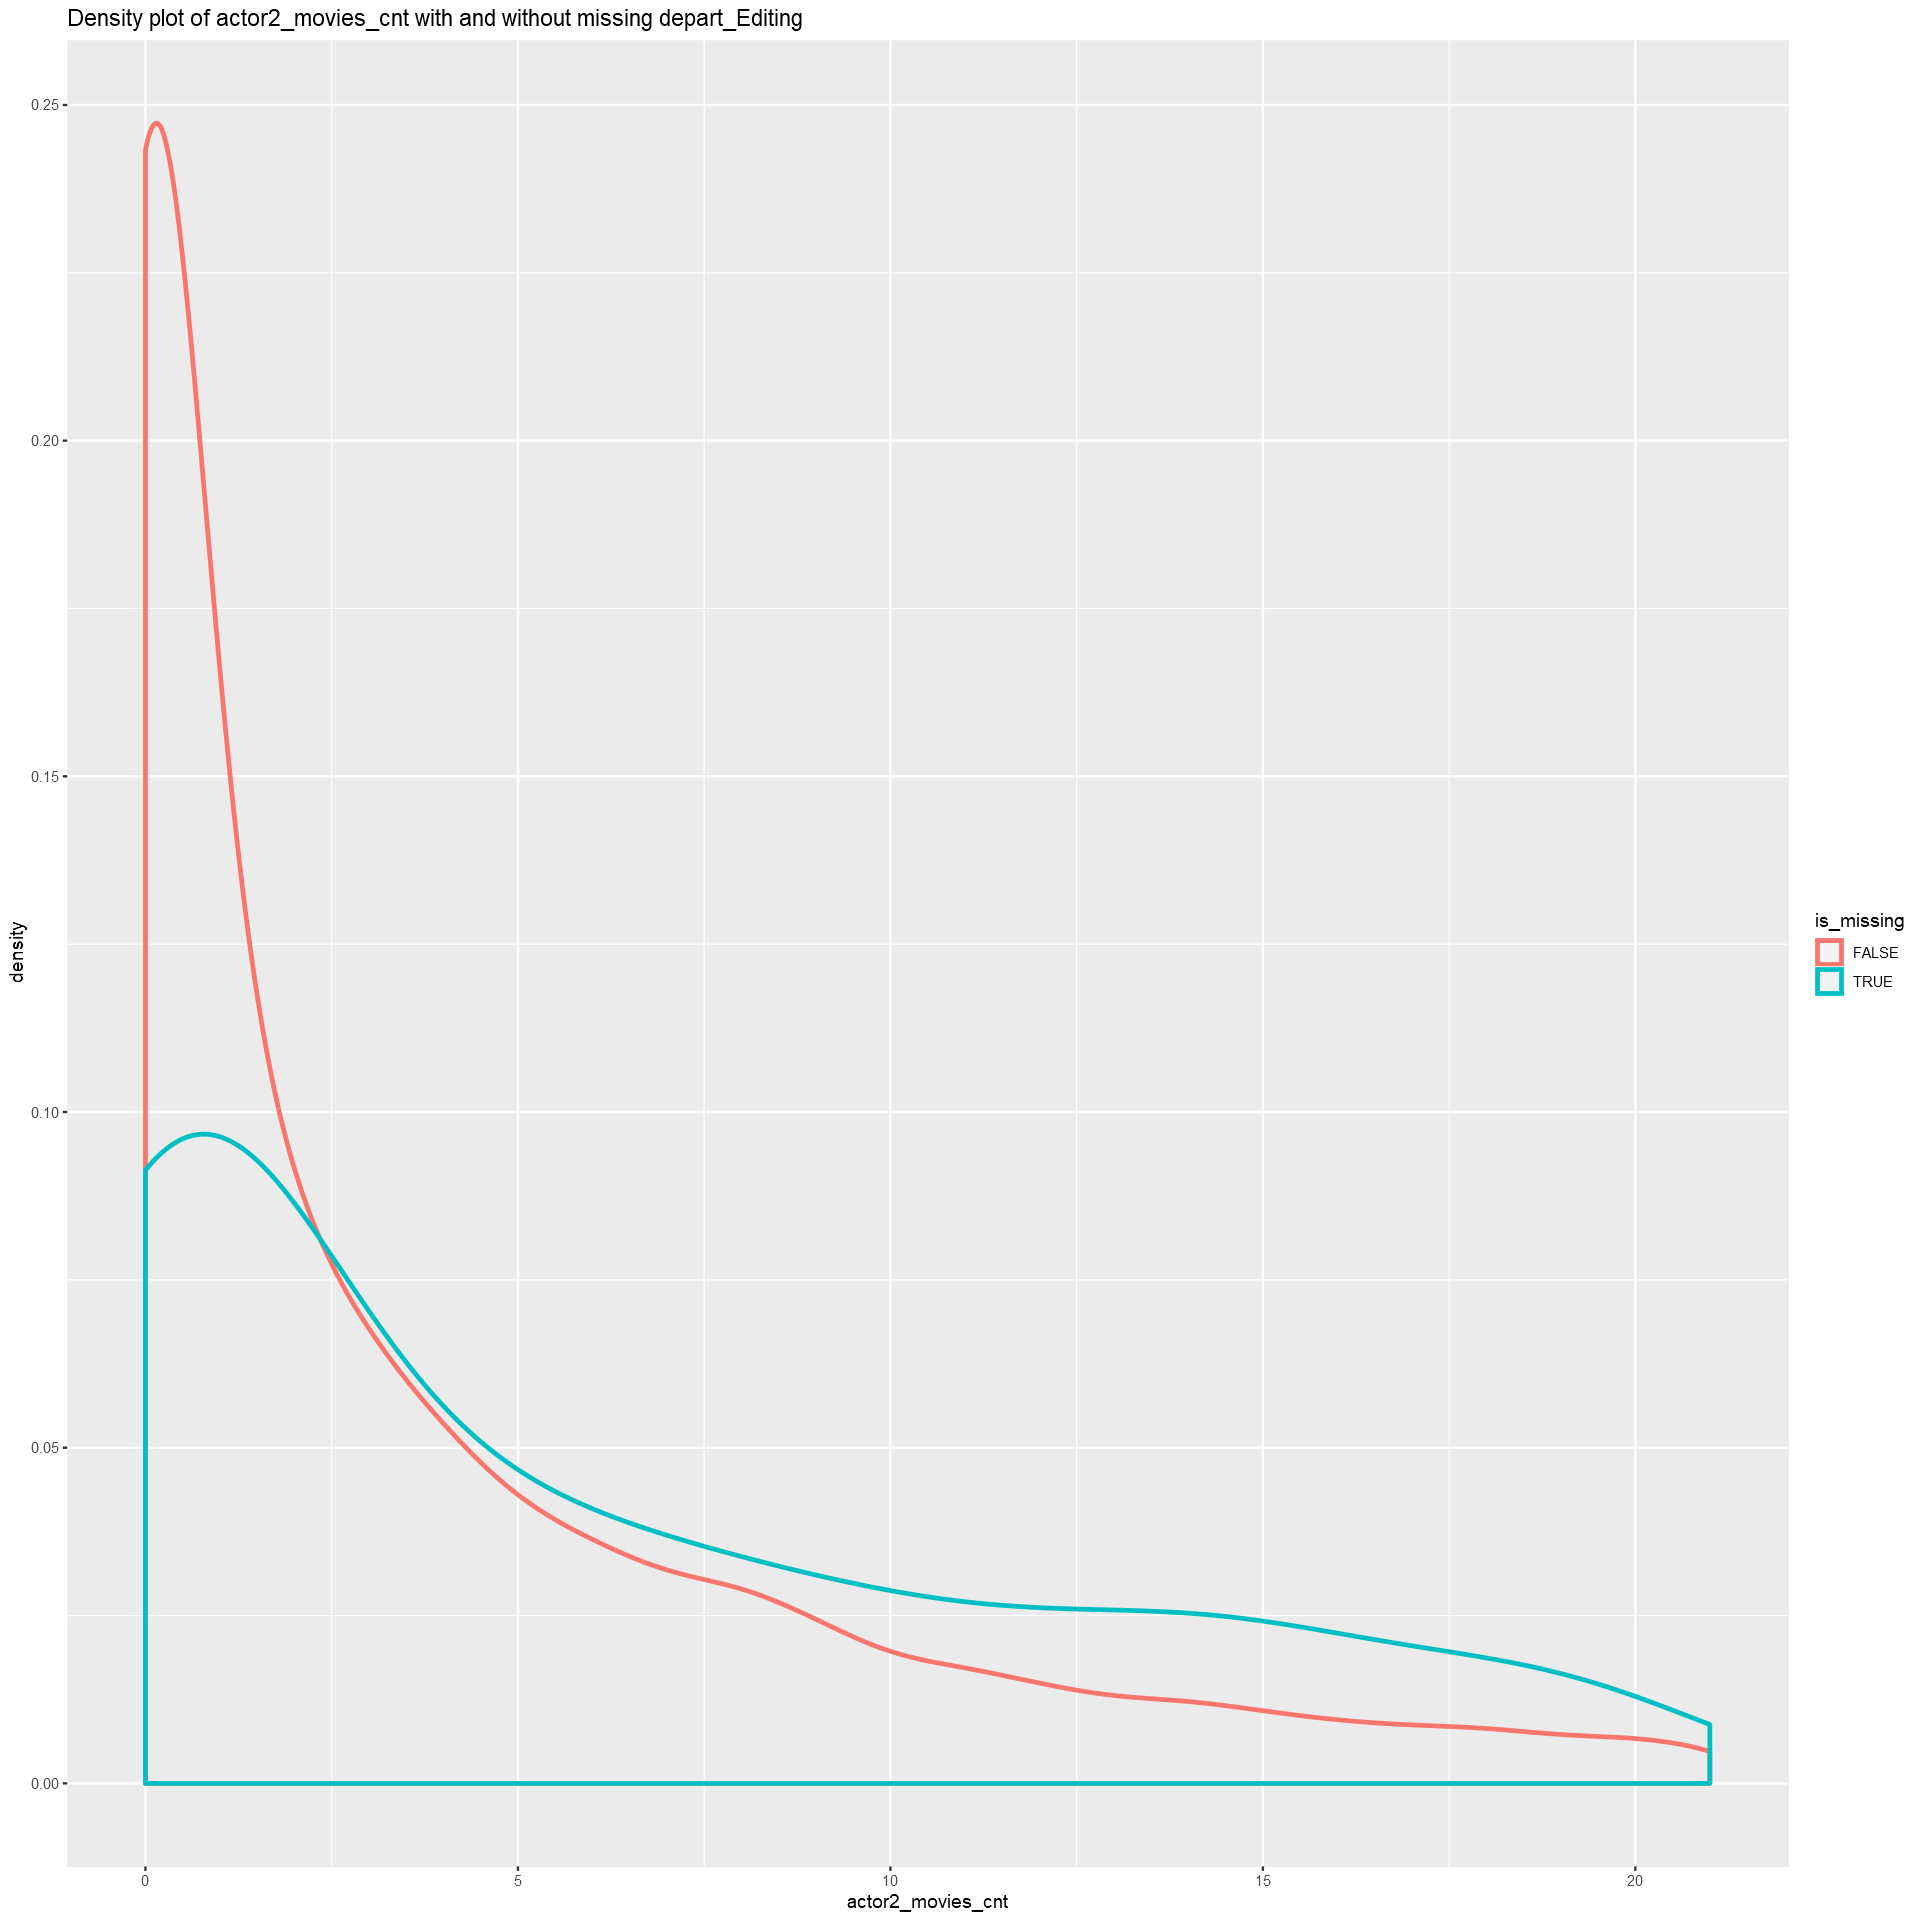

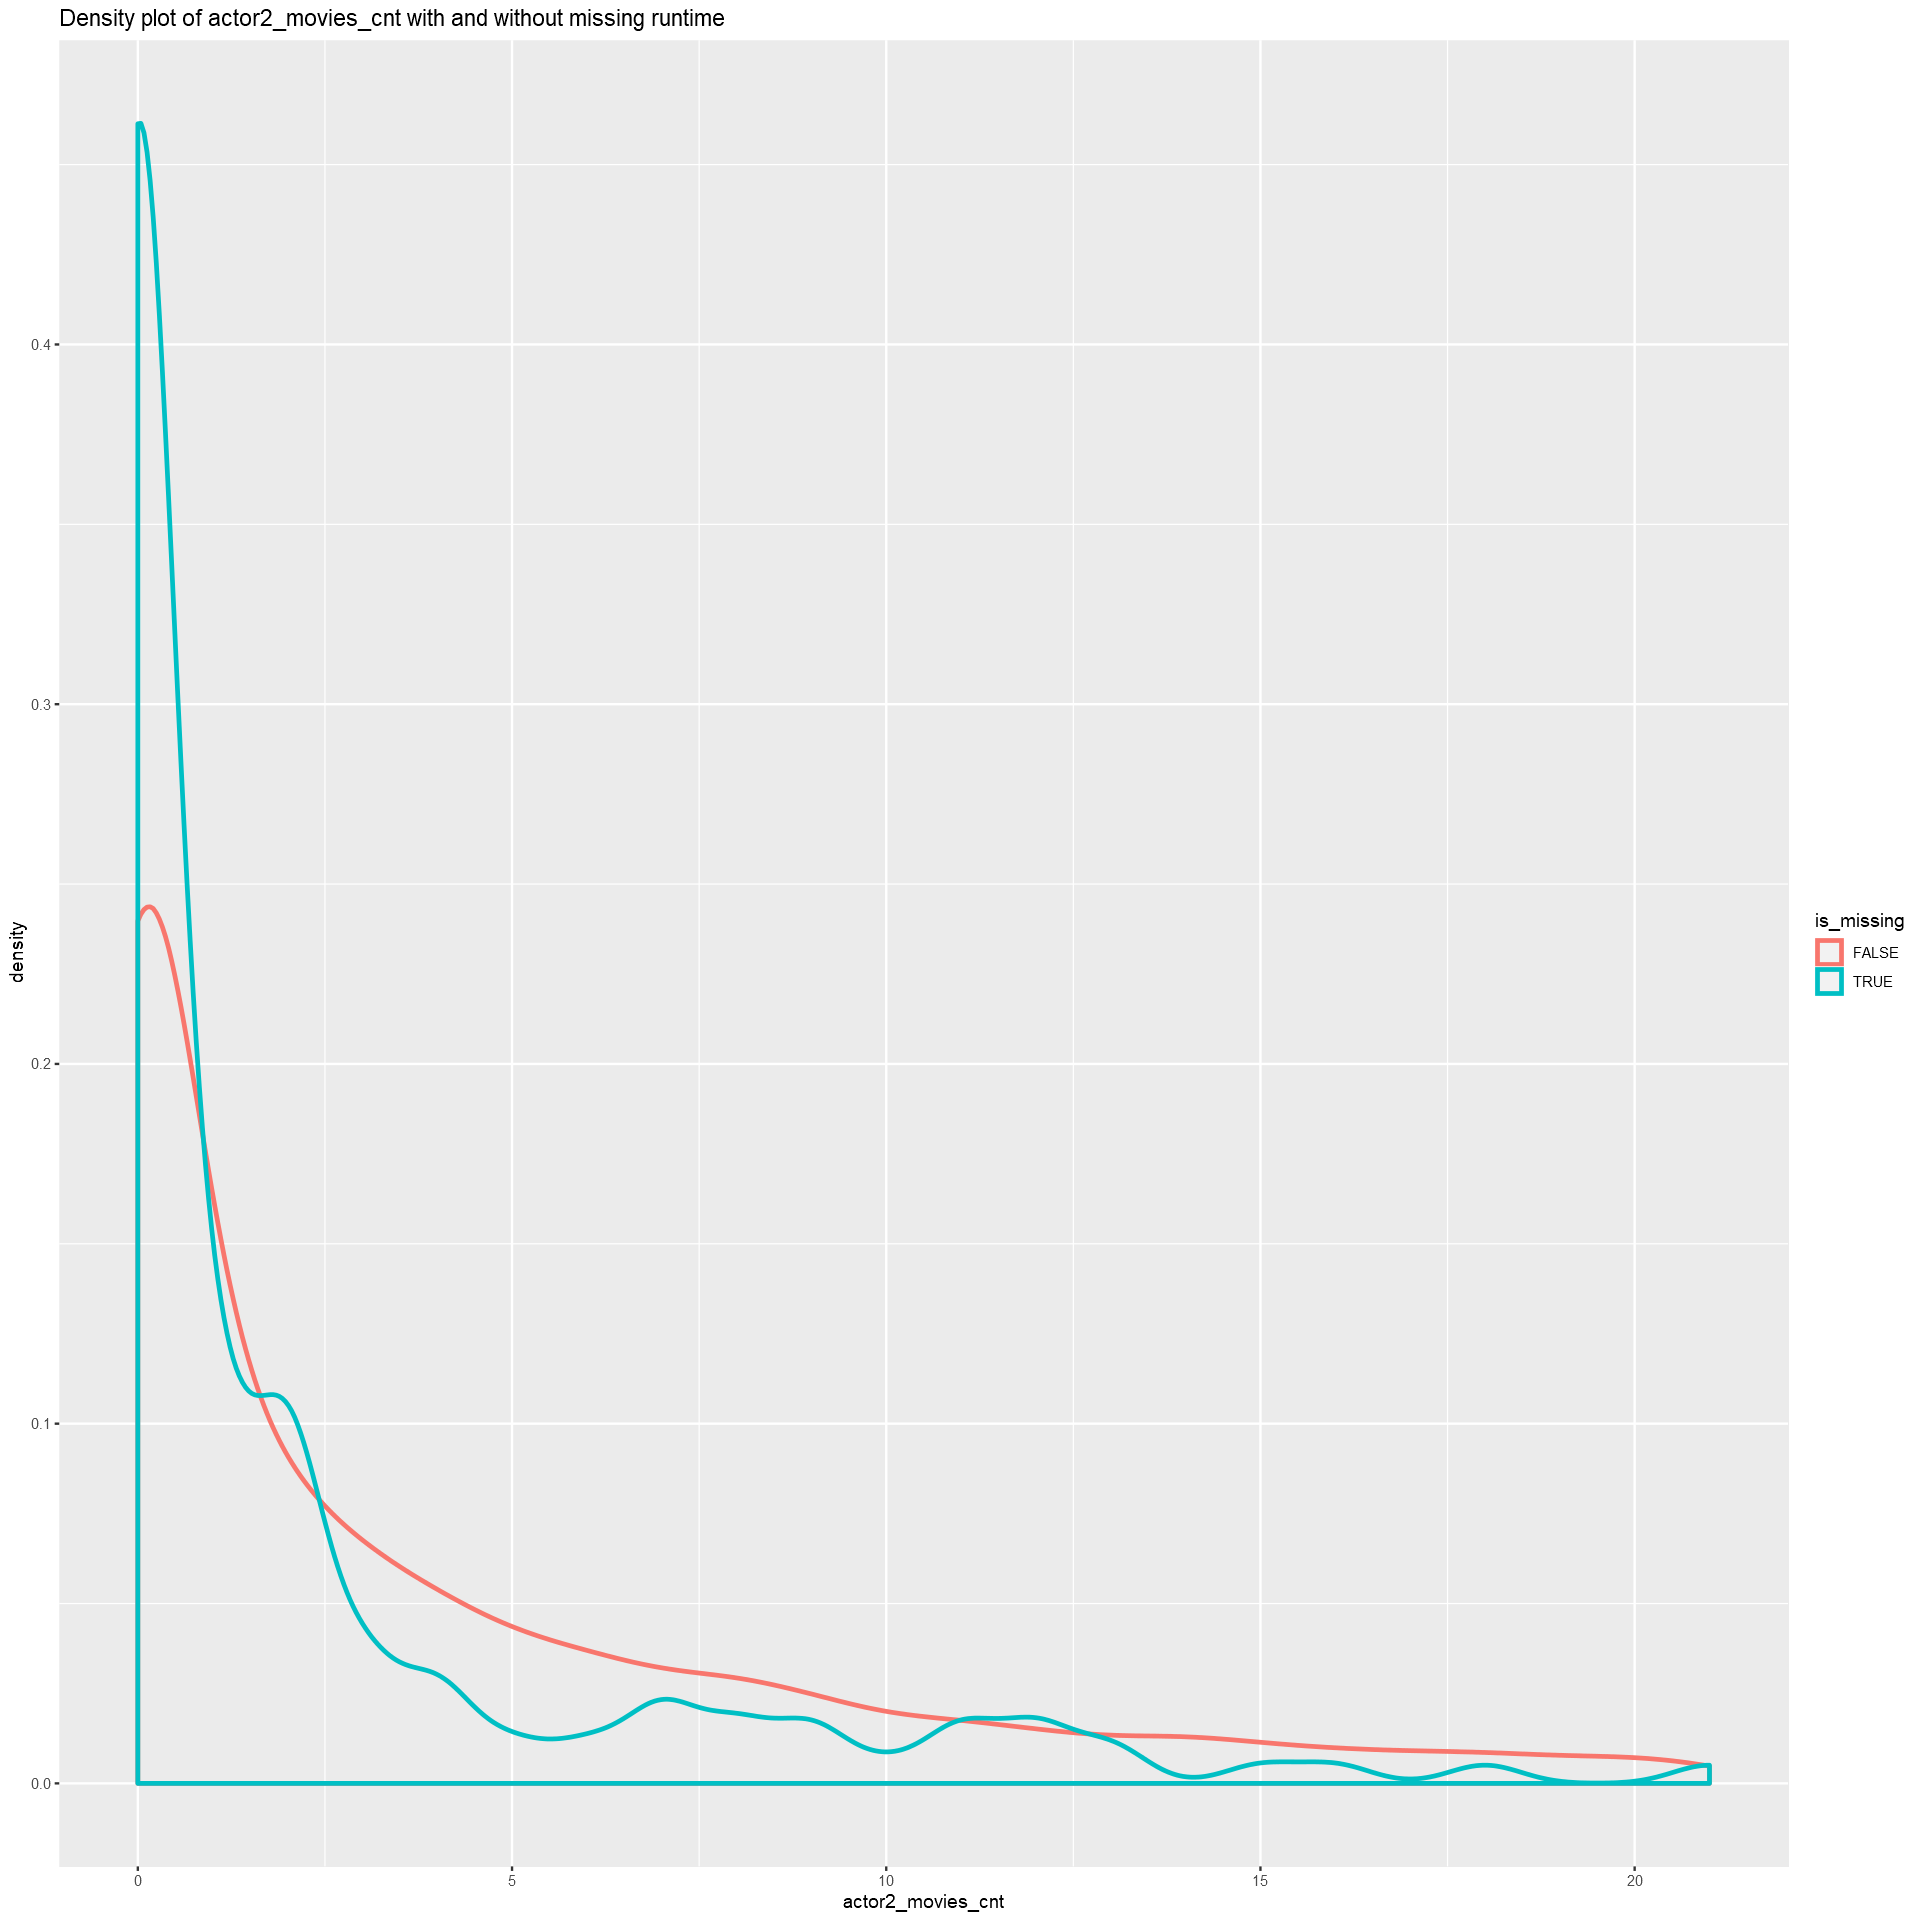

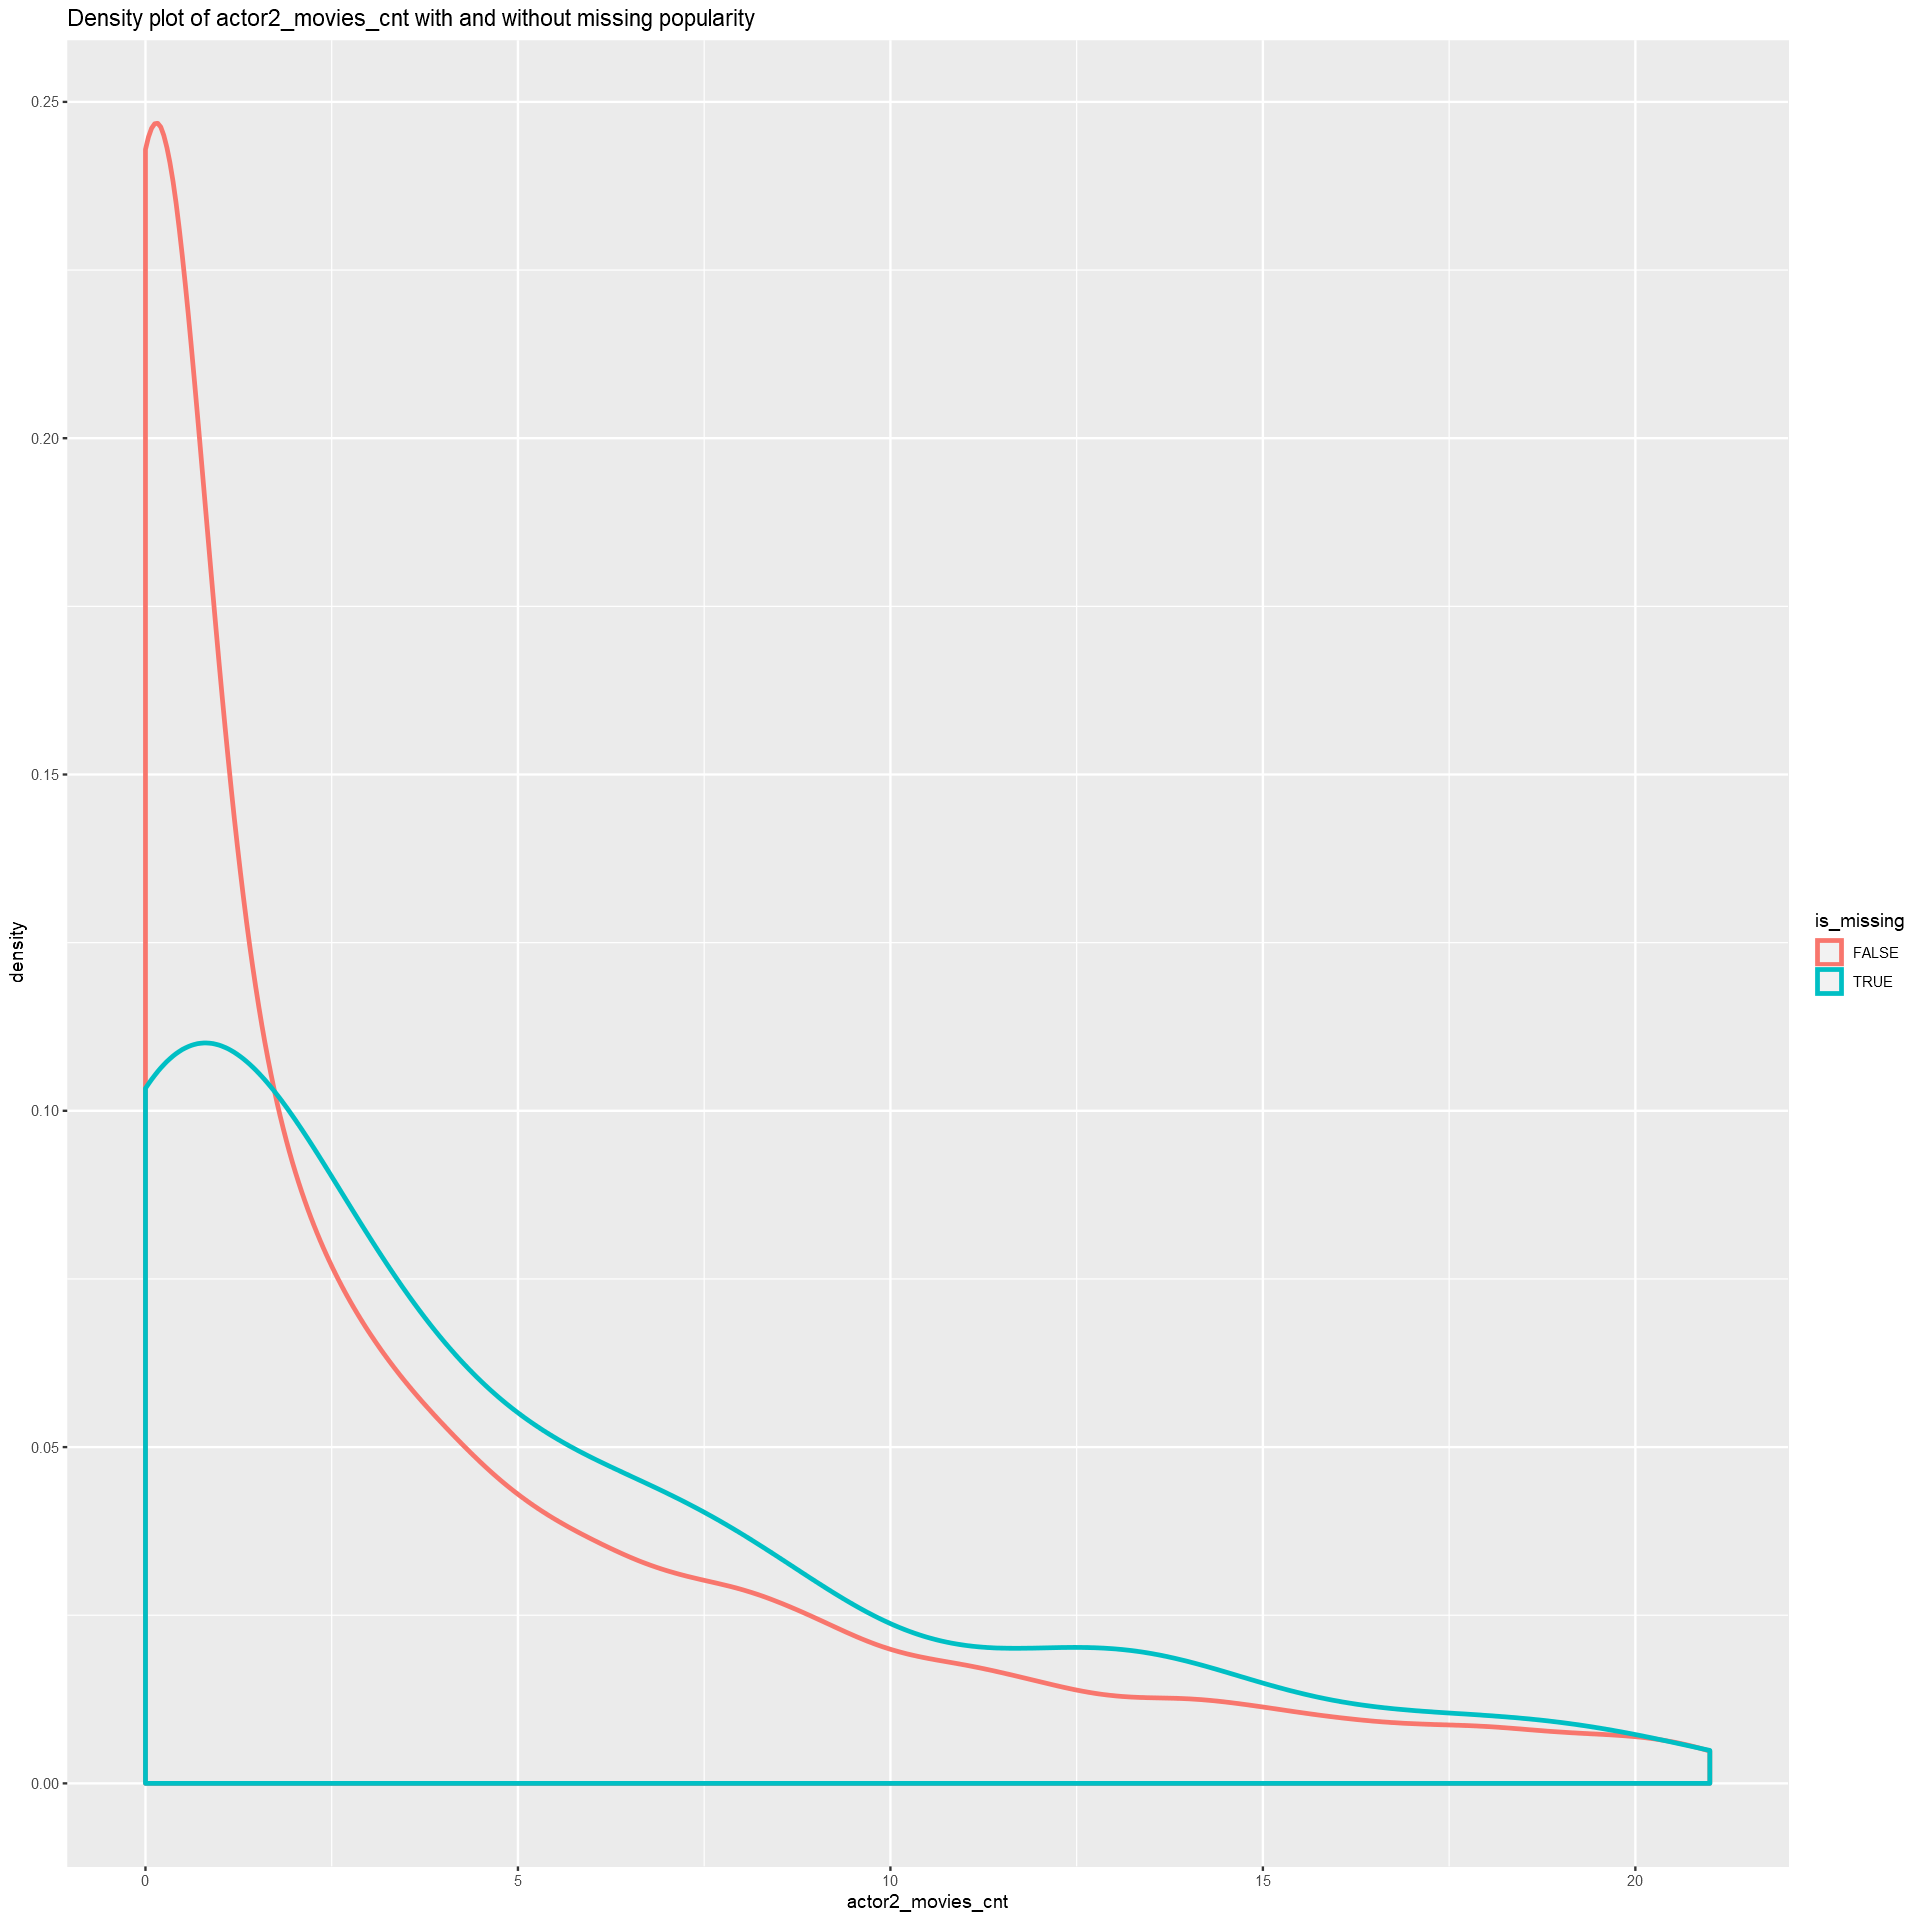

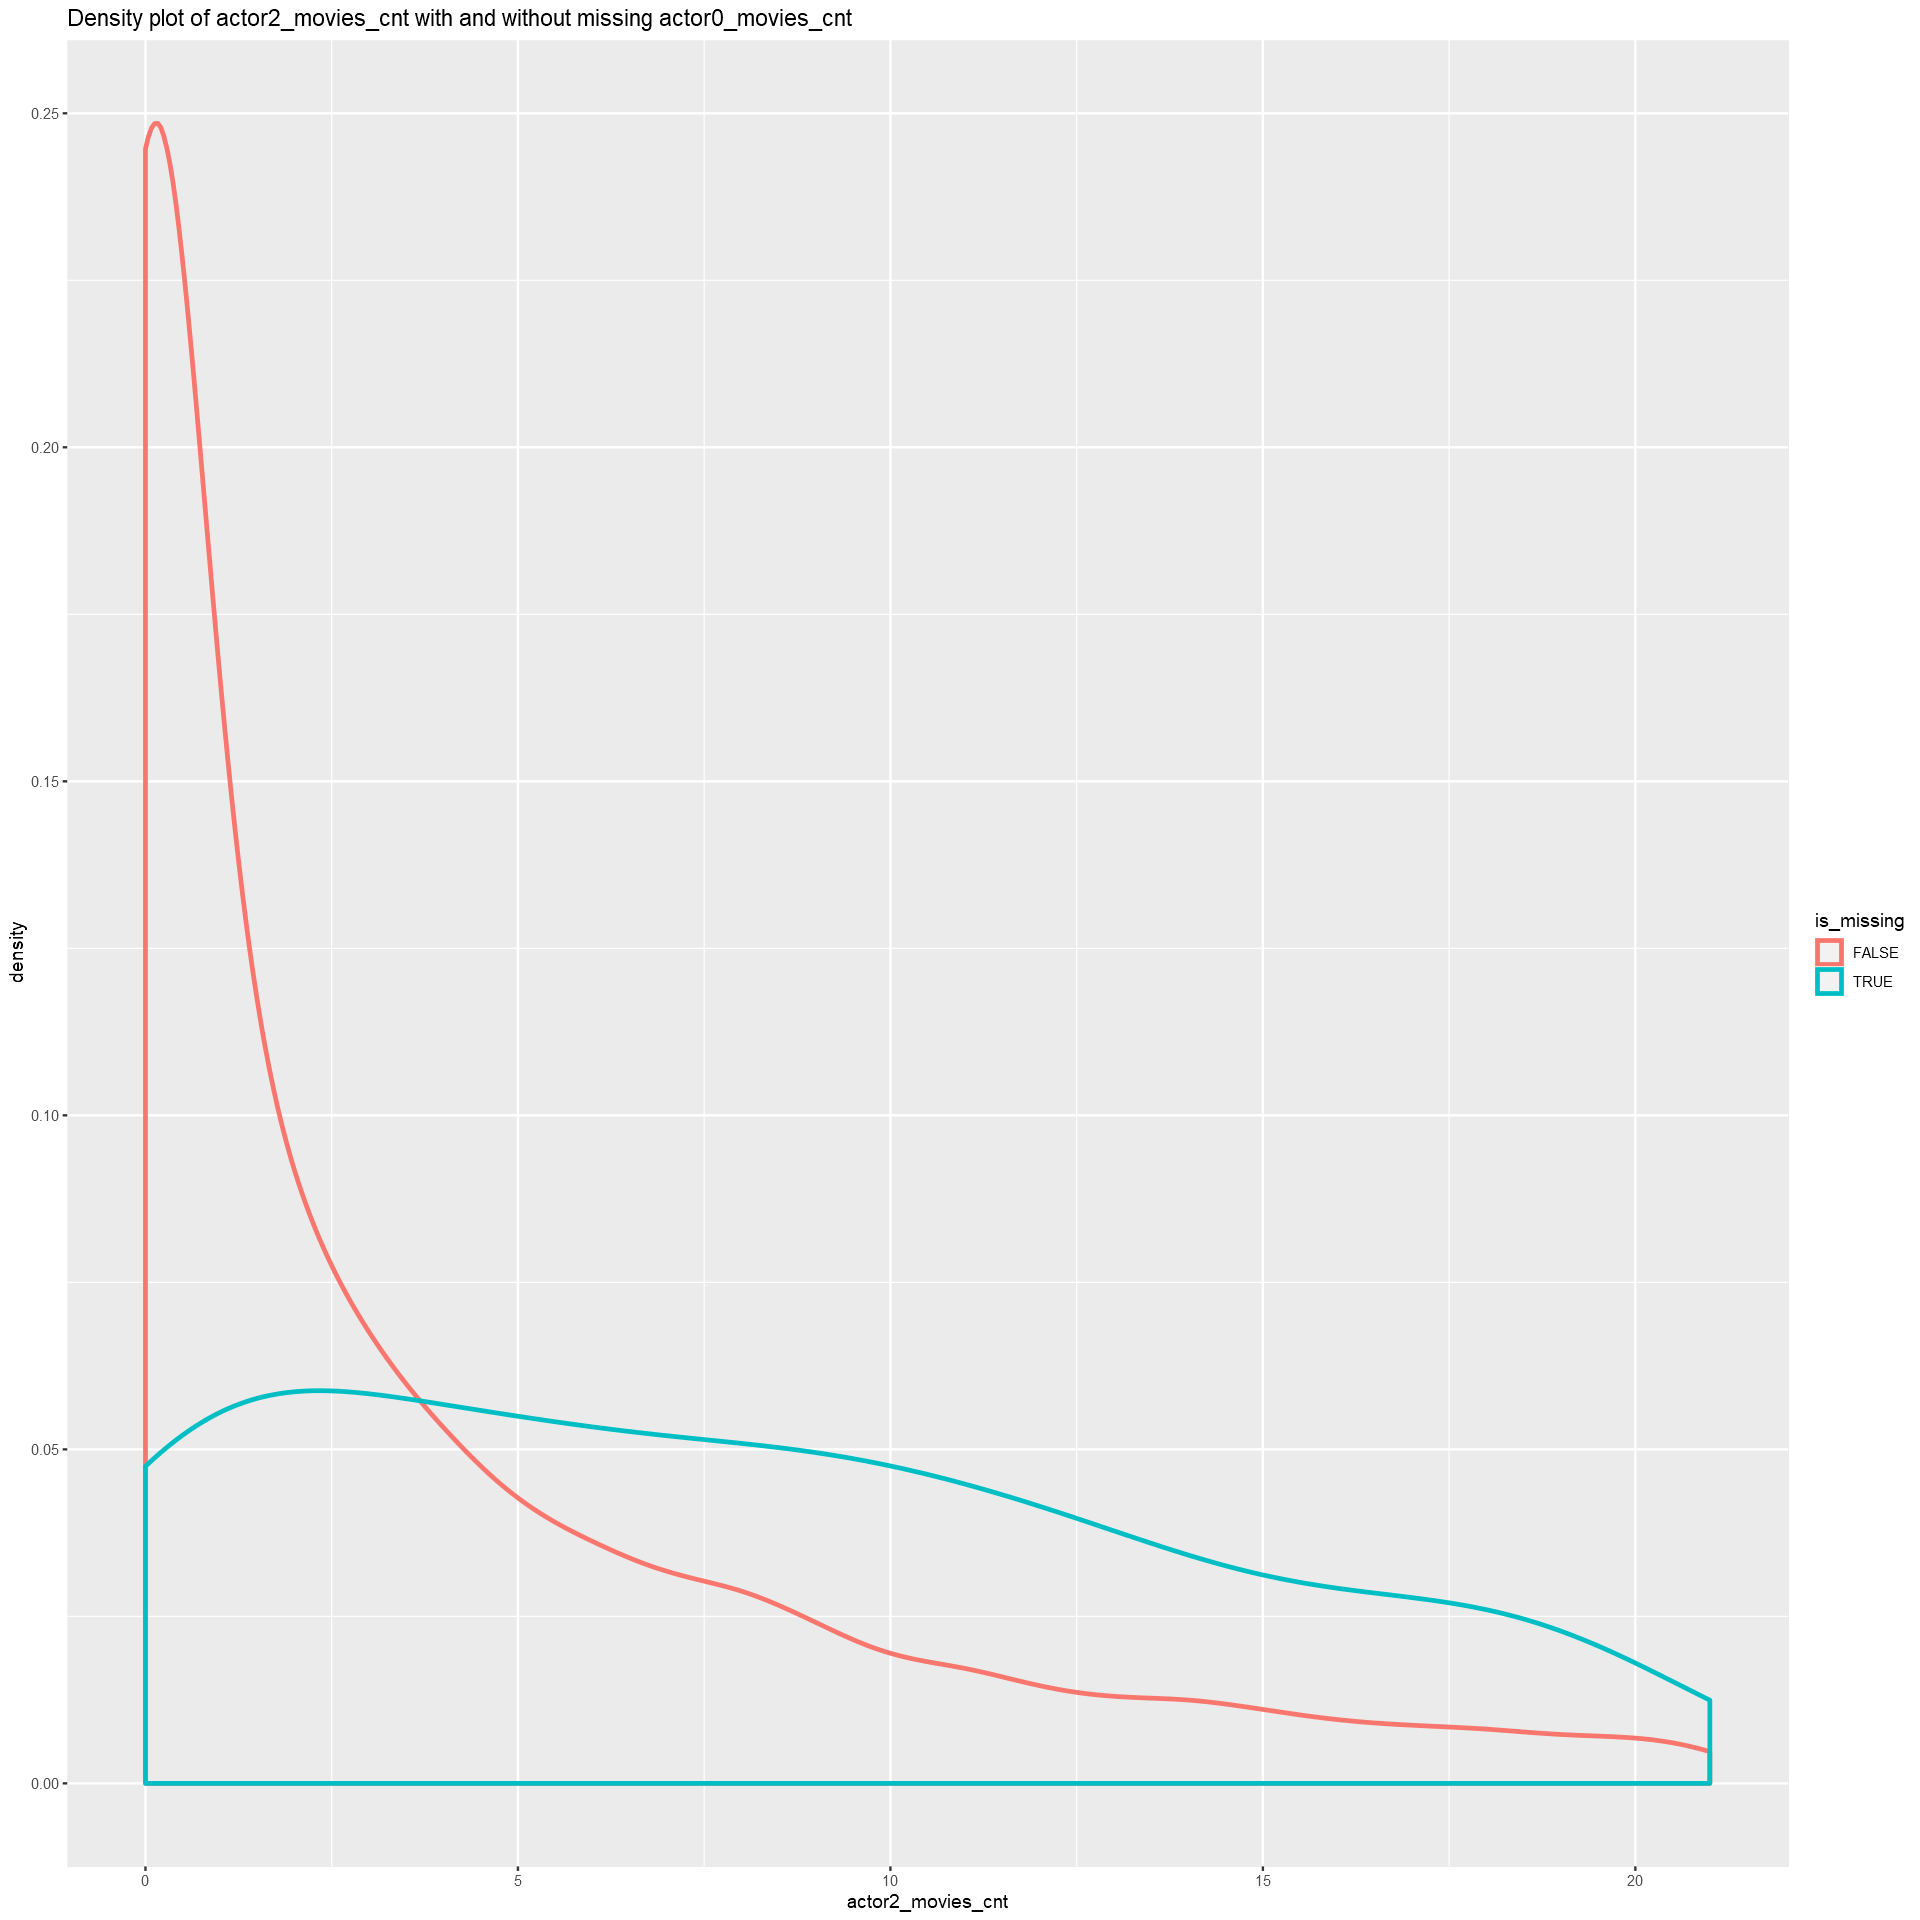

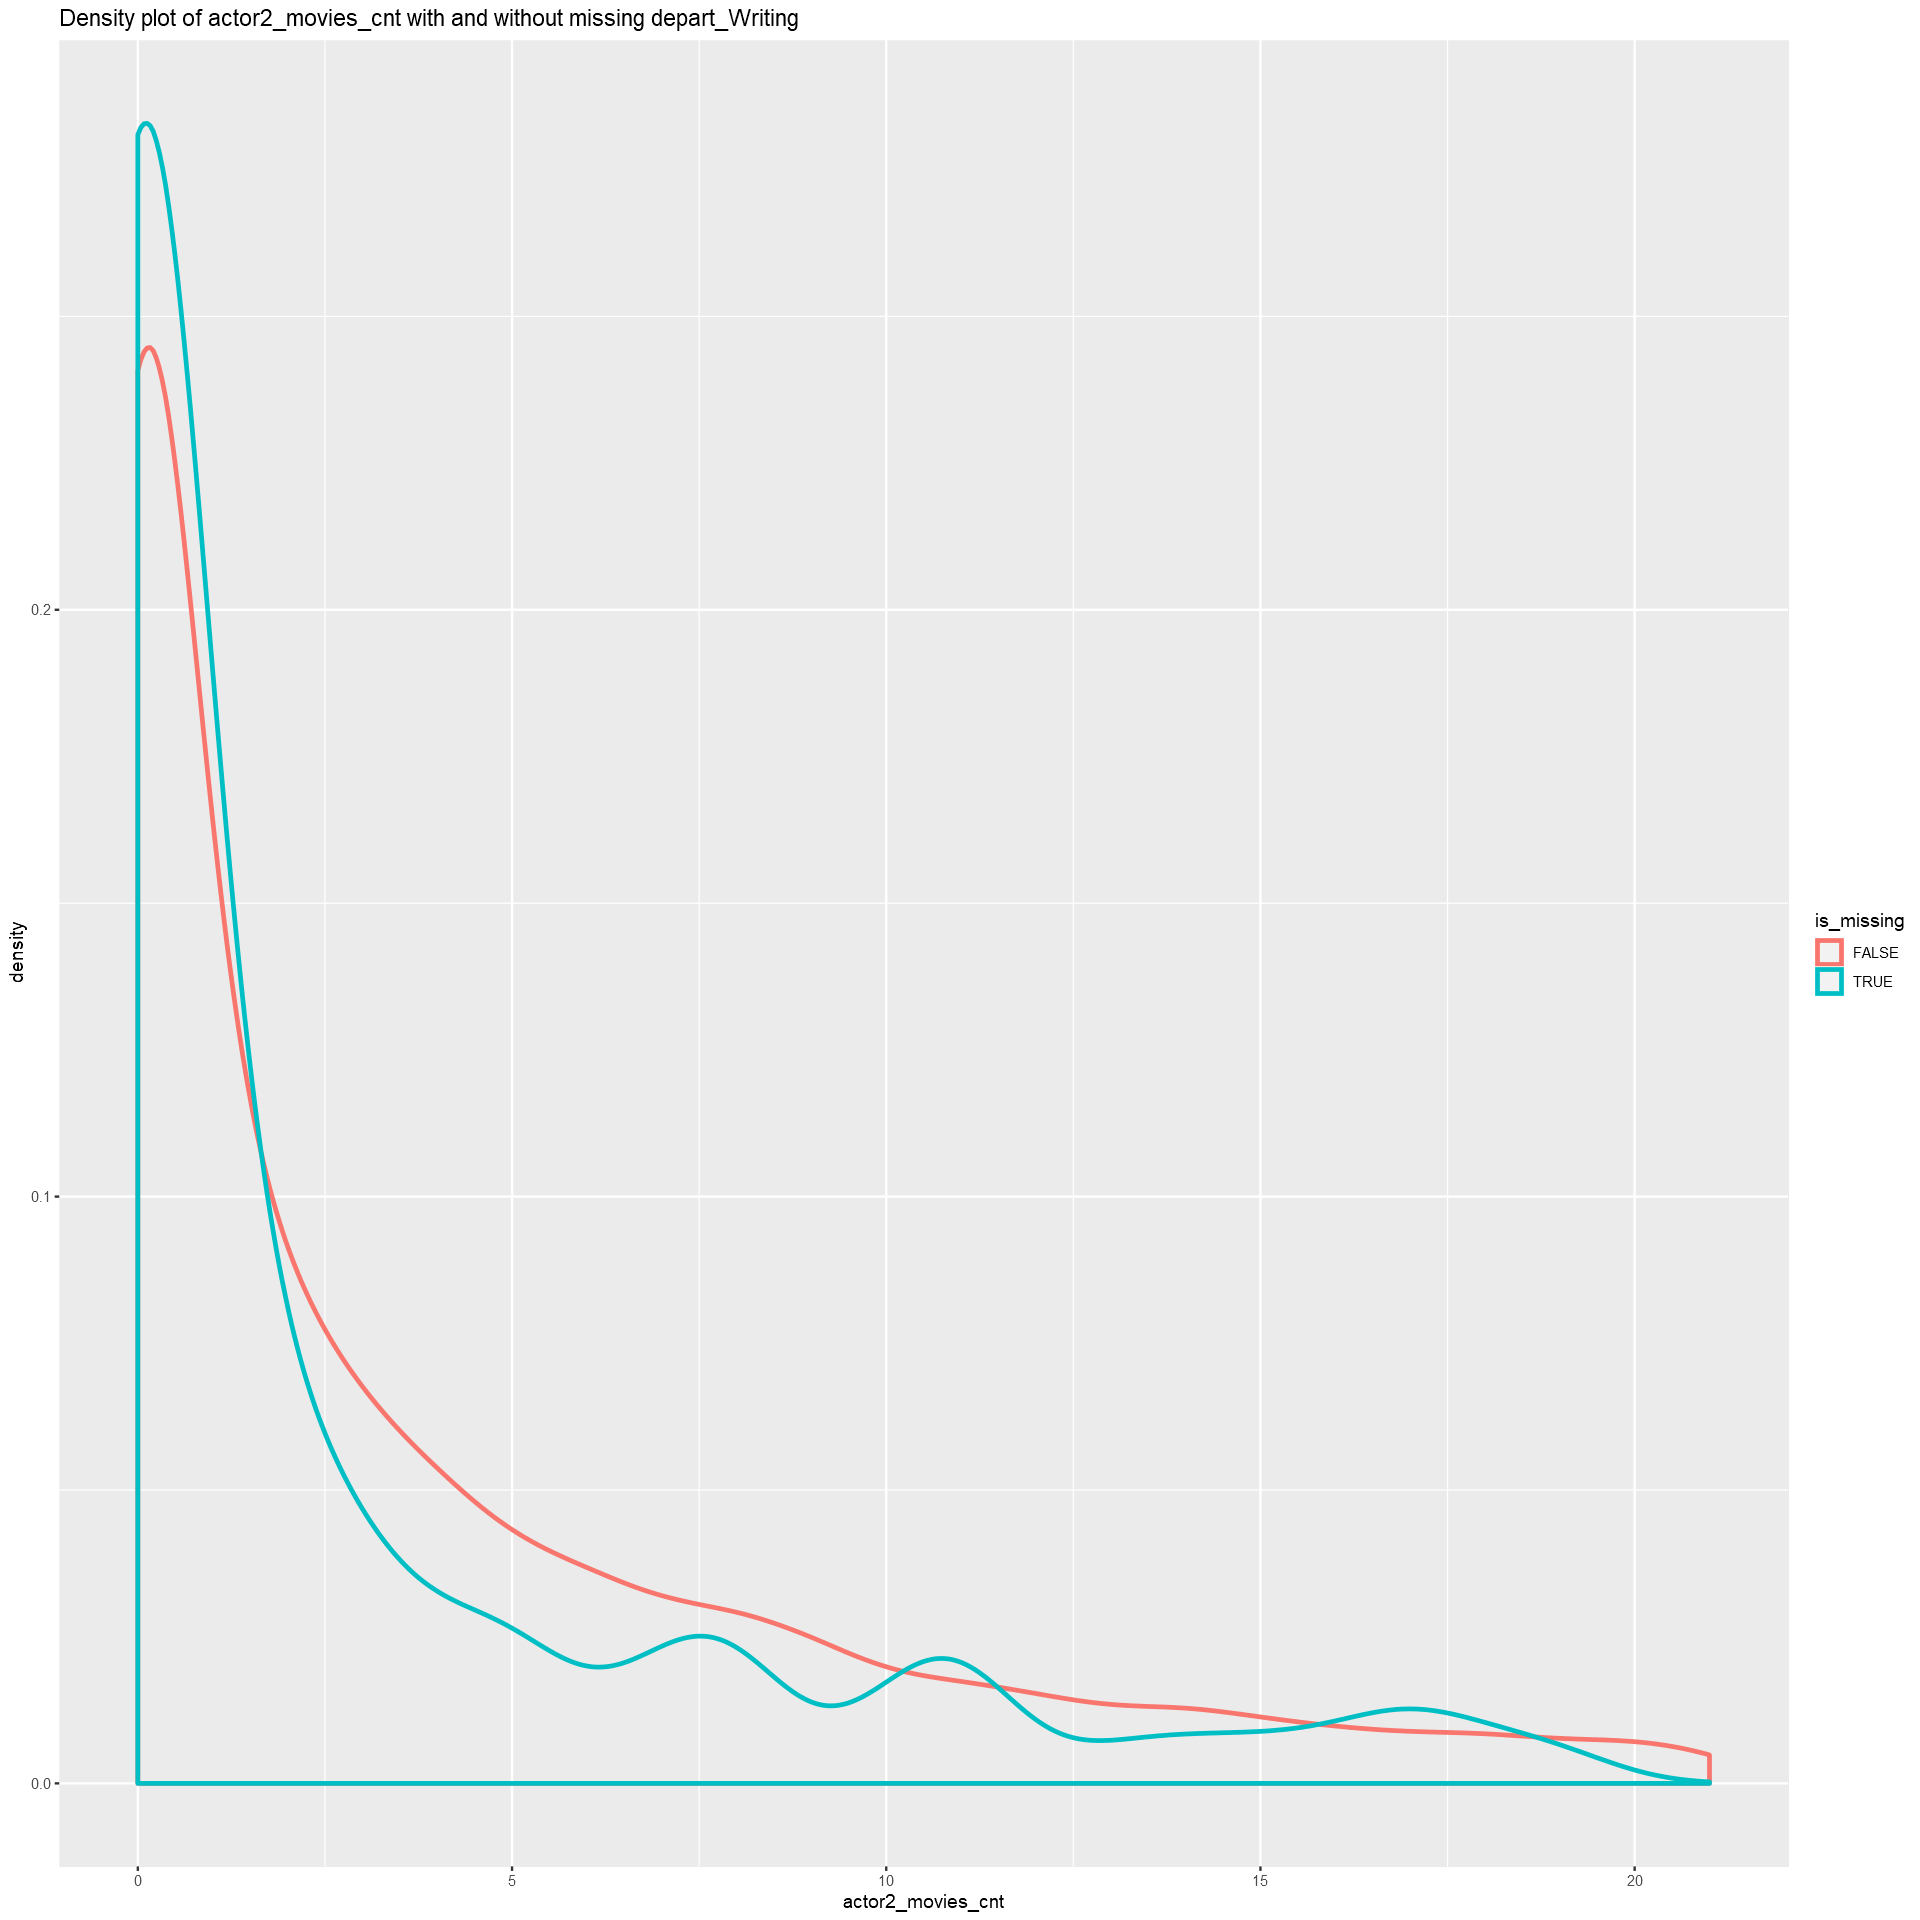

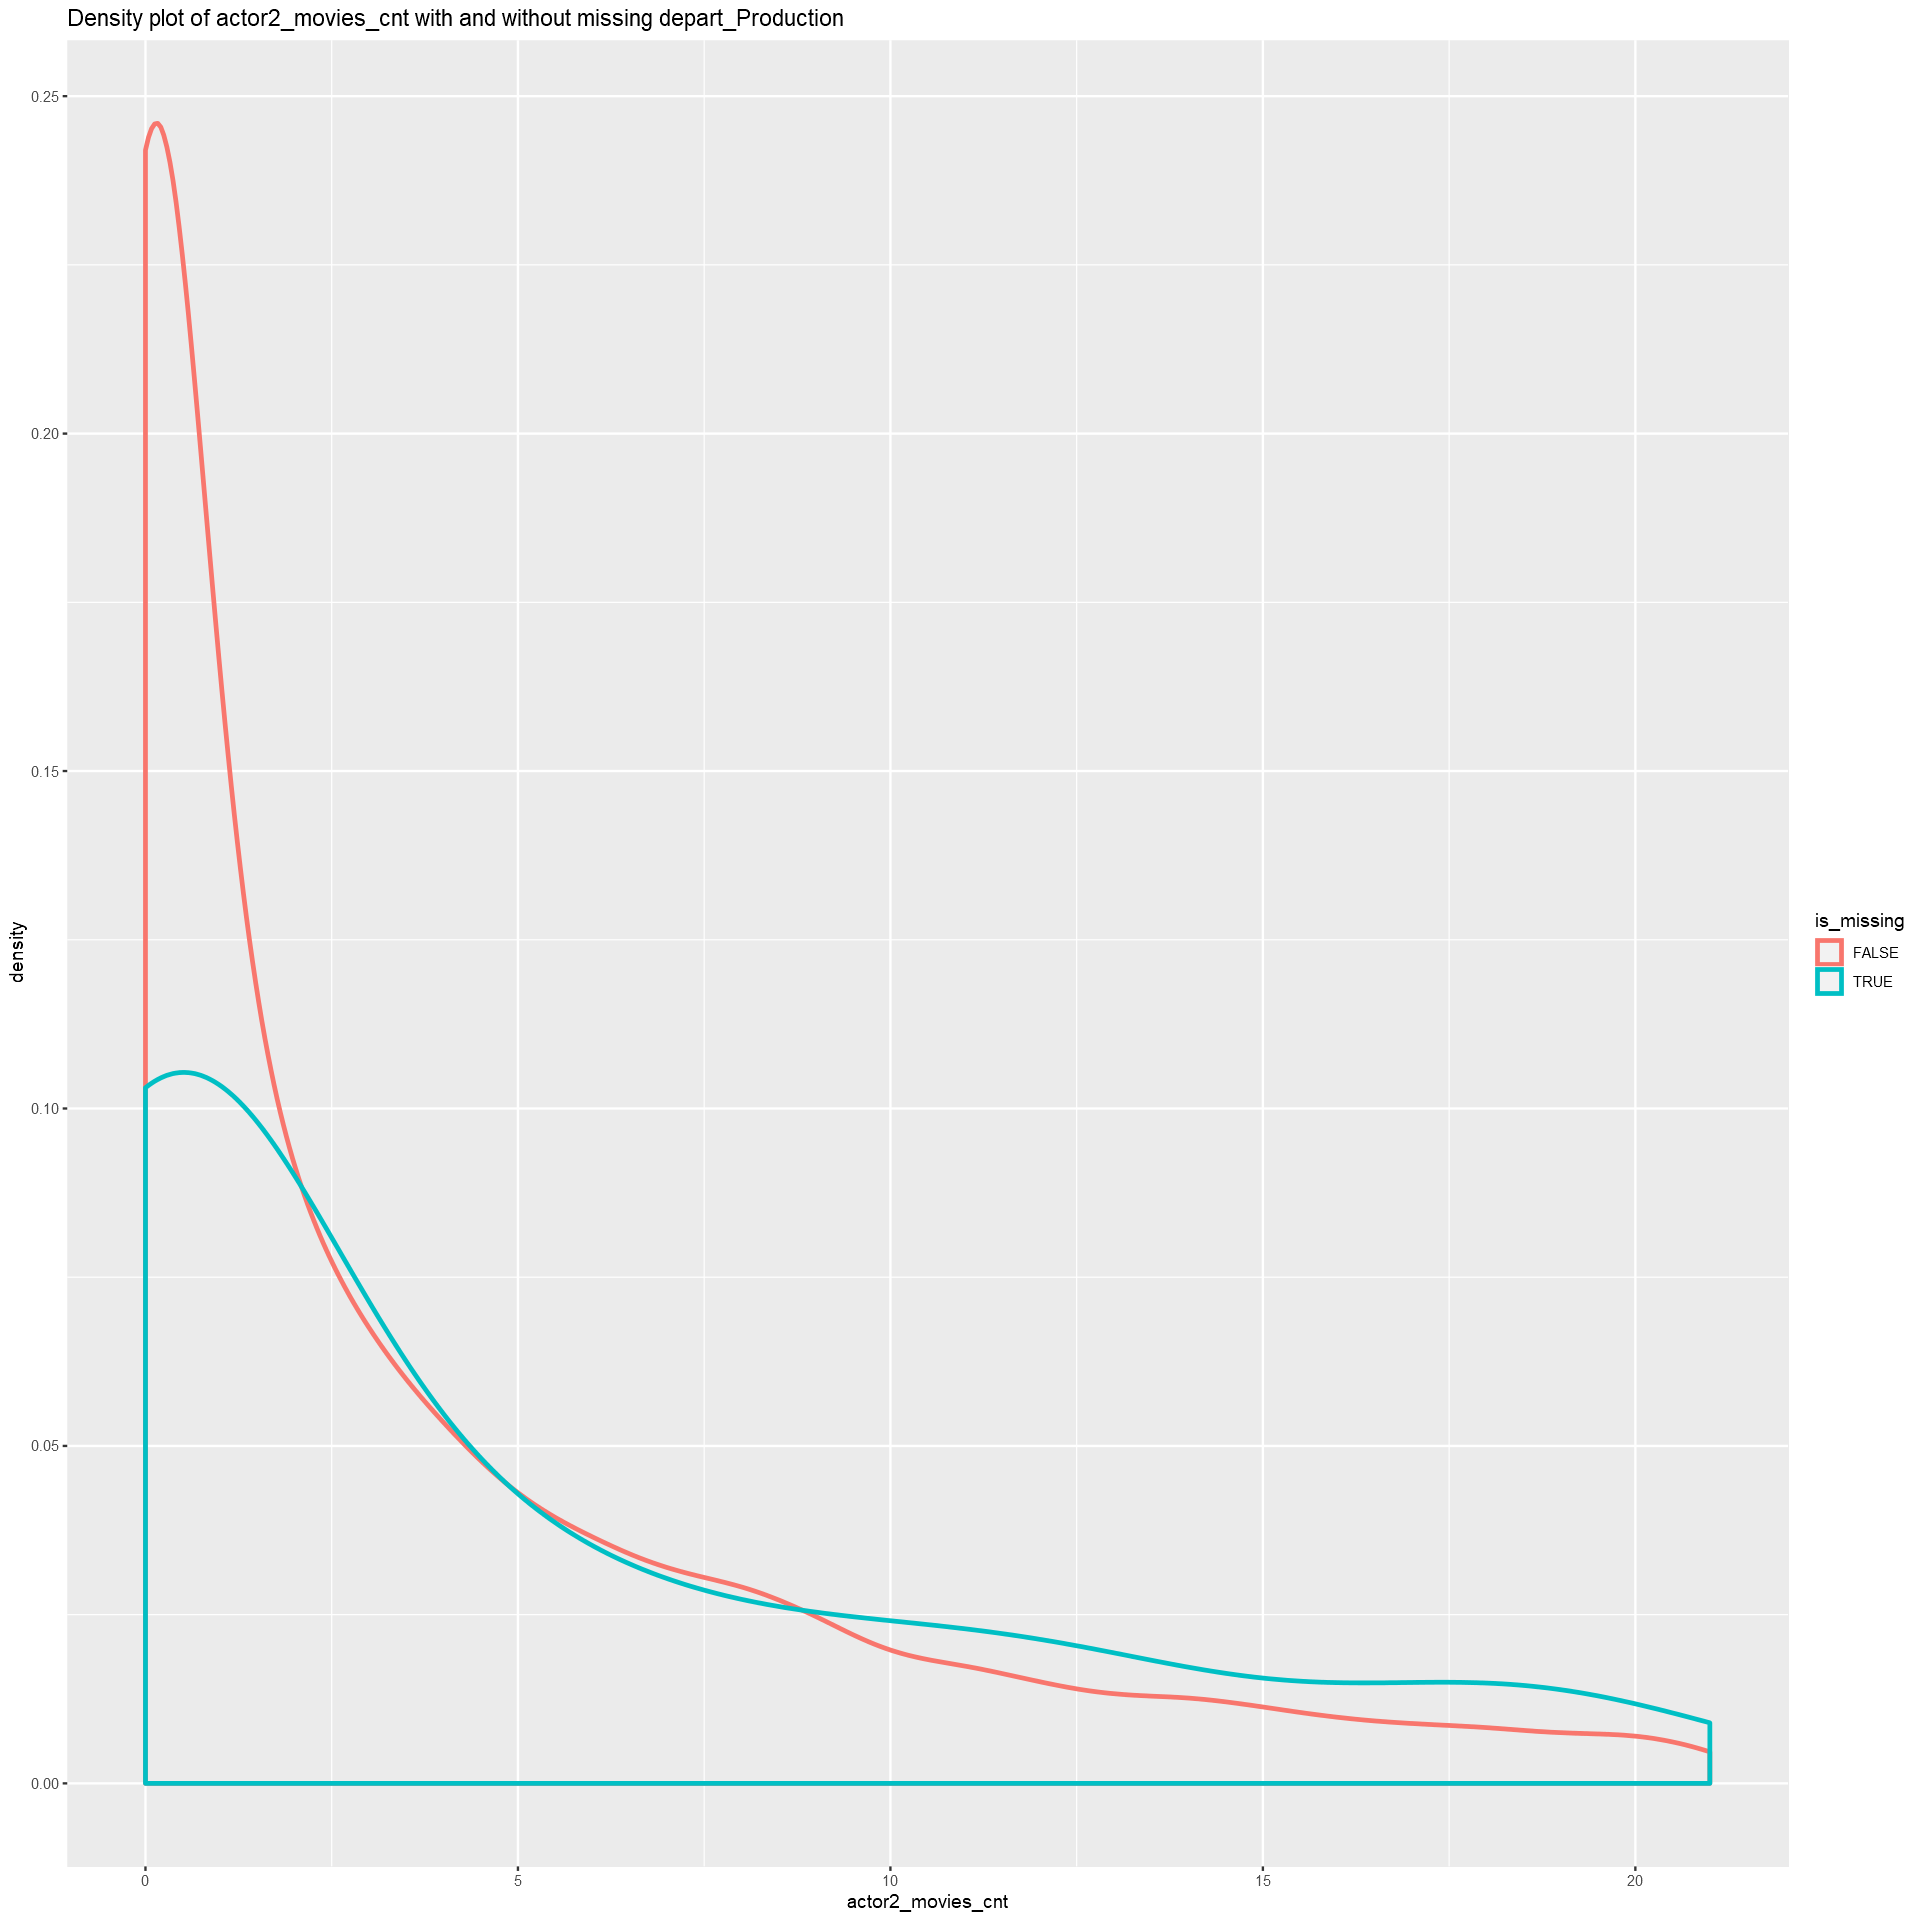

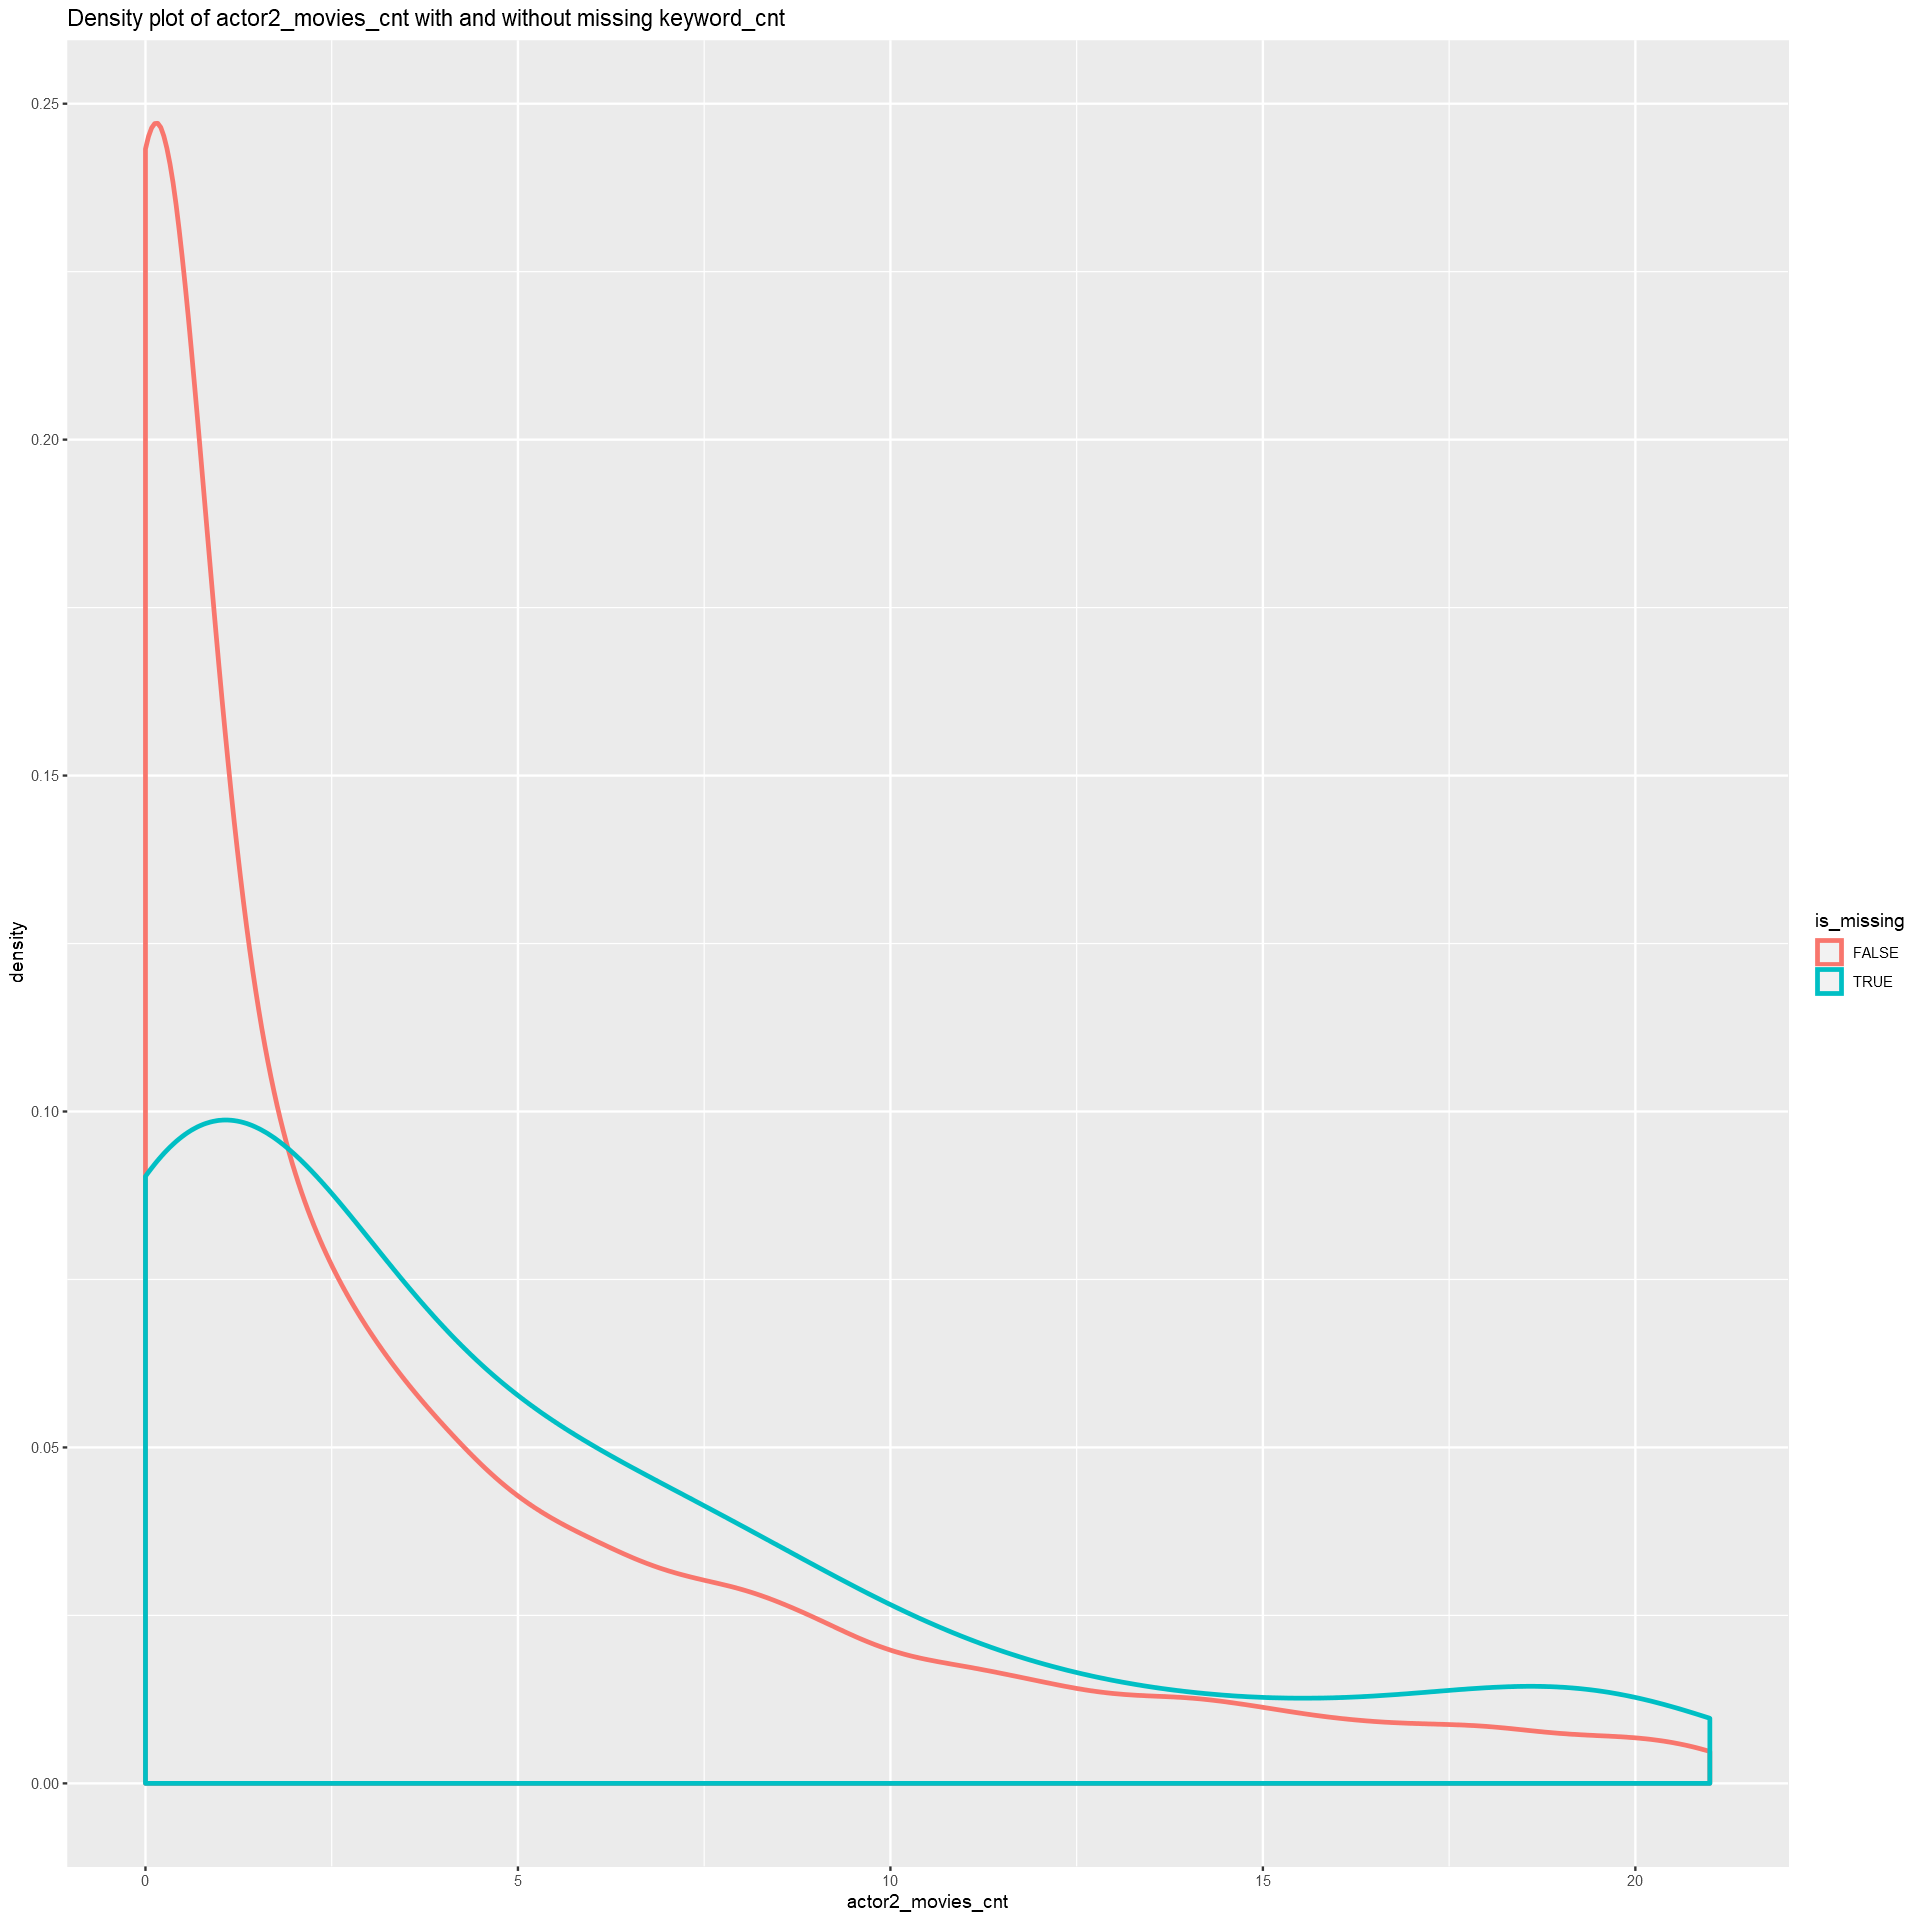

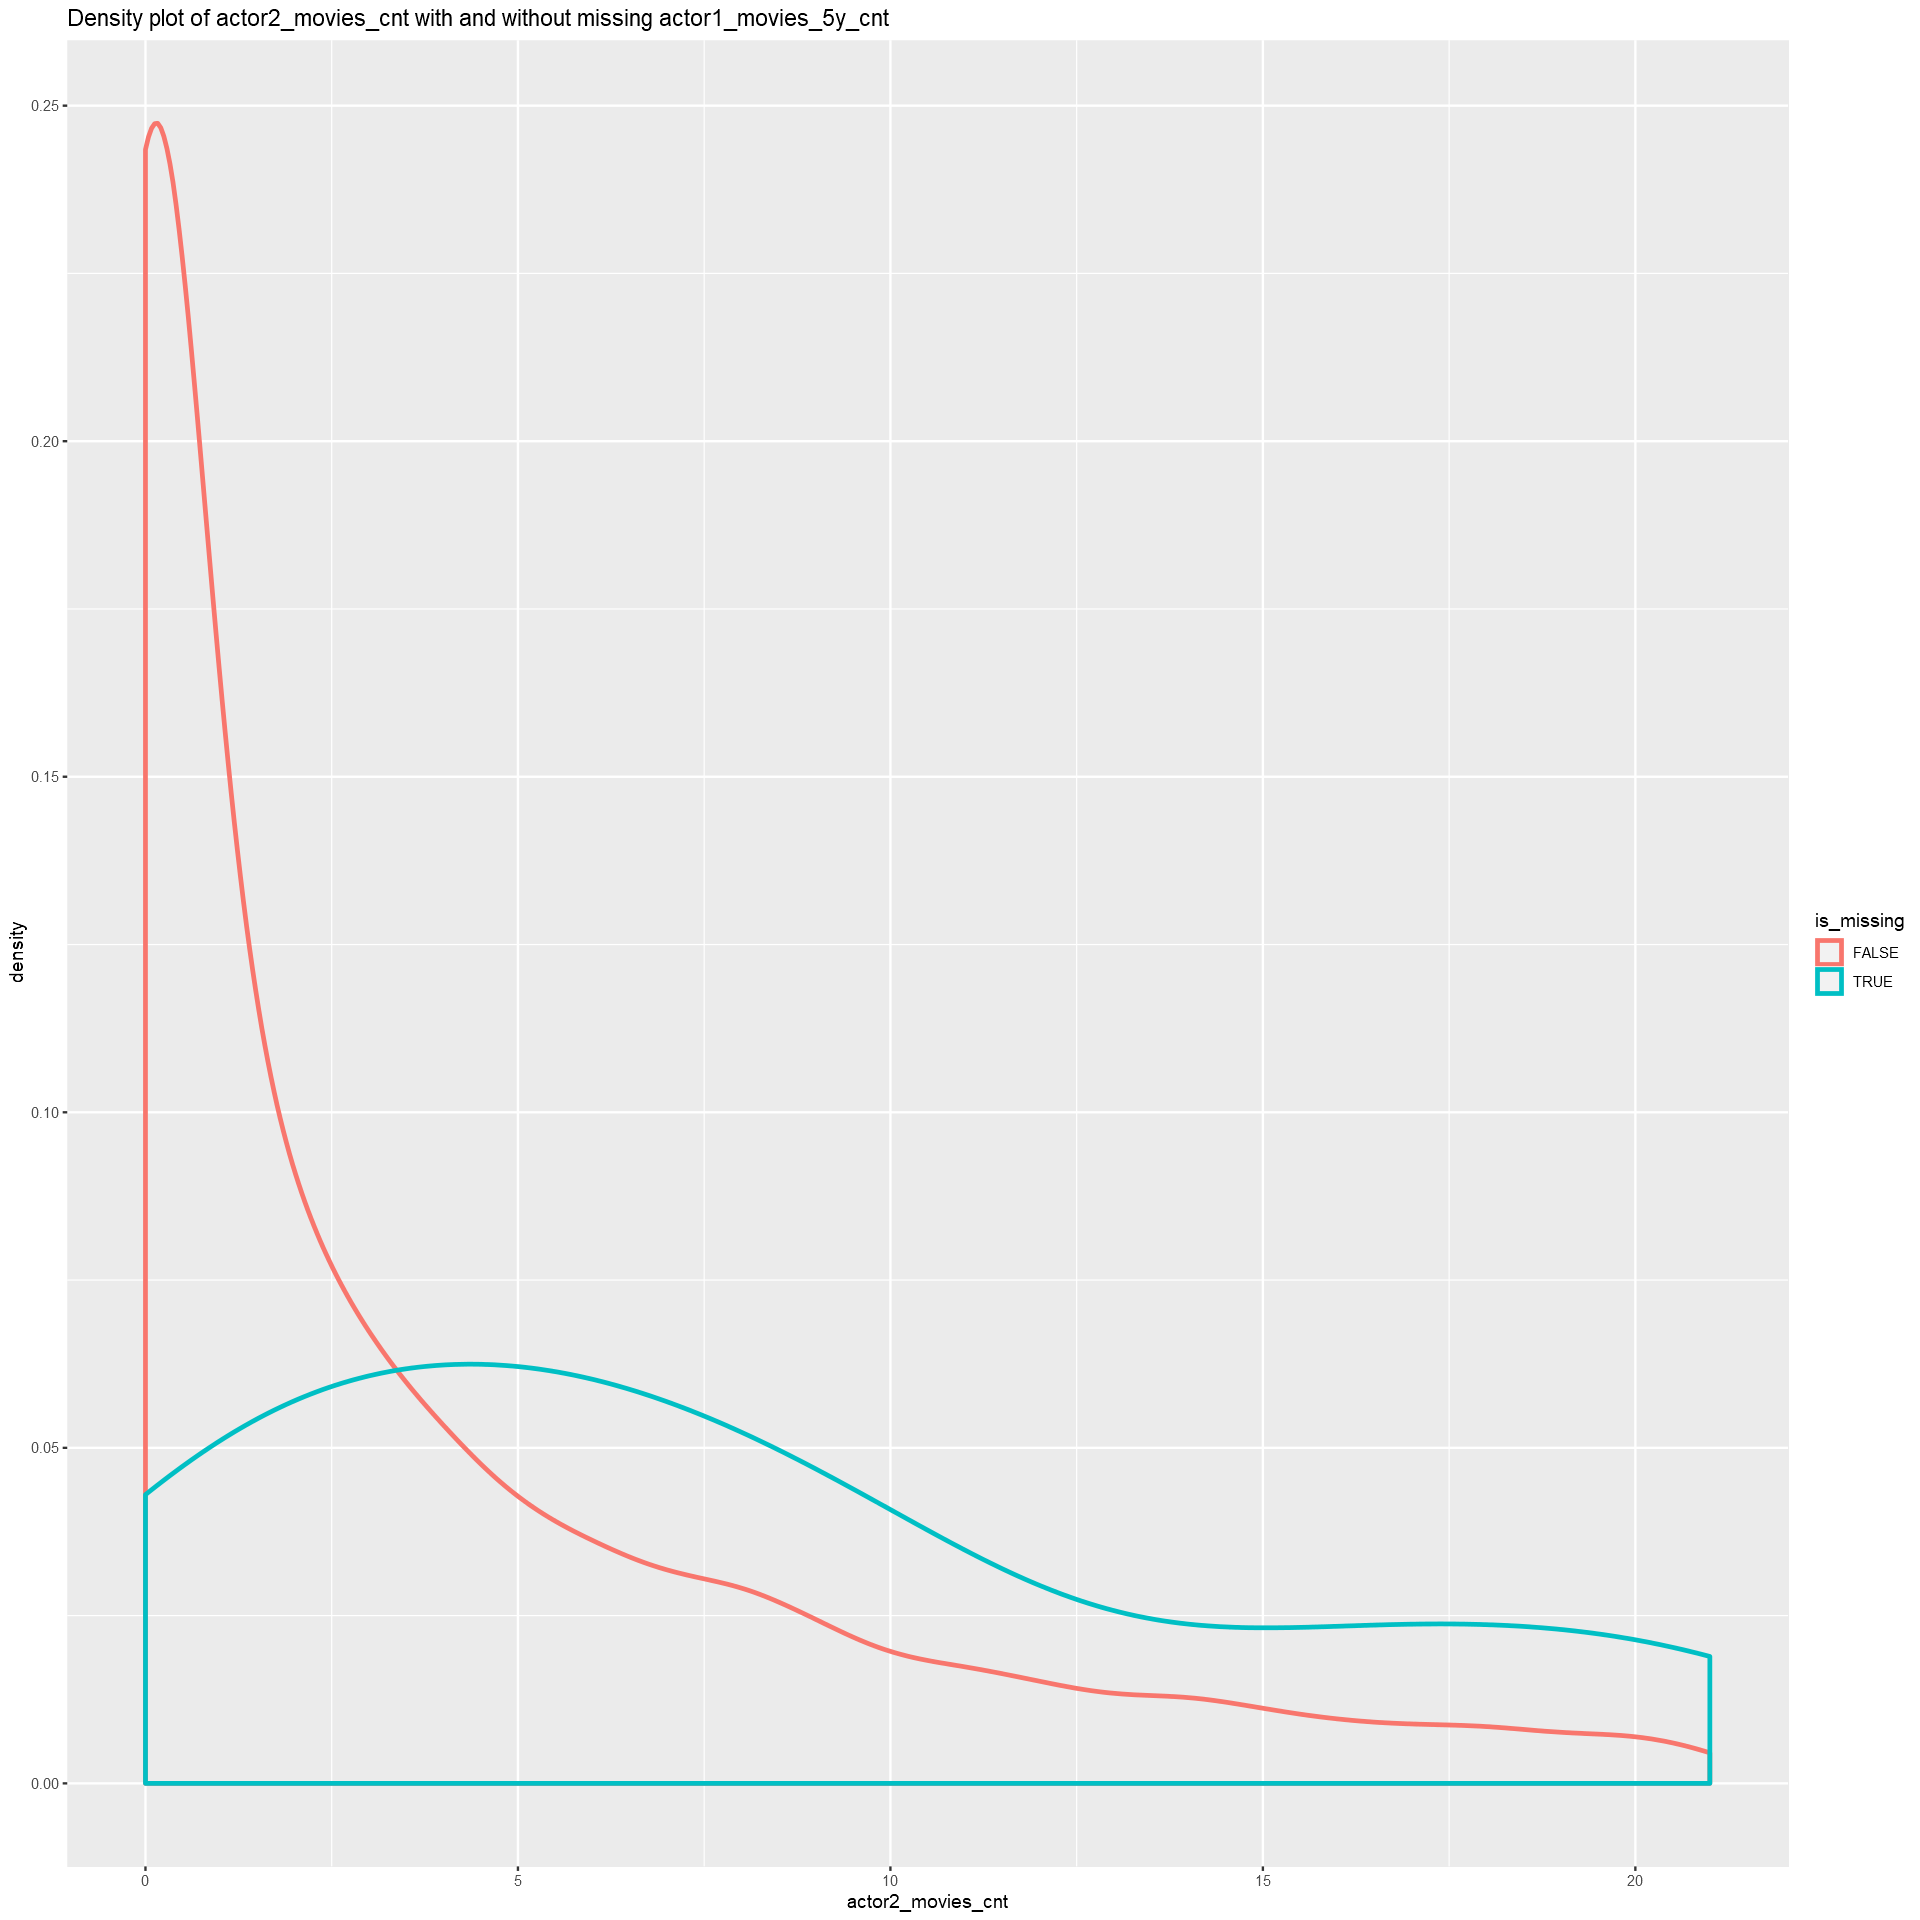

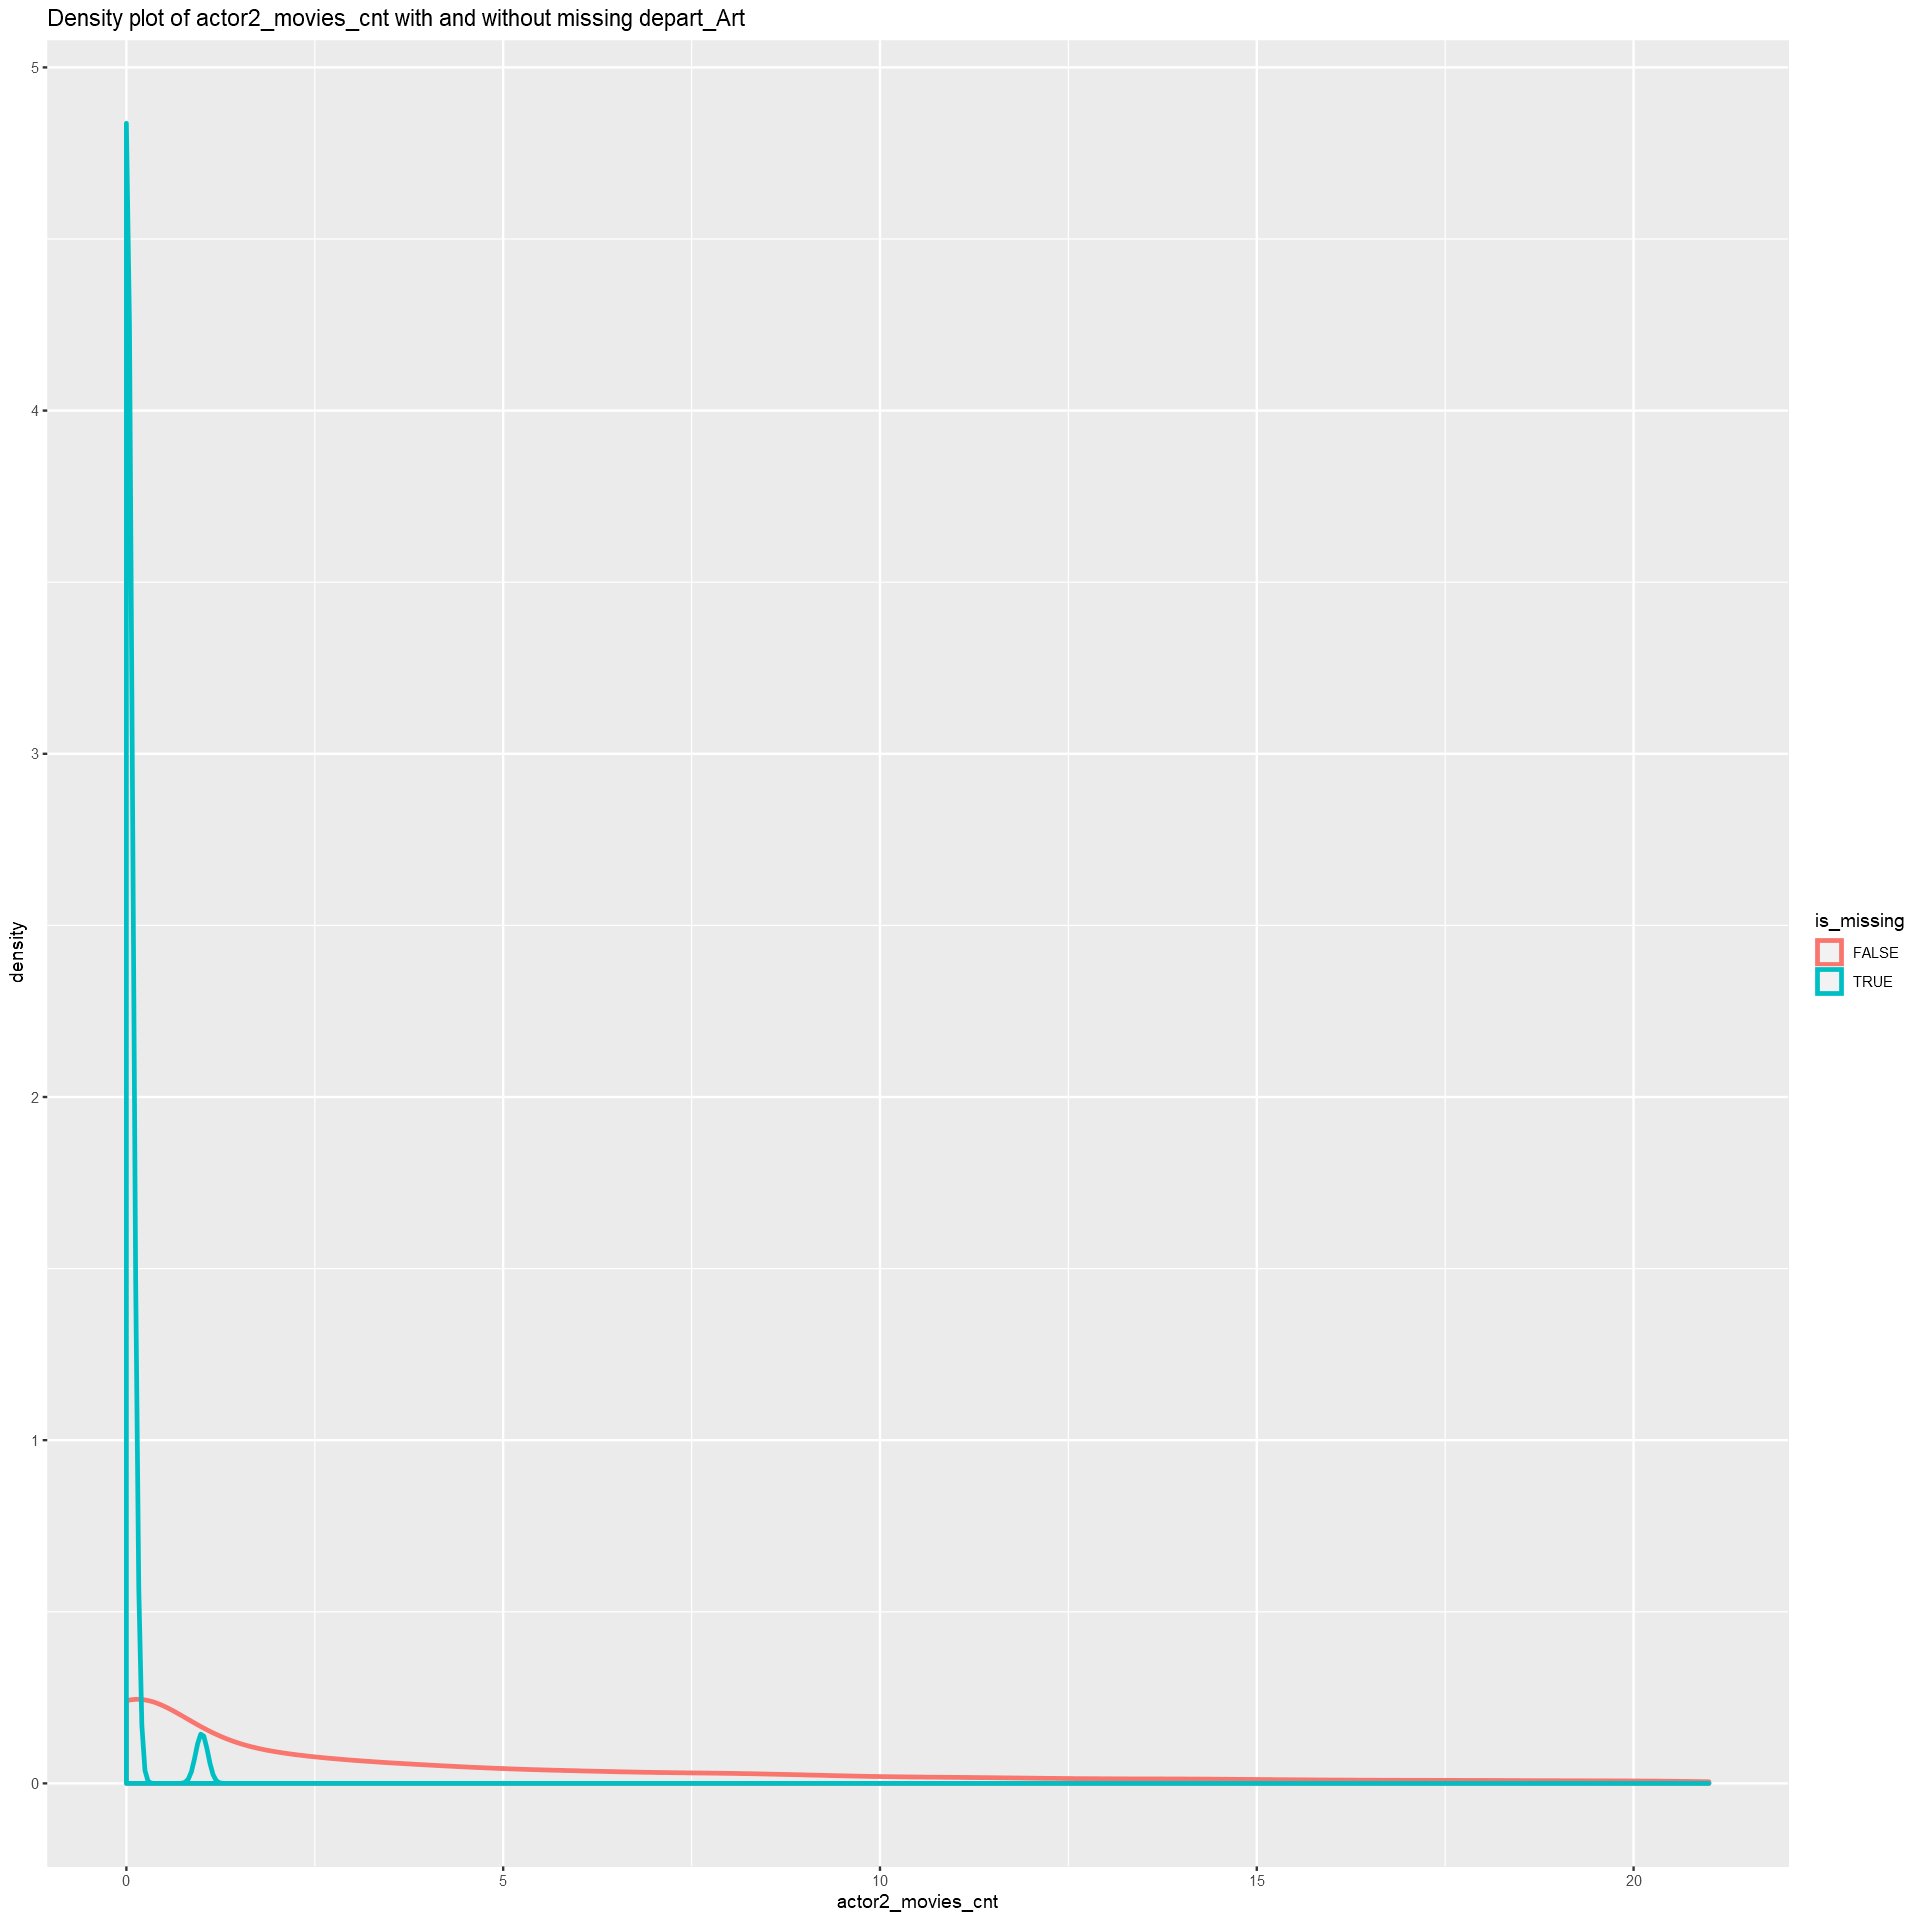

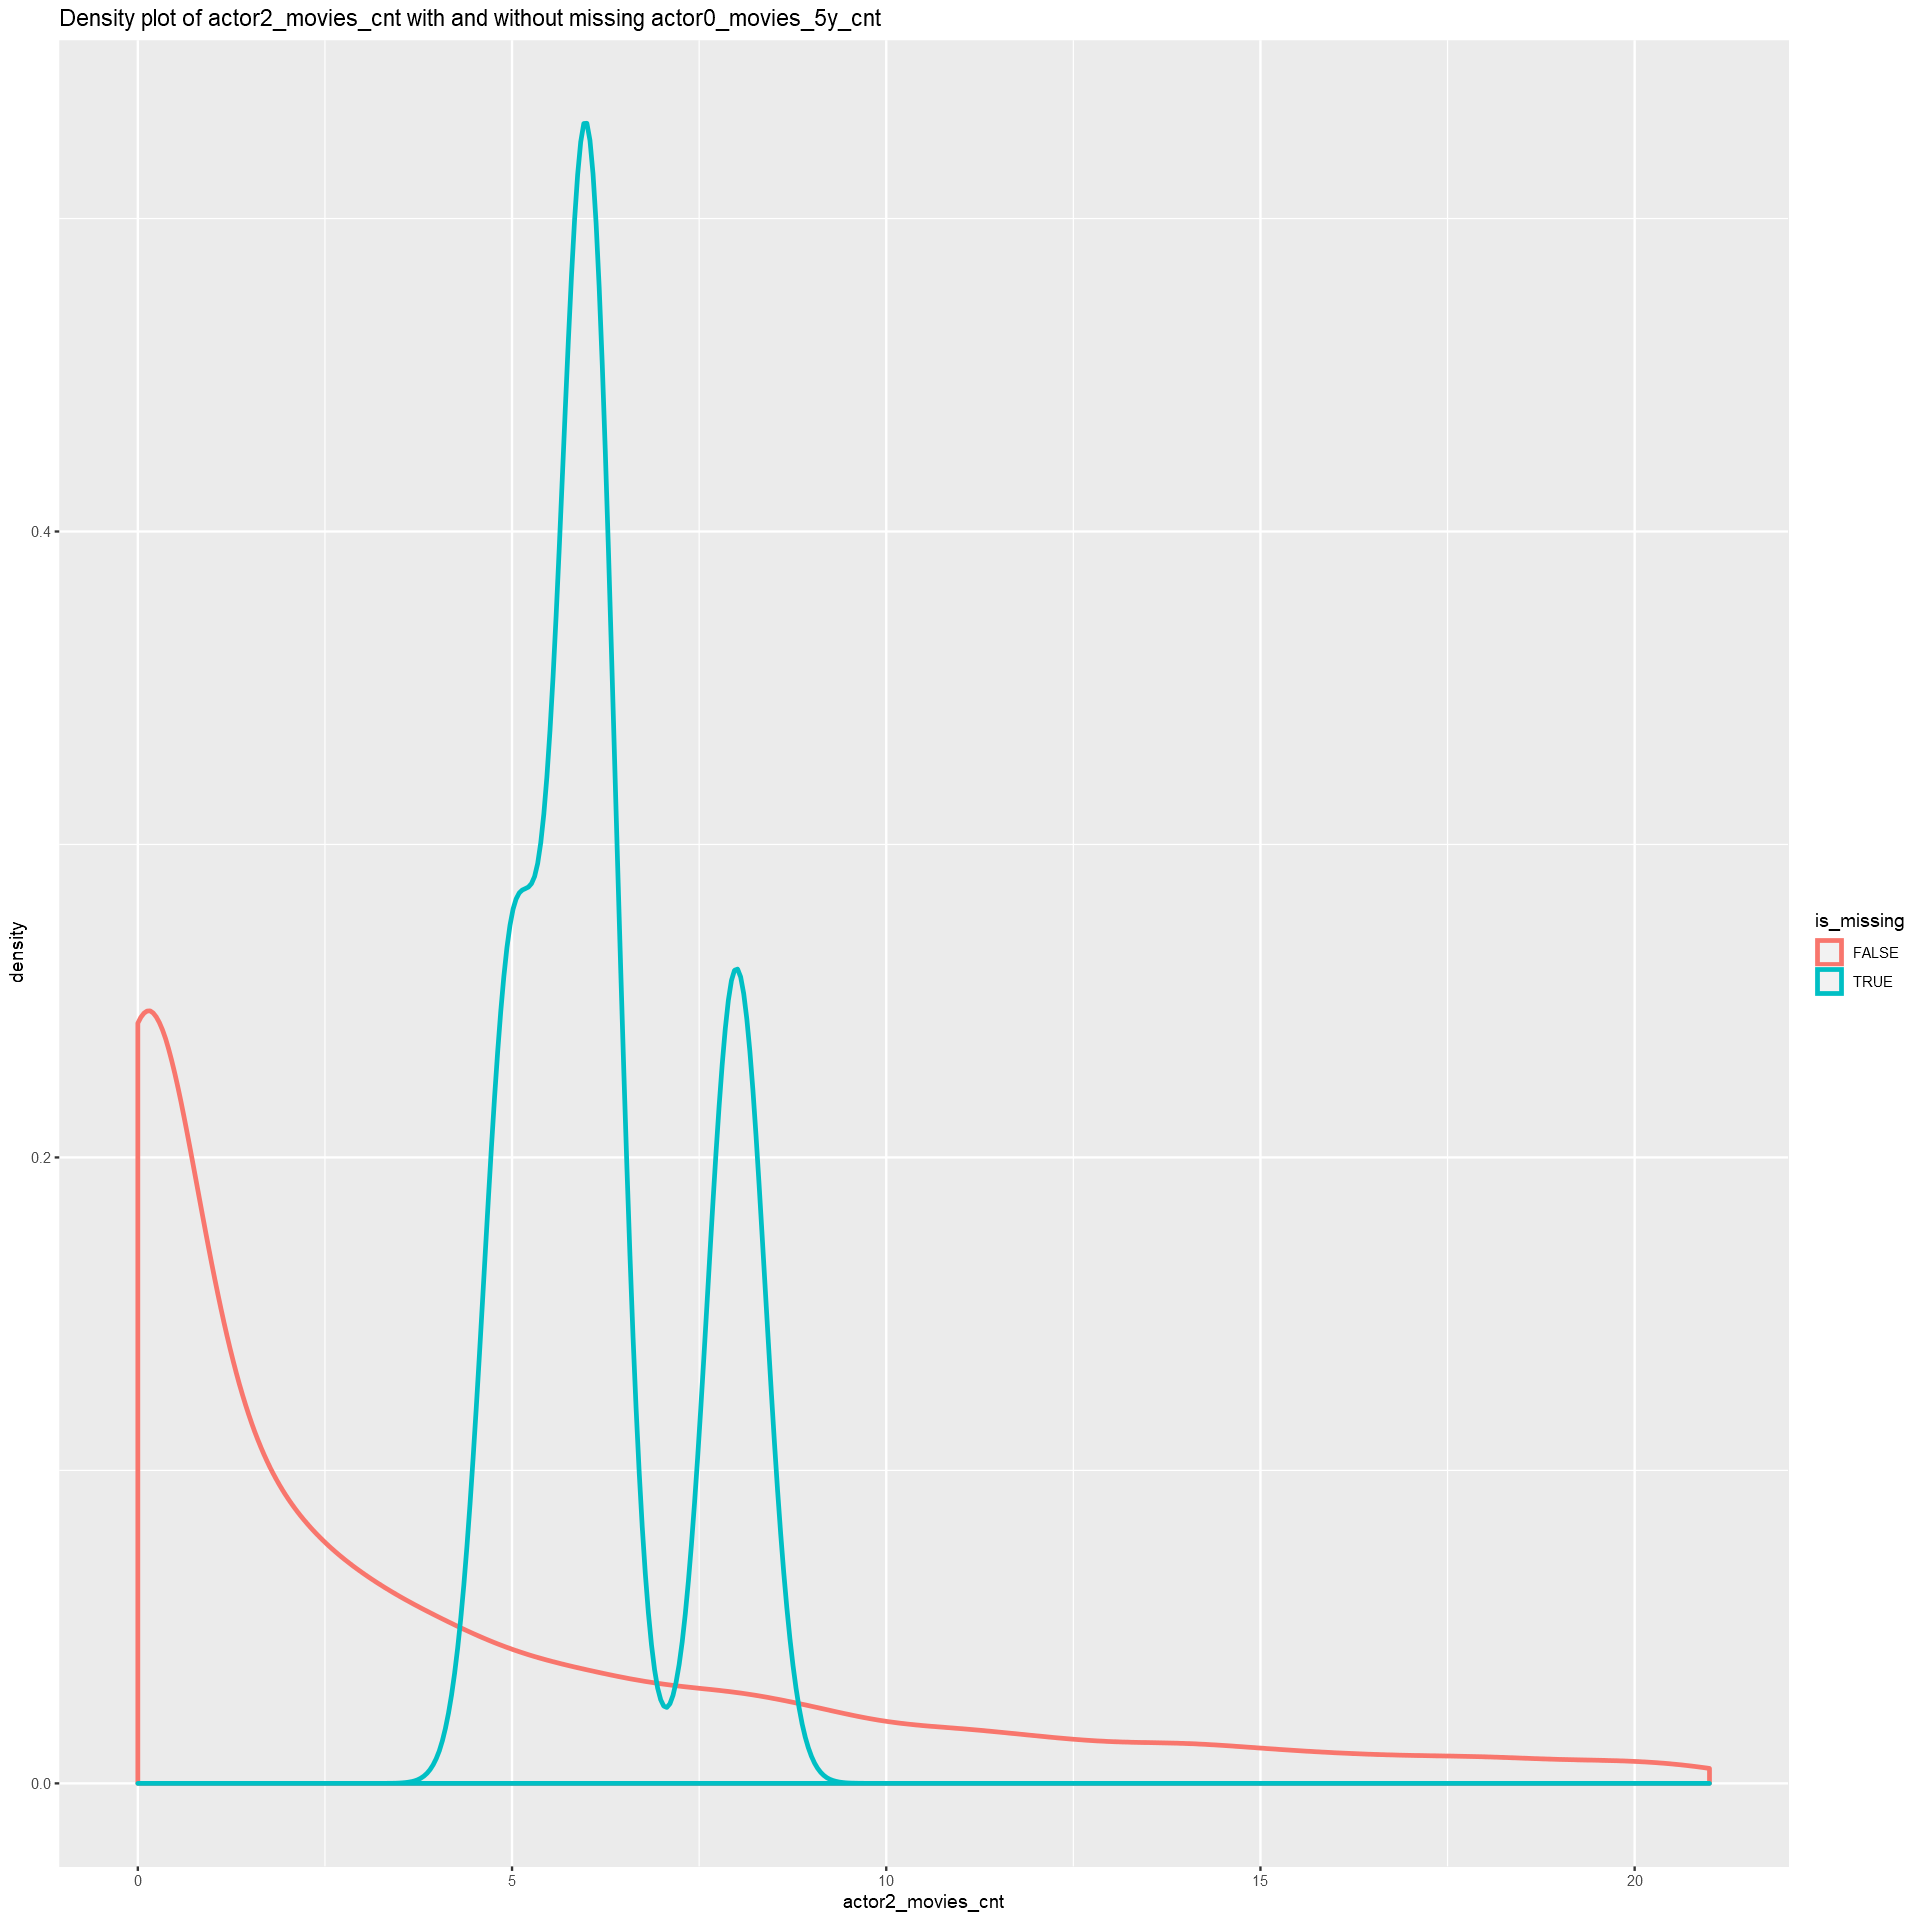

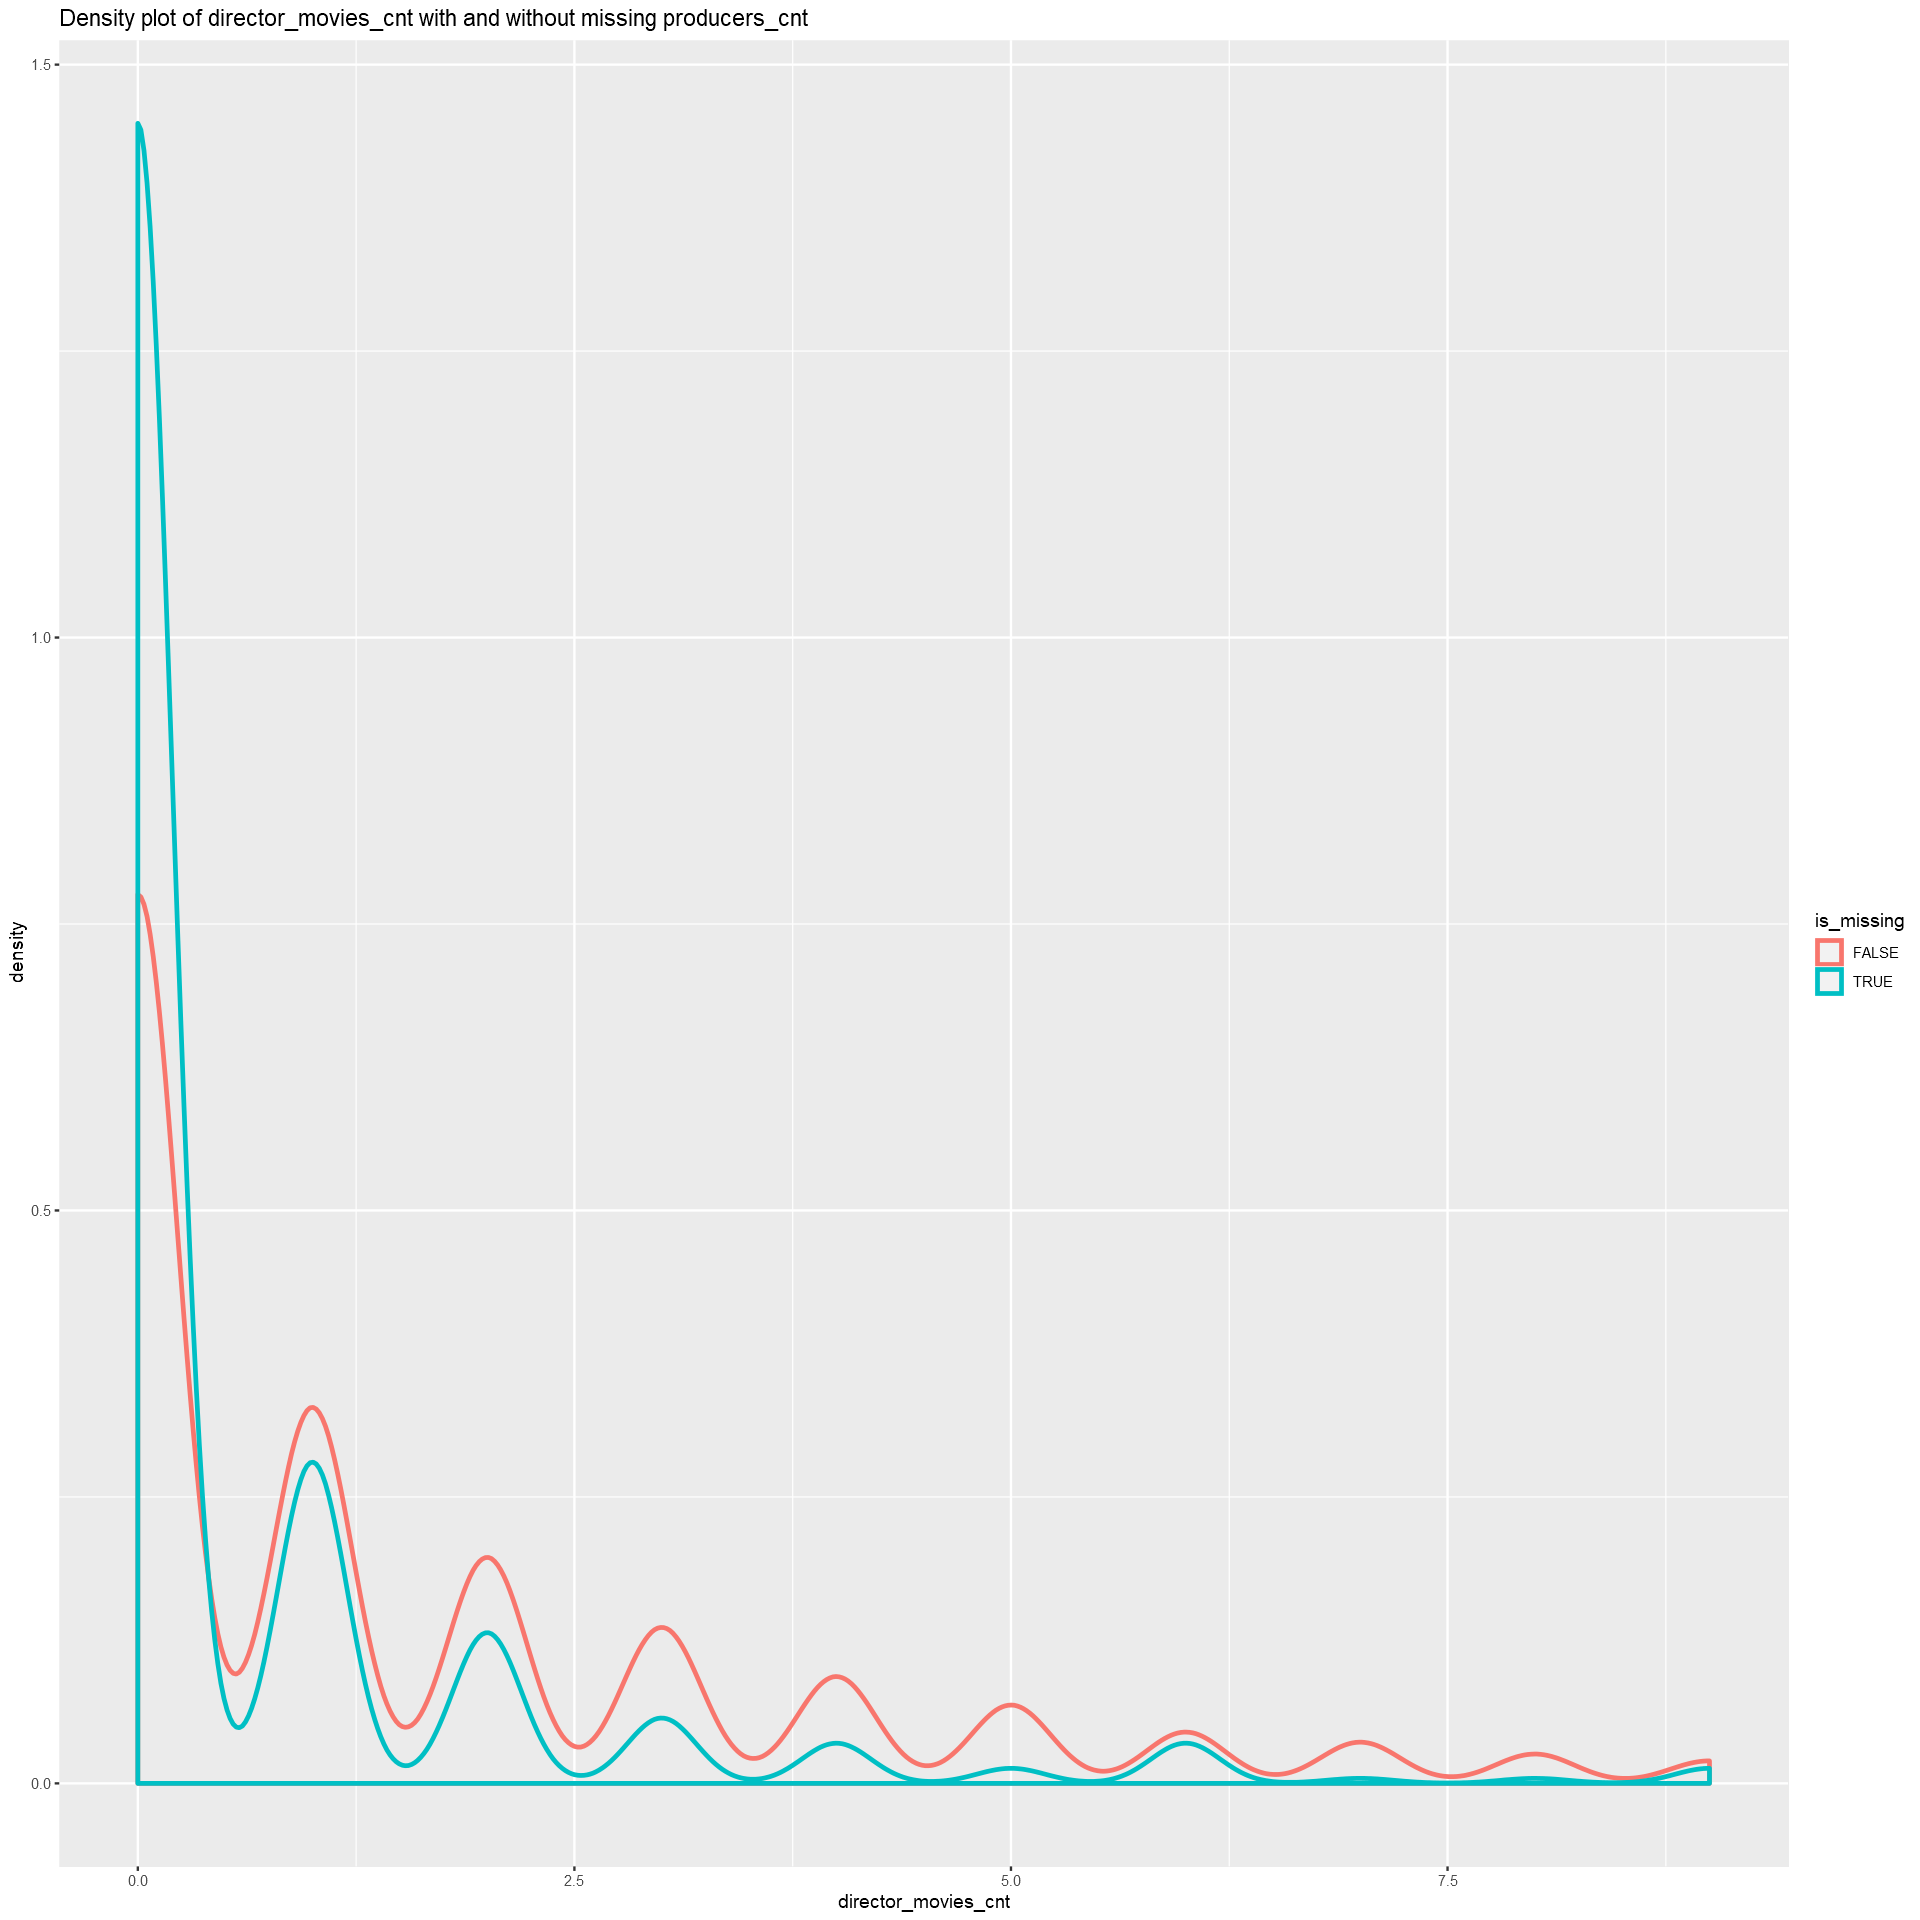

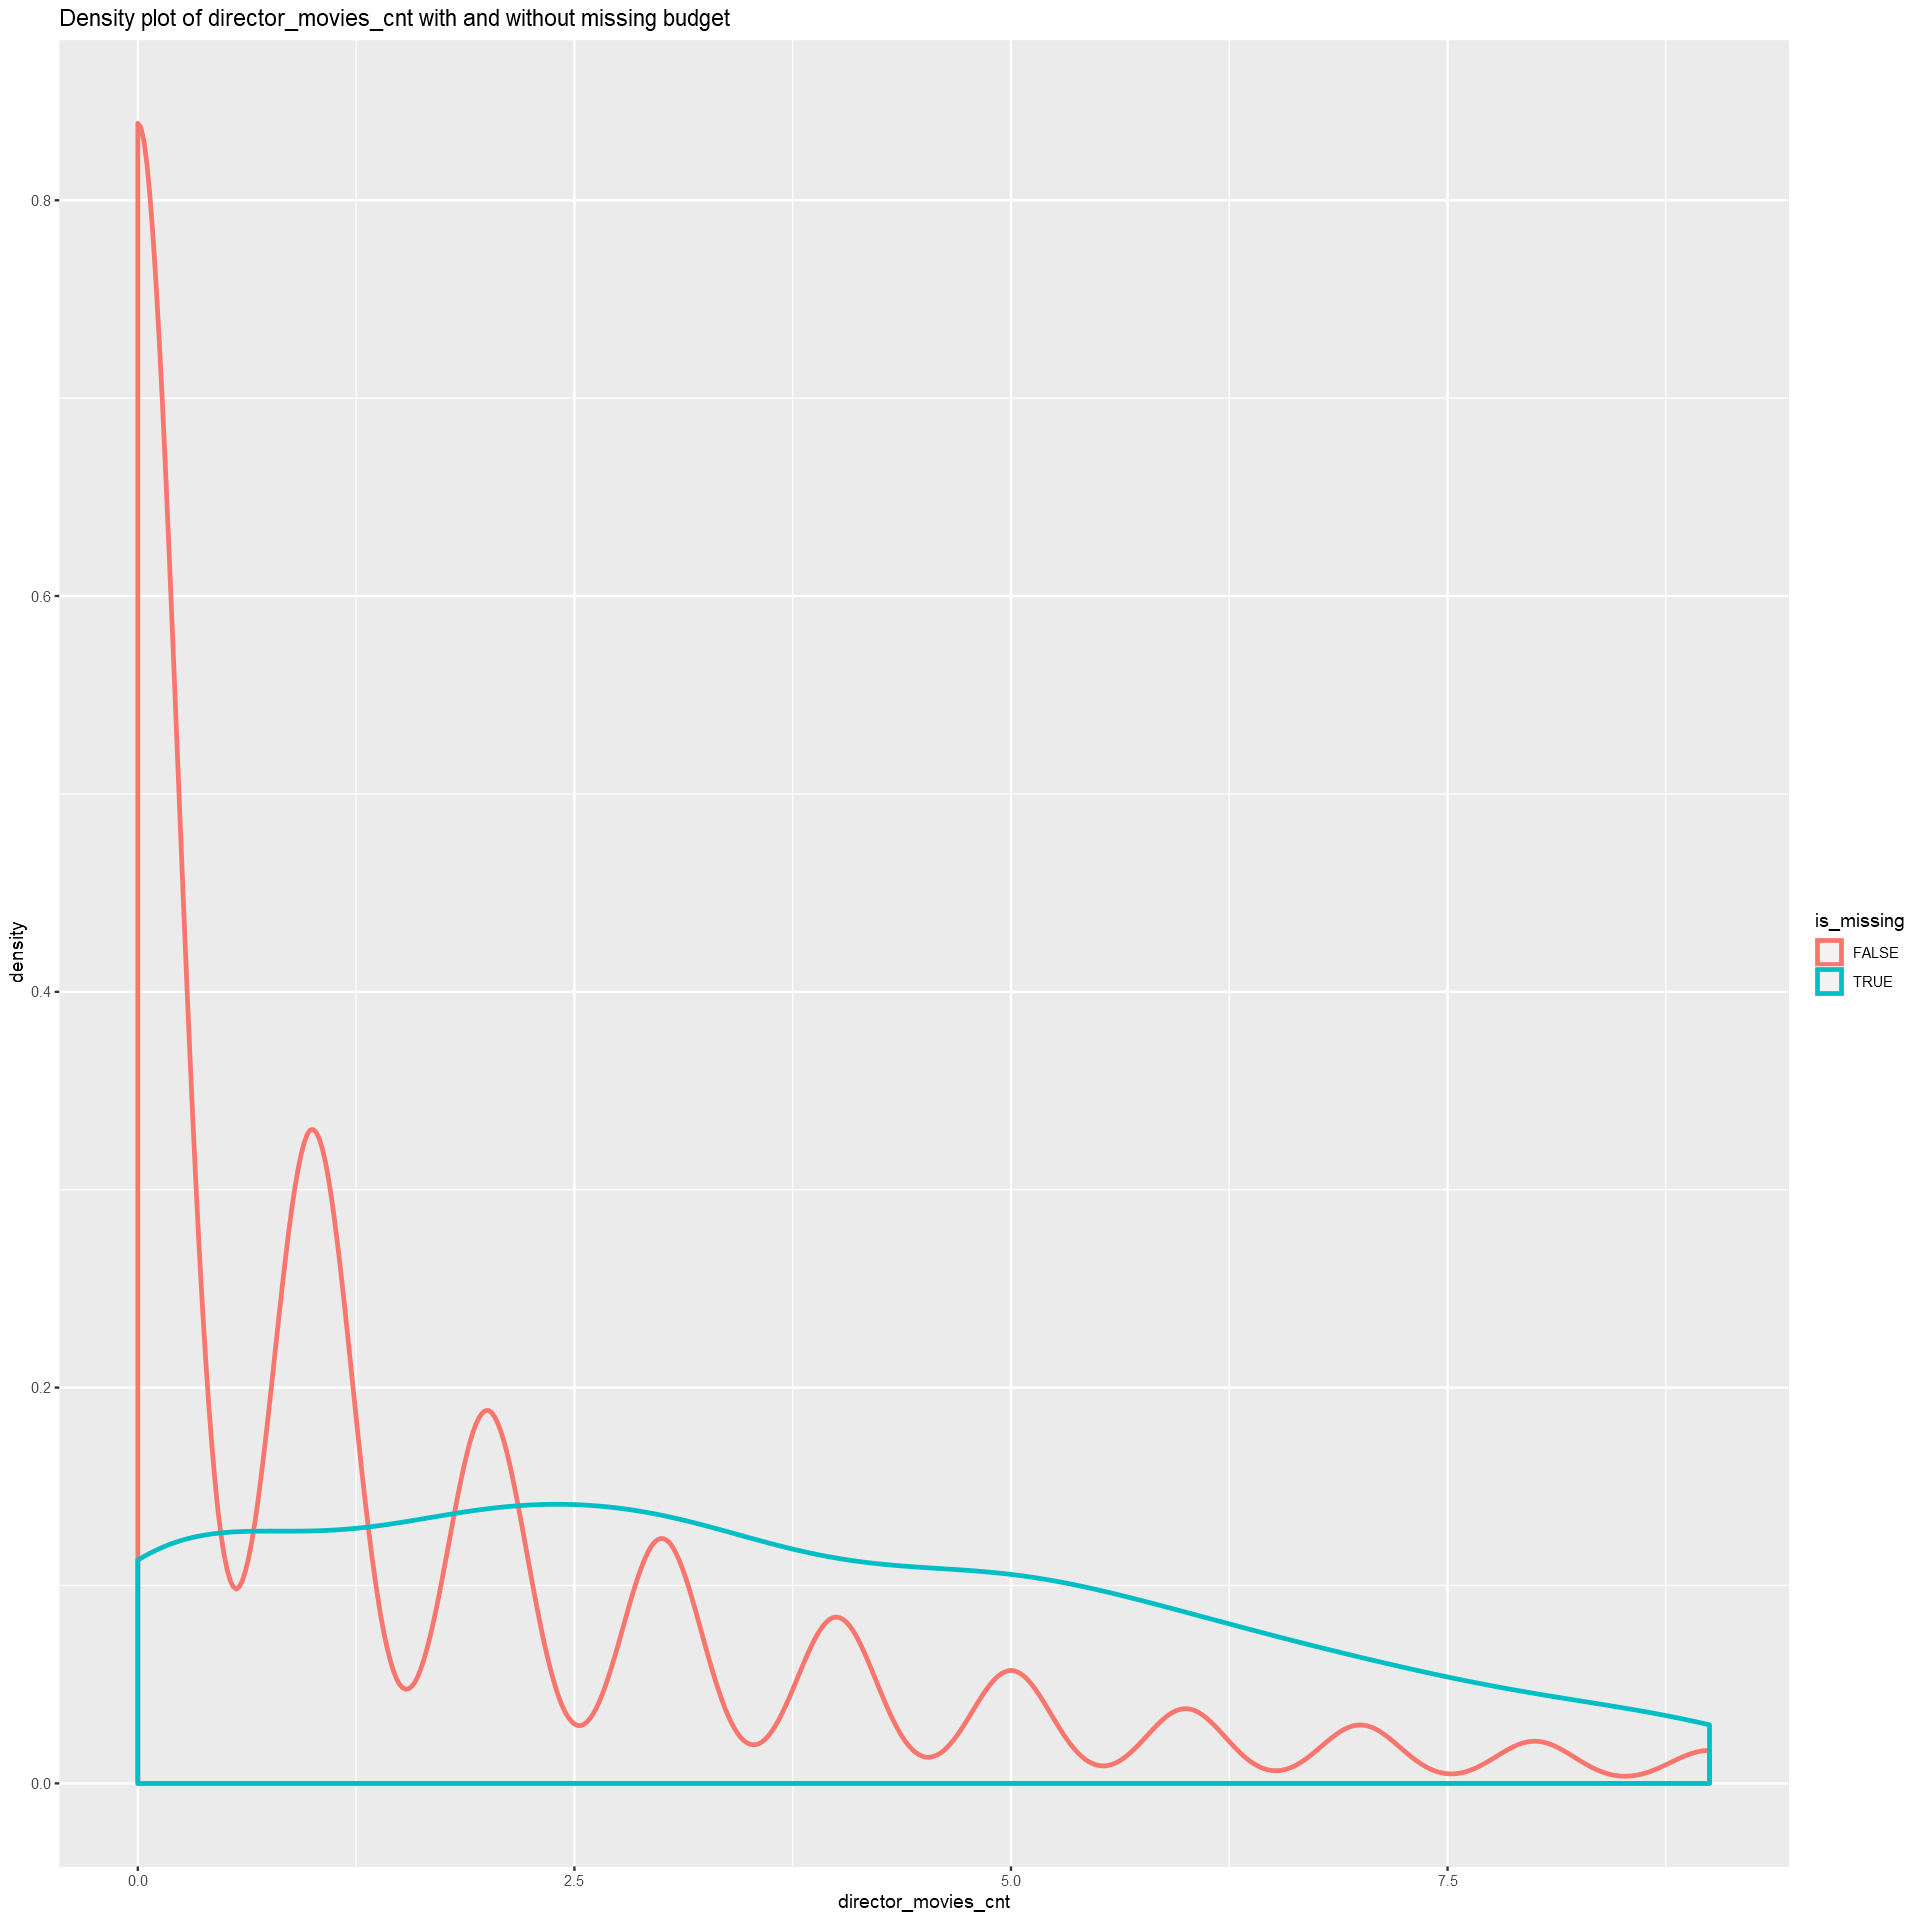

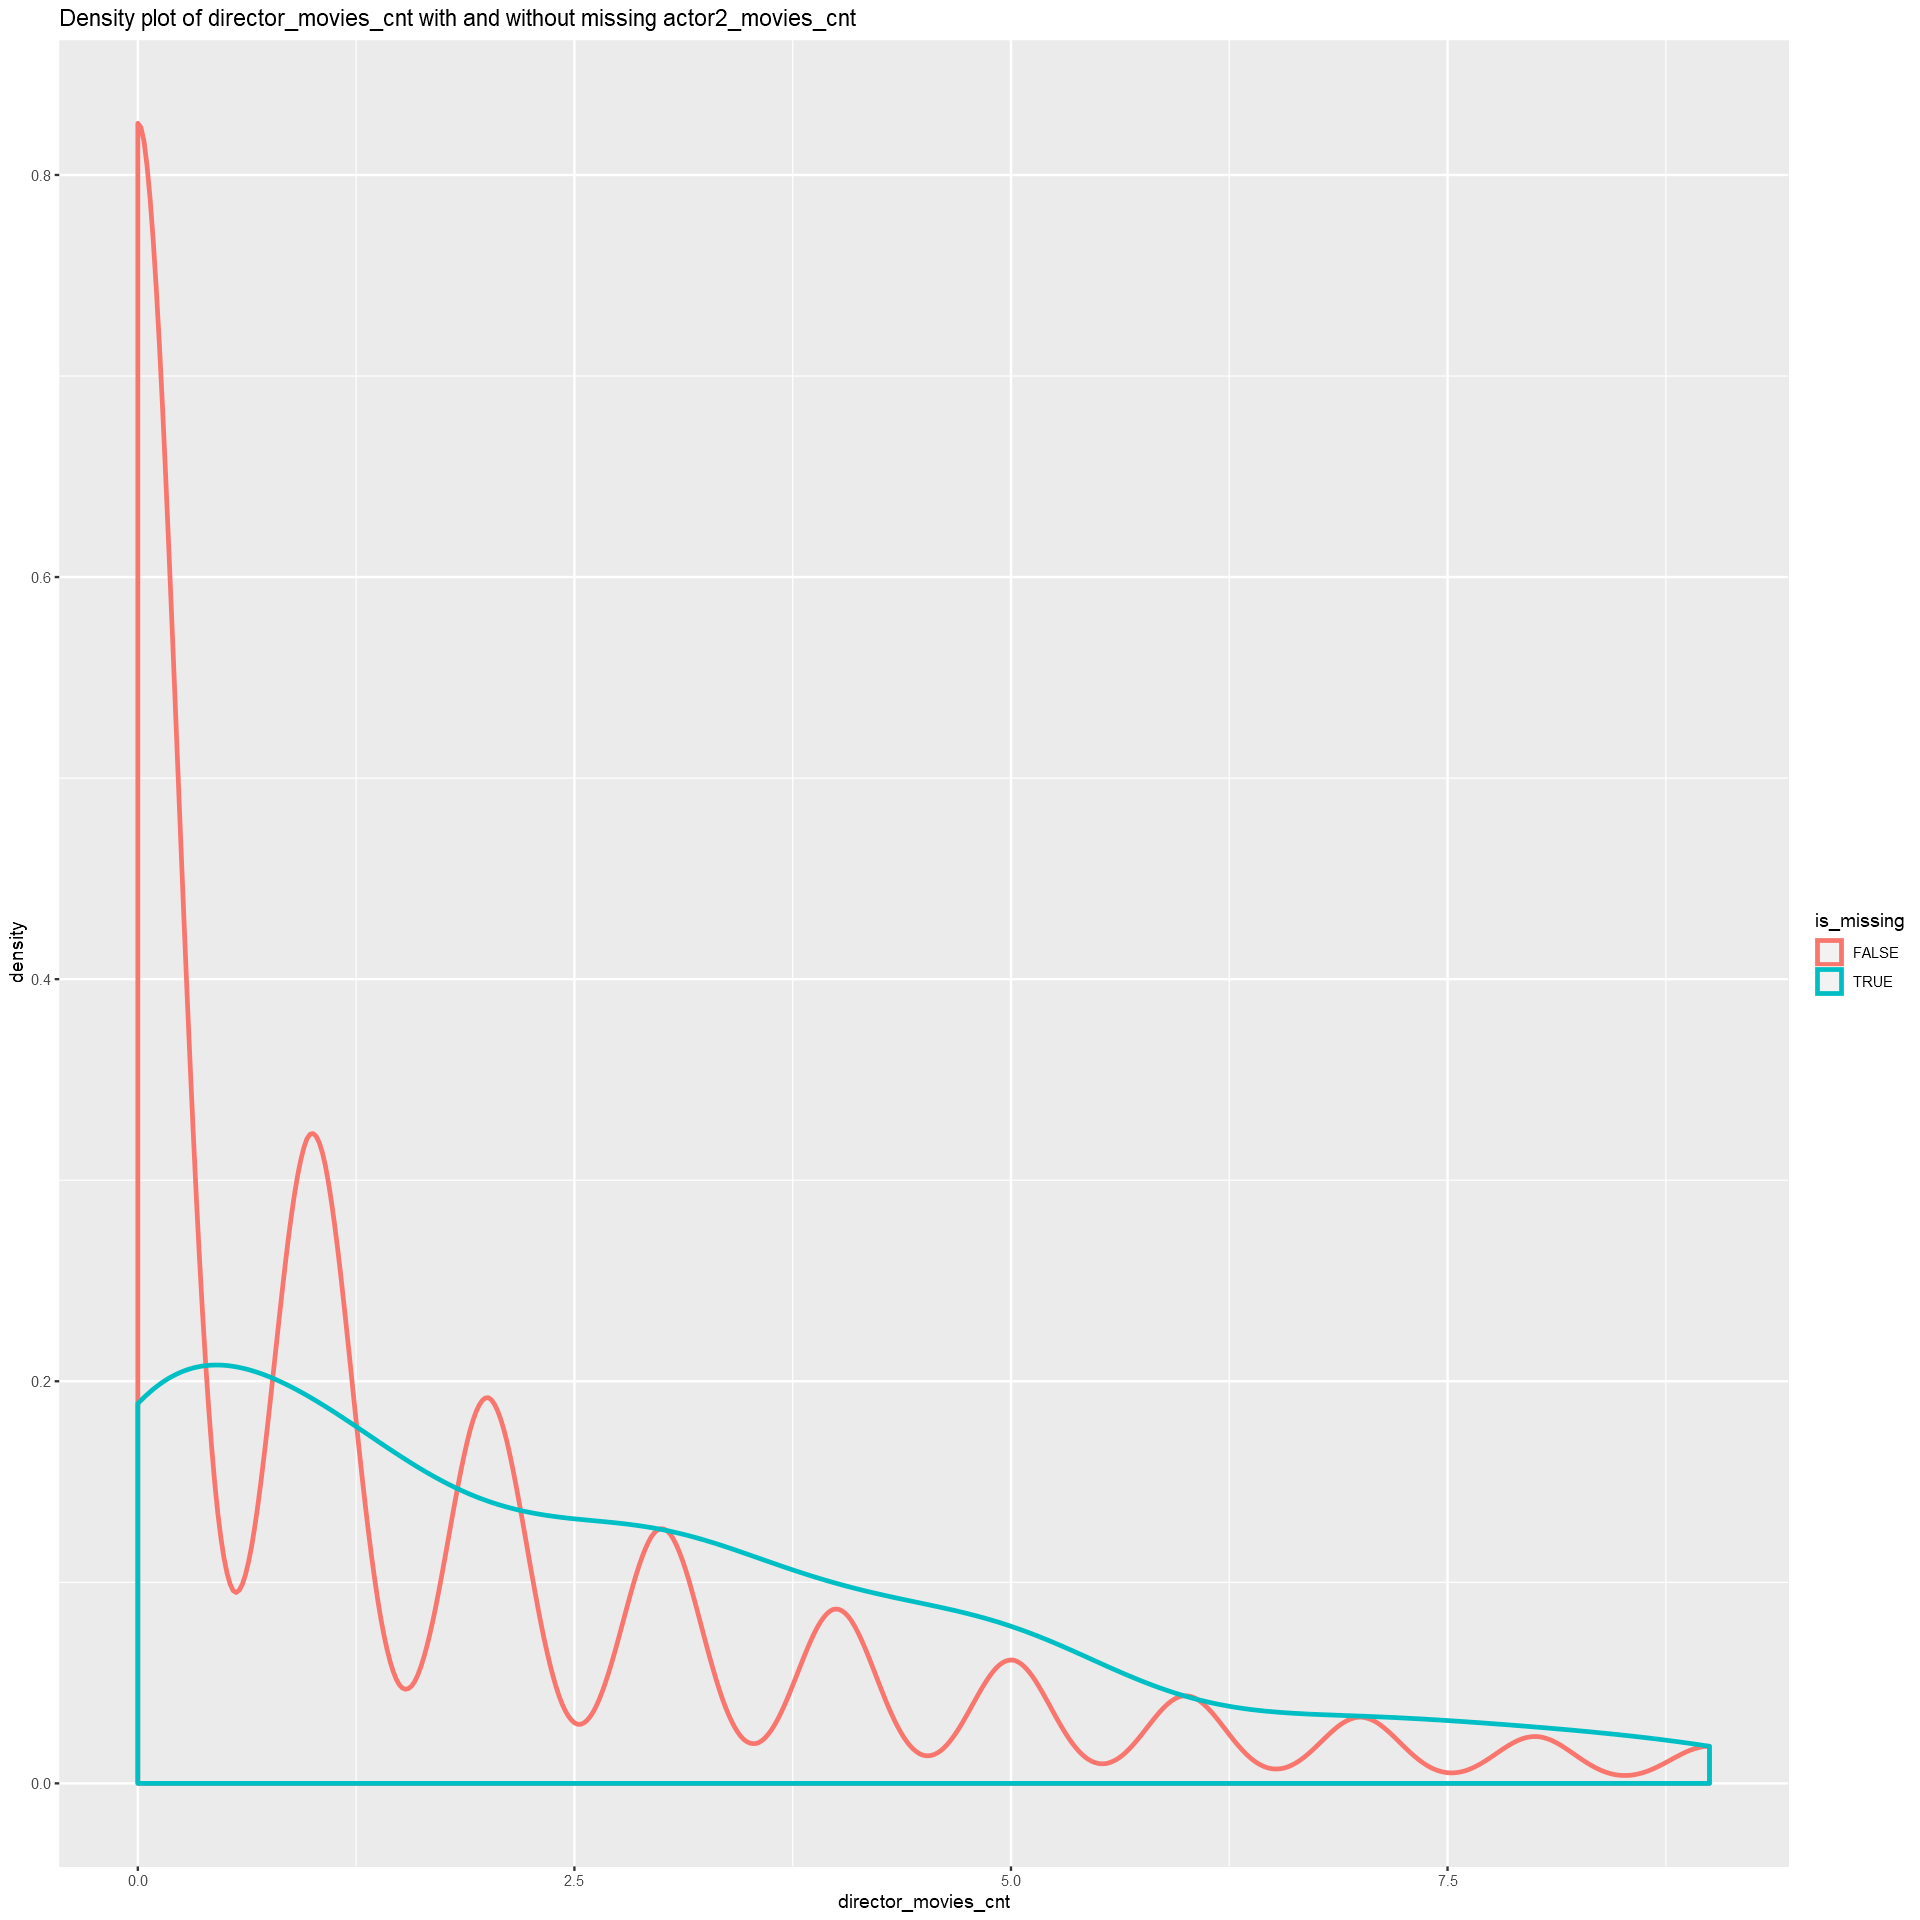

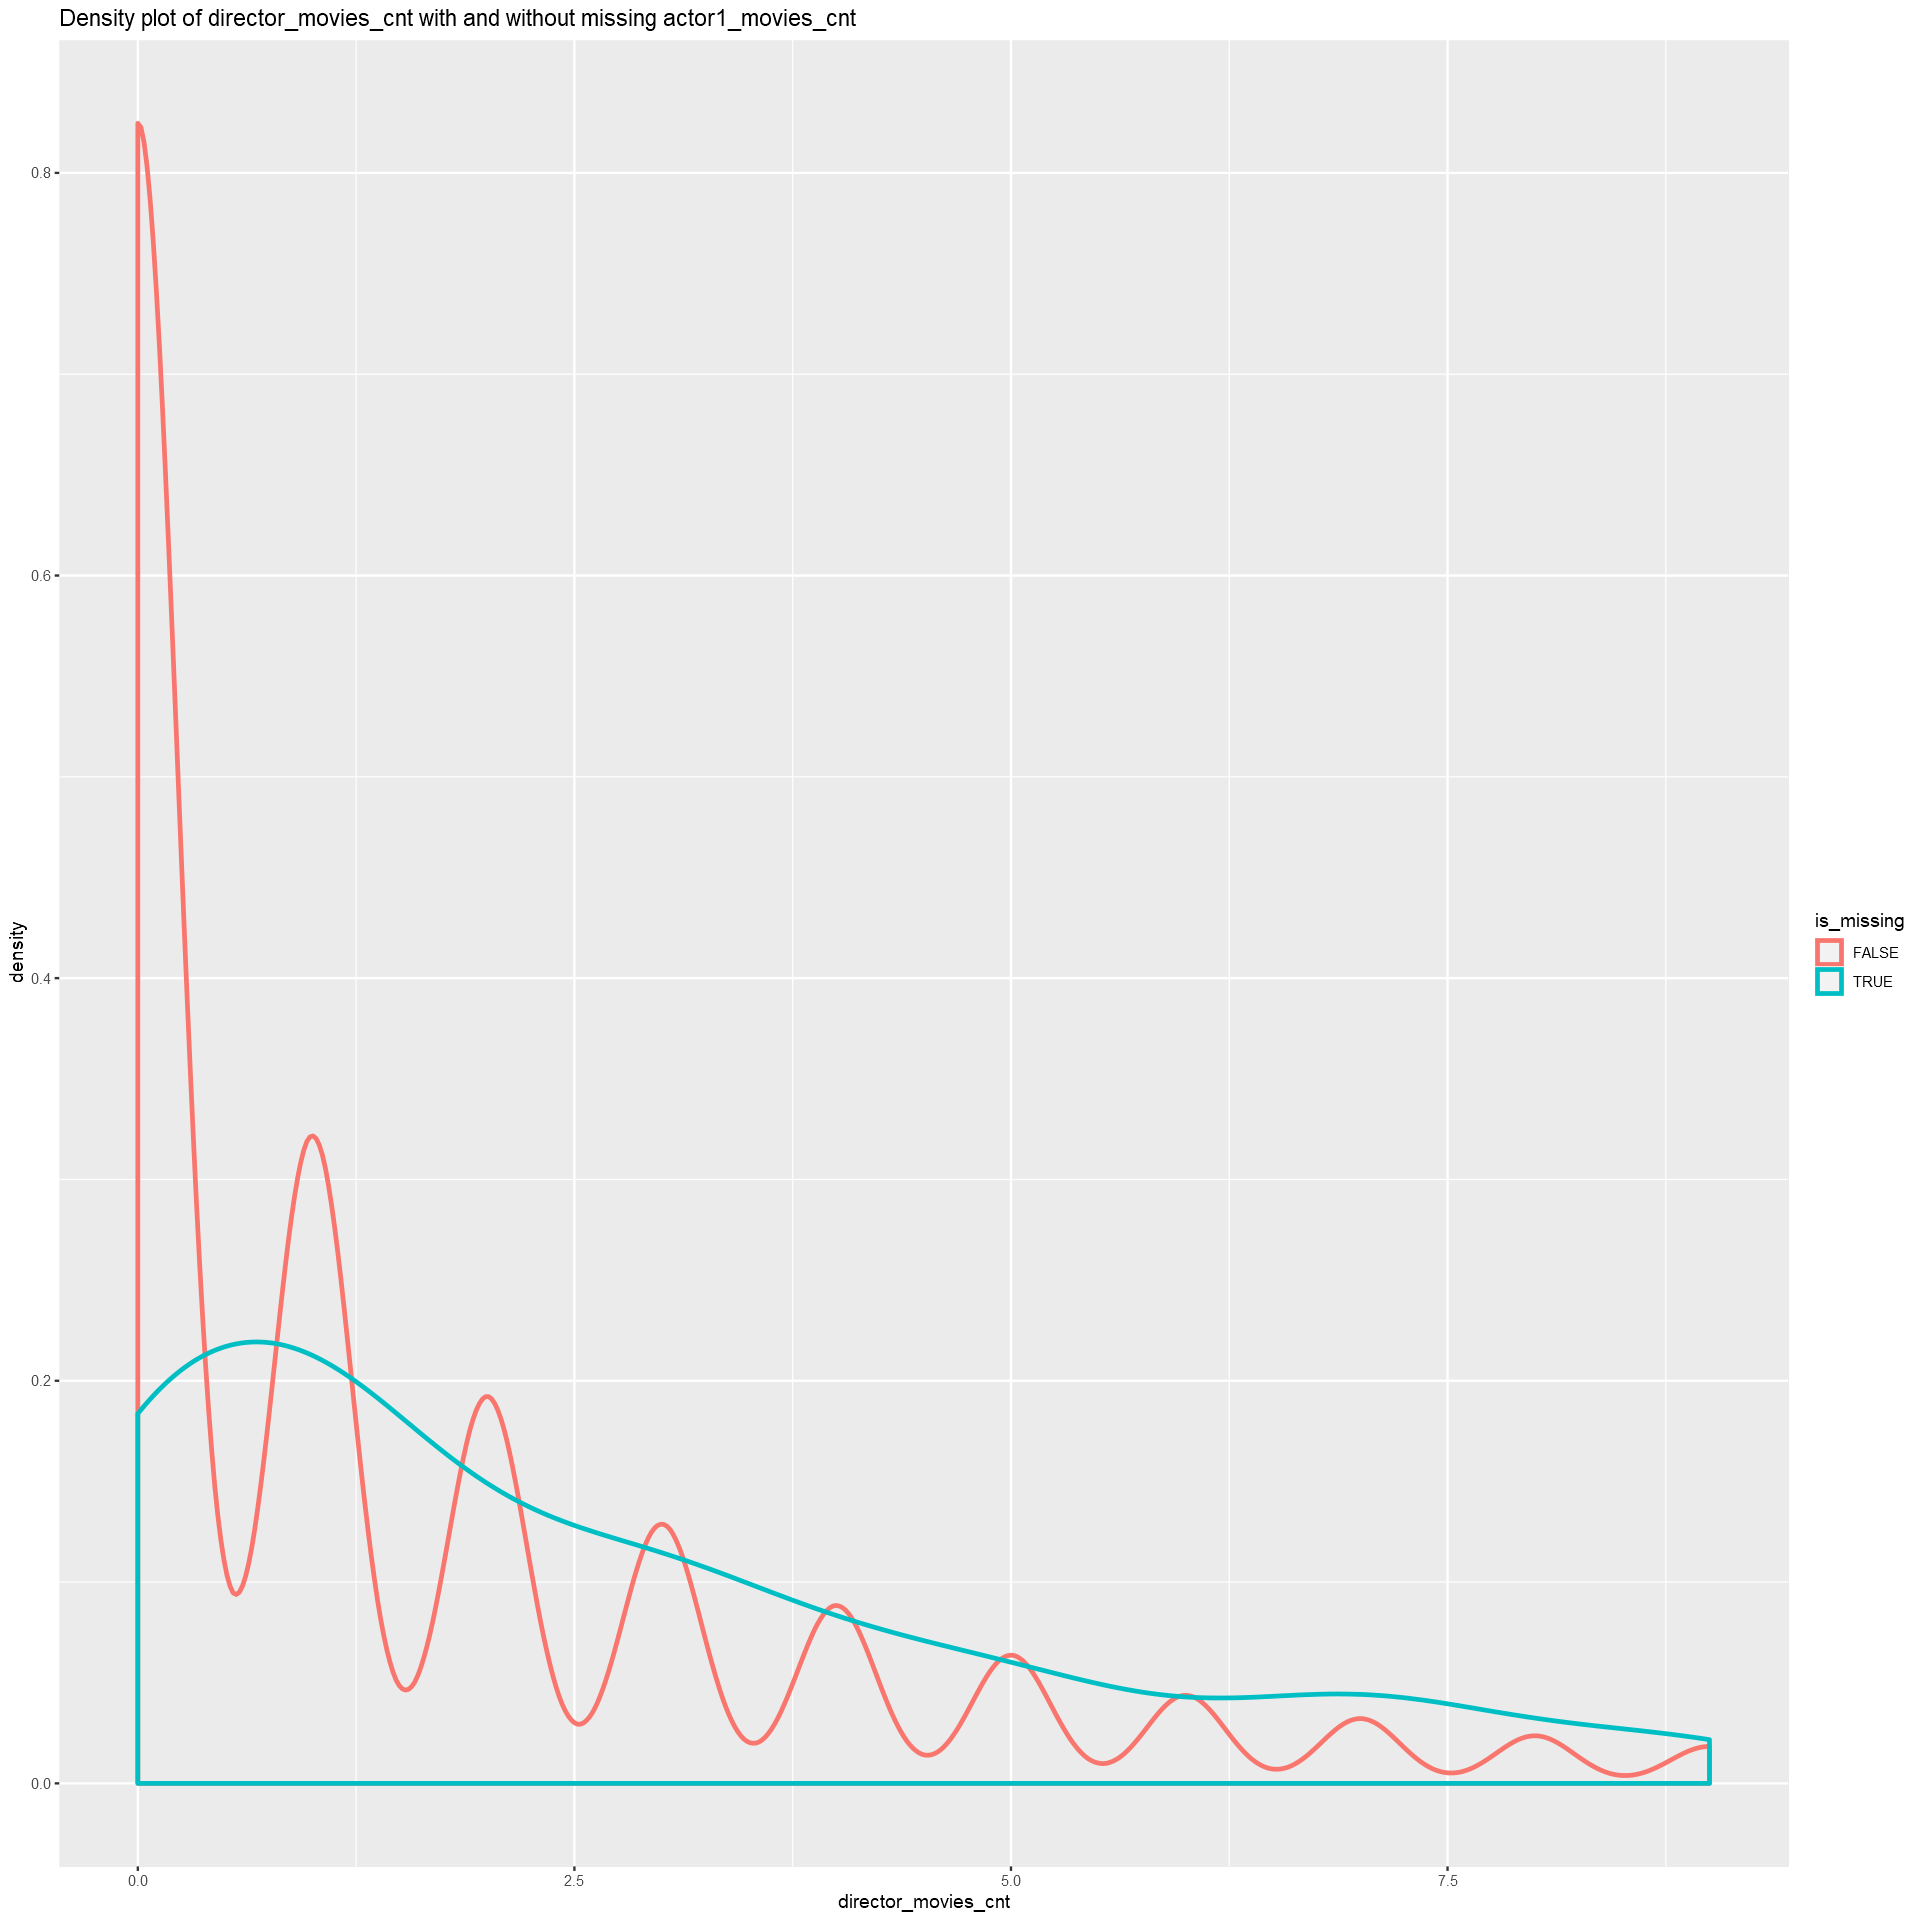

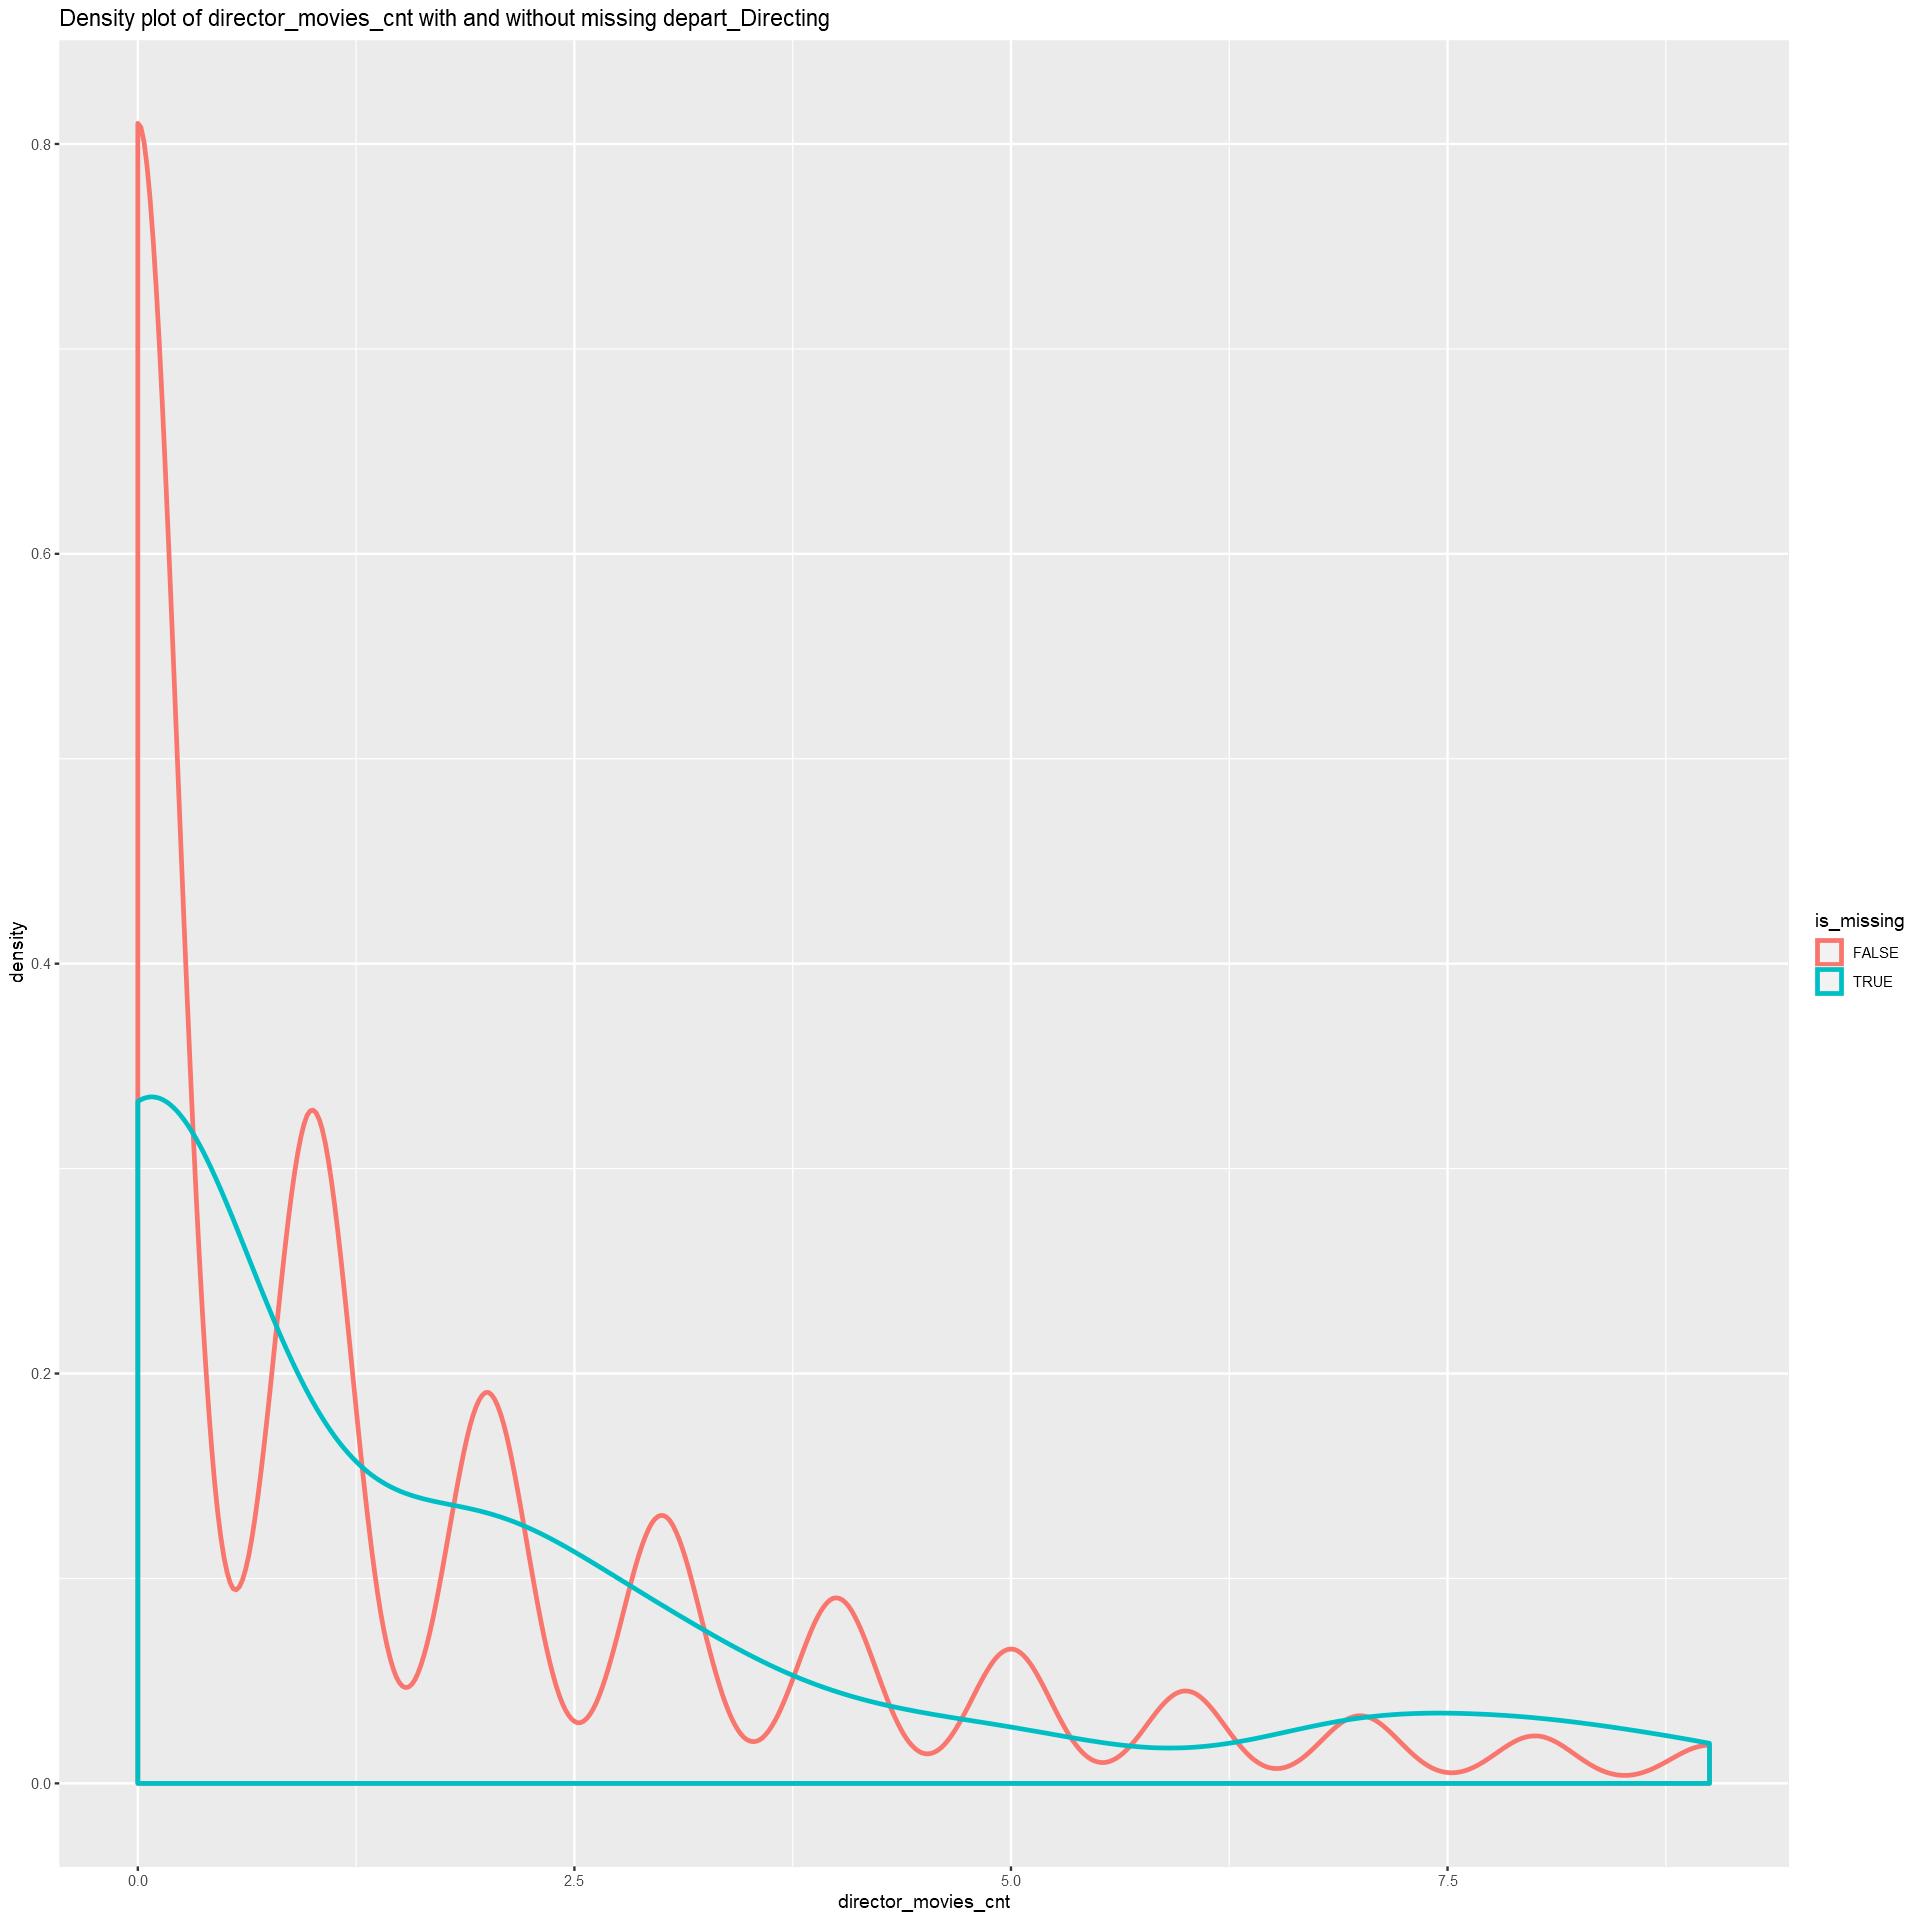

In [ ]:

missingness<-getMissingness(ocmovies, getRows = TRUE)

df<-missingness$missingness %>% filter(rate >= 37.0)
high_missing_variables<-as.character(df$var)

#remove variables with more than X of missings
df<-missingness$missingness %>% filter(rate < 37.0)
df<-df %>% filter(rate > 0)


missing_variables<-as.character(df$var)

miss<-missingMatrix(ocmovies[missing_variables])


lmiss <- lapply(miss, as.logical)

par(mfrow=c(10,10))
options(repr.plot.width = 16, repr.plot.height = 16)


for(v in missing_variables) {
  for(j in missing_variables) {
    

    if (protocol[v, "Value.type"] == "Numeric" & protocol[j, "Value.type"] == "Numeric" &
        protocol[v, "Data.type"] != "Boolean" & protocol[j, "Data.type"] != "Boolean")
    {
      val.min <-   as.numeric(str_trim(protocol[v, 'Min']))
      val.max <- as.numeric(str_trim(protocol[v, 'Max']))


      if (v!=j)
      {
        if (val.max> 1000000) {
          is_missing<-lmiss[[j]]
          p<-ggplot(ocmovies) +
            geom_density(aes(log(ocmovies[[v]]), group=is_missing, color=is_missing), size = 1) +
            scale_x_continuous(name = paste("Log of", v)) +
            ggtitle(paste("Density plot of", v, "with and without missing", j))
            print(p)
        }
        else
        {
          is_missing<-lmiss[[j]]
          p<-ggplot(ocmovies) +
            geom_density(aes(ocmovies[[v]], group=is_missing, color=is_missing), size = 1) +
            scale_x_continuous(name = v) +
            ggtitle(paste("Density plot of", v, "with and without missing", j))
            print(p)
        }
      }
    }
  }
}

## Variables with missingt more than 37% will be removed (since missing percentage cannot be that high). Except for Revenue since it's a dependent variable

In [ ]:
missingness<-getMissingness(ocmovies)

df<-missingness$missingness %>% filter(rate >= 37.0)
high_missing_variables<-as.character(df$var)

high_missing_variables_wo_revenue<-high_missing_variables[-grep('\\brevenue\\b', high_missing_variables)]

mmovies<-ocmovies[, !(names(ocmovies) %in% high_missing_variables_wo_revenue)]

options(repr.plot.width = 16, repr.plot.height = 16)

vis_miss(mmovies[1:round(ncol(mmovies)/2)])

vis_miss(mmovies[round(ncol(mmovies)/2): ncol(mmovies)])



## Variable with missingness less than 1% will be resolved via observations removal

In [ ]:
missingness<-getMissingness(mmovies)

df<-missingness$missingness %>% filter(rate < 1.0)

low_missing_variables<-as.character(df$var)

mmovies<-ocmovies %>% drop_na(low_missing_variables)

options(repr.plot.width = 16, repr.plot.height = 16)

vis_miss(mmovies[1:round(ncol(mmovies)/2)])

vis_miss(mmovies[round(ncol(mmovies)/2): ncol(mmovies)])

#########################################################################
# turn boolean columns to factors and clean factors from missings
#########################################################################


In [ ]:
df<-protocol %>% filter(Data.type == "Boolean") %>% select(Feature.name)
booleans<-str_trim(as.character(df$Feature.name))

#mmovies<-ocmovies


for(n in booleans){
  levels<-c("None", "Exist")
  mmovies[[n]] <- cut(mmovies[[n]], breaks = c(0,1,2), labels = levels,  right = FALSE)
}



factors_columns<-names(mmovies)[ sapply(mmovies, is.factor)]

for (n in factors_columns){
  s<-sum(is.na(mmovies[[n]]))
  if (s > 0){
    levels <- levels(mmovies[[n]])
    levels[length(levels) + 1] <- "Missing"

    # refactor mmovies[[n]] to include "None" as a factor level
    # and replace NA with "None"
    mmovies[[n]] <- factor(mmovies[[n]], levels = levels)

    mmovies[[n]][is.na(mmovies[[n]])] <- "Missing"

    print(n)

  }
}

vis_miss(mmovies[1:round(ncol(mmovies)/2)])

vis_miss(mmovies[round(ncol(mmovies)/2): ncol(mmovies)])


In [ ]:
#Variable with missingness less than 1% will be resolved via observations removal
#depart_Sound"                 "actor1_movies_5y_cnt"         "depart_Production_female"     "depart_Visual_Effects_female"
# [5] "depart_Crew"                  "depart_Custom_Mkup"           "depart_Lighting"              "depart_Art_female"
# [9] "depart_Camera_female"         "depart_Crew_female"           "depart_Custom_Mkup_female"    "depart_Directing_female"
#[13] "depart_Editing_female"        "depart_Sound_female"          "depart_Writing_female"        "depart_Art"
#[17] "depart_Camera"                "depart_Lighting_female"       "actor2_movies_5y_cnt"         "director_movies_5y_cnt"
#[21] "actor0_movies_5y_cnt"         "release_date"                 "release_year"                 "release_month"
#[25] "release_day"                  "seasonality"                  "countries_cnt"

# according to vis_miss it's clear this is not MCAR/MAT - following categorical variables should be fix via adding a new category (missing)
#"sw_female_actor0"      "sw_male_actor0"        "sw_female_actor2"      "sw_male_actor2"        "sw_female_actor1" "sw_male_actor0"
#
#"actor0_prev_revenue" is a Numerics variable (37,32% missingness) - need to thing what to do with it



#miss1 <- TestMCARNormality(data=mmovies, del.lesscases = 3)


In [ ]:


for (n in 1:1) {
  print(n)
  mm<-as.matrix(mmovies[n:12])
  miss1 <- TestMCARNormality(data=mm, del.lesscases = 1)
  print(miss1)
  options(repr.plot.width = 6, repr.plot.height = 8)
  boxplot(miss1)

}

mmovies.numeric <- mmovies[,sapply(mmovies, is.numeric)]
dim(mmovies.numeric)

names(mmovies.numeric)
getMissingness(mmovies.numeric)






require(MissMech)


for (n in 1:19) {
  print(n)
  mm<-as.matrix(mmovies.numeric[n:(n+4)])
  miss1 <- TestMCARNormality(data=mm, del.lesscases = 1)
  print(miss1)
}



#TestMCARNormality(data=as.matrix(movies[numerics_wo_revenue]), del.lesscases = 1)


dd<-protocol[missing_variables,] %>% filter(Value.type == 'Numeric')

ff<-str_trim(dd$Feature.name)

TestMCARNormality(data=as.matrix(movies[ff[1:15]]), del.lesscases = 1)

nummovies<-movies[, (names(movies) %in% numerics)]

TestMCARNormality(data=as.matrix(nummovies[, !(names(nummovies) %in% high_missing_variables)]), del.lesscases = 1)


In [ ]:
##########################################################################################
# Misssing: Do imputation for each variable according to the appropriate technic
##########################################################################################



In [ ]:
library(mice)
init = mice(ocmovies, maxit=0)
meth = init$method
predM = init$predictorMatrix

predM
set.seed(103)
imputed = mice(movies[missing_variables], method=meth, predictorMatrix=predM, m=5)
